In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def create_interaction_matrix(df,user_col, item_col, rating_col, norm= False, threshold = None):
    '''
    Function to create an interaction matrix dataframe from transactional type interactions
    Required Input -
        - df = Pandas DataFrame containing user-item interactions
        - user_col = column name containing user's identifier
        - item_col = column name containing item's identifier
        - rating col = column name containing user feedback on interaction with a given item
        - norm (optional) = True if a normalization of ratings is needed
        - threshold (required if norm = True) = value above which the rating is favorable
    Expected output - 
        - Pandas dataframe with user-item interactions ready to be fed in a recommendation algorithm
    '''
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [3]:
def runMF(interactions, n_components, loss, epoch,n_jobs):
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,learning_schedule='adagrad')
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

In [4]:
def create_item_emdedding_distance_matrix(model,interactions):
    df_item_norm_sparse = sparse.csr_matrix(model.item_embeddings)
    similarities = cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = interactions.columns
    item_emdedding_distance_matrix.index = interactions.columns
    return item_emdedding_distance_matrix

In [5]:
def item_item_recommendation(item_emdedding_distance_matrix, item_id, 
                             item_dict, n_items = 10, show = True):

    recommended_items = list(pd.Series(item_emdedding_distance_matrix.loc[item_id,:]. \
                                  sort_values(ascending = False).head(n_items+1). \
                                  index[1:n_items+1]))
    if show == True:
        print("Item of interest :{0}".format(item_dict[item_id]))
        print("Item similar to the above item:")
        counter = 1
        for i in recommended_items:
            print(str(counter) + '- ' +  item_dict[i])
            counter+=1
    return recommended_items

In [6]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold,nrec_items,show):
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list

In [7]:
def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input - 
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [8]:
def create_item_dict(df,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input - 
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

In [9]:
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [10]:
orders=orders.loc[orders['eval_set']=='prior']

In [11]:
#We will work with 5000 users, last order will be in test set
users=range(1,5001)
orders_set=orders[orders["user_id"].isin(users)]
idx_test = orders_set.groupby(['user_id'])['order_number'].transform(max) == orders_set['order_number']
orders_set_test=orders_set[idx_test]


In [12]:
orders_set_testlist=np.unique(orders_set_test.order_id)
orders_set_train = orders_set[-orders_set["order_id"].isin(orders_set_testlist)]
orders_set_trainlist=np.unique(orders_set_train.order_id)

In [13]:
train= order_products_prior[order_products_prior["order_id"].isin(orders_set_trainlist)]
test=order_products_prior[order_products_prior["order_id"].isin(orders_set_testlist)]
train = pd.merge(train, orders_set_train, on='order_id', how='left')
test=pd.merge(test, orders_set_test, on='order_id', how='left')

In [14]:
print('TRAIN')
print('number of users:', len(np.unique(train.user_id)))
print('number of orders:', len(np.unique(train.order_id)))
print('number of products:', len(np.unique(train.product_id)))

print('TEST')
print('number of users:', len(np.unique(test.user_id)))
print('number of orders:', len(np.unique(test.order_id)))
print('number of products:', len(np.unique(test.product_id)))

TRAIN
number of users: 5000
number of orders: 71832
number of products: 28075
TEST
number of users: 5000
number of orders: 5000
number of products: 12341


In [15]:
set1 = set(np.unique(train.product_id))
set2 = set(np.unique(test.product_id))

missing =  pd.DataFrame.from_dict(list(sorted(set1 - set2)))
added =  pd.DataFrame.from_dict(list(sorted(set2 - set1)))

In [16]:
for i in range(len(missing)): 
    a=missing[0][i]
    print(a)
    test=test.append({'product_id': a},ignore_index=True)

7
12
13
18
27
31
35
36
37
38
40
43
46
47
51
52
53
57
59
65
66
75
81
97
102
106
107
108
111
113
115
118
127
132
133
134
138
140
144
145
146
149
150
152
157
158
167
173
176
179
181
184
185
186
188
190
193
194
199
200
203
205
206
209
212
216
219
223
232
233
234
237
242
243
246
253
254
255
262
263
265
266
267
270
271
275
281
282
284
285
286
288
290
291
293
299
303
305
306
307
315
321
322
328
330
333
334
335
337
338
339
342
348
351
352
353
355
358
360
361
362
364
366
371
376
377
378
380
383
386
387
388
391
393
394
396
400
401
406
411
412
418
419
422
425
427
428
431
433
434
443
445
446
448
453
456
462
466
467
468
471
476
477
478
483
484
487
488
501
502
505
507
508
509
510
515
518
520
521
522
523
528
530
535
536
537
539
544
548
549
552
554
558
563
566
567
568
571
576
577
578
584
587
593
601
603
604
606
611
612
613
615
616
617
626
630
631
634
637
640
642
643
645
648
653
654
664
666
669
673
677
680
682
683
690
695
698
699
702
707
711
714
718
722
724
725
726
727
730
731
735
736
737
738
742
743
7

5368
5369
5371
5375
5379
5382
5384
5386
5389
5396
5397
5403
5405
5409
5412
5415
5416
5423
5424
5426
5427
5433
5435
5439
5442
5444
5446
5447
5448
5455
5458
5459
5462
5464
5467
5471
5473
5474
5477
5480
5481
5483
5485
5486
5490
5493
5498
5502
5503
5505
5508
5513
5516
5519
5524
5525
5531
5532
5534
5546
5549
5554
5558
5559
5563
5564
5565
5567
5576
5585
5594
5595
5597
5599
5606
5607
5608
5610
5613
5616
5617
5619
5622
5630
5632
5635
5637
5639
5642
5653
5656
5658
5659
5663
5667
5670
5671
5672
5674
5676
5677
5680
5683
5688
5693
5695
5696
5697
5700
5710
5713
5719
5723
5724
5725
5726
5728
5730
5742
5745
5747
5752
5756
5758
5768
5776
5779
5780
5784
5791
5798
5799
5803
5809
5813
5817
5821
5822
5824
5833
5834
5838
5841
5843
5847
5856
5859
5860
5862
5865
5866
5867
5869
5870
5875
5882
5889
5891
5892
5895
5896
5897
5898
5900
5907
5915
5916
5917
5924
5925
5927
5934
5938
5941
5942
5943
5944
5952
5957
5958
5960
5961
5966
5968
5970
5971
5974
5976
5977
5981
5983
5984
5990
5992
5995
6001
6006
6007
6012
6013


10378
10380
10382
10383
10386
10387
10388
10394
10395
10396
10401
10402
10405
10409
10414
10415
10416
10418
10420
10424
10430
10433
10436
10437
10439
10442
10445
10447
10448
10455
10458
10463
10465
10470
10472
10475
10477
10478
10483
10484
10489
10491
10493
10497
10501
10502
10513
10516
10519
10520
10523
10524
10525
10526
10529
10530
10537
10539
10540
10544
10547
10549
10555
10557
10558
10560
10563
10564
10566
10567
10569
10585
10586
10599
10605
10612
10619
10620
10623
10625
10631
10643
10645
10646
10654
10655
10658
10664
10665
10666
10670
10675
10676
10677
10678
10680
10691
10692
10693
10695
10696
10697
10699
10703
10704
10706
10710
10713
10714
10716
10718
10721
10725
10731
10736
10738
10739
10740
10743
10744
10745
10746
10754
10757
10759
10762
10763
10767
10771
10775
10776
10780
10781
10782
10787
10789
10790
10791
10793
10794
10795
10796
10797
10799
10802
10803
10805
10806
10809
10810
10813
10821
10823
10830
10833
10835
10836
10837
10841
10842
10847
10849
10851
10853
10854
10858
1085

14481
14483
14490
14498
14499
14500
14501
14506
14509
14510
14511
14514
14515
14520
14521
14524
14529
14534
14539
14542
14548
14551
14552
14554
14555
14556
14557
14558
14565
14569
14571
14577
14578
14579
14580
14586
14596
14602
14603
14604
14610
14611
14618
14621
14624
14626
14631
14632
14636
14637
14639
14642
14652
14653
14654
14656
14658
14659
14660
14664
14667
14670
14672
14675
14677
14682
14683
14684
14687
14688
14689
14692
14694
14696
14697
14699
14708
14709
14712
14717
14721
14722
14724
14728
14729
14741
14744
14751
14753
14754
14759
14761
14763
14768
14770
14771
14772
14773
14774
14781
14782
14785
14789
14792
14793
14794
14796
14797
14803
14805
14806
14807
14813
14815
14817
14820
14825
14826
14827
14828
14835
14837
14839
14840
14845
14846
14855
14856
14861
14863
14865
14869
14873
14888
14892
14894
14895
14896
14899
14909
14910
14911
14913
14916
14920
14925
14926
14929
14933
14937
14939
14940
14942
14943
14945
14950
14954
14955
14957
14958
14960
14962
14965
14967
14970
14973
1498

18430
18431
18435
18437
18444
18446
18448
18449
18453
18454
18457
18458
18462
18464
18467
18468
18473
18477
18481
18483
18485
18488
18496
18504
18505
18508
18511
18514
18515
18516
18519
18520
18526
18535
18536
18537
18540
18541
18544
18546
18551
18555
18561
18565
18569
18570
18576
18578
18581
18585
18589
18596
18601
18604
18607
18612
18616
18622
18623
18624
18626
18627
18628
18629
18632
18634
18635
18638
18644
18646
18648
18653
18658
18664
18665
18667
18669
18679
18682
18683
18686
18687
18691
18693
18699
18700
18708
18710
18712
18716
18718
18724
18731
18732
18737
18742
18744
18746
18750
18751
18752
18757
18762
18763
18764
18767
18770
18772
18774
18779
18781
18782
18784
18786
18787
18789
18793
18795
18799
18802
18806
18810
18813
18816
18819
18821
18823
18827
18835
18836
18839
18842
18844
18847
18848
18850
18851
18854
18855
18856
18859
18866
18867
18868
18869
18876
18879
18882
18889
18893
18895
18898
18900
18901
18902
18903
18905
18906
18911
18915
18917
18919
18920
18923
18927
18930
1893

22517
22518
22521
22525
22526
22534
22535
22542
22544
22545
22558
22560
22561
22564
22567
22571
22576
22578
22579
22585
22587
22588
22597
22600
22603
22605
22607
22609
22613
22614
22615
22622
22623
22627
22632
22635
22637
22638
22639
22640
22641
22643
22644
22652
22653
22654
22660
22661
22668
22670
22671
22672
22675
22676
22678
22681
22683
22685
22686
22688
22689
22690
22694
22697
22700
22702
22707
22719
22720
22722
22726
22730
22731
22732
22733
22740
22741
22742
22744
22746
22753
22755
22763
22774
22778
22780
22783
22785
22786
22792
22796
22799
22807
22808
22814
22815
22818
22819
22820
22833
22843
22844
22851
22853
22855
22862
22863
22864
22870
22872
22875
22876
22880
22883
22885
22896
22897
22909
22917
22921
22923
22924
22927
22933
22934
22936
22938
22944
22946
22948
22955
22960
22965
22966
22968
22969
22970
22976
22979
22981
22982
22984
22988
22990
22992
22997
23000
23002
23007
23008
23009
23011
23013
23017
23019
23021
23023
23024
23028
23031
23036
23040
23042
23049
23052
23056
2306

26715
26720
26721
26725
26727
26730
26735
26739
26741
26743
26746
26749
26753
26757
26759
26760
26765
26768
26771
26773
26775
26777
26778
26784
26785
26786
26788
26789
26791
26792
26794
26801
26804
26805
26812
26814
26824
26828
26831
26832
26834
26837
26838
26845
26851
26854
26859
26860
26862
26864
26869
26871
26872
26873
26876
26877
26878
26885
26892
26895
26896
26897
26899
26902
26903
26904
26905
26907
26909
26916
26917
26921
26927
26929
26930
26931
26935
26938
26939
26941
26946
26962
26968
26970
26972
26976
26977
26978
26980
26984
26987
26988
26994
26995
26996
26999
27001
27004
27005
27006
27007
27008
27018
27023
27024
27025
27027
27030
27033
27034
27035
27036
27040
27041
27045
27047
27051
27052
27056
27057
27062
27064
27066
27067
27068
27069
27075
27078
27080
27088
27092
27098
27101
27113
27115
27118
27120
27123
27124
27125
27126
27130
27131
27132
27135
27137
27138
27140
27143
27145
27150
27151
27160
27161
27162
27163
27167
27169
27170
27171
27173
27174
27175
27185
27187
27190
2719

30840
30842
30848
30851
30852
30853
30856
30857
30858
30861
30868
30870
30872
30873
30874
30875
30877
30882
30883
30885
30886
30887
30898
30899
30903
30904
30907
30911
30912
30913
30916
30919
30925
30929
30931
30933
30934
30936
30939
30944
30945
30950
30952
30957
30959
30966
30969
30972
30973
30974
30978
30982
30983
30984
30985
30990
30991
30992
30996
30999
31001
31002
31005
31008
31009
31014
31016
31017
31021
31022
31029
31030
31032
31033
31035
31038
31041
31042
31043
31044
31045
31048
31055
31059
31067
31074
31078
31085
31095
31099
31101
31103
31104
31107
31112
31116
31117
31121
31122
31124
31126
31129
31136
31140
31141
31142
31146
31148
31150
31152
31156
31160
31163
31167
31174
31175
31177
31182
31183
31184
31185
31187
31188
31190
31194
31197
31199
31200
31205
31210
31214
31218
31221
31224
31227
31232
31233
31240
31247
31249
31252
31253
31255
31259
31262
31264
31266
31271
31272
31273
31276
31278
31280
31283
31284
31285
31289
31295
31297
31302
31307
31308
31309
31310
31312
31314
3132

35057
35058
35063
35068
35073
35074
35075
35076
35077
35079
35083
35085
35090
35091
35093
35095
35098
35100
35101
35102
35107
35110
35112
35122
35130
35133
35134
35136
35138
35143
35144
35145
35146
35150
35153
35155
35157
35164
35165
35171
35172
35173
35174
35175
35177
35182
35183
35184
35191
35193
35194
35195
35197
35198
35200
35201
35202
35207
35210
35213
35216
35219
35220
35225
35228
35231
35235
35245
35246
35247
35251
35252
35254
35256
35257
35261
35267
35270
35271
35272
35275
35276
35290
35291
35293
35297
35298
35302
35303
35304
35307
35309
35313
35315
35317
35320
35322
35323
35326
35329
35330
35332
35338
35341
35343
35344
35345
35346
35350
35357
35361
35368
35369
35370
35371
35372
35375
35378
35381
35382
35388
35390
35391
35392
35394
35404
35406
35412
35416
35418
35421
35429
35431
35435
35436
35439
35441
35444
35449
35450
35451
35453
35455
35456
35459
35460
35466
35468
35470
35471
35482
35486
35487
35494
35496
35497
35498
35499
35501
35506
35509
35514
35515
35521
35527
35528
3553

39253
39255
39256
39262
39264
39265
39266
39267
39269
39270
39272
39279
39281
39284
39286
39290
39293
39294
39297
39300
39304
39308
39312
39313
39319
39324
39326
39328
39330
39331
39335
39339
39341
39343
39345
39346
39348
39353
39356
39358
39359
39360
39362
39365
39368
39369
39370
39375
39377
39380
39386
39390
39394
39395
39396
39400
39404
39406
39414
39418
39420
39421
39422
39423
39424
39426
39431
39432
39436
39442
39443
39444
39445
39446
39451
39452
39454
39458
39461
39467
39471
39473
39477
39479
39480
39481
39482
39486
39487
39494
39496
39497
39503
39508
39513
39517
39518
39529
39536
39537
39539
39544
39551
39552
39553
39555
39559
39562
39563
39566
39567
39568
39570
39573
39575
39576
39579
39587
39588
39599
39601
39609
39613
39615
39616
39618
39623
39630
39631
39632
39635
39640
39642
39643
39647
39654
39656
39661
39664
39670
39680
39702
39704
39705
39706
39707
39710
39712
39716
39723
39727
39729
39736
39742
39743
39745
39747
39748
39750
39751
39760
39761
39762
39764
39765
39766
3976

43474
43476
43481
43482
43490
43491
43495
43496
43499
43501
43506
43511
43513
43514
43515
43517
43519
43522
43524
43526
43527
43533
43539
43544
43550
43555
43564
43570
43571
43575
43580
43583
43584
43585
43586
43590
43596
43599
43601
43603
43607
43609
43612
43613
43616
43617
43618
43619
43622
43629
43633
43637
43638
43640
43641
43642
43645
43648
43650
43651
43655
43656
43657
43660
43663
43666
43669
43671
43676
43681
43685
43687
43688
43689
43694
43703
43704
43709
43717
43719
43722
43724
43728
43732
43736
43737
43738
43741
43742
43743
43750
43753
43755
43757
43769
43770
43773
43774
43782
43784
43785
43786
43788
43790
43796
43797
43798
43803
43807
43809
43812
43815
43817
43819
43822
43832
43839
43841
43842
43845
43849
43850
43853
43855
43856
43861
43862
43863
43870
43874
43878
43881
43884
43888
43890
43896
43897
43901
43902
43905
43909
43913
43915
43922
43924
43925
43926
43932
43942
43944
43947
43948
43950
43953
43956
43957
43972
43973
43975
43977
43979
43980
43985
43987
43993
43994
4399

47565
47566
47568
47574
47576
47577
47582
47586
47589
47590
47597
47598
47602
47605
47608
47612
47613
47614
47615
47619
47620
47622
47623
47625
47627
47632
47633
47636
47638
47642
47643
47648
47649
47651
47653
47654
47655
47661
47663
47665
47666
47667
47670
47676
47683
47684
47685
47686
47687
47692
47694
47696
47697
47698
47699
47700
47704
47705
47707
47709
47712
47713
47716
47720
47731
47732
47736
47737
47738
47739
47743
47744
47754
47755
47757
47760
47763
47767
47769
47775
47781
47782
47786
47787
47789
47793
47797
47799
47803
47804
47806
47808
47810
47820
47827
47829
47836
47838
47839
47841
47843
47844
47845
47846
47848
47852
47861
47863
47869
47876
47882
47884
47891
47892
47896
47901
47904
47907
47910
47911
47913
47916
47918
47920
47923
47925
47926
47927
47928
47933
47934
47937
47938
47939
47944
47945
47947
47948
47950
47951
47953
47955
47957
47959
47967
47969
47970
47971
47975
47976
47979
47984
47985
47986
47987
47989
47991
47995
47996
47998
48000
48001
48002
48006
48011
48012
4802

In [17]:
for i in range(len(added)): 
    a=added[0][i]
    print(a)
    train=train.append({'product_id': a},ignore_index=True)

55
60
62
119
238
244
392
503
559
574
636
688
689
692
756
930
949
1114
1353
1412
1420
1667
1675
1687
1698
1772
1861
1954
1956
1959
1974
1982
2037
2331
2461
2491
2554
2561
2577
2590
2617
2621
2630
2773
2776
2861
2909
2918
3009
3152
3180
3187
3244
3315
3328
3341
3489
3558
3743
3748
3929
3938
4070
4173
4180
4187
4362
4441
4475
4481
4498
4519
4535
4584
4617
4639
4702
4777
4789
4869
4958
5003
5104
5119
5273
5372
5406
5419
5518
5569
5600
5681
5691
5705
5792
5842
5845
5954
5963
5975
6172
6179
6363
6397
6441
6477
6531
6660
6712
6768
6943
7101
7106
7128
7316
7516
7525
7766
7800
7856
8189
8275
8292
8305
8310
8360
8372
8450
8683
8752
8922
8979
8989
9030
9234
9326
9429
9449
9466
9470
9522
9559
9573
9700
9702
9734
9761
9858
9888
9967
9989
9999
10059
10063
10113
10313
10384
10434
10876
10975
11146
11256
11324
11336
11372
11430
11588
11612
11766
11772
11947
11962
12027
12054
12247
12344
12346
12369
12379
12475
12510
12665
12678
12839
12947
13074
13206
13296
13339
13358
13390
13411
13487
13550
13591
13

In [19]:
train=train.fillna(0)
test=test.fillna(0)

In [20]:
#Products_features
products_list=np.unique(train.product_id)
products_features1= products[products["product_id"].isin(products_list)]
products_features=products_features1.set_index('product_id')
products_features=products_features.drop(columns=['product_name'])


In [21]:
products[products['product_name'] == 'Organic Strawberry Chia Lowfat 2% Cottage Cheese']

product_id                                      product_name  aisle_id  \
29125       29126  Organic Strawberry Chia Lowfat 2% Cottage Cheese       108   

       department_id  
29125             16

In [22]:
grouped_train = train.groupby(["user_id", "product_id"])["reordered"].aggregate("sum").reset_index()

In [23]:
grouped_test = test.groupby(["user_id", "product_id"])["reordered"].aggregate("sum").reset_index()

In [24]:
# Creating interaction matrix using rating data
interactions = create_interaction_matrix(df = grouped_train,
                                         user_col = 'user_id',
                                         item_col = 'product_id',
                                         rating_col = 'reordered')
interactions.head()

product_id  1.0      3.0      4.0      7.0      9.0      10.0     11.0     \
user_id                                                                     
0.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0   

product_id  12.0     13.0     18.0      ...     49673.0  49674.0  49675.0  \
user_id                                 ...                                 
0.0             0.0      0.0      0.0   ...         0.0      0.0      0.0   
1.0             0.0      0.0      0.0   ...         0.0      0.0      0.0   
2.0             0.0      0.0      0.0   ...         0.0      0.0      0.0   
3.0             0.0      0.0      0.0   ...         0.0      0.0      0.0   
4.0             0.0      0.0      0.0   ...         0.0      0.0      0.0   

product_id  49676.0  49677.0  49678.0  49679.0  49680.0  49682.0  49683.0  
user_id                                                                    
0.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0  
2.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0  
4.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 28854 columns]

In [25]:
interactions_test = create_interaction_matrix(df = grouped_test,
                                         user_col = 'user_id',
                                         item_col = 'product_id',
                                         rating_col = 'reordered')
interactions_test.head()

product_id  1.0      3.0      4.0      7.0      9.0      10.0     11.0     \
user_id                                                                     
0.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0   

product_id  12.0     13.0     18.0      ...     49673.0  49674.0  49675.0  \
user_id                                 ...                                 
0.0             0.0      0.0      0.0   ...         0.0      0.0      0.0   
1.0             0.0      0.0      0.0   ...         0.0      0.0      0.0   
2.0             0.0      0.0      0.0   ...         0.0      0.0      0.0   
3.0             0.0      0.0      0.0   ...         0.0      0.0      0.0   
4.0             0.0      0.0      0.0   ...         0.0      0.0      0.0   

product_id  49676.0  49677.0  49678.0  49679.0  49680.0  49682.0  49683.0  
user_id                                                                    
0.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0  
2.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0  
4.0             0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 28854 columns]

In [27]:
mf_model = runMF(interactions = interactions,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 40,
                 n_jobs = 4)

In [28]:
# Create User Dict
user_dict = create_user_dict(interactions=interactions)
# Create Item dict
products_dict = create_item_dict(df = products_features1.reset_index(),
                               id_col = 'product_id',
                               name_col = 'product_name')

In [29]:
rec_list = sample_recommendation_user(model = mf_model, 
                                      interactions = interactions, 
                                      user_id = 137, 
                                      user_dict = user_dict,
                                      item_dict = products_dict, 
                                      threshold = 0.10,
                                      nrec_items = 10,
                                      show = True)

Known Likes:
1- Raisin Bran Crunch Cereal
2- Cookies & Cream Ice Cream
3- Spinach & Ricotta Ravioli
4- Cage Free Brown Eggs-Large, Grade A
5- Apple Juice
6- Philadelphia Original Cream Cheese
7- 100% Lactose Free Reduced Fat Milk
8- Whole Grains Oatnut Bread
9- Sweet & Salty Nut Peanut Granola Bars
10- Pesto Cheese Tortellini
11- Banana Dippers Banana Slices
12- Sweet & Salty Nut Almond Granola Bars
13- Original Nooks & Crannies English Muffins
14- Mandarins in Orange Gel Fruit Bowls
15- Moose Tracks Ice Cream

 Recommended Items:
1- Purified Water
2- 2% Reduced Fat Milk
3- Banana
4- Dha Omega 3 Reduced Fat 2% Milk
5- Bread, Country Buttermilk
6- Cherubs Heavenly Salad Tomatoes
7- Chai Classic Latte Black Tea Concentrate
8- American Cheese Slices 12 Count
9- Blueberries
10- French Vanilla Creamer


In [30]:
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from lightfm.evaluation import recall_at_k

y = sparse.csr_matrix(products_features.values)

train_precision = precision_at_k(mf_model, sparse.csr_matrix(interactions.values), k=10).mean()
test_precision = precision_at_k(mf_model, sparse.csr_matrix(interactions_test.values), k=10).mean()

train_auc = auc_score(mf_model, sparse.csr_matrix(interactions.values)).mean()
test_auc = auc_score(mf_model, sparse.csr_matrix(interactions_test.values)).mean()

train_recall = recall_at_k(mf_model, sparse.csr_matrix(interactions.values), k=15).mean()
test_recall = recall_at_k(mf_model, sparse.csr_matrix(interactions_test.values), k=15).mean()

In [31]:
f_train=2 * train_precision * train_recall / (train_precision + train_recall)
f_test=2 * test_precision * test_recall / (test_precision + test_recall)

print('TRAIN')
print('precision', train_precision)
print('auc', train_auc)
print('recall', train_recall)
print('f1', f_train)

print('TEST')
print('precision', test_precision)
print('auc', test_auc)
print('recall', test_recall)
print('f1', f_test)




TRAIN
precision 0.22603576
auc 0.9965404
recall 0.2526136236966012
f1 0.23858679948446326
TEST
precision 0.070861176
auc 0.95225334
recall 0.19879054878558422
f1 0.10447945048722465


10
20
30
40
50
60
70
10
20
30
40
50
60
70


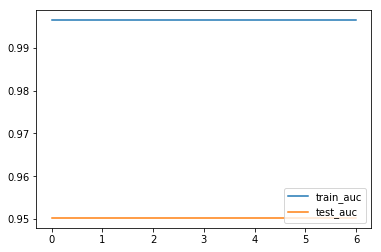

In [38]:
import matplotlib.pyplot as plt
x = sparse.csr_matrix(interactions.values)
model = LightFM( no_components=30, loss='warp', learning_schedule='adagrad')
epochs=[10,20,30,40,50,60,70]
train_auc = []
test_auc=[]

for epoch in epochs:
    print(epoch)
    model.fit(x,epochs=epoch,num_threads = 4)
    train_auc.append(auc_score(mf_model, sparse.csr_matrix(interactions.values)).mean())
    
for epoch in epochs:
    print(epoch)
    model.fit(x,epochs=epoch,num_threads = 4)
    test_auc.append(auc_score(mf_model, sparse.csr_matrix(interactions_test.values)).mean())

xx = np.arange(len(train_auc))
plt.plot(xx, np.array(train_auc))
plt.plot(xx, np.array(test_auc))
plt.legend(['train_auc', 'test_auc'], loc='lower right')
plt.show()


In [40]:
test_auc

[0.9502435, 0.9502435, 0.9502435, 0.9502435, 0.9502435, 0.9502435, 0.9502435]

In [37]:
train.head()

order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0       8.0     23423.0                1.0        1.0   3107.0    prior   
1      74.0     46667.0                1.0        1.0   3321.0    prior   
2      74.0     14129.0                2.0        1.0   3321.0    prior   
3      74.0     11136.0                3.0        1.0   3321.0    prior   
4      74.0     27247.0                4.0        1.0   3321.0    prior   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  
0           5.0        4.0                6.0                    17.0  
1          31.0        5.0               21.0                    14.0  
2          31.0        5.0               21.0                    14.0  
3          31.0        5.0               21.0                    14.0  
4          31.0        5.0               21.0                    14.0

In [38]:
conditions_train= [
    (train['order_hour_of_day'] >= 0) & (train['order_hour_of_day'] < 6),
    (train['order_hour_of_day'] >= 6) & (train['order_hour_of_day'] < 9),
    (train['order_hour_of_day'] >= 9) & (train['order_hour_of_day'] < 12),
    (train['order_hour_of_day'] >= 12) & (train['order_hour_of_day'] < 15),
    (train['order_hour_of_day'] >= 15) & (train['order_hour_of_day'] < 18),
    (train['order_hour_of_day'] >= 18) & (train['order_hour_of_day'] < 21),
    (train['order_hour_of_day'] >= 21) & (train['order_hour_of_day'] < 24)]

conditions_test= [
    (test['order_hour_of_day'] >= 0) & (test['order_hour_of_day'] < 6),
    (test['order_hour_of_day'] >= 6) & (test['order_hour_of_day'] < 9),
    (test['order_hour_of_day'] >= 9) & (test['order_hour_of_day'] < 12),
    (test['order_hour_of_day'] >= 12) & (test['order_hour_of_day'] < 15),
    (test['order_hour_of_day'] >= 15) & (test['order_hour_of_day'] < 18),
    (test['order_hour_of_day'] >= 18) & (test['order_hour_of_day'] < 21),
    (test['order_hour_of_day'] >= 21) & (test['order_hour_of_day'] < 24)]
choices = ['0.6', '6.9', '9.12', '12.15', '15.18', '18.21','21.23']
train['time_range'] = np.select(conditions_train, choices)
test['time_range'] = np.select(conditions_test, choices)


    
    
    
    
    

In [39]:
results=[]

for i in choices:
    print(i)
    train_i= train[train['time_range'] == i]
    test_i= test[test['time_range'] == i]
    
    set_users_test = set(np.unique(test_i.user_id))
    train_i = train_i[train_i['user_id'].isin(set_users_test)]
    set_users_train = set(np.unique(train_i.user_id))
    test_i = test_i[test_i['user_id'].isin(set_users_train)]
    

    
    set1 = set(np.unique(train_i.product_id))
    set2 = set(np.unique(test_i.product_id))

    missing =  pd.DataFrame.from_dict(list(sorted(set1 - set2)))
    added =  pd.DataFrame.from_dict(list(sorted(set2 - set1)))
    
    for i in range(len(missing)): 
        a=missing[0][i]
        print(a)
        test_i=test_i.append({'product_id': a},ignore_index=True)

    for i in range(len(added)): 
        a=added[0][i]
        print(a)
        train_i=train_i.append({'product_id': a},ignore_index=True)
    
    train_i=train_i.fillna(0)
    test_i=test_i.fillna(0)
    
    
    
    grouped_train_i = train_i.groupby(["user_id", "product_id"])["reordered"].aggregate("sum").reset_index()
    grouped_test_i = test_i.groupby(["user_id", "product_id"])["reordered"].aggregate("sum").reset_index()
    
    interactions_i = create_interaction_matrix(df = grouped_train_i,
                                         user_col = 'user_id',
                                         item_col = 'product_id',
                                         rating_col = 'reordered')
    
    interactions_test_i = create_interaction_matrix(df = grouped_test_i,
                                         user_col = 'user_id',
                                         item_col = 'product_id',
                                         rating_col = 'reordered')
    
    mf_model_i = runMF(interactions = interactions_i,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 5,
                 n_jobs = 4)

    print(np.shape(interactions_i))
    print(np.shape(interactions_test_i))
    train_precision = precision_at_k(mf_model_i, sparse.csr_matrix(interactions_i.values)).mean()
    test_precision = precision_at_k(mf_model_i, sparse.csr_matrix(interactions_test_i.values)).mean()

    train_auc = auc_score(mf_model_i, sparse.csr_matrix(interactions_i.values)).mean()
    test_auc = auc_score(mf_model_i, sparse.csr_matrix(interactions_test_i.values)).mean()

    train_recall = recall_at_k(mf_model_i, sparse.csr_matrix(interactions_i.values)).mean()
    test_recall = recall_at_k(mf_model_i, sparse.csr_matrix(interactions_test_i.values)).mean()
    
    f_train=2 * train_precision * train_recall / (train_precision + train_recall)
    f_test=2 * test_precision * test_recall / (test_precision + test_recall)
    results.append([i,train_precision,test_precision,train_auc, test_auc, train_recall,test_recall, f_train, f_test])
    

0.6
55.0
60.0
62.0
119.0
238.0
244.0
503.0
559.0
574.0
636.0
651.0
688.0
689.0
692.0
756.0
930.0
949.0
1025.0
1034.0
1200.0
1353.0
1412.0
1420.0
1440.0
1511.0
1529.0
1618.0
1667.0
1675.0
1687.0
1698.0
1700.0
1772.0
1830.0
1861.0
1954.0
1956.0
1959.0
1974.0
1982.0
2002.0
2037.0
2099.0
2154.0
2238.0
2331.0
2461.0
2491.0
2537.0
2539.0
2554.0
2561.0
2577.0
2590.0
2617.0
2621.0
2630.0
2773.0
2776.0
2861.0
2909.0
2918.0
3007.0
3009.0
3152.0
3180.0
3187.0
3244.0
3315.0
3328.0
3341.0
3489.0
3558.0
3599.0
3676.0
3743.0
3748.0
3808.0
3929.0
3938.0
3957.0
4070.0
4173.0
4180.0
4187.0
4362.0
4367.0
4441.0
4472.0
4475.0
4481.0
4498.0
4519.0
4535.0
4584.0
4617.0
4620.0
4639.0
4702.0
4789.0
4796.0
4869.0
4920.0
4932.0
4958.0
4962.0
4966.0
5003.0
5067.0
5104.0
5119.0
5273.0
5372.0
5406.0
5419.0
5460.0
5518.0
5569.0
5600.0
5681.0
5691.0
5705.0
5785.0
5792.0
5842.0
5845.0
5954.0
5963.0
5975.0
6172.0
6179.0
6274.0
6281.0
6347.0
6363.0
6397.0
6441.0
6473.0
6477.0
6510.0
6531.0
6631.0
6660.0
6712.0
6768.0
6

49481.0
49490.0
49533.0
49568.0
49573.0
49577.0
49674.0
7.0
12.0
13.0
18.0
27.0
31.0
35.0
36.0
37.0
38.0
40.0
43.0
46.0
47.0
51.0
52.0
53.0
57.0
59.0
65.0
66.0
81.0
97.0
102.0
106.0
107.0
108.0
111.0
113.0
115.0
118.0
127.0
130.0
132.0
133.0
134.0
138.0
140.0
144.0
145.0
146.0
149.0
150.0
152.0
157.0
158.0
167.0
173.0
176.0
179.0
181.0
184.0
185.0
186.0
188.0
190.0
193.0
194.0
199.0
200.0
203.0
205.0
206.0
209.0
212.0
216.0
219.0
223.0
232.0
233.0
234.0
237.0
242.0
243.0
246.0
253.0
254.0
255.0
262.0
263.0
265.0
266.0
267.0
270.0
271.0
275.0
281.0
282.0
284.0
285.0
286.0
288.0
290.0
291.0
293.0
299.0
303.0
305.0
306.0
307.0
315.0
321.0
322.0
328.0
330.0
333.0
334.0
335.0
337.0
338.0
339.0
342.0
348.0
351.0
352.0
355.0
358.0
360.0
361.0
362.0
364.0
366.0
371.0
376.0
377.0
378.0
380.0
383.0
386.0
387.0
388.0
391.0
393.0
394.0
396.0
400.0
401.0
406.0
411.0
412.0
418.0
422.0
425.0
427.0
428.0
431.0
433.0
434.0
443.0
445.0
446.0
448.0
453.0
456.0
462.0
466.0
467.0
468.0
471.0
476.0
477.0
47

4058.0
4059.0
4060.0
4062.0
4067.0
4069.0
4073.0
4080.0
4081.0
4086.0
4088.0
4090.0
4094.0
4095.0
4096.0
4098.0
4100.0
4103.0
4105.0
4111.0
4114.0
4116.0
4118.0
4124.0
4129.0
4132.0
4134.0
4135.0
4136.0
4140.0
4143.0
4153.0
4159.0
4160.0
4161.0
4164.0
4167.0
4168.0
4169.0
4174.0
4175.0
4176.0
4186.0
4194.0
4195.0
4202.0
4203.0
4205.0
4209.0
4213.0
4214.0
4216.0
4217.0
4218.0
4224.0
4227.0
4229.0
4231.0
4233.0
4236.0
4238.0
4247.0
4250.0
4251.0
4252.0
4253.0
4254.0
4261.0
4262.0
4263.0
4264.0
4265.0
4267.0
4268.0
4276.0
4281.0
4284.0
4287.0
4291.0
4293.0
4295.0
4298.0
4301.0
4302.0
4305.0
4311.0
4312.0
4321.0
4328.0
4329.0
4331.0
4334.0
4336.0
4337.0
4338.0
4339.0
4341.0
4342.0
4348.0
4351.0
4355.0
4361.0
4364.0
4365.0
4372.0
4373.0
4378.0
4380.0
4381.0
4382.0
4387.0
4388.0
4390.0
4394.0
4397.0
4399.0
4400.0
4401.0
4402.0
4404.0
4405.0
4406.0
4408.0
4411.0
4416.0
4425.0
4427.0
4431.0
4434.0
4437.0
4440.0
4442.0
4445.0
4446.0
4448.0
4452.0
4462.0
4463.0
4464.0
4467.0
4469.0
4474.0
4477.0

7770.0
7771.0
7772.0
7774.0
7775.0
7776.0
7777.0
7780.0
7783.0
7784.0
7785.0
7789.0
7795.0
7799.0
7801.0
7807.0
7808.0
7811.0
7813.0
7819.0
7827.0
7828.0
7830.0
7832.0
7834.0
7838.0
7842.0
7845.0
7847.0
7849.0
7851.0
7857.0
7861.0
7864.0
7865.0
7871.0
7875.0
7879.0
7882.0
7884.0
7886.0
7890.0
7892.0
7894.0
7895.0
7903.0
7905.0
7912.0
7918.0
7919.0
7922.0
7923.0
7924.0
7927.0
7929.0
7932.0
7933.0
7936.0
7937.0
7939.0
7947.0
7951.0
7952.0
7954.0
7966.0
7970.0
7972.0
7975.0
7976.0
7979.0
7980.0
7983.0
7988.0
7990.0
7991.0
7997.0
7998.0
8000.0
8001.0
8008.0
8011.0
8014.0
8016.0
8017.0
8023.0
8026.0
8027.0
8029.0
8032.0
8033.0
8039.0
8042.0
8044.0
8045.0
8052.0
8059.0
8064.0
8071.0
8077.0
8079.0
8080.0
8088.0
8089.0
8095.0
8098.0
8101.0
8106.0
8109.0
8111.0
8116.0
8117.0
8118.0
8121.0
8125.0
8126.0
8127.0
8136.0
8137.0
8141.0
8144.0
8146.0
8150.0
8151.0
8152.0
8154.0
8155.0
8167.0
8169.0
8171.0
8172.0
8176.0
8179.0
8184.0
8185.0
8186.0
8191.0
8193.0
8198.0
8200.0
8205.0
8209.0
8212.0
8216.0

11226.0
11229.0
11230.0
11231.0
11234.0
11236.0
11240.0
11245.0
11248.0
11249.0
11253.0
11257.0
11261.0
11267.0
11271.0
11275.0
11278.0
11283.0
11287.0
11289.0
11292.0
11297.0
11303.0
11304.0
11306.0
11307.0
11313.0
11314.0
11322.0
11325.0
11327.0
11334.0
11335.0
11344.0
11345.0
11347.0
11350.0
11353.0
11355.0
11358.0
11362.0
11364.0
11366.0
11369.0
11371.0
11374.0
11375.0
11377.0
11378.0
11379.0
11385.0
11386.0
11387.0
11389.0
11390.0
11392.0
11394.0
11395.0
11397.0
11398.0
11399.0
11400.0
11403.0
11412.0
11417.0
11418.0
11423.0
11424.0
11428.0
11429.0
11432.0
11433.0
11435.0
11436.0
11438.0
11441.0
11449.0
11450.0
11453.0
11455.0
11460.0
11464.0
11468.0
11469.0
11470.0
11472.0
11475.0
11477.0
11478.0
11495.0
11502.0
11504.0
11505.0
11511.0
11512.0
11524.0
11527.0
11529.0
11533.0
11543.0
11544.0
11549.0
11554.0
11556.0
11560.0
11561.0
11564.0
11570.0
11572.0
11586.0
11594.0
11595.0
11597.0
11605.0
11606.0
11610.0
11611.0
11613.0
11615.0
11621.0
11623.0
11636.0
11638.0
11640.0
11642.0


14313.0
14318.0
14319.0
14324.0
14325.0
14326.0
14328.0
14330.0
14331.0
14333.0
14334.0
14337.0
14338.0
14344.0
14346.0
14349.0
14350.0
14351.0
14352.0
14354.0
14357.0
14359.0
14360.0
14363.0
14365.0
14369.0
14370.0
14375.0
14377.0
14383.0
14385.0
14392.0
14394.0
14398.0
14400.0
14403.0
14408.0
14409.0
14416.0
14417.0
14418.0
14427.0
14429.0
14433.0
14434.0
14436.0
14439.0
14443.0
14445.0
14448.0
14452.0
14453.0
14454.0
14455.0
14456.0
14458.0
14459.0
14461.0
14464.0
14468.0
14469.0
14470.0
14473.0
14476.0
14479.0
14481.0
14483.0
14490.0
14498.0
14499.0
14500.0
14501.0
14506.0
14509.0
14510.0
14511.0
14514.0
14515.0
14520.0
14521.0
14524.0
14529.0
14534.0
14539.0
14542.0
14548.0
14551.0
14552.0
14554.0
14555.0
14556.0
14557.0
14558.0
14565.0
14569.0
14571.0
14577.0
14578.0
14579.0
14580.0
14586.0
14596.0
14602.0
14603.0
14604.0
14610.0
14611.0
14618.0
14621.0
14624.0
14626.0
14631.0
14632.0
14636.0
14637.0
14639.0
14642.0
14652.0
14653.0
14654.0
14656.0
14658.0
14659.0
14660.0
14664.0


17276.0
17287.0
17288.0
17292.0
17294.0
17295.0
17296.0
17300.0
17302.0
17303.0
17306.0
17307.0
17310.0
17314.0
17315.0
17320.0
17324.0
17325.0
17329.0
17330.0
17336.0
17337.0
17338.0
17340.0
17342.0
17344.0
17345.0
17348.0
17350.0
17351.0
17357.0
17358.0
17362.0
17363.0
17364.0
17372.0
17374.0
17376.0
17377.0
17378.0
17381.0
17383.0
17389.0
17392.0
17393.0
17395.0
17396.0
17397.0
17398.0
17399.0
17402.0
17406.0
17407.0
17410.0
17415.0
17417.0
17418.0
17420.0
17421.0
17425.0
17427.0
17431.0
17433.0
17438.0
17440.0
17443.0
17444.0
17450.0
17452.0
17453.0
17457.0
17463.0
17464.0
17465.0
17471.0
17473.0
17475.0
17476.0
17477.0
17482.0
17485.0
17489.0
17498.0
17501.0
17502.0
17504.0
17506.0
17507.0
17508.0
17509.0
17511.0
17512.0
17514.0
17516.0
17518.0
17520.0
17523.0
17532.0
17546.0
17547.0
17551.0
17557.0
17560.0
17561.0
17562.0
17564.0
17565.0
17570.0
17571.0
17572.0
17573.0
17574.0
17576.0
17577.0
17580.0
17582.0
17584.0
17587.0
17590.0
17591.0
17593.0
17596.0
17598.0
17599.0
17601.0


20468.0
20469.0
20470.0
20473.0
20482.0
20485.0
20488.0
20489.0
20490.0
20491.0
20494.0
20496.0
20498.0
20500.0
20504.0
20507.0
20510.0
20513.0
20523.0
20524.0
20526.0
20527.0
20528.0
20529.0
20531.0
20532.0
20533.0
20536.0
20537.0
20539.0
20541.0
20547.0
20551.0
20553.0
20554.0
20557.0
20559.0
20562.0
20563.0
20567.0
20573.0
20575.0
20578.0
20584.0
20587.0
20591.0
20595.0
20596.0
20599.0
20601.0
20611.0
20619.0
20628.0
20634.0
20638.0
20640.0
20641.0
20643.0
20645.0
20646.0
20647.0
20648.0
20651.0
20654.0
20656.0
20657.0
20659.0
20662.0
20665.0
20667.0
20669.0
20672.0
20674.0
20676.0
20679.0
20683.0
20685.0
20694.0
20697.0
20698.0
20700.0
20703.0
20704.0
20706.0
20709.0
20712.0
20720.0
20728.0
20729.0
20740.0
20742.0
20743.0
20747.0
20752.0
20760.0
20761.0
20762.0
20763.0
20765.0
20766.0
20768.0
20770.0
20774.0
20778.0
20781.0
20789.0
20796.0
20803.0
20805.0
20807.0
20810.0
20816.0
20821.0
20823.0
20827.0
20832.0
20833.0
20836.0
20837.0
20840.0
20844.0
20845.0
20850.0
20851.0
20853.0


23737.0
23745.0
23751.0
23756.0
23757.0
23759.0
23763.0
23764.0
23768.0
23769.0
23776.0
23777.0
23786.0
23788.0
23791.0
23795.0
23798.0
23802.0
23806.0
23809.0
23811.0
23814.0
23818.0
23829.0
23831.0
23832.0
23833.0
23836.0
23838.0
23840.0
23841.0
23842.0
23846.0
23850.0
23852.0
23859.0
23862.0
23866.0
23868.0
23870.0
23874.0
23878.0
23880.0
23881.0
23884.0
23886.0
23889.0
23894.0
23896.0
23897.0
23900.0
23905.0
23907.0
23909.0
23910.0
23914.0
23916.0
23917.0
23922.0
23924.0
23926.0
23927.0
23928.0
23929.0
23931.0
23933.0
23937.0
23938.0
23939.0
23943.0
23945.0
23952.0
23958.0
23962.0
23967.0
23969.0
23975.0
23980.0
23981.0
23983.0
23984.0
23987.0
23989.0
23990.0
23996.0
24002.0
24003.0
24004.0
24008.0
24012.0
24017.0
24018.0
24019.0
24020.0
24025.0
24026.0
24030.0
24033.0
24034.0
24038.0
24040.0
24041.0
24044.0
24055.0
24056.0
24065.0
24066.0
24068.0
24073.0
24077.0
24079.0
24081.0
24084.0
24090.0
24093.0
24094.0
24109.0
24114.0
24116.0
24118.0
24122.0
24124.0
24126.0
24131.0
24133.0


26804.0
26805.0
26812.0
26814.0
26824.0
26828.0
26831.0
26832.0
26834.0
26837.0
26838.0
26845.0
26851.0
26854.0
26859.0
26860.0
26862.0
26864.0
26869.0
26871.0
26872.0
26873.0
26876.0
26877.0
26878.0
26885.0
26892.0
26895.0
26896.0
26897.0
26899.0
26902.0
26903.0
26904.0
26905.0
26907.0
26909.0
26915.0
26916.0
26917.0
26921.0
26927.0
26929.0
26930.0
26931.0
26935.0
26938.0
26939.0
26941.0
26946.0
26962.0
26968.0
26970.0
26972.0
26976.0
26977.0
26978.0
26980.0
26984.0
26987.0
26988.0
26994.0
26995.0
26996.0
26999.0
27001.0
27004.0
27005.0
27006.0
27007.0
27008.0
27018.0
27022.0
27023.0
27024.0
27025.0
27027.0
27030.0
27033.0
27034.0
27035.0
27036.0
27040.0
27041.0
27047.0
27051.0
27052.0
27056.0
27057.0
27062.0
27064.0
27066.0
27067.0
27068.0
27069.0
27075.0
27078.0
27080.0
27088.0
27092.0
27098.0
27101.0
27113.0
27115.0
27118.0
27120.0
27123.0
27124.0
27125.0
27126.0
27130.0
27131.0
27132.0
27135.0
27137.0
27138.0
27140.0
27143.0
27145.0
27150.0
27151.0
27160.0
27161.0
27162.0
27163.0


29942.0
29943.0
29944.0
29946.0
29950.0
29956.0
29959.0
29960.0
29965.0
29967.0
29968.0
29970.0
29975.0
29976.0
29978.0
29983.0
29988.0
29998.0
30000.0
30005.0
30007.0
30010.0
30013.0
30014.0
30015.0
30017.0
30018.0
30019.0
30022.0
30023.0
30030.0
30035.0
30038.0
30041.0
30043.0
30045.0
30047.0
30058.0
30059.0
30062.0
30063.0
30067.0
30078.0
30082.0
30086.0
30092.0
30098.0
30105.0
30107.0
30109.0
30119.0
30121.0
30123.0
30127.0
30130.0
30132.0
30133.0
30137.0
30143.0
30151.0
30155.0
30159.0
30161.0
30165.0
30174.0
30175.0
30177.0
30179.0
30182.0
30186.0
30187.0
30189.0
30190.0
30193.0
30195.0
30196.0
30198.0
30202.0
30204.0
30206.0
30212.0
30218.0
30220.0
30226.0
30230.0
30234.0
30235.0
30238.0
30242.0
30245.0
30247.0
30250.0
30259.0
30260.0
30264.0
30267.0
30268.0
30269.0
30271.0
30272.0
30273.0
30276.0
30277.0
30280.0
30282.0
30285.0
30287.0
30294.0
30295.0
30297.0
30300.0
30305.0
30311.0
30312.0
30314.0
30316.0
30319.0
30325.0
30328.0
30330.0
30334.0
30345.0
30347.0
30348.0
30350.0


33250.0
33252.0
33255.0
33258.0
33261.0
33264.0
33265.0
33269.0
33270.0
33272.0
33273.0
33276.0
33278.0
33280.0
33288.0
33291.0
33295.0
33297.0
33301.0
33302.0
33305.0
33309.0
33310.0
33313.0
33315.0
33317.0
33319.0
33322.0
33324.0
33325.0
33326.0
33327.0
33333.0
33334.0
33336.0
33337.0
33338.0
33339.0
33343.0
33346.0
33353.0
33354.0
33356.0
33358.0
33359.0
33362.0
33363.0
33367.0
33376.0
33380.0
33384.0
33389.0
33392.0
33394.0
33397.0
33399.0
33402.0
33404.0
33411.0
33413.0
33415.0
33416.0
33419.0
33420.0
33427.0
33428.0
33433.0
33434.0
33437.0
33445.0
33446.0
33451.0
33454.0
33457.0
33460.0
33463.0
33466.0
33467.0
33471.0
33472.0
33473.0
33474.0
33476.0
33477.0
33479.0
33483.0
33490.0
33492.0
33494.0
33495.0
33499.0
33500.0
33502.0
33504.0
33509.0
33512.0
33513.0
33515.0
33516.0
33518.0
33519.0
33520.0
33525.0
33526.0
33535.0
33544.0
33547.0
33550.0
33552.0
33554.0
33556.0
33557.0
33558.0
33571.0
33574.0
33579.0
33583.0
33584.0
33586.0
33587.0
33588.0
33592.0
33593.0
33596.0
33600.0


36285.0
36291.0
36295.0
36301.0
36304.0
36310.0
36311.0
36316.0
36320.0
36322.0
36328.0
36329.0
36331.0
36333.0
36335.0
36337.0
36339.0
36342.0
36345.0
36349.0
36352.0
36353.0
36356.0
36358.0
36359.0
36361.0
36364.0
36365.0
36370.0
36372.0
36377.0
36379.0
36383.0
36384.0
36385.0
36394.0
36396.0
36398.0
36400.0
36403.0
36404.0
36411.0
36414.0
36418.0
36420.0
36423.0
36424.0
36426.0
36436.0
36438.0
36441.0
36442.0
36448.0
36451.0
36460.0
36462.0
36464.0
36465.0
36467.0
36471.0
36473.0
36477.0
36479.0
36480.0
36482.0
36484.0
36486.0
36487.0
36491.0
36493.0
36498.0
36499.0
36505.0
36511.0
36512.0
36515.0
36516.0
36523.0
36527.0
36528.0
36531.0
36532.0
36537.0
36543.0
36547.0
36548.0
36550.0
36552.0
36553.0
36554.0
36555.0
36557.0
36560.0
36561.0
36562.0
36578.0
36583.0
36584.0
36588.0
36592.0
36594.0
36598.0
36599.0
36601.0
36602.0
36603.0
36604.0
36607.0
36608.0
36609.0
36612.0
36613.0
36615.0
36619.0
36624.0
36625.0
36632.0
36634.0
36635.0
36637.0
36639.0
36641.0
36644.0
36648.0
36649.0


39418.0
39420.0
39421.0
39422.0
39423.0
39424.0
39426.0
39431.0
39432.0
39436.0
39442.0
39443.0
39444.0
39445.0
39446.0
39451.0
39452.0
39454.0
39458.0
39461.0
39467.0
39471.0
39473.0
39477.0
39479.0
39480.0
39481.0
39482.0
39486.0
39487.0
39494.0
39496.0
39497.0
39503.0
39508.0
39513.0
39517.0
39518.0
39529.0
39536.0
39537.0
39539.0
39544.0
39551.0
39552.0
39553.0
39555.0
39559.0
39562.0
39563.0
39566.0
39567.0
39568.0
39570.0
39573.0
39575.0
39576.0
39579.0
39587.0
39588.0
39599.0
39601.0
39609.0
39613.0
39615.0
39616.0
39618.0
39623.0
39630.0
39631.0
39632.0
39635.0
39640.0
39642.0
39643.0
39647.0
39654.0
39656.0
39661.0
39664.0
39670.0
39680.0
39702.0
39704.0
39705.0
39706.0
39707.0
39710.0
39712.0
39716.0
39723.0
39727.0
39729.0
39736.0
39742.0
39743.0
39745.0
39747.0
39748.0
39750.0
39751.0
39760.0
39761.0
39764.0
39765.0
39766.0
39767.0
39769.0
39770.0
39771.0
39772.0
39773.0
39774.0
39780.0
39783.0
39785.0
39790.0
39792.0
39796.0
39802.0
39814.0
39815.0
39818.0
39820.0
39821.0


42574.0
42578.0
42580.0
42582.0
42587.0
42591.0
42592.0
42599.0
42601.0
42602.0
42603.0
42608.0
42609.0
42610.0
42614.0
42619.0
42622.0
42623.0
42626.0
42627.0
42631.0
42632.0
42639.0
42640.0
42643.0
42646.0
42652.0
42654.0
42655.0
42658.0
42660.0
42662.0
42666.0
42667.0
42671.0
42674.0
42681.0
42685.0
42686.0
42688.0
42689.0
42690.0
42693.0
42694.0
42695.0
42696.0
42700.0
42702.0
42711.0
42714.0
42718.0
42732.0
42737.0
42738.0
42741.0
42744.0
42749.0
42752.0
42754.0
42756.0
42758.0
42760.0
42762.0
42763.0
42766.0
42769.0
42770.0
42771.0
42772.0
42776.0
42787.0
42789.0
42791.0
42798.0
42801.0
42804.0
42806.0
42809.0
42812.0
42813.0
42814.0
42818.0
42819.0
42824.0
42827.0
42829.0
42833.0
42835.0
42837.0
42838.0
42845.0
42848.0
42852.0
42853.0
42858.0
42859.0
42861.0
42862.0
42864.0
42865.0
42867.0
42868.0
42870.0
42871.0
42878.0
42879.0
42881.0
42882.0
42883.0
42884.0
42888.0
42891.0
42892.0
42894.0
42896.0
42897.0
42912.0
42914.0
42915.0
42916.0
42918.0
42919.0
42927.0
42932.0
42935.0


45782.0
45783.0
45786.0
45789.0
45791.0
45794.0
45795.0
45797.0
45799.0
45800.0
45801.0
45804.0
45805.0
45807.0
45810.0
45816.0
45817.0
45822.0
45828.0
45829.0
45830.0
45831.0
45833.0
45836.0
45841.0
45846.0
45848.0
45849.0
45858.0
45863.0
45864.0
45865.0
45869.0
45870.0
45871.0
45875.0
45877.0
45878.0
45879.0
45885.0
45891.0
45894.0
45898.0
45903.0
45913.0
45914.0
45915.0
45917.0
45918.0
45926.0
45932.0
45933.0
45942.0
45950.0
45953.0
45955.0
45958.0
45959.0
45968.0
45969.0
45974.0
45979.0
45983.0
45984.0
45985.0
45988.0
45989.0
45994.0
45996.0
45998.0
46002.0
46003.0
46004.0
46006.0
46007.0
46010.0
46013.0
46021.0
46022.0
46024.0
46025.0
46032.0
46035.0
46040.0
46042.0
46052.0
46053.0
46054.0
46069.0
46072.0
46074.0
46077.0
46079.0
46081.0
46082.0
46086.0
46089.0
46093.0
46095.0
46096.0
46097.0
46098.0
46104.0
46105.0
46109.0
46113.0
46117.0
46126.0
46127.0
46132.0
46133.0
46134.0
46135.0
46137.0
46140.0
46141.0
46144.0
46148.0
46155.0
46156.0
46157.0
46159.0
46162.0
46163.0
46164.0


48867.0
48868.0
48869.0
48873.0
48876.0
48877.0
48878.0
48885.0
48888.0
48891.0
48892.0
48895.0
48898.0
48903.0
48904.0
48905.0
48908.0
48914.0
48915.0
48916.0
48919.0
48922.0
48923.0
48931.0
48936.0
48938.0
48939.0
48942.0
48944.0
48945.0
48948.0
48950.0
48961.0
48964.0
48965.0
48972.0
48976.0
48981.0
48983.0
48984.0
48986.0
48987.0
48995.0
49002.0
49003.0
49011.0
49017.0
49018.0
49021.0
49025.0
49028.0
49031.0
49032.0
49035.0
49036.0
49038.0
49051.0
49052.0
49053.0
49056.0
49061.0
49069.0
49071.0
49090.0
49093.0
49099.0
49101.0
49103.0
49107.0
49110.0
49111.0
49121.0
49122.0
49123.0
49126.0
49129.0
49132.0
49134.0
49135.0
49137.0
49140.0
49145.0
49151.0
49153.0
49156.0
49161.0
49164.0
49165.0
49169.0
49172.0
49173.0
49174.0
49182.0
49183.0
49184.0
49186.0
49188.0
49189.0
49193.0
49195.0
49199.0
49202.0
49207.0
49216.0
49217.0
49220.0
49221.0
49226.0
49237.0
49239.0
49243.0
49244.0
49245.0
49249.0
49254.0
49258.0
49265.0
49270.0
49271.0
49272.0
49275.0
49276.0
49277.0
49283.0
49287.0


15718.0
15740.0
15744.0
15755.0
15761.0
15765.0
15782.0
15785.0
15803.0
15820.0
15829.0
15848.0
15892.0
15895.0
15899.0
15904.0
15925.0
15937.0
15950.0
15968.0
15976.0
15984.0
15995.0
15999.0
16042.0
16083.0
16156.0
16170.0
16210.0
16221.0
16249.0
16254.0
16260.0
16262.0
16278.0
16283.0
16320.0
16325.0
16327.0
16363.0
16393.0
16419.0
16460.0
16462.0
16464.0
16492.0
16516.0
16523.0
16525.0
16528.0
16552.0
16556.0
16589.0
16593.0
16609.0
16616.0
16641.0
16642.0
16668.0
16670.0
16696.0
16709.0
16710.0
16711.0
16712.0
16726.0
16732.0
16745.0
16752.0
16771.0
16803.0
16816.0
16824.0
16830.0
16834.0
16837.0
16840.0
16882.0
16893.0
16899.0
16965.0
16973.0
16995.0
17002.0
17008.0
17025.0
17145.0
17155.0
17159.0
17173.0
17177.0
17181.0
17197.0
17206.0
17209.0
17264.0
17275.0
17284.0
17300.0
17316.0
17339.0
17345.0
17355.0
17358.0
17400.0
17435.0
17511.0
17520.0
17553.0
17560.0
17568.0
17579.0
17596.0
17631.0
17640.0
17650.0
17652.0
17666.0
17691.0
17738.0
17741.0
17769.0
17795.0
17828.0
17830.0


34005.0
34012.0
34024.0
34044.0
34055.0
34065.0
34067.0
34092.0
34128.0
34137.0
34148.0
34199.0
34203.0
34208.0
34217.0
34244.0
34254.0
34257.0
34262.0
34300.0
34305.0
34329.0
34343.0
34368.0
34369.0
34386.0
34401.0
34423.0
34429.0
34445.0
34449.0
34450.0
34454.0
34458.0
34459.0
34480.0
34492.0
34496.0
34497.0
34502.0
34524.0
34525.0
34530.0
34534.0
34565.0
34566.0
34582.0
34584.0
34590.0
34605.0
34608.0
34619.0
34640.0
34650.0
34668.0
34677.0
34702.0
34717.0
34735.0
34743.0
34749.0
34778.0
34824.0
34861.0
34862.0
34878.0
34883.0
34894.0
34898.0
34909.0
34927.0
34956.0
34975.0
34982.0
34991.0
34993.0
35038.0
35068.0
35072.0
35078.0
35079.0
35091.0
35121.0
35166.0
35168.0
35172.0
35234.0
35264.0
35267.0
35286.0
35306.0
35307.0
35328.0
35339.0
35342.0
35364.0
35400.0
35418.0
35458.0
35505.0
35507.0
35510.0
35530.0
35537.0
35544.0
35601.0
35622.0
35628.0
35669.0
35682.0
35688.0
35721.0
35723.0
35725.0
35731.0
35749.0
35752.0
35777.0
35782.0
35786.0
35793.0
35819.0
35823.0
35842.0
35855.0


20754.0
20852.0
20896.0
20919.0
20930.0
20998.0
21009.0
21194.0
21195.0
21261.0
21303.0
21330.0
21376.0
21461.0
21464.0
21512.0
21554.0
21783.0
21927.0
21982.0
22031.0
22114.0
22141.0
22206.0
22212.0
22227.0
22307.0
22436.0
22497.0
22556.0
22666.0
22764.0
22781.0
22912.0
23026.0
23288.0
23322.0
23423.0
23424.0
23438.0
23716.0
23731.0
23765.0
23803.0
23826.0
23888.0
23892.0
23959.0
24035.0
24059.0
24117.0
24269.0
24482.0
24521.0
24545.0
24622.0
24643.0
24703.0
24854.0
24890.0
25005.0
25086.0
25093.0
25122.0
25232.0
25341.0
25506.0
25533.0
25553.0
25670.0
25718.0
25753.0
25767.0
25783.0
25877.0
25936.0
25965.0
26171.0
26280.0
26343.0
26349.0
26456.0
26751.0
26826.0
26861.0
26985.0
27010.0
27177.0
27744.0
27761.0
27772.0
27790.0
27794.0
27900.0
27963.0
28038.0
28058.0
28132.0
28145.0
28146.0
28211.0
28227.0
28413.0
28459.0
28519.0
28836.0
29007.0
29057.0
29091.0
29126.0
29223.0
29387.0
29503.0
29646.0
29660.0
29705.0
29801.0
29912.0
29974.0
29980.0
30007.0
30027.0
30066.0
30069.0
30106.0


6374.0
6381.0
6385.0
6396.0
6399.0
6407.0
6410.0
6414.0
6422.0
6436.0
6438.0
6455.0
6492.0
6500.0
6506.0
6508.0
6518.0
6519.0
6543.0
6552.0
6555.0
6567.0
6571.0
6575.0
6576.0
6583.0
6585.0
6587.0
6593.0
6604.0
6606.0
6609.0
6615.0
6635.0
6638.0
6646.0
6647.0
6651.0
6664.0
6690.0
6727.0
6734.0
6736.0
6741.0
6747.0
6748.0
6750.0
6758.0
6760.0
6767.0
6778.0
6788.0
6795.0
6799.0
6808.0
6811.0
6813.0
6829.0
6835.0
6837.0
6844.0
6852.0
6878.0
6890.0
6899.0
6902.0
6916.0
6927.0
6962.0
6970.0
6971.0
6978.0
6982.0
6987.0
6991.0
6999.0
7009.0
7029.0
7040.0
7041.0
7043.0
7046.0
7051.0
7057.0
7058.0
7069.0
7090.0
7116.0
7130.0
7134.0
7139.0
7146.0
7151.0
7156.0
7166.0
7173.0
7177.0
7186.0
7189.0
7202.0
7212.0
7224.0
7228.0
7239.0
7249.0
7252.0
7253.0
7255.0
7300.0
7308.0
7314.0
7315.0
7321.0
7332.0
7338.0
7345.0
7358.0
7364.0
7393.0
7405.0
7431.0
7443.0
7450.0
7451.0
7470.0
7472.0
7477.0
7480.0
7493.0
7522.0
7530.0
7532.0
7533.0
7538.0
7539.0
7543.0
7546.0
7562.0
7569.0
7577.0
7579.0
7597.0
7600.0

15672.0
15673.0
15675.0
15683.0
15693.0
15694.0
15700.0
15709.0
15712.0
15719.0
15727.0
15728.0
15742.0
15761.0
15765.0
15788.0
15801.0
15803.0
15809.0
15831.0
15835.0
15841.0
15848.0
15855.0
15866.0
15885.0
15891.0
15892.0
15905.0
15906.0
15913.0
15923.0
15924.0
15933.0
15943.0
15945.0
15948.0
15958.0
15959.0
15969.0
15974.0
15975.0
15976.0
16004.0
16013.0
16014.0
16031.0
16033.0
16044.0
16046.0
16048.0
16066.0
16096.0
16097.0
16131.0
16133.0
16135.0
16136.0
16137.0
16139.0
16142.0
16143.0
16152.0
16169.0
16174.0
16215.0
16220.0
16221.0
16235.0
16237.0
16268.0
16271.0
16275.0
16277.0
16289.0
16295.0
16296.0
16311.0
16350.0
16363.0
16365.0
16384.0
16387.0
16393.0
16405.0
16414.0
16415.0
16417.0
16419.0
16423.0
16432.0
16445.0
16446.0
16452.0
16454.0
16464.0
16471.0
16479.0
16482.0
16486.0
16494.0
16511.0
16518.0
16522.0
16525.0
16528.0
16540.0
16549.0
16552.0
16555.0
16564.0
16570.0
16575.0
16593.0
16595.0
16609.0
16613.0
16615.0
16619.0
16637.0
16641.0
16643.0
16669.0
16680.0
16683.0


24827.0
24846.0
24850.0
24858.0
24859.0
24876.0
24915.0
24920.0
24925.0
24933.0
24940.0
24943.0
24946.0
24950.0
24952.0
24955.0
24957.0
24959.0
24966.0
24967.0
24971.0
24973.0
24976.0
24990.0
25000.0
25031.0
25048.0
25050.0
25055.0
25070.0
25089.0
25095.0
25110.0
25122.0
25126.0
25144.0
25152.0
25157.0
25160.0
25190.0
25191.0
25194.0
25195.0
25199.0
25217.0
25223.0
25225.0
25230.0
25237.0
25244.0
25247.0
25249.0
25275.0
25288.0
25290.0
25304.0
25307.0
25316.0
25320.0
25330.0
25332.0
25334.0
25340.0
25346.0
25348.0
25350.0
25353.0
25355.0
25361.0
25363.0
25367.0
25370.0
25371.0
25378.0
25387.0
25393.0
25396.0
25425.0
25433.0
25435.0
25442.0
25443.0
25461.0
25464.0
25469.0
25472.0
25477.0
25478.0
25489.0
25493.0
25506.0
25521.0
25522.0
25527.0
25530.0
25533.0
25535.0
25539.0
25546.0
25547.0
25567.0
25569.0
25577.0
25581.0
25587.0
25598.0
25602.0
25604.0
25612.0
25619.0
25623.0
25630.0
25634.0
25640.0
25648.0
25670.0
25691.0
25696.0
25704.0
25707.0
25715.0
25727.0
25732.0
25740.0
25743.0


33184.0
33195.0
33200.0
33206.0
33212.0
33214.0
33215.0
33221.0
33241.0
33243.0
33249.0
33258.0
33264.0
33272.0
33276.0
33288.0
33313.0
33333.0
33342.0
33351.0
33354.0
33357.0
33364.0
33368.0
33370.0
33373.0
33379.0
33385.0
33391.0
33399.0
33407.0
33438.0
33443.0
33454.0
33457.0
33462.0
33463.0
33467.0
33489.0
33495.0
33497.0
33504.0
33509.0
33516.0
33518.0
33520.0
33521.0
33526.0
33544.0
33547.0
33548.0
33557.0
33588.0
33593.0
33615.0
33623.0
33636.0
33642.0
33643.0
33663.0
33673.0
33674.0
33686.0
33690.0
33701.0
33704.0
33706.0
33708.0
33716.0
33719.0
33720.0
33724.0
33729.0
33735.0
33736.0
33740.0
33741.0
33745.0
33746.0
33747.0
33757.0
33761.0
33776.0
33791.0
33793.0
33810.0
33827.0
33845.0
33847.0
33857.0
33863.0
33873.0
33897.0
33900.0
33908.0
33909.0
33913.0
33919.0
33924.0
33950.0
33953.0
33957.0
33964.0
33973.0
33974.0
33977.0
34012.0
34014.0
34036.0
34049.0
34055.0
34063.0
34069.0
34072.0
34076.0
34096.0
34099.0
34107.0
34111.0
34137.0
34140.0
34144.0
34148.0
34160.0
34163.0


41812.0
41831.0
41832.0
41834.0
41840.0
41845.0
41862.0
41863.0
41869.0
41877.0
41885.0
41890.0
41897.0
41904.0
41917.0
41921.0
41941.0
41951.0
41959.0
41965.0
41969.0
41984.0
41990.0
42013.0
42016.0
42028.0
42049.0
42052.0
42059.0
42063.0
42105.0
42117.0
42121.0
42142.0
42145.0
42148.0
42149.0
42170.0
42174.0
42183.0
42185.0
42189.0
42193.0
42224.0
42234.0
42243.0
42248.0
42252.0
42255.0
42258.0
42263.0
42269.0
42282.0
42294.0
42296.0
42297.0
42309.0
42315.0
42317.0
42323.0
42347.0
42357.0
42364.0
42366.0
42380.0
42392.0
42404.0
42421.0
42432.0
42441.0
42443.0
42447.0
42460.0
42462.0
42469.0
42477.0
42502.0
42503.0
42507.0
42508.0
42509.0
42529.0
42535.0
42551.0
42579.0
42591.0
42598.0
42606.0
42612.0
42613.0
42629.0
42637.0
42644.0
42659.0
42667.0
42669.0
42671.0
42677.0
42681.0
42686.0
42696.0
42699.0
42706.0
42710.0
42711.0
42728.0
42731.0
42733.0
42737.0
42744.0
42752.0
42756.0
42762.0
42770.0
42798.0
42804.0
42811.0
42813.0
42814.0
42824.0
42833.0
42858.0
42887.0
42891.0
42897.0


5003.0
5104.0
5132.0
5144.0
5201.0
5268.0
5273.0
5275.0
5334.0
5362.0
5372.0
5374.0
5388.0
5419.0
5457.0
5463.0
5506.0
5514.0
5535.0
5681.0
5771.0
5808.0
5812.0
5858.0
5913.0
5914.0
5947.0
5969.0
6139.0
6140.0
6153.0
6236.0
6309.0
6391.0
6402.0
6475.0
6477.0
6497.0
6510.0
6522.0
6569.0
6617.0
6679.0
6686.0
6712.0
6765.0
6793.0
6867.0
6871.0
6884.0
6931.0
6935.0
6976.0
6994.0
7128.0
7150.0
7165.0
7260.0
7264.0
7325.0
7349.0
7383.0
7391.0
7394.0
7468.0
7474.0
7499.0
7548.0
7571.0
7598.0
7705.0
7734.0
7812.0
7826.0
7863.0
8007.0
8028.0
8140.0
8143.0
8158.0
8180.0
8181.0
8275.0
8305.0
8372.0
8386.0
8390.0
8414.0
8425.0
8428.0
8450.0
8484.0
8501.0
8519.0
8524.0
8596.0
8668.0
8774.0
8781.0
8800.0
8834.0
8922.0
8960.0
8989.0
8996.0
9068.0
9121.0
9326.0
9363.0
9429.0
9466.0
9470.0
9493.0
9495.0
9573.0
9578.0
9595.0
9708.0
9710.0
9734.0
9761.0
9786.0
9849.0
9972.0
9990.0
10005.0
10045.0
10077.0
10121.0
10313.0
10374.0
10403.0
10446.0
10521.0
10528.0
10570.0
10574.0
10671.0
10804.0
10834.0
10856

546.0
554.0
557.0
584.0
611.0
614.0
615.0
625.0
633.0
671.0
673.0
705.0
712.0
717.0
722.0
726.0
730.0
740.0
755.0
757.0
758.0
763.0
775.0
777.0
778.0
780.0
790.0
810.0
813.0
828.0
853.0
854.0
863.0
879.0
884.0
895.0
899.0
903.0
927.0
952.0
969.0
972.0
990.0
1000.0
1005.0
1015.0
1025.0
1035.0
1036.0
1049.0
1076.0
1087.0
1090.0
1103.0
1111.0
1130.0
1134.0
1142.0
1148.0
1157.0
1162.0
1183.0
1202.0
1228.0
1231.0
1240.0
1241.0
1282.0
1308.0
1318.0
1330.0
1332.0
1335.0
1347.0
1356.0
1360.0
1374.0
1376.0
1377.0
1390.0
1392.0
1396.0
1398.0
1405.0
1416.0
1440.0
1447.0
1449.0
1450.0
1467.0
1468.0
1471.0
1488.0
1503.0
1522.0
1525.0
1543.0
1546.0
1558.0
1565.0
1574.0
1598.0
1616.0
1621.0
1631.0
1639.0
1640.0
1658.0
1671.0
1685.0
1704.0
1710.0
1711.0
1724.0
1726.0
1738.0
1747.0
1749.0
1757.0
1775.0
1783.0
1804.0
1811.0
1821.0
1824.0
1830.0
1835.0
1838.0
1841.0
1849.0
1866.0
1868.0
1871.0
1883.0
1891.0
1896.0
1902.0
1938.0
1947.0
1957.0
1960.0
1979.0
1983.0
1994.0
2002.0
2010.0
2015.0
2019.0
2024.0


10795.0
10807.0
10826.0
10834.0
10849.0
10851.0
10862.0
10867.0
10883.0
10892.0
10894.0
10897.0
10900.0
10909.0
10913.0
10915.0
10925.0
10933.0
10936.0
10938.0
10946.0
10970.0
10978.0
10991.0
10993.0
10995.0
10998.0
11000.0
11008.0
11014.0
11023.0
11024.0
11030.0
11035.0
11036.0
11050.0
11063.0
11069.0
11075.0
11076.0
11079.0
11080.0
11087.0
11096.0
11100.0
11107.0
11109.0
11121.0
11129.0
11143.0
11152.0
11162.0
11175.0
11187.0
11190.0
11195.0
11199.0
11203.0
11211.0
11212.0
11213.0
11215.0
11221.0
11222.0
11226.0
11247.0
11250.0
11262.0
11265.0
11266.0
11277.0
11281.0
11289.0
11306.0
11309.0
11314.0
11335.0
11364.0
11367.0
11379.0
11383.0
11385.0
11387.0
11421.0
11432.0
11435.0
11441.0
11452.0
11455.0
11463.0
11472.0
11484.0
11492.0
11497.0
11505.0
11511.0
11513.0
11574.0
11580.0
11597.0
11599.0
11605.0
11609.0
11610.0
11611.0
11614.0
11615.0
11619.0
11628.0
11659.0
11665.0
11666.0
11678.0
11679.0
11687.0
11696.0
11698.0
11699.0
11712.0
11715.0
11732.0
11737.0
11741.0
11755.0
11758.0


20247.0
20272.0
20274.0
20283.0
20294.0
20313.0
20319.0
20323.0
20327.0
20334.0
20339.0
20341.0
20345.0
20355.0
20361.0
20362.0
20383.0
20384.0
20390.0
20395.0
20398.0
20410.0
20428.0
20429.0
20431.0
20433.0
20437.0
20460.0
20463.0
20468.0
20489.0
20490.0
20500.0
20514.0
20518.0
20524.0
20531.0
20547.0
20554.0
20561.0
20564.0
20567.0
20586.0
20590.0
20607.0
20628.0
20638.0
20640.0
20646.0
20655.0
20658.0
20660.0
20662.0
20674.0
20689.0
20691.0
20693.0
20699.0
20720.0
20721.0
20740.0
20747.0
20752.0
20760.0
20761.0
20762.0
20767.0
20776.0
20788.0
20791.0
20804.0
20807.0
20815.0
20818.0
20823.0
20828.0
20837.0
20838.0
20840.0
20857.0
20862.0
20868.0
20869.0
20883.0
20887.0
20896.0
20902.0
20904.0
20915.0
20920.0
20938.0
20943.0
20947.0
20948.0
20957.0
20959.0
20972.0
20976.0
20977.0
20985.0
21010.0
21011.0
21014.0
21024.0
21027.0
21043.0
21047.0
21050.0
21051.0
21053.0
21062.0
21063.0
21072.0
21089.0
21091.0
21093.0
21116.0
21125.0
21144.0
21150.0
21153.0
21158.0
21186.0
21187.0
21225.0


29527.0
29545.0
29547.0
29549.0
29551.0
29557.0
29564.0
29592.0
29600.0
29609.0
29616.0
29622.0
29625.0
29627.0
29628.0
29640.0
29642.0
29645.0
29649.0
29656.0
29658.0
29660.0
29668.0
29669.0
29686.0
29695.0
29722.0
29740.0
29742.0
29747.0
29752.0
29758.0
29778.0
29780.0
29785.0
29805.0
29814.0
29820.0
29836.0
29848.0
29851.0
29852.0
29855.0
29864.0
29865.0
29867.0
29874.0
29875.0
29908.0
29925.0
29934.0
29939.0
29942.0
29944.0
29950.0
29956.0
29967.0
29968.0
29980.0
30011.0
30013.0
30027.0
30028.0
30030.0
30035.0
30043.0
30057.0
30060.0
30063.0
30082.0
30089.0
30106.0
30117.0
30121.0
30133.0
30135.0
30142.0
30146.0
30148.0
30151.0
30170.0
30190.0
30219.0
30229.0
30235.0
30247.0
30250.0
30260.0
30264.0
30265.0
30278.0
30287.0
30292.0
30307.0
30323.0
30325.0
30334.0
30336.0
30338.0
30340.0
30348.0
30365.0
30379.0
30382.0
30388.0
30407.0
30418.0
30425.0
30427.0
30430.0
30456.0
30480.0
30482.0
30486.0
30492.0
30506.0
30511.0
30529.0
30544.0
30568.0
30572.0
30573.0
30574.0
30579.0
30583.0


38553.0
38554.0
38562.0
38563.0
38568.0
38579.0
38595.0
38601.0
38602.0
38620.0
38641.0
38657.0
38669.0
38679.0
38681.0
38684.0
38698.0
38699.0
38710.0
38719.0
38720.0
38726.0
38730.0
38734.0
38751.0
38754.0
38755.0
38764.0
38774.0
38779.0
38782.0
38805.0
38822.0
38827.0
38834.0
38846.0
38847.0
38862.0
38881.0
38883.0
38886.0
38892.0
38896.0
38905.0
38921.0
38935.0
38946.0
38948.0
38949.0
38960.0
38970.0
38984.0
38992.0
38995.0
39000.0
39001.0
39002.0
39004.0
39005.0
39013.0
39024.0
39028.0
39030.0
39035.0
39054.0
39055.0
39082.0
39128.0
39132.0
39134.0
39137.0
39194.0
39200.0
39224.0
39225.0
39228.0
39238.0
39247.0
39249.0
39251.0
39261.0
39278.0
39287.0
39297.0
39301.0
39303.0
39308.0
39315.0
39332.0
39339.0
39359.0
39363.0
39394.0
39399.0
39400.0
39406.0
39415.0
39426.0
39429.0
39465.0
39477.0
39480.0
39481.0
39485.0
39489.0
39497.0
39507.0
39519.0
39549.0
39555.0
39578.0
39614.0
39618.0
39620.0
39621.0
39636.0
39639.0
39643.0
39646.0
39647.0
39649.0
39653.0
39654.0
39657.0
39662.0


47896.0
47919.0
47920.0
47924.0
47937.0
47943.0
47944.0
47953.0
47955.0
47957.0
47978.0
47986.0
47991.0
47992.0
47996.0
48002.0
48007.0
48022.0
48025.0
48034.0
48058.0
48068.0
48079.0
48086.0
48102.0
48105.0
48112.0
48119.0
48123.0
48128.0
48131.0
48132.0
48135.0
48136.0
48154.0
48160.0
48163.0
48168.0
48174.0
48179.0
48186.0
48196.0
48204.0
48220.0
48235.0
48241.0
48270.0
48273.0
48278.0
48291.0
48299.0
48301.0
48309.0
48313.0
48351.0
48374.0
48376.0
48383.0
48388.0
48417.0
48429.0
48435.0
48437.0
48438.0
48442.0
48450.0
48460.0
48480.0
48485.0
48486.0
48490.0
48493.0
48520.0
48528.0
48531.0
48535.0
48554.0
48565.0
48585.0
48600.0
48620.0
48622.0
48624.0
48633.0
48634.0
48637.0
48656.0
48702.0
48706.0
48707.0
48708.0
48716.0
48732.0
48736.0
48742.0
48747.0
48750.0
48765.0
48798.0
48800.0
48806.0
48808.0
48835.0
48841.0
48845.0
48848.0
48865.0
48868.0
48869.0
48870.0
48871.0
48873.0
48875.0
48877.0
48888.0
48891.0
48898.0
48900.0
48926.0
48927.0
48935.0
48936.0
48938.0
48946.0
48948.0


39950.0
39973.0
39998.0
40127.0
40171.0
40196.0
40210.0
40216.0
40295.0
40319.0
40409.0
40457.0
40489.0
40492.0
40623.0
40633.0
40710.0
40718.0
41070.0
41129.0
41135.0
41161.0
41182.0
41325.0
41328.0
41337.0
41354.0
41373.0
41385.0
41434.0
41439.0
41484.0
41486.0
41543.0
41785.0
41796.0
41864.0
41926.0
41983.0
42003.0
42015.0
42028.0
42075.0
42077.0
42123.0
42176.0
42234.0
42248.0
42320.0
42368.0
42409.0
42446.0
42477.0
42479.0
42525.0
42555.0
42613.0
42644.0
42810.0
42817.0
42825.0
42836.0
42873.0
42890.0
42900.0
42931.0
42950.0
43017.0
43070.0
43100.0
43135.0
43160.0
43221.0
43227.0
43300.0
43333.0
43459.0
43500.0
43523.0
43534.0
43557.0
43597.0
43647.0
43690.0
43720.0
43758.0
43775.0
43857.0
43860.0
43907.0
43936.0
44051.0
44055.0
44056.0
44111.0
44170.0
44199.0
44277.0
44484.0
44501.0
44534.0
44575.0
44629.0
44762.0
44801.0
44860.0
44890.0
44925.0
45004.0
45128.0
45179.0
45188.0
45309.0
45343.0
45368.0
45453.0
45469.0
45488.0
45548.0
45604.0
45713.0
45860.0
45990.0
46020.0
46026.0


8506.0
8507.0
8515.0
8519.0
8523.0
8525.0
8528.0
8529.0
8557.0
8564.0
8575.0
8587.0
8592.0
8594.0
8596.0
8605.0
8614.0
8631.0
8639.0
8650.0
8656.0
8661.0
8664.0
8694.0
8712.0
8744.0
8746.0
8755.0
8758.0
8805.0
8809.0
8832.0
8834.0
8839.0
8848.0
8851.0
8864.0
8866.0
8871.0
8903.0
8911.0
8912.0
8920.0
8924.0
8926.0
8929.0
8935.0
8937.0
8940.0
8953.0
8954.0
8968.0
8981.0
8986.0
8990.0
9006.0
9007.0
9047.0
9060.0
9068.0
9069.0
9075.0
9080.0
9106.0
9120.0
9122.0
9124.0
9133.0
9138.0
9154.0
9155.0
9162.0
9166.0
9170.0
9171.0
9175.0
9177.0
9178.0
9180.0
9185.0
9186.0
9197.0
9199.0
9206.0
9212.0
9213.0
9217.0
9224.0
9225.0
9238.0
9243.0
9252.0
9264.0
9267.0
9270.0
9272.0
9283.0
9286.0
9294.0
9299.0
9324.0
9337.0
9340.0
9347.0
9348.0
9354.0
9363.0
9364.0
9365.0
9373.0
9397.0
9401.0
9405.0
9409.0
9416.0
9430.0
9434.0
9436.0
9450.0
9458.0
9461.0
9463.0
9477.0
9480.0
9507.0
9515.0
9525.0
9537.0
9547.0
9551.0
9558.0
9560.0
9561.0
9565.0
9572.0
9587.0
9594.0
9595.0
9601.0
9604.0
9617.0
9618.0
9631.0

17185.0
17202.0
17206.0
17207.0
17208.0
17219.0
17221.0
17230.0
17231.0
17264.0
17267.0
17274.0
17275.0
17279.0
17287.0
17294.0
17295.0
17302.0
17309.0
17313.0
17315.0
17328.0
17329.0
17330.0
17331.0
17333.0
17335.0
17338.0
17340.0
17348.0
17352.0
17360.0
17368.0
17372.0
17375.0
17395.0
17396.0
17397.0
17400.0
17418.0
17420.0
17421.0
17424.0
17426.0
17427.0
17450.0
17459.0
17462.0
17476.0
17482.0
17487.0
17500.0
17514.0
17518.0
17530.0
17541.0
17555.0
17562.0
17568.0
17574.0
17601.0
17605.0
17615.0
17619.0
17622.0
17630.0
17634.0
17638.0
17640.0
17650.0
17663.0
17666.0
17668.0
17672.0
17675.0
17681.0
17699.0
17702.0
17707.0
17708.0
17725.0
17744.0
17745.0
17747.0
17750.0
17763.0
17781.0
17791.0
17802.0
17803.0
17804.0
17821.0
17825.0
17833.0
17836.0
17838.0
17840.0
17841.0
17844.0
17847.0
17851.0
17858.0
17876.0
17898.0
17899.0
17900.0
17905.0
17915.0
17918.0
17932.0
17967.0
17971.0
17980.0
17984.0
17986.0
17987.0
18016.0
18022.0
18025.0
18037.0
18049.0
18065.0
18067.0
18072.0
18078.0


25844.0
25860.0
25861.0
25865.0
25869.0
25879.0
25886.0
25887.0
25896.0
25916.0
25930.0
25934.0
25946.0
25947.0
25948.0
25963.0
25976.0
25980.0
25986.0
25987.0
25997.0
26002.0
26006.0
26010.0
26014.0
26023.0
26031.0
26032.0
26048.0
26056.0
26061.0
26062.0
26066.0
26073.0
26082.0
26084.0
26088.0
26110.0
26114.0
26124.0
26133.0
26134.0
26139.0
26146.0
26148.0
26152.0
26160.0
26168.0
26174.0
26194.0
26216.0
26221.0
26226.0
26280.0
26282.0
26288.0
26307.0
26309.0
26314.0
26319.0
26329.0
26343.0
26346.0
26350.0
26363.0
26375.0
26384.0
26395.0
26402.0
26405.0
26412.0
26428.0
26429.0
26452.0
26475.0
26482.0
26494.0
26503.0
26505.0
26520.0
26540.0
26558.0
26559.0
26566.0
26579.0
26586.0
26587.0
26593.0
26610.0
26634.0
26635.0
26639.0
26641.0
26661.0
26665.0
26666.0
26668.0
26669.0
26679.0
26689.0
26711.0
26728.0
26738.0
26739.0
26754.0
26756.0
26769.0
26791.0
26805.0
26814.0
26837.0
26839.0
26845.0
26856.0
26861.0
26873.0
26885.0
26889.0
26892.0
26894.0
26895.0
26904.0
26905.0
26909.0
26917.0


34763.0
34765.0
34786.0
34789.0
34795.0
34799.0
34809.0
34827.0
34829.0
34832.0
34851.0
34856.0
34872.0
34876.0
34878.0
34886.0
34893.0
34897.0
34905.0
34909.0
34913.0
34931.0
34942.0
34943.0
34946.0
34955.0
34956.0
34968.0
34971.0
34974.0
34982.0
34991.0
34995.0
35018.0
35021.0
35055.0
35065.0
35068.0
35072.0
35078.0
35085.0
35090.0
35095.0
35105.0
35109.0
35112.0
35123.0
35124.0
35146.0
35166.0
35173.0
35198.0
35200.0
35202.0
35206.0
35209.0
35213.0
35219.0
35223.0
35231.0
35233.0
35235.0
35247.0
35254.0
35256.0
35257.0
35263.0
35264.0
35267.0
35269.0
35274.0
35303.0
35321.0
35329.0
35340.0
35342.0
35343.0
35352.0
35364.0
35370.0
35378.0
35383.0
35391.0
35394.0
35400.0
35417.0
35419.0
35420.0
35424.0
35429.0
35435.0
35458.0
35459.0
35461.0
35469.0
35506.0
35507.0
35518.0
35522.0
35530.0
35532.0
35537.0
35551.0
35560.0
35578.0
35600.0
35640.0
35654.0
35664.0
35665.0
35669.0
35670.0
35691.0
35697.0
35708.0
35725.0
35743.0
35749.0
35756.0
35761.0
35765.0
35767.0
35769.0
35777.0
35784.0


43821.0
43830.0
43850.0
43857.0
43858.0
43861.0
43879.0
43886.0
43888.0
43889.0
43891.0
43913.0
43925.0
43954.0
43957.0
43960.0
43968.0
43972.0
43986.0
43987.0
43998.0
44014.0
44022.0
44029.0
44032.0
44033.0
44055.0
44056.0
44071.0
44077.0
44097.0
44099.0
44100.0
44103.0
44105.0
44116.0
44122.0
44124.0
44129.0
44152.0
44157.0
44166.0
44170.0
44172.0
44176.0
44187.0
44189.0
44193.0
44201.0
44202.0
44209.0
44213.0
44218.0
44257.0
44262.0
44268.0
44270.0
44277.0
44278.0
44283.0
44289.0
44290.0
44310.0
44319.0
44323.0
44328.0
44337.0
44361.0
44371.0
44375.0
44389.0
44390.0
44391.0
44399.0
44408.0
44424.0
44461.0
44473.0
44482.0
44487.0
44492.0
44500.0
44501.0
44532.0
44536.0
44538.0
44541.0
44557.0
44566.0
44572.0
44574.0
44575.0
44585.0
44590.0
44611.0
44614.0
44622.0
44626.0
44629.0
44636.0
44640.0
44641.0
44642.0
44663.0
44666.0
44695.0
44698.0
44703.0
44706.0
44717.0
44728.0
44734.0
44736.0
44744.0
44750.0
44753.0
44757.0
44761.0
44766.0
44787.0
44808.0
44811.0
44830.0
44841.0
44848.0


16277.0
16292.0
16338.0
16419.0
16474.0
16487.0
16495.0
16541.0
16620.0
16659.0
16690.0
16773.0
16782.0
16789.0
16801.0
16816.0
16820.0
16846.0
16855.0
16870.0
16929.0
16978.0
17033.0
17041.0
17093.0
17191.0
17195.0
17253.0
17318.0
17322.0
17343.0
17388.0
17403.0
17409.0
17550.0
17631.0
17632.0
17757.0
17779.0
17786.0
17819.0
17859.0
17889.0
17920.0
17928.0
18091.0
18116.0
18119.0
18162.0
18177.0
18189.0
18198.0
18205.0
18209.0
18249.0
18255.0
18297.0
18364.0
18414.0
18452.0
18534.0
18543.0
18566.0
18590.0
18614.0
18739.0
18873.0
18950.0
18974.0
18986.0
18998.0
19018.0
19087.0
19102.0
19134.0
19151.0
19154.0
19239.0
19250.0
19267.0
19291.0
19311.0
19368.0
19429.0
19445.0
19511.0
19535.0
19619.0
19624.0
19760.0
19776.0
19898.0
19928.0
19953.0
20016.0
20076.0
20078.0
20127.0
20226.0
20302.0
20330.0
20511.0
20579.0
20610.0
20653.0
20691.0
20773.0
20776.0
20791.0
20868.0
20920.0
20947.0
20977.0
20978.0
21013.0
21026.0
21133.0
21169.0
21245.0
21282.0
21305.0
21349.0
21351.0
21380.0
21417.0


4058.0
4071.0
4089.0
4097.0
4102.0
4142.0
4153.0
4163.0
4193.0
4205.0
4217.0
4224.0
4261.0
4269.0
4277.0
4297.0
4301.0
4302.0
4317.0
4338.0
4350.0
4354.0
4365.0
4367.0
4377.0
4447.0
4451.0
4455.0
4462.0
4473.0
4487.0
4497.0
4533.0
4534.0
4540.0
4575.0
4577.0
4588.0
4596.0
4600.0
4606.0
4637.0
4638.0
4652.0
4654.0
4664.0
4671.0
4675.0
4698.0
4711.0
4713.0
4716.0
4734.0
4751.0
4753.0
4792.0
4812.0
4817.0
4834.0
4844.0
4846.0
4847.0
4879.0
4889.0
4913.0
4945.0
4947.0
4960.0
4966.0
4982.0
5001.0
5013.0
5015.0
5020.0
5024.0
5042.0
5063.0
5067.0
5085.0
5086.0
5090.0
5097.0
5098.0
5100.0
5101.0
5114.0
5120.0
5151.0
5184.0
5194.0
5198.0
5199.0
5241.0
5250.0
5275.0
5315.0
5337.0
5358.0
5374.0
5384.0
5385.0
5388.0
5393.0
5405.0
5415.0
5422.0
5445.0
5449.0
5451.0
5464.0
5491.0
5508.0
5516.0
5532.0
5539.0
5547.0
5566.0
5597.0
5603.0
5606.0
5616.0
5619.0
5622.0
5640.0
5652.0
5655.0
5663.0
5692.0
5697.0
5707.0
5708.0
5716.0
5725.0
5726.0
5732.0
5748.0
5752.0
5757.0
5769.0
5794.0
5812.0
5817.0
5825.0

18435.0
18439.0
18468.0
18471.0
18496.0
18503.0
18520.0
18534.0
18539.0
18540.0
18541.0
18542.0
18557.0
18573.0
18590.0
18598.0
18610.0
18615.0
18622.0
18641.0
18648.0
18659.0
18670.0
18689.0
18702.0
18709.0
18725.0
18744.0
18761.0
18770.0
18802.0
18806.0
18821.0
18827.0
18829.0
18835.0
18849.0
18851.0
18881.0
18891.0
18908.0
18911.0
18915.0
18919.0
18926.0
18930.0
18961.0
18971.0
18978.0
18988.0
18998.0
19005.0
19017.0
19031.0
19033.0
19036.0
19042.0
19046.0
19051.0
19076.0
19084.0
19089.0
19095.0
19097.0
19128.0
19138.0
19146.0
19154.0
19167.0
19173.0
19178.0
19179.0
19180.0
19182.0
19199.0
19208.0
19209.0
19224.0
19240.0
19256.0
19261.0
19290.0
19345.0
19347.0
19351.0
19356.0
19366.0
19370.0
19376.0
19382.0
19385.0
19389.0
19415.0
19421.0
19429.0
19435.0
19436.0
19445.0
19447.0
19450.0
19478.0
19479.0
19480.0
19484.0
19505.0
19519.0
19527.0
19539.0
19540.0
19543.0
19546.0
19550.0
19562.0
19613.0
19627.0
19635.0
19643.0
19654.0
19670.0
19702.0
19711.0
19718.0
19722.0
19728.0
19730.0


32030.0
32047.0
32079.0
32099.0
32134.0
32139.0
32141.0
32151.0
32160.0
32163.0
32197.0
32201.0
32211.0
32228.0
32230.0
32239.0
32256.0
32265.0
32270.0
32293.0
32313.0
32320.0
32327.0
32338.0
32347.0
32369.0
32390.0
32391.0
32446.0
32453.0
32463.0
32465.0
32486.0
32519.0
32523.0
32537.0
32538.0
32545.0
32548.0
32568.0
32572.0
32585.0
32616.0
32653.0
32658.0
32665.0
32666.0
32700.0
32706.0
32712.0
32744.0
32748.0
32762.0
32826.0
32827.0
32831.0
32837.0
32839.0
32842.0
32850.0
32854.0
32858.0
32869.0
32875.0
32915.0
32917.0
32920.0
32923.0
32946.0
32950.0
32971.0
32981.0
33002.0
33021.0
33037.0
33050.0
33056.0
33073.0
33080.0
33089.0
33098.0
33106.0
33113.0
33116.0
33136.0
33144.0
33147.0
33153.0
33176.0
33222.0
33240.0
33245.0
33258.0
33264.0
33269.0
33279.0
33290.0
33294.0
33316.0
33320.0
33327.0
33352.0
33356.0
33357.0
33394.0
33401.0
33454.0
33462.0
33466.0
33497.0
33549.0
33571.0
33590.0
33613.0
33622.0
33636.0
33647.0
33661.0
33671.0
33672.0
33675.0
33695.0
33706.0
33729.0
33750.0


45680.0
45683.0
45698.0
45739.0
45744.0
45745.0
45751.0
45761.0
45767.0
45771.0
45786.0
45793.0
45805.0
45816.0
45836.0
45862.0
45865.0
45866.0
45871.0
45906.0
45950.0
45954.0
45965.0
46022.0
46023.0
46025.0
46041.0
46045.0
46049.0
46060.0
46087.0
46107.0
46131.0
46147.0
46169.0
46194.0
46206.0
46250.0
46253.0
46280.0
46311.0
46352.0
46359.0
46383.0
46386.0
46393.0
46413.0
46440.0
46466.0
46479.0
46485.0
46505.0
46526.0
46541.0
46586.0
46590.0
46616.0
46656.0
46665.0
46668.0
46673.0
46674.0
46686.0
46700.0
46719.0
46725.0
46738.0
46755.0
46758.0
46780.0
46782.0
46807.0
46822.0
46829.0
46842.0
46865.0
46868.0
46870.0
46900.0
46913.0
46915.0
46927.0
46932.0
46941.0
46990.0
46992.0
46993.0
46996.0
46997.0
47000.0
47006.0
47008.0
47011.0
47023.0
47026.0
47034.0
47044.0
47050.0
47058.0
47099.0
47129.0
47154.0
47163.0
47176.0
47180.0
47182.0
47194.0
47197.0
47205.0
47211.0
47222.0
47225.0
47242.0
47248.0
47280.0
47284.0
47313.0
47325.0
47331.0
47333.0
47334.0
47345.0
47348.0
47368.0
47380.0


42323.0
42353.0
42392.0
42425.0
42449.0
42513.0
42562.0
42647.0
42650.0
42680.0
42750.0
42847.0
42901.0
42938.0
42968.0
42993.0
43083.0
43100.0
43136.0
43182.0
43210.0
43218.0
43255.0
43332.0
43343.0
43345.0
43361.0
43447.0
43457.0
43459.0
43460.0
43483.0
43565.0
43632.0
43636.0
43644.0
43693.0
43756.0
43791.0
43830.0
43868.0
43894.0
43945.0
43978.0
43986.0
44008.0
44032.0
44051.0
44080.0
44090.0
44170.0
44229.0
44299.0
44346.0
44394.0
44414.0
44479.0
44566.0
44579.0
44692.0
44787.0
44815.0
44847.0
44866.0
44904.0
44912.0
44926.0
44944.0
45000.0
45076.0
45077.0
45081.0
45094.0
45097.0
45188.0
45200.0
45443.0
45473.0
45500.0
45544.0
45577.0
45581.0
45588.0
45615.0
45657.0
45723.0
45812.0
45819.0
45919.0
46020.0
46051.0
46203.0
46304.0
46321.0
46341.0
46346.0
46382.0
46417.0
46483.0
46558.0
46642.0
46649.0
46699.0
46749.0
46752.0
46764.0
46804.0
46817.0
46841.0
46847.0
46855.0
46901.0
47187.0
47223.0
47231.0
47357.0
47382.0
47391.0
47521.0
47579.0
47601.0
47610.0
47611.0
47668.0
47735.0


27336.0
27344.0
27395.0
27418.0
27429.0
27437.0
27451.0
27531.0
27544.0
27548.0
27555.0
27663.0
27676.0
27690.0
27705.0
27744.0
27750.0
27796.0
27801.0
27881.0
27903.0
27945.0
27951.0
27960.0
27964.0
27973.0
27978.0
27999.0
28076.0
28092.0
28137.0
28156.0
28209.0
28221.0
28226.0
28281.0
28342.0
28348.0
28378.0
28384.0
28433.0
28476.0
28511.0
28553.0
28555.0
28576.0
28590.0
28593.0
28597.0
28601.0
28606.0
28610.0
28632.0
28635.0
28733.0
28745.0
28824.0
28842.0
28849.0
28862.0
28946.0
28963.0
28993.0
29077.0
29078.0
29079.0
29082.0
29103.0
29124.0
29153.0
29156.0
29195.0
29223.0
29287.0
29307.0
29311.0
29362.0
29387.0
29418.0
29439.0
29447.0
29460.0
29463.0
29473.0
29487.0
29553.0
29589.0
29615.0
29622.0
29650.0
29658.0
29726.0
29834.0
29864.0
29871.0
29901.0
29952.0
30011.0
30021.0
30103.0
30169.0
30183.0
30204.0
30229.0
30252.0
30320.0
30353.0
30365.0
30428.0
30450.0
30486.0
30505.0
30517.0
30561.0
30588.0
30599.0
30604.0
30630.0
30661.0
30727.0
30746.0
30751.0
30784.0
30796.0
30850.0


31338.0
31372.0
31404.0
31433.0
31458.0
31610.0
31730.0
31731.0
31737.0
31805.0
31821.0
31865.0
31921.0
31945.0
31961.0
32004.0
32232.0
32285.0
32299.0
32308.0
32360.0
32403.0
32446.0
32478.0
32566.0
32716.0
32747.0
33044.0
33065.0
33098.0
33127.0
33226.0
33331.0
33379.0
33523.0
33819.0
33857.0
33868.0
33894.0
34005.0
34012.0
34160.0
34270.0
34289.0
34355.0
34487.0
34497.0
34660.0
34677.0
34960.0
34991.0
35106.0
35289.0
35336.0
35504.0
35566.0
35628.0
35659.0
35704.0
35886.0
35942.0
35988.0
36106.0
36148.0
36222.0
36236.0
36472.0
36519.0
36792.0
36869.0
37074.0
37158.0
37203.0
37213.0
37335.0
37385.0
37411.0
37417.0
37418.0
37637.0
37849.0
38049.0
38127.0
38273.0
38277.0
38289.0
38313.0
38341.0
38480.0
38609.0
38796.0
38797.0
38996.0
39280.0
39357.0
39409.0
39534.0
39560.0
39649.0
39692.0
39708.0
39721.0
39862.0
40402.0
40469.0
40574.0
40593.0
40645.0
40775.0
41007.0
41055.0
41117.0
41118.0
41169.0
41329.0
41588.0
41746.0
41834.0
41960.0
41999.0
42240.0
42447.0
42633.0
42811.0
42834.0


In [42]:
result_df = pd.DataFrame(results,columns=['range_time', 'train precision', 'test_precision', 'train_auc', 'test_auc', 'train_recall','test_recall', 'f_train', 'f_test'])
result_df

range_time  train precision  test_precision  train_auc  test_auc  \
0       16645         0.573529        0.171053   0.999997  0.692626   
1         586         0.638211        0.167568   0.999687  0.782522   
2        1138         0.472370        0.138553   0.999096  0.845337   
3        1084         0.471905        0.125543   0.999089  0.837465   
4        1140         0.475201        0.137691   0.999036  0.848032   
5         899         0.613302        0.176211   0.999625  0.801710   
6         518         0.667857        0.174675   0.999914  0.750479   

   train_recall  test_recall   f_train    f_test  
0      0.903011     0.245419  0.701509  0.201596  
1      0.671534     0.291725  0.654449  0.212865  
2      0.520424     0.250880  0.495234  0.178517  
3      0.522243     0.239611  0.495799  0.164761  
4      0.502961     0.245128  0.488687  0.176333  
5      0.665625     0.303014  0.638393  0.222837  
6      0.742643     0.280159  0.703268  0.215186

In [43]:
result_df.to_csv('lightfm_result.csv')

In [45]:
train_ordersid=np.unique(train.order_id)
orders_train=orders.set_index('order_id').loc[train_ordersid]

/home/grecia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [46]:
#get average number of items order per user
orders_train['order_id'] =orders_train.index 
orders_train['prod_list'] = train.groupby('order_id').aggregate({'product_id':lambda x: list(x)})
orders_train=orders_train.fillna('').fillna('')
orders_train['num_items'] = orders_train['prod_list'].apply(len).astype(np.uint8)
orders_train.head()

user_id eval_set order_number order_dow order_hour_of_day  \
order_id                                                             
0.0                                                                  
8.0         3107    prior            5         4                 6   
74.0        3321    prior           31         5                21   
85.0        4041    prior           25         5                11   
102.0       4988    prior            8         3                16   

         days_since_prior_order  order_id  \
order_id                                    
0.0                                   0.0   
8.0                          17       8.0   
74.0                         14      74.0   
85.0                          7      85.0   
102.0                        30     102.0   

                                                  prod_list  num_items  
order_id                                                                
0.0       [55.0, 60.0, 62.0, 119.0, 238.0, 244.0, 392.0,...         11  
8.0                                               [23423.0]          1  
74.0      [46667.0, 14129.0, 11136.0, 27247.0, 17902.0, ...         11  
85.0      [16797.0, 19691.0, 32259.0, 20217.0, 21349.0, ...          9  
102.0     [29487.0, 44625.0, 27966.0, 24830.0, 27104.0, ...         10

In [47]:
np.shape(orders_train)

(71833, 9)

In [48]:
all_products_train = orders_train.groupby('user_id').aggregate({'prod_list':lambda x: list(x)})
all_products_train['mean_items']= orders_train.groupby('user_id').aggregate({'num_items':lambda x: np.mean(x)}).astype(np.uint8)
all_products_train['max_items']= orders_train.groupby('user_id').aggregate({'num_items':lambda x: np.max(x)}).astype(np.uint8)
all_products_train['user_id']=all_products_train.index

all_products_train.head()

prod_list  mean_items  \
user_id                                                                  
1.0      [[196.0, 12427.0, 10258.0, 25133.0, 10326.0, 1...           5   
2.0      [[49451.0, 32792.0, 32139.0, 34688.0, 36735.0,...          13   
3.0      [[38596.0, 21903.0, 248.0, 40604.0, 8021.0, 17...           7   
4.0      [[22199.0, 25146.0], [1200.0, 17769.0, 43704.0...           3   
5.0      [[43693.0, 6808.0, 24535.0, 11777.0, 21616.0, ...           8   

         max_items user_id  
user_id                     
1.0              8       1  
2.0             26       2  
3.0             11       3  
4.0              7       4  
5.0             11       5

In [49]:
print(np.mean(all_products_train.mean_items))

9.369726054789043


In [50]:
test_ordersid=np.unique(test.order_id)
orders_test=orders.set_index('order_id').loc[test_ordersid]
orders_test.head()

/home/grecia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


user_id eval_set  order_number  order_dow  order_hour_of_day  \
order_id                                                                 
0.0           NaN      NaN           NaN        NaN                NaN   
40.0        382.0    prior          29.0        1.0               15.0   
504.0      2201.0    prior          10.0        3.0               17.0   
629.0      3351.0    prior           3.0        3.0                0.0   
832.0      3683.0    prior          20.0        0.0               10.0   

          days_since_prior_order  
order_id                          
0.0                          NaN  
40.0                        23.0  
504.0                       22.0  
629.0                       30.0  
832.0                        7.0

In [51]:
#get average number of items order per user
orders_test['order_id'] =orders_test.index 
orders_test['prod_list_true'] = test.groupby('order_id').aggregate({'product_id':lambda x: list(x)})
orders_test=orders_test.fillna('').fillna('')
orders_test.head()

user_id eval_set order_number order_dow order_hour_of_day  \
order_id                                                             
0.0                                                                  
40.0         382    prior           29         1                15   
504.0       2201    prior           10         3                17   
629.0       3351    prior            3         3                 0   
832.0       3683    prior           20         0                10   

         days_since_prior_order  order_id  \
order_id                                    
0.0                                   0.0   
40.0                         23      40.0   
504.0                        22     504.0   
629.0                        30     629.0   
832.0                         7     832.0   

                                             prod_list_true  
order_id                                                     
0.0       [7.0, 12.0, 13.0, 18.0, 27.0, 31.0, 35.0, 36.0...  
40.0                   [10070.0, 42450.0, 33198.0, 34866.0]  
504.0     [19894.0, 2237.0, 6628.0, 49533.0, 5025.0, 153...  
629.0     [34126.0, 30305.0, 11895.0, 46069.0, 38419.0, ...  
832.0     [13176.0, 31720.0, 47209.0, 21137.0, 11422.0, ...

In [52]:
all_products_test=orders_test.merge(all_products_train,on='user_id')
all_products_test.head()

/home/grecia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


user_id eval_set order_number order_dow order_hour_of_day  \
0                                                             
1     382    prior           29         1                15   
2    2201    prior           10         3                17   
3    3351    prior            3         3                 0   
4    3683    prior           20         0                10   

  days_since_prior_order  order_id  \
0                              0.0   
1                     23      40.0   
2                     22     504.0   
3                     30     629.0   
4                      7     832.0   

                                      prod_list_true  \
0  [7.0, 12.0, 13.0, 18.0, 27.0, 31.0, 35.0, 36.0...   
1               [10070.0, 42450.0, 33198.0, 34866.0]   
2  [19894.0, 2237.0, 6628.0, 49533.0, 5025.0, 153...   
3  [34126.0, 30305.0, 11895.0, 46069.0, 38419.0, ...   
4  [13176.0, 31720.0, 47209.0, 21137.0, 11422.0, ...   

                                           prod_list  mean_items  max_items  
0  [[55.0, 60.0, 62.0, 119.0, 238.0, 244.0, 392.0...          11         11  
1  [[34866.0, 33198.0, 17706.0, 4942.0, 13166.0, ...           7         22  
2  [[19678.0, 5077.0], [13176.0, 4920.0, 22935.0,...           7         12  
3  [[45763.0, 21183.0, 28826.0, 27754.0, 39693.0,...          11         12  
4  [[31720.0, 13176.0, 27104.0, 21137.0, 16083.0,...          16         32

In [53]:
np.shape(all_products_test)

(5001, 11)

In [54]:
def f1(y_true,y_pred):    
    y_true = set(y_true)
    y_pred = set(y_pred)
    cross_size = len(y_true & y_pred)
    if cross_size == 0: return 0.
    p = 1. * cross_size / len(y_pred)
    r = 1. * cross_size / len(y_true)
    return 2 * p * r / (p + r)



In [56]:
all_products_test = all_products_test.astype('object')
all_products_test['prod_list_pred']=0
all_products_test['f1']=0
#predict
for i in all_products_test.index+1:
    print(i)
    a=sample_recommendation_user(model = mf_model, 
                                      interactions = interactions, 
                                      user_id = all_products_test['user_id'][i], 
                                      user_dict = user_dict,
                                      item_dict = products_dict, 
                                      threshold = 2,
                                      nrec_items = all_products_test['mean_items'][i],
                                     show = True)
    
    print(a)
    #all_products_test['prod_list_pred'][i]=np.array(a)
    #print(all_products_test['prod_list_pred'][i])
    print(all_products_test['prod_list_true'][i])
    all_products_test['f1'][i]=f1(all_products_test['prod_list_true'][i],a)
    print(all_products_test['f1'][i])

1
Known Likes:
1- Macaroni & Cheese
2- Chocolate Milk 1% Milkfat
3- Red Lentil Dahl Soup
4- Sparkling Natural Mineral Water
5- Low Fat 1% Milk
6- Organic Large Brown Grade AA Cage Free Eggs
7- Organic Whole Grain Wheat English Muffins
8- Organic American Cheese Singles
9- Organic 1% Low Fat Milk
10- Vanilla Almond Breeze
11- Sparkling Orange Juice & Prickly Pear Beverage

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Hass Avocado
4- Organic Baby Spinach
5- Banana
6- Organic Avocado
7- Limes
[13176.0, 21137.0, 47209.0, 21903.0, 24852.0, 47766.0, 26209.0]
[10070.0, 42450.0, 33198.0, 34866.0]
0
2


/home/grecia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Known Likes:
1- Organic Russet Potato
2- 100% Whole Wheat Bread
3- Seedless Red Grapes

 Recommended Items:
1- Organic Grape Tomatoes
2- Banana
3- Organic Hass Avocado
4- Organic Garlic
5- Organic Zucchini
6- Bag of Organic Bananas
7- Organic Cucumber
[40706.0, 24852.0, 47209.0, 24964.0, 45007.0, 13176.0, 30391.0]
[19894.0, 2237.0, 6628.0, 49533.0, 5025.0, 15392.0, 19678.0, 22935.0, 14540.0, 17316.0, 34358.0, 5077.0, 23130.0, 21560.0, 2994.0, 35678.0, 26242.0, 3098.0, 12442.0, 33290.0]
0
3
Known Likes:

 Recommended Items:
1- Banana
2- Large Lemon
3- Cucumber Kirby
4- Limes
5- Bag of Organic Bananas
6- Strawberries
7- Yellow Onions
8- Organic Fuji Apple
9- Bunched Cilantro
10- Red Vine Tomato
11- Organic Strawberries
[24852.0, 47626.0, 49683.0, 26209.0, 13176.0, 16797.0, 4605.0, 28204.0, 28842.0, 34969.0, 21137.0]
[34126.0, 30305.0, 11895.0, 46069.0, 38419.0, 16325.0, 5912.0, 4086.0, 17794.0, 8903.0, 13070.0, 43140.0]
0
4
Known Likes:
1- Cucumber Kirby
2- Organic Hass Avocado
3- Organi

Known Likes:
1- Whole Milk With Vitamin D
2- Shredded Mild Cheddar Cheese
3- Boneless Skinless Chicken Breasts
4- Banana
5- Organic Whole String Cheese
6- Strawberry Rhubarb Yoghurt
7- Yellow Onions
8- Whole Milk

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Hass Avocado
3- Organic Strawberries
4- Organic Avocado
5- Lime Sparkling Water
6- Organic Large Extra Fancy Fuji Apple
7- Large Lemon
8- Organic Granny Smith Apple
9- Limes
[13176.0, 47209.0, 21137.0, 47766.0, 35221.0, 19057.0, 47626.0, 39877.0, 26209.0]
[30995.0, 38452.0, 35992.0, 24852.0, 4210.0, 27086.0]
0
18
Known Likes:
1- Organic Hothouse Cucumbers
2- Limes
3- Organic Baby Spinach
4- Organic Large Brown Eggs

 Recommended Items:
1- Organic Hass Avocado
2- Bag of Organic Bananas
3- Organic Strawberries
4- Organic Zucchini
5- Organic Garlic
6- Banana
7- Organic Avocado
8- Carrots
9- Organic Italian Parsley Bunch
10- Organic Raspberries
[47209.0, 13176.0, 21137.0, 45007.0, 24964.0, 24852.0, 47766.0, 17794.0, 34126.0

0
34
Known Likes:
1- Crunchy Oats 'n Honey Granola Bars
2- 0% Greek Strained Yogurt
3- Trail Mix
4- Nutri Grain Bars Multi Pack
5- Original Almondmilk
6- Apples
7- Light Semisoft Cheese
8- Mozzarella String Cheese

 Recommended Items:
1- Clementines
2- Soda
3- Cereal
4- Cherrios Honey Nut
[6184.0, 196.0, 20955.0, 31759.0]
[36472.0]
0
35
Known Likes:
1- Fat Free Milk

 Recommended Items:
1- Banana
[24852.0]
[19348.0]
0
36
Known Likes:
1- Organic Whole Wheat Fusilli Pasta
2- Organic Hass Avocado
3- Minneola Tangelo
4- Butternut Squash Ravioli
5- Pineapple Coconut Water 100% Juice
6- Almond Milk Hazelnut Creamer
7- Pecan Caramel Almond Creamer
8- Lactose Free Soy Cheese Frozen Pizza
9- Macaroni & Soy Cheeze Pasta
10- Boomchickapop Sea Salt Popcorn
11- Chipotle Sauce
12- Organic Broccoli Florets
13- Original Flax Milk Dairy Free Protein+
14- Organic Large Extra Fancy Fuji Apple
15- Organic Butternut Squash
16- Cold-Pressed Organic Grapefruit
17- Organic Frozen Peas
18- Bag of Organic Banan

0
46
Known Likes:
1- Non Fat Greek Yogurt

 Recommended Items:
1- Clementines
2- Zero Calorie Cola
3- Crunchy Oats 'n Honey Granola Bars
[6184.0, 46149.0, 41400.0]
[13176.0, 17207.0, 16283.0, 6184.0]
0
47
Known Likes:
1- Cucumber Kirby
2- Spinach
3- Organic Avocado
4- Large Lemon
5- Creamy Swiss Original Wedges Cheese
6- Unsweetened Whole Blueberries
7- Garlic
8- Reduced Fat 2% Milk
9- Applewood Smoked Center Cut Uncured Bacon
10- Banana
11- Macaroni & Cheese Dinner Original Flavor
12- Strawberries
13- Coconut Water
14- Granny Smith Apples

 Recommended Items:
1- Bag of Organic Bananas
2- 100% Whole Wheat Bread
3- Organic Strawberries
4- Limes
5- Organic Blueberries
6- Blueberries
7- Honey Nut Cheerios
8- Extra Virgin Olive Oil
9- Organic Raspberries
10- Clementines, Bag
11- Seedless Red Grapes
[13176.0, 5077.0, 21137.0, 26209.0, 39275.0, 9076.0, 41844.0, 31506.0, 27966.0, 28199.0, 4920.0]
[47626.0, 9387.0, 4461.0, 15290.0, 29487.0, 48205.0, 48290.0, 8193.0, 27323.0, 26520.0, 32478.0, 

Known Likes:
1- Organic Zucchini
2- Organic Lacinato (Dinosaur) Kale
3- Organic Yellow Onion
4- Bag of Organic Bananas

 Recommended Items:
1- Banana
2- Limes
3- Organic Baby Spinach
4- Large Lemon
5- Organic Strawberries
6- Organic Avocado
7- Organic Hass Avocado
8- Red Peppers
9- Small Hass Avocado
10- Organic Fuji Apple
[24852.0, 26209.0, 21903.0, 47626.0, 21137.0, 47766.0, 47209.0, 24184.0, 5450.0, 28204.0]
[32177.0, 24964.0, 10749.0, 17872.0, 20114.0, 22888.0, 34050.0, 21137.0, 27521.0]
0
64
Known Likes:
1- Cold-pressed, Deliciously Hydrating Watermelon Water
2- PartySmart Single Dose Herbal Supplement
3- Sweet Matcha Japanese Green Tea

 Recommended Items:
1- Lime Ginger Lemon Agave
2- Iced Chai, Original
3- Dairy Free Hazelnut Coconut Milk Creamer
4- Organic Ginger Root
[20542.0, 9420.0, 12315.0, 46667.0]
[34270.0, 594.0, 24236.0]
0
65
Known Likes:
1- Cucumber Kirby
2- Large Lemon
3- Organic Hass Avocado
4- Chocolate Lowfat Milk
5- Vanilla Ice Cream Sandwich
6- Power-C Dragonfru

Known Likes:

 Recommended Items:
1- Organic Strawberries
2- Bag of Organic Bananas
3- Banana
4- Organic Blueberries
5- Organic Baby Spinach
6- Carrots
7- Organic Whole Milk
8- Strawberries
9- Organic Raspberries
10- Seedless Red Grapes
[21137.0, 13176.0, 24852.0, 39275.0, 21903.0, 17794.0, 27845.0, 16797.0, 27966.0, 4920.0]
[42736.0, 48697.0, 27845.0, 41806.0, 37754.0, 30949.0]
0
80
Known Likes:
1- Sweet Potatoes Stage 2
2- Pitted Dates
3- Grated Parmesan
4- Organic Free Range Grade A Large Brown Eggs
5- Banana
6- Green Bell Pepper
7- Organic Stage 3 Zucchini Broccoli Medley Baby Food
8- Sprouted Whole Grain & Seed English Muffins

 Recommended Items:
1- Organic Garlic
2- Organic Baby Spinach
3- Organic Avocado
4- Organic Strawberries
5- Organic Hass Avocado
6- Large Lemon
7- Organic Small Bunch Celery
8- Organic Cucumber
9- Bag of Organic Bananas
10- Cucumber Kirby
11- Organic Grape Tomatoes
12- Organic Raspberries
13- Limes
14- Organic Zucchini
15- Organic Red Bell Pepper
16- Organi

0
92
Known Likes:
1- Reduced Fat 2% Milk

 Recommended Items:
1- Clementines
2- Raspberries
3- Roasted Pine Nut Hummus
[6184.0, 43352.0, 21573.0]
[21137.0, 35561.0]
0
93
Known Likes:
1- Organic Strawberries
2- Large Alfresco Eggs

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Strawberries
4- Organic Baby Spinach
5- Organic Avocado
6- Original Hummus
7- Uncured Slow Cooked Ham
8- Raspberries
9- Organic Whole Milk
10- Organic Broccoli Florets
11- Hass Avocados
12- Macaroni & Cheese
[13176.0, 24852.0, 16797.0, 21903.0, 47766.0, 30489.0, 19019.0, 43352.0, 27845.0, 20995.0, 12341.0, 42450.0]
[13780.0, 17794.0, 42625.0, 11520.0, 33000.0, 21137.0, 47766.0, 5729.0, 22035.0, 10761.0, 24852.0, 44575.0, 43670.0, 17878.0, 31865.0, 41844.0, 5194.0, 117.0, 45066.0, 22935.0, 31964.0, 36746.0, 44471.0, 3479.0, 30967.0, 3098.0, 25753.0]
0
94
Known Likes:
1- Premium Unsweetened Iced Tea
2- Organic Oat Non-Dairy Original Beverage

 Recommended Items:
1- Spring Water
2- Bag of Organic Bananas

Known Likes:
1- Old Fashioned Rolled Oats
2- Organic Beans & Rice Cheddar Cheese Burrito
3- Organic Peeled Whole Baby Carrots
4- Organic Grape Tomatoes
5- Frozen Breaded Bagged Chicken Nuggets
6- Low Sodium Chunk Light Tuna in Water
7- Whole Natural Value Pack Almonds
8- Grab 'N Go® Cups & Lids 12 Ounce
9- Organic Fuji Apple
10- Organic Gala Apples, Bag
11- Organic Baby Spinach
12- Easy Grip 18 oz Red Plastic Cups
13- Disinfecting Wipes Fresh Scent
14- Calcium Pulp Free Orange Juice
15- High Protein Vanilla Shake
16- Seedless Watermelon
17- Black Bean Salsa
18- Mint Glide Floss Picks
19- 2% Low-fat Cottage Cheese
20- Broccoli Crown
21- All Whites 100% Egg Whites
22- Cauliflower Florets
23- Seedless Red Grapes
24- Deli Fresh Smoked Turkey Breast
25- Ultra Built Strong Paper Bowls

 Recommended Items:
1- Banana
2- Blueberries
3- Bag of Organic Bananas
4- Strawberries
5- Organic Half & Half
6- 100% Whole Wheat Bread
7- Bartlett Pears
8- Large Lemon
9- Original No Pulp 100% Florida Orange 

0
126
Known Likes:
1- Organic Romaine Hearts
2- Gala Apples
3- Peach on the Bottom Nonfat Greek Yogurt
4- Organic Boneless Skinless Chicken Breast
5- Blueberries
6- Plain Non-Fat Greek Yogurt
7- Grade A Large White Eggs

 Recommended Items:
1- Banana
2- Roma Tomato
3- Chicken Pot Pie
4- Large Lemon
5- Organic 2% Reduced Fat Milk
6- Honey Nut Cheerios
7- Granny Smith Apples
8- Strawberries
9- Red Vine Tomato
10- Bunched Cilantro
11- Original Nooks & Crannies English Muffins
12- 2% Reduced Fat Milk
13- Limes
[24852.0, 29487.0, 13966.0, 47626.0, 1940.0, 41844.0, 9387.0, 16797.0, 34969.0, 28842.0, 10673.0, 23909.0, 26209.0]
[48370.0, 24231.0, 45368.0, 6291.0, 21927.0, 15937.0, 46979.0, 38400.0, 30720.0, 43961.0, 47862.0, 13988.0, 19831.0, 4591.0, 37215.0, 24838.0, 23630.0, 27885.0]
0
127
Known Likes:
1- Organic Spring Mix Salad
2- Almond Breeze Original Almond Milk

 Recommended Items:
1- Bag of Organic Bananas
2- Limes
3- Banana
4- Organic Strawberries
5- Organic Avocado
6- Organic Baby S

Known Likes:
1- Organic Extra Firm Tofu
2- Organic Soy Tempeh
3- Organic Unsweetened Almond Milk
4- Creamy Almond Butter

 Recommended Items:
1- Organic Baby Spinach
[21903.0]
[30450.0]
0
140
Known Likes:
1- Light Sour Cream

 Recommended Items:
1- Banana
2- Strawberries
3- Spinach
4- Fat Free Milk
5- Bunched Cilantro
6- Red Onion
[24852.0, 16797.0, 48205.0, 19348.0, 28842.0, 44142.0]
[8153.0, 3873.0, 14211.0, 34134.0, 43875.0, 3020.0, 47888.0, 28378.0, 21737.0, 33503.0, 32691.0]
0
141
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Organic Strawberries
5- Large Lemon
6- Seedless Red Grapes
7- Organic Avocado
8- Organic Fuji Apple
[24852.0, 13176.0, 16797.0, 21137.0, 47626.0, 4920.0, 47766.0, 28204.0]
[45007.0, 48395.0, 24810.0, 651.0, 27845.0, 38689.0, 24852.0, 31506.0, 4656.0, 17706.0, 39619.0, 31066.0, 24964.0, 40386.0]
0
142
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organ

0
151
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Smartwater
[13176.0, 21386.0]
[35336.0]
0
152
Known Likes:

 Recommended Items:
1- Cherrios Honey Nut
2- Organic Simply Naked Pita Chips
[31759.0, 11759.0]
[19265.0]
0
153
Known Likes:

 Recommended Items:
1- Organic Strawberries
2- Banana
3- Bag of Organic Bananas
4- Organic Baby Spinach
5- Organic Hass Avocado
6- Limes
[21137.0, 24852.0, 13176.0, 21903.0, 47209.0, 26209.0]
[30890.0, 16848.0, 47059.0, 13176.0, 14332.0, 26604.0, 29952.0, 4461.0, 43636.0]
0
154
Known Likes:

 Recommended Items:
1- Organic Strawberries
2- Banana
3- Bag of Organic Bananas
4- Organic Baby Spinach
5- Organic Hass Avocado
6- Large Lemon
7- Organic Garlic
8- Organic Yellow Onion
9- Organic Cucumber
10- Organic Zucchini
11- Organic Avocado
[21137.0, 24852.0, 13176.0, 21903.0, 47209.0, 47626.0, 24964.0, 22935.0, 30391.0, 45007.0, 47766.0]
[4472.0, 15085.0, 31051.0, 32013.0, 4327.0, 43249.0, 18740.0, 8193.0, 204.0, 5115.0, 4605.0, 48679.0, 1888

0
165
Known Likes:
1- Sabadil Allergy Relief Homeopathic Medicine
2- Organic Daikon Root, Bunch
3- Organic Ginger
4- Organic Spring Mix
5- Organic Cilantro
6- Organic Lacinato (Dinosaur) Kale
7- Organic Roma Tomato
8- Organic Coconut Milk
9- Organic Ketchup
10- Bag of Organic Bananas
11- Low Fat Plain Yogurt
12- Whole Milk Plain Yogurt
13- Sustainably Soft Bath Tissue

 Recommended Items:
1- Organic Baby Spinach
2- Organic Ginger Root
3- Organic Unsweetened Almond Milk
4- Organic Lemon
5- Organic Strawberries
[21903.0, 46667.0, 35951.0, 5876.0, 21137.0]
[37385.0, 31717.0, 38207.0, 40279.0, 4605.0, 17794.0, 20995.0, 41063.0, 9466.0, 45368.0]
0
166
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Strawberries
4- Strawberries
5- Organic Raspberries
6- Organic Blueberries
7- Organic Baby Spinach
8- Large Lemon
9- Limes
10- Organic Avocado
11- Organic Hass Avocado
12- Organic Half & Half
13- 100% Whole Wheat Bread
14- Seedless Red Grapes
[13176.0, 24852.0, 21

Known Likes:
1- Bag of Organic Bananas
2- Hass Avocados

 Recommended Items:
1- Clementines
[6184.0]
[11759.0]
0
179
Known Likes:
1- Pure & Natural Light Sour Cream
2- Pepsi

 Recommended Items:
1- Banana
2- 100% Whole Wheat Bread
3- Spinach
4- Strawberries
5- Original Orange Juice
6- Roma Tomato
7- Large Lemon
8- Vine Ripe Tomatoes
9- Blueberries
10- Limes
11- Yellow Onions
12- Baked Snack Crackers Original
13- Red Onion
[24852.0, 5077.0, 48205.0, 16797.0, 25146.0, 29487.0, 47626.0, 39993.0, 9076.0, 26209.0, 4605.0, 4565.0, 44142.0]
[22249.0, 36459.0, 19348.0, 23341.0, 24487.0, 22699.0, 10151.0, 37148.0, 16797.0, 45.0, 21019.0]
0
180
Known Likes:
1- Boneless Skinless Chicken Breasts

 Recommended Items:
1- Banana
2- Limes
3- Organic Baby Spinach
4- Bag of Organic Bananas
5- Large Lemon
6- Cucumber Kirby
7- Organic Strawberries
8- Yellow Onions
9- Small Hass Avocado
[24852.0, 26209.0, 21903.0, 13176.0, 47626.0, 49683.0, 21137.0, 4605.0, 5450.0]
[20114.0, 25890.0, 44661.0, 34243.0, 5876

0
192
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
[24852.0, 13176.0]
[14742.0, 46061.0]
0
193
Known Likes:

 Recommended Items:
1- Ginger Soda
2- Diet Pepsi Pack
3- Soda
4- Natural Artesian Water
5- All-In-1
6- Boneless Pork Loin Chops
7- Everyday 2-Ply White Facial Tissues
8- Mocha Frappucino Chilled Coffee Drink
[21650.0, 6846.0, 196.0, 14233.0, 27941.0, 40232.0, 35473.0, 16714.0]
[21650.0, 6846.0, 23909.0, 47479.0, 22583.0, 13176.0, 32303.0]
0
194
Known Likes:
1- Organic Avocado
2- Poblano Pepper
3- Large Grapefruit
4- Classic Air-Puffed Vanilla Flavored Marshmallows
5- Belgian Chocolate Reduced Fat Milk
6- Dry Rubbed Thick Sliced Pork Bacon
7- Organic Cilantro
8- Sour Batard
9- Limes
10- Organic Coconut Milk
11- Organic Garlic
12- Red Peppers
13- Jalapeno Peppers
14- Cage Free Large White Eggs
15- Crushed Tomatoes
16- Organic Red Bell Pepper
17- Russet Potato
18- Organic Unsalted Butter
19- Yellow Onions
20- Organic Milk
21- Organic Fresh Basil

 Recommend

Known Likes:
1- Chocolate Chip Cookies
2- Mixed Fruit Fruit Snacks
3- Cheez-It Baked Snack Crackers

 Recommended Items:
1- Clementines
2- Baby Cucumbers
3- Hass Avocados
4- Sweet Kale Salad Mix
5- Soda
[6184.0, 8571.0, 12341.0, 38768.0, 196.0]
[40199.0]
0
206
Known Likes:
1- White Kidney Beans
2- Unsalted Butter
3- Organic Romaine Hearts
4- Oven Roasted Turkey Breast
5- Shredded Mild Cheddar Cheese
6- Mild Italian Chicken Sausage
7- Organic Raspberries
8- Organic Lacinato (Dinosaur) Kale
9- Banana
10- Organic Leek
11- Organic Baby Spinach
12- Organic Baby Arugula
13- Mocca-Java Decaffeinated Ground Coffee
14- Organic Strawberries
15- Kids Mashups Blueberry Blitz Fruit And Veggie Smoothie
16- Carrots
17- Hass Avocados
18- Corn Chips
19- Natural Classic Pork Breakfast Sausage
20- Apple Honeycrisp Organic
21- Yellow Onions
22- Organic Broccoli Crowns

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Yellow Onion
3- Organic Hass Avocado
4- Limes
5- Strawberries
[13176.0, 22935.0, 

0
218
Known Likes:
1- Sparkling Natural Mineral Water

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Hass Avocado
[13176.0, 47209.0]
[18418.0, 47289.0, 44396.0, 13176.0]
0
219
Known Likes:
1- Organic Zucchini
2- Garlic
3- Organic Soft Wheat Bread
4- Banana
5- Organic Baby Spinach
6- Boneless Skinless Chicken Breast
7- Yellow Onions

 Recommended Items:
1- Organic Strawberries
2- Bag of Organic Bananas
3- Limes
4- Organic Small Bunch Celery
5- Organic Hass Avocado
6- Organic Garlic
7- Large Lemon
8- Organic Cilantro
[21137.0, 13176.0, 26209.0, 44359.0, 47209.0, 24964.0, 47626.0, 31717.0]
[28745.0, 21938.0, 24024.0, 42736.0, 6046.0, 17652.0, 27065.0, 34530.0, 34969.0, 39475.0, 8518.0, 34358.0, 5449.0, 8022.0, 24561.0, 34214.0]
0
220
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Banana
4- Limes
5- Organic Hass Avocado
6- Organic Avocado
7- Organic Strawberries
8- Organic Cilantro
9- Large Lemon
10- Organic Garlic
11- Lime Sparkling Water

0
234
Known Likes:
1- Caramel with Almond Milk Iced Coffee
2- Banana
3- Coconut Cookie Thins
4- Pure Coconut Water

 Recommended Items:
1- Classic Hummus
2- Honey Bunches of Oats Honey Roasted with Almonds Cereal
3- Natural Sharp Cheddar Sliced Cheese
4- Fridge Pack Cola
5- Paper Towels
6- Grade A Large White Eggs
7- 100% Whole Wheat Bread
[33129.0, 44475.0, 3990.0, 10957.0, 8195.0, 5782.0, 5077.0]
[47815.0, 32939.0, 48672.0, 18523.0, 24852.0, 47931.0]
0
235
Known Likes:
1- Organic Whole Milk
2- Banana
3- Classic Vanilla Flavor Marshmallow Minis
4- Beef Empanadas

 Recommended Items:
1- Organic Avocado
2- Yellow Onions
3- Organic Hass Avocado
4- Large Lemon
5- Organic Granny Smith Apple
[47766.0, 4605.0, 47209.0, 47626.0, 39877.0]
[24852.0, 8174.0, 47626.0, 26209.0, 16797.0, 4920.0, 18610.0, 30774.0]
0
236
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Avocado
4- Strawberries
5- Large Lemon
6- Organic Fuji Apple
7- Organic Strawberries
8- Limes
[24852.

0
247
Known Likes:
1- Organic Simply Naked Pita Chips

 Recommended Items:
1- Clementines
2- Cherrios Honey Nut
[6184.0, 31759.0]
[35347.0]
0
248
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Strawberries
4- Organic Avocado
5- Organic Hass Avocado
6- Organic Baby Spinach
7- Strawberries
8- Large Lemon
9- Limes
[13176.0, 24852.0, 21137.0, 47766.0, 47209.0, 21903.0, 16797.0, 47626.0, 26209.0]
[22089.0, 20309.0, 25890.0, 35682.0, 20995.0, 42450.0, 8022.0]
0
249
Known Likes:
1- Organic Garnet Sweet Potato (Yam)
2- Organic Hass Avocado
3- Banana
4- Spring Water
5- Organic Broccoli
6- Apple Honeycrisp Organic
7- Vanilla Almond Breeze Almond Milk
8- Salted Caramel Lean Protein & Fiber Bar

 Recommended Items:
1- Organic Strawberries
2- Organic Raspberries
3- Bag of Organic Bananas
4- Organic Baby Spinach
5- Organic Garlic
6- Organic Italian Parsley Bunch
7- Organic Avocado
8- Organic Lemon
9- Organic Gala Apples
10- Organic Yellow Onion
11- Organic Baby Carr

0
260
Known Likes:
1- Organic Blackberries

 Recommended Items:
1- Banana
2- Large Lemon
3- Bag of Organic Bananas
4- Cucumber Kirby
5- Seedless Red Grapes
[24852.0, 47626.0, 13176.0, 49683.0, 4920.0]
[35845.0, 18168.0, 43129.0, 15622.0, 45059.0, 9810.0, 26604.0, 43965.0, 42352.0, 4635.0, 8670.0, 4605.0, 2063.0, 14168.0, 23405.0, 12894.0]
0
261
Known Likes:
1- Ultra Soft Facial Tissues
2- Chunk White Albacore Tuna in Water
3- Sensitive Skin Moisturizing Cream Soap Bars
4- Light Multi-Grain English Muffins
5- Colagate Total Whitening Toothpaste
6- Banana
7- Alcohol Prep Pads
8- Orange Sports Drink
9- Raisins
10- Raisin Bran Cereal
11- Wheat Thins Reduced Fat Crackers

 Recommended Items:
1- 2% Reduced Fat Milk
2- Lemonade
3- Select-A-Size White Paper Towels
4- Assorted Herbal Tea
5- Strawberry on the Bottom Nonfat Greek Yogurt
6- Squeeze Tomato Ketchup
7- Honey Nut Cheerios
8- Original Nooks & Crannies English Muffins
9- Organic Summer Strawberry Bunny Fruit Snacks
[23909.0, 41290.0, 19

Known Likes:
1- Cucumber Kirby
2- Honey Buns
3- Low Fat 1% Milk
4- Roma Tomato
5- Bunched Cilantro

 Recommended Items:
1- Banana
2- 2% Reduced Fat Milk
3- Strawberries
4- Blueberries
5- Fat Free Milk
6- Original Orange Juice
7- Seedless Red Grapes
8- Granny Smith Apples
[24852.0, 23909.0, 16797.0, 9076.0, 19348.0, 25146.0, 4920.0, 9387.0]
[6846.0, 1984.0, 41290.0, 29487.0, 49032.0, 15923.0, 14858.0, 27316.0, 46572.0, 1178.0]
0
278
Known Likes:
1- Pretzel Sticks, Gluten Free
2- Organic Hass Avocado
3- Organic Spring Mix Salad
4- Organic Lemon Agave Vinaigrette
5- Green Chile Enchilada Sauce
6- Hommus Classic Original
7- Organic Cucumber
8- Gluten Free Organic Taco Sliders Corn Tortillas
9- Applewood Smoked Bacon
10- UDI'S GLUTEN FREE WHOLE GRAIN BREAD
11- Apple Honeycrisp Organic
12- Rosemary Ham
13- Backyard Barbeque Potato Chips
14- Organic Reduced Fat 2% Milk
15- Italian Sparkling Mineral Water
16- Diced Butternut Squash
17- Honey Grahams Graham Style Crackers

 Recommended Items:
1

0
291
Known Likes:
1- Sparkling Probiotic Drink Coconut

 Recommended Items:
1- Organic Hass Avocado
2- Bag of Organic Bananas
3- Organic Baby Spinach
4- Organic Garlic
5- Organic Small Bunch Celery
[47209.0, 13176.0, 21903.0, 24964.0, 44359.0]
[43740.0]
0
292
Known Likes:

 Recommended Items:
1- Organic Hass Avocado
2- Organic Baby Spinach
3- Organic Yellow Onion
4- Organic Avocado
5- Organic Garlic
6- Organic Strawberries
7- Bag of Organic Bananas
8- Large Lemon
9- Banana
10- Organic Peeled Whole Baby Carrots
11- Limes
12- Organic Small Bunch Celery
13- Organic Whole String Cheese
14- Organic Gala Apples
15- Organic Cucumber
16- Organic Raspberries
17- Lightly Salted Baked Snap Pea Crisps
18- Organic Lemon
19- Organic Unsweetened Almond Milk
20- Michigan Organic Kale
21- Organic Fuji Apple
22- Apple Honeycrisp Organic
23- Organic Red Onion
24- Grated Parmesan
25- Asparagus
26- Organic Zucchini
27- Organic Grape Tomatoes
28- Fresh Cauliflower
29- Organic Bartlett Pear
30- Organic Ging

0
309
Known Likes:
1- Frozen Organic Strawberries
2- Soup & Oyster Crackers
3- Gluten Free 7 Grain Bread
4- Organic Mini Peeled Carrots
5- Roasted Turkey Breast
6- Gluten Free Breaded Chicken Breast Strips
7- Gluten Free Uncured Frozen Pepperoni Pizza
8- Chicken & Maple Breakfast Sausage
9- Organic Roasted Sliced Chicken Breast
10- Organic Large Grade A Brown Eggs
11- Organic Baby Kale
12- Supreme Pizza
13- Sliced Ripe Black Olives
14- Fluoride-Free Antiplaque & Whitening Peppermint Toothpaste
15- Sausage, Egg, & Cheese Biscuit
16- Microwave Ready Original Bacon
17- 1/4 Pound Burgers
18- Ultra This Colby Jack
19- Citrus Splash Coconut Water
20- Chocolate Peanut Butter Builder's Bar
21- Sweet Butter Salad
22- Strawberries
23- Almond Breeze Almond & Coconut Milk Blend
24- Shredded Carrots
25- Original Popcorn
26- Tomato Basil Cooking Sauce
27- Organic Berry Goodness Juice
28- Green Tea With Ginseng and Honey
29- Cherry Limeade
30- Naturals Savory Turkey Breakfast Sausage

 Recommended It

0
325
Known Likes:
1- Burrata Mozzarela Cheese
2- Organic Strawberry Yogurt & Fruit Snack

 Recommended Items:
1- Banana
2- Organic Avocado
[24852.0, 47766.0]
[41549.0, 1194.0]
0
326
Known Likes:
1- Organic Baby Spinach
2- Bag of Organic Bananas
3- Organic Bagged Kale Salad Mix

 Recommended Items:
1- Organic Garlic
2- Organic Unsweetened Almond Milk
3- Organic Lemon
4- Frozen Organic Wild Blueberries
5- Organic Hass Avocado
6- Organic Strawberries
7- Organic Baby Carrots
8- Organic Small Bunch Celery
9- Apple Honeycrisp Organic
10- Organic Broccoli
[24964.0, 35951.0, 5876.0, 17948.0, 47209.0, 21137.0, 42265.0, 44359.0, 8277.0, 9839.0]
[6483.0, 42680.0, 2643.0, 26047.0, 40310.0, 32655.0, 21903.0]
0
327
Known Likes:
1- Banana

 Recommended Items:
1- 100% Whole Wheat Bread
2- Spaghetti Pasta
3- Creamy Peanut Butter
4- Strawberries
5- Goldfish Cheddar Baked Snack Crackers Multi Packs
6- Total 2% with Strawberry Lowfat Greek Strained Yogurt
7- Honey Nut Cheerios
8- Snack & Go! Cinnamon App

0
337
Known Likes:

 Recommended Items:
1- Fresh Spinach
[15100.0]
[41709.0, 46692.0, 38608.0, 44410.0, 30191.0]
0
338
Known Likes:
1- Cucumber Kirby
2- Garnet Sweet Potato (Yam)

 Recommended Items:
1- Banana
2- Limes
3- Organic Avocado
4- Bag of Organic Bananas
5- Yellow Onions
6- Large Lemon
7- Organic Baby Spinach
8- Organic Strawberries
9- Red Peppers
10- Small Hass Avocado
[24852.0, 26209.0, 47766.0, 13176.0, 4605.0, 47626.0, 21903.0, 21137.0, 24184.0, 5450.0]
[27105.0, 42768.0, 44359.0, 8670.0, 40233.0, 46755.0]
0
339
Known Likes:

 Recommended Items:
1- 2% Reduced Fat Milk
2- Coke Classic
3- Pure Water
4- Chardonnay Wine
5- Sauvignon Blanc
6- Presliced Everything Bagels
7- French Vanilla Creamer
[23909.0, 16696.0, 13944.0, 36425.0, 2120.0, 17341.0, 39581.0]
[49683.0, 19003.0, 9387.0, 21553.0, 3489.0, 15622.0]
0
340
Known Likes:
1- Provolone Slices
2- Boston / Butter Lettuce
3- Tostitos  Scoops
4- Salsa Con Queso Medium Dip
5- Sliced Smoked Atlantic Nova Salmon
6- Rich Frosted D

0
355
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Strawberries
4- Baby Spinach
5- Organic Baby Spinach
6- Limes
7- Seedless Red Grapes
8- Blueberries
9- Spring Water
10- Honey Wheat Bread
11- Chunky Peanut Butter Chocolate High Protein Bars
12- Yellow Onions
13- Organic Strawberries
14- Organic Blueberries
15- Distilled Water
16- Boneless Skinless Chicken Thighs
17- Unsalted Butter
18- Blueberry Yoghurt
19- Organic Coconut Lime Kombucha
20- Hass Avocado
21- Green Onions
[13176.0, 24852.0, 16797.0, 11182.0, 21903.0, 26209.0, 4920.0, 9076.0, 19660.0, 45064.0, 31942.0, 4605.0, 21137.0, 39275.0, 23288.0, 9020.0, 42736.0, 40198.0, 28153.0, 38739.0, 5025.0]
[15015.0, 22341.0, 35121.0, 31942.0, 27360.0, 44855.0, 40198.0, 46886.0, 35547.0, 48771.0, 3243.0, 49247.0, 21110.0, 38739.0, 7631.0, 41099.0, 32689.0, 35277.0, 28398.0, 21544.0, 25670.0, 35042.0]
0
356
Known Likes:

 Recommended Items:
1- Tofu Scramble
2- Banana
3- Vanilla Unsweetened Almond Milk
4- Crispy Ch

0
364
Known Likes:
1- Soft Taco Size White Flour Tortillas
2- Unsalted Cultured Butter
3- Organic Hass Avocado
4- Blueberry Pecan Mix Granola
5- Creamy Natural Peanut Butter And Flaxseed
6- Organic Extra Firm Tofu
7- Tomatillo
8- Organic Linguine
9- Organic Go Go Apple Peach Applesauce
10- Organic White Onions
11- Unbleached All-Purpose Flour
12- Cake Blend Unbleached Flour
13- Red Vine Tomato
14- Organic Italian Parsley Bunch
15- Organic Cilantro
16- Bunched Cilantro
17- Organic Penne Rigate
18- Organic Whole Milk
19- Black Beans No Salt Added
20- Organic AppleApple
21- Limes
22- Cultured Low Fat Buttermilk
23- Organic Garlic
24- Organic Yellow Onion
25- Green Bell Pepper
26- Organic Creamy Tomato Soup
27- Blackberries
28- Organic Strawberries
29- Jalapeno Peppers
30- Organic Heavy Whipping Cream
31- Organic Spinach Bunch
32- Frozen Organic Wild Blueberries
33- Carrots
34- Wild Blueberry Preserves
35- Orange Bell Pepper
36- Organic Chocolate Chip Chewy Granola Bars
37- Honey Greek Yog

0
376
Known Likes:

 Recommended Items:
1- Banana
2- Large Lemon
3- Organic Avocado
4- Bag of Organic Bananas
5- Organic Baby Spinach
6- Organic Hass Avocado
7- Limes
8- Unsweetened Almondmilk
9- Organic Strawberries
10- Organic Yellow Onion
11- Organic Fuji Apple
12- Cucumber Kirby
13- Natural Artesian Bottled Water
14- Organic Zucchini
15- Organic Cucumber
16- Organic Ginger Root
17- Large Alfresco Eggs
[24852.0, 47626.0, 47766.0, 13176.0, 21903.0, 47209.0, 26209.0, 24838.0, 21137.0, 22935.0, 28204.0, 49683.0, 6182.0, 45007.0, 30391.0, 46667.0, 11520.0]
[47766.0, 13176.0, 28204.0, 6182.0, 20842.0, 10603.0, 6985.0, 25659.0, 45152.0, 21775.0, 6647.0, 14242.0]
0
377
Known Likes:
1- Bag of Organic Bananas

 Recommended Items:
1- Hass Avocados
2- Clementines
[12341.0, 6184.0]
[7914.0, 5258.0]
0
378
Known Likes:
1- Vine Ripe Tomatoes
2- Lime Sparkling Water
3- Half & Half
4- Banana
5- Organic Whole Strawberries
6- Chocolate Protein Soy & Dairy Protein Shake
7- Gluten-Free Red Hot Blues Mad

Known Likes:
1- Shredded Mild Cheddar Cheese

 Recommended Items:
1- Bag of Organic Bananas
[13176.0]
[21137.0, 43692.0]
0
393
Known Likes:

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Bag of Organic Bananas
4- Organic Avocado
5- Organic Hass Avocado
6- Organic Raspberries
7- Limes
8- Large Lemon
9- Organic Baby Spinach
10- Organic Blueberries
11- Strawberries
12- Cucumber Kirby
13- Seedless Red Grapes
14- Organic Yellow Onion
15- Honeycrisp Apple
[24852.0, 21137.0, 13176.0, 47766.0, 47209.0, 27966.0, 26209.0, 47626.0, 21903.0, 39275.0, 16797.0, 49683.0, 4920.0, 22935.0, 45066.0]
[21903.0, 24184.0, 6104.0, 29594.0, 13176.0, 17948.0, 1158.0, 27966.0, 7150.0, 48628.0, 12312.0, 42721.0, 8277.0, 2447.0, 79.0]
0
394
Known Likes:
1- Vanilla Skyr Style Yogurt
2- Large Lemon
3- Prosciutto di San Daniele
4- Organic Hass Avocado
5- Organic 21 Grain Thin Sliced Bread
6- Sparkling Water Grapefruit
7- Organic Sour Cream
8- Organic Baby Carrots
9- Pumpkin Yoghurt
10- Blueberry Yoghurt
1

0
410
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Large Lemon
7- Organic Blueberries
8- Organic Avocado
9- Limes
10- Organic Hass Avocado
11- Organic Fuji Apple
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0, 47626.0, 39275.0, 47766.0, 26209.0, 47209.0, 28204.0]
[18599.0, 24102.0, 41198.0, 10246.0, 38291.0, 34126.0, 33768.0, 15969.0, 44142.0, 48199.0, 28441.0, 47626.0, 10305.0, 43218.0, 45763.0, 47792.0, 48655.0, 18990.0]
0
411
Known Likes:
1- Natural Spring Water
2- Assorted Nuggets

 Recommended Items:
1- Soda
[196.0]
[38440.0, 8859.0]
0
412
Known Likes:
1- Organic Half & Half
2- Cran Raspberry Sparkling Water
3- Old Fashioned Kettle Corn Popcorn
4- Organic Large Grade AA Brown Eggs
5- Blast O Butter Pop Corn Microwave Ultimate Theatre Style
6- Signature Pepperoni Crispy Thin Crust Pizza
7- Organic Baby Spinach Salad
8- Deli Fresh Honey Smoked Turkey Breast, 98% Fat Free, Gluten Free
9- Caesar 

0
428
Known Likes:
1- Organic Half & Half
2- Organic Avocado
3- Large Lemon
4- Organic Zucchini
5- Vanilla 0% Milkfat Yogurt
6- Organic Spring Mix
7- Non Fat Raspberry Yogurt
8- Sweet Potatoes
9- Bunched Cilantro
10- Organic Whole Milk
11- Organic Lacinato (Dinosaur) Kale
12- Fresh Cauliflower
13- Organic Blackberries
14- Limes
15- Organic Cheddar Snack Mix
16- Organic Baby Spinach
17- Organic Strawberries
18- Jalapeno Peppers
19- Carrots
20- Thin And Crispy Corn Tortilla Chips
21- Jalapeno Cilantro Salsa
22- Large Alfresco Eggs
23- Strawberry Rhubarb Yogurt
24- S'mores Luna Bar

 Recommended Items:
1- Banana
2- Cucumber Kirby
3- Organic Garlic
4- Organic Yellow Onion
5- Boneless Skinless Chicken Breasts
6- Asparagus
7- Organic Hass Avocado
8- Organic Grape Tomatoes
9- Organic Raspberries
10- Sparkling Water Grapefruit
11- Ground Turkey Breast
[24852.0, 49683.0, 24964.0, 22935.0, 25890.0, 46979.0, 47209.0, 40706.0, 27966.0, 44632.0, 38293.0]
[47766.0, 11520.0, 13176.0, 34466.0, 13263.0

Known Likes:
1- Enchilada with Spanish Rice & Beans Meal
2- Organic Garnet Sweet Potato (Yam)
3- Unsalted Cultured Butter
4- Goat Cheese Log
5- Gluten Free & Dairy Free Thai Red Curry With Organic Jasmin Rice & Vegetables
6- Organic Hass Avocado
7- Organic Coconut Spread
8- Baby Swiss Slices Cheese
9- Sea Salt Made With Organic Grain Rice Chips
10- Cinnamon Raisin Sandwich Bread
11- Organic Bartlett Pear
12- Tomato Basil Soup
13- Gluten Free Original Granola
14- Strawberry Preserves
15- Cored Pineapple
16- Unrefined Virgin Coconut Oil
17- Organic Kiwi
18- Organic Granny Smith Apple
19- Provolone
20- Organic Roasted Sliced Chicken Breast
21- Organic Rainbow Chard Vegetable
22- Organic Red Chard Greens
23- Enchilada Black Bean Vegetable
24- Dairy Free French Vanilla Coconut Milk Creamer
25- Gluten Free Cinnamon Raisin Bread
26- Organic Raw Kombucha Gingerade
27- Organic Cucumber
28- Organic Chard Green
29- Black Bean Tamale Verde
30- Brown Rice Black-Eyed Peas and Veggies Bowl
31- Lowfat

0
449
Known Likes:

 Recommended Items:
1- Organic Baby Spinach
2- Banana
3- Large Lemon
4- Organic Strawberries
5- Organic Cucumber
6- Bag of Organic Bananas
7- Organic Hass Avocado
8- Organic Avocado
9- Organic Zucchini
[21903.0, 24852.0, 47626.0, 21137.0, 30391.0, 13176.0, 47209.0, 47766.0, 45007.0]
[27845.0, 34335.0, 30994.0, 21616.0, 46654.0, 2447.0, 39275.0, 42244.0, 8362.0, 4562.0, 18599.0, 41238.0, 12456.0, 23236.0]
0
450
Known Likes:
1- Classic Hummus Family Size
2- Turkey Store Lean Ground Turkey
3- NUT-rition Men's Health Recommended Mix
4- Unsweetened Original Almond Breeze Almond Milk
5- Original Canned Diced Tomatoes & Green Chilies
6- Clinical Protection Shower Clean Anti-Perspirant & Deodorant
7- Large Eggs
8- Excellence 70% Cocoa Smooth Dark Chocolate Bar
9- Organic Large Grade A Brown Eggs
10- Black Beans
11- Carb Balance Flour Tortillas
12- Fat Free Skim Milk
13- French Roast Ground Coffee
14- Oatmeal Squares Brown Sugar
15- Colagate Total Whitening Toothpaste
16- Ve

0
461
Known Likes:
1- Organic Wheat Square Crackers
2- Organic Avocado
3- Organic Creamy Peanut Butter
4- Limes
5- Light Semisoft Cheese
6- Organic & Raw Strawberry Serenity Kombucha
7- Organic Original Hommus
8- 2% Reduced Fat DHA Omega-3 Reduced Fat Milk

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Banana
4- Organic Baby Spinach
5- Large Lemon
6- Strawberries
7- Cucumber Kirby
8- Small Hass Avocado
[13176.0, 21137.0, 24852.0, 21903.0, 47626.0, 16797.0, 49683.0, 5450.0]
[38944.0, 43713.0, 43295.0, 17605.0, 47439.0, 28226.0, 27086.0]
0
462
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Organic Strawberries
5- Organic Baby Spinach
6- Large Lemon
[24852.0, 13176.0, 16797.0, 21137.0, 21903.0, 47626.0]
[18609.0, 28985.0, 47766.0, 47626.0, 33825.0, 42736.0, 27086.0, 44422.0, 42342.0, 45066.0]
0
463
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Yellow Onions
5- Whole Milk
6- Ever

0
477
Known Likes:
1- Drinking Water
2- Organic Low Fat Milk
3- Strawberries
4- Apples
5- with Crispy Almonds Cereal
6- Baby Cucumbers
7- Clementines

 Recommended Items:
1- Cereal
2- Soda
3- Hass Avocados
4- Bag of Organic Bananas
5- Crunchy Oats 'n Honey Granola Bars
6- Trail Mix
7- Mozzarella String Cheese
8- Variety Pack
[20955.0, 196.0, 12341.0, 13176.0, 41400.0, 37710.0, 3298.0, 48812.0]
[20940.0, 8571.0, 16797.0, 4920.0, 21292.0, 43352.0]
0
478
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Blueberries
3- Chunky Chicken Noodle Soup
4- Organic Baby Spinach
[13176.0, 39275.0, 20344.0, 21903.0]
[41602.0, 43509.0, 403.0, 1073.0, 35761.0, 46941.0, 49354.0, 15097.0, 44628.0, 26497.0, 16900.0, 44548.0, 9199.0, 2941.0, 5785.0, 19068.0, 17008.0, 28232.0, 9364.0, 18696.0]
0
479
Known Likes:
1- Quattro Formaggi Four Cheeses Pizza
2- Roasted Mushroom Pizza

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Banana
4- Organic Raspberries
5- Organ

0
498
Known Likes:
1- Lemon Sparkling Water
2- Sparkling Water, Natural Mango Essenced
3- Peach-Pear Sparkling Water

 Recommended Items:
1- Banana
2- Strawberries
3- Bag of Organic Bananas
4- Grapefruit Sparkling Water
5- Clementines, Bag
6- Organic Half & Half
[24852.0, 16797.0, 13176.0, 47977.0, 28199.0, 49235.0]
[12909.0, 46749.0, 24004.0, 33894.0, 32102.0, 45013.0, 25246.0, 9755.0, 1831.0, 47977.0, 10690.0, 24368.0, 36724.0, 44704.0, 939.0, 6128.0, 44487.0]
0
499
Known Likes:

 Recommended Items:
1- Strawberries
2- Creamy Peanut Butter
3- Banana
4- Soda
5- Bag of Organic Bananas
6- Blueberries
7- Clementines, Bag
8- Honey Wheat Bread
9- Honeycrisp Apples
10- White Giant Paper Towel Rolls
11- Tomato & Basil Pizza Veggie Burgers
12- Cereal
13- Raspberries
14- 100% Whole Wheat Bread
15- Original No Pulp 100% Florida Orange Juice
16- Spring Water
17- 2% Reduced Fat Milk
18- Sparkling Natural Mineral Water
19- Seedless Red Grapes
20- French Vanilla Creamer
21- Orange with Mango Juice
2

0
512
Known Likes:
1- Organic Tomato Cluster
2- Pizza, Rice Crust, Cheese
3- Frozen Broccoli Florets
4- Sliced Black Olives
5- Lasagna, Vegetable, with Daiya Cheeze

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Large Lemon
4- Organic Hass Avocado
5- Organic Avocado
6- Organic Baby Spinach
7- Organic Strawberries
8- Limes
9- Unsweetened Almondmilk
10- Organic Small Bunch Celery
[13176.0, 24852.0, 47626.0, 47209.0, 47766.0, 21903.0, 21137.0, 26209.0, 24838.0, 44359.0]
[34339.0, 45948.0, 5646.0, 19101.0, 45679.0, 12549.0, 8239.0]
0
513
Known Likes:
1- Organic Half & Half
2- Organic Hass Avocado
3- Homemade Corn Chips
4- Organic Baby Broccoli
5- Organic Blueberry Kefir
6- Vanilla Chocolate Chip Ice Cream
7- Organic Seasoned Yukon Select Potatoes Hashed Browns
8- Organic Baby Spinach
9- Sea Salt Potato Chips
10- Organic Pasture Raised Brown Eggs
11- Organic Nuts & Vanilla Beverage
12- Organic Gluten Free Summer Berries Granola

 Recommended Items:
1- Organic Lemon
2- Organic Y

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Strawberries
3- Banana
4- Organic Strawberries
5- Organic Blueberries
6- Seedless Red Grapes
[13176.0, 16797.0, 24852.0, 21137.0, 39275.0, 4920.0]
[48523.0, 6760.0, 43352.0, 9076.0, 4210.0, 35383.0, 24852.0, 20345.0, 27966.0]
0
530
Known Likes:
1- Organic Hass Avocado
2- Organic Egg Whites
3- Organic Cucumber
4- Organic Large Brown Grade AA Cage Free Eggs
5- Michigan Organic Kale
6- Limes
7- Organic D'Anjou Pears
8- Grade A Pasteurized Fat Free Cottage Cheese
9- Fat Free Milk
10- Good Seed Organic Thin Sliced Bread
11- Grain Free Chicken Formula Cat Food
12- Green Tea With Ginseng and Honey
13- Crunchy Organic Dark Roasted Peanut Butter

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Baby Spinach
4- Banana
5- Organic Small Bunch Celery
6- Organic Tomato Cluster
7- Organic Yellow Onion
8- Apple Honeycrisp Organic
9- Strawberries
10- Fresh Cauliflower
11- Half & Half
12- Organic Milk
[13176.0

Known Likes:
1- Salsa Con Queso Medium
2- Serrano Chile Peppers
3- Baked Soft Pretzels
4- Original Pepperoni
5- Mandarin Orange in 100% Fruit Juice
6- Greek Yogurt Style Honey Strawberry
7- Spaghetti with Meat Sauce Pasta Meal
8- White Whole Mushrooms
9- Romaine Lettuce
10- Banana
11- Large Grade AA Eggs
12- Chicken Breast Tenders
13- Natural Swiss Cheese Slices
14- Whole Milk
15- Rising Crust Supreme (Sausage, Pepperoni, Red Peppers, Green Peppers, Onions, Black Olives) Frozen Pizza
16- Honey Vanilla Greek Yogurt

 Recommended Items:
1- Blueberries
2- Green Onions
3- Purified Water
4- Seedless Red Grapes
5- 2% Reduced Fat Milk
6- Large Lemon
7- Spinach
8- Celery
[9076.0, 5025.0, 15424.0, 4920.0, 23909.0, 47626.0, 48205.0, 19003.0]
[24852.0, 4210.0, 27841.0, 459.0, 37065.0, 23341.0, 44683.0, 930.0, 36180.0]
0
545
Known Likes:
1- Cran Raspberry Sparkling Water
2- Organic Garnet Sweet Potato (Yam)
3- Uncured Hickory Smoked Sunday Bacon
4- Large Lemon
5- Sugarfree Peppermint Chewing Gum
6

0
557
Known Likes:
1- Sprouted Grain Low Sodium Bread
2- Sprouted Multi-Grain Bread
3- Organic Unsweetened Almond Milk
4- Peanut Butter Whole Grain Clusters
5- Natural Artesian Water
6- Organic Peanut Butter Granola

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Large Lemon
[24852.0, 13176.0, 47626.0]
[14233.0, 35951.0, 13176.0, 34565.0, 36640.0, 13292.0, 33198.0, 18594.0, 5456.0, 13548.0, 24952.0, 42265.0, 46906.0, 21614.0, 10.0]
0
558
Known Likes:
1- Culinary Stock, Beef Style
2- Chicken Culinary Stock
3- Family Size Macaroni & Cheese
4- Lemon Hummus

 Recommended Items:
1- Garlic
2- Banana
3- Carrots
4- Organic Hass Avocado
5- Organic Strawberries
6- Limes
[34358.0, 24852.0, 17794.0, 47209.0, 21137.0, 26209.0]
[13646.0, 15011.0, 22724.0, 11913.0, 39475.0, 34584.0]
0
559
Known Likes:
1- smartwater® Electrolyte Enhanced Water

 Recommended Items:
1- Soda
2- Orange & Lemon Flavor Variety Pack Sparkling Fruit Beverage
3- Sweet Kale Salad Mix
[196.0, 42500.0, 38768.0]
[36107

0
576
Known Likes:

 Recommended Items:
1- Ultra Antibacterial Dish Liquid
2- Heavy Duty White Spoons
3- Original Applesauce
4- Grade A Large White Eggs
5- Unscented One-Ply Bathroom Tissues
6- Stand 'n Stuff Taco Shells
7- Coffee, Medium Roast, Dunkin' Decaf, Decaf, K-Cup Packs
8- Cauliflower Florets
9- Spreadable Butter with Canola Oil
10- Goldfish Cheddar Baked Snack Crackers Multi Packs
11- Sliced Sourdough Bread
12- Macaroni & Cheese Dinner Original Flavor
13- Original Potato Chips
14- White Beauty Bar
15- Slider Stand & Fill Storage Gallon Bags
16- Fresh Frozen Chopped Spinach
17- Original Apple 100% Juice
18- Albacore Solid White Tuna In Water
19- Poultry & Beef Feast Variety Grilled Wet Cat Food
[38.0, 32724.0, 32271.0, 5782.0, 11988.0, 17264.0, 40113.0, 5068.0, 47185.0, 33894.0, 18439.0, 18019.0, 25952.0, 3868.0, 49441.0, 2713.0, 32047.0, 22583.0, 16997.0]
[15638.0, 21524.0, 44870.0, 44234.0, 21938.0, 13733.0, 8193.0, 33245.0, 5782.0, 41272.0, 32264.0, 5067.0, 32724.0, 36736.0

0
588
Known Likes:

 Recommended Items:
1- Soda
2- Sparkling Mineral Water
3- Organic Extra Virgin Olive Oil
4- Organic Tortilla Chips
5- Energy Drink
[196.0, 43154.0, 21195.0, 35561.0, 41276.0]
[26530.0, 14872.0, 11819.0, 45683.0, 18186.0]
0
589
Known Likes:
1- Original Veggie Straws
2- Sea Salt Pita Chips
3- Udo's Choice Super 8 Probiotic Capsules

 Recommended Items:
1- Organic Hass Avocado
2- Organic Baby Spinach
3- Bag of Organic Bananas
4- Organic Avocado
5- Organic Strawberries
6- Banana
7- Large Lemon
[47209.0, 21903.0, 13176.0, 47766.0, 21137.0, 24852.0, 47626.0]
[6833.0, 33489.0, 4207.0]
0
590
Known Likes:
1- Bunched Cilantro
2- Boneless Skinless Chicken Breasts
3- Banana
4- Blueberry Scones
5- Yellow Onions

 Recommended Items:
1- Cucumber Kirby
2- Large Lemon
3- Seedless Red Grapes
4- Organic Avocado
5- Organic Fuji Apple
6- Limes
7- Organic Baby Spinach
8- Bag of Organic Bananas
9- Strawberries
10- Green Bell Pepper
11- Organic Hass Avocado
12- Roma Tomato
13- Unsweetened 

0
601
Known Likes:
1- Lime Tangerine Yerba Mate Shot
2- Small Hass Avocado

 Recommended Items:
1- Natural Tea Tree Oil Facial Cleansing Pads Original
2- Bone Broth Protein Turmeric
3- Organic Unsweetened Almond Milk
4- Organic Baby Spinach
5- Original Protein Superfood
6- Guayusa Beverage, Sparkling, Original Zero with a Hint of Lime
7- Organic Hass Avocado
8- Organic Garlic
9- Bag of Organic Bananas
10- Watermelon Chunks
11- Beet Apple Carrot Lemon Ginger Organic Cold Pressed Juice Beverage
12- Carrots
13- Organic Very Raw Honey
14- Organic Butterhead (Boston, Butter, Bibb) Lettuce
15- Organic Large Grade AA Brown Eggs
[45091.0, 37300.0, 35951.0, 21903.0, 23939.0, 39642.0, 47209.0, 24964.0, 13176.0, 5212.0, 29270.0, 17794.0, 26419.0, 3464.0, 32655.0]
[26702.0, 1353.0, 6011.0, 55.0, 12032.0, 2480.0]
0
602
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Limes
4- Organic Strawberries
[24852.0, 13176.0, 26209.0, 21137.0]
[38456.0, 47766.0, 22312.0, 49683.0, 47626

0
614
Known Likes:
1- Sweet Onion
2- Organic Hass Avocado
3- Organic Bagged Mini Dark Peanut Butter
4- Organic Cauliflower
5- Urban Cowgirl Mild Mango Peach Salsa
6- Organic Cilantro
7- Organic Cucumber
8- Organic Coconut Milk
9- Organic Whole Strawberries
10- Organic Strawberries
11- Popcorn, Mini, Kettle
12- Carrots
13- Organic Unsweetened Vanilla Almond Milk
14- Bag of Organic Bananas
15- Organic Distilled White Vinegar
16- Baby Spinach
17- Yukon Gold Potatoes 5lb Bag
18- Organic Lemon
19- Toasted Coconut Almondmilk Blend
20- Chili & Lime All Natural Cantina Chips Organic

 Recommended Items:
1- Organic Baby Spinach
2- Organic Leek
3- Organic Unsweetened Almond Milk
4- Organic Broccoli
5- Organic Ginger Root
6- Italian Sparkling Mineral Water
[21903.0, 23165.0, 35951.0, 9839.0, 46667.0, 5479.0]
[11182.0, 24489.0, 14084.0, 2078.0, 45445.0, 30391.0, 47734.0, 1468.0, 31075.0, 421.0, 41960.0, 8193.0, 48364.0, 41972.0]
0
615
Known Likes:
1- Classic Hummus Family Size
2- Fast Act Caplets 

0
626
Known Likes:
1- Organic Gluten Free Non-Dairy Beans & Rice Burrito
2- Medium Navel Orange
3- Organic Hass Avocado
4- Harvest Casserole Bowls
5- Gluten Free 7 Grain Bread
6- Organic Zucchini
7- Honey Nut Cheerios
8- Indian Mattar Tofu
9- Baby Sugar Snap Peas
10- Gluten Free Peanut Butter Dark Chocolate Chewy With a Crunch Granola Bars
11- Organic Black Plum
12- Gluten Free Omega Flax & Fiber Bread
13- Chocolate Peanut Butter
14- Enchilada Black Bean Vegetable
15- Red Vine Tomato
16- Sugar Snap Peas
17- Michigan Organic Kale
18- Olive Hummus
19- Brown Rice Black-Eyed Peas and Veggies Bowl
20- Organic Baby Spinach Salad
21- Banana
22- Applewood Smoked Turkey Breast
23- Brown Rice & Vegetables Bowl
24- Cara Cara Navel Orange
25- Original Cereal
26- Original Enriched Rice Drink
27- Original Classic Organic Rice Drink
28- Carrots
29- Organic Extra Large Brown Omega 3 Eggs
30- Lean Protein & Fiber Bar Chocolate Almond Brownie
31- Gluten and Dairy Free Rice Macaroni and Cheeze
32- Organi

0
639
Known Likes:
1- Grape White/Green Seedless
2- Organic Bartlett Pear
3- Organic Apple Slices
4- Organic Strawberry Hibiscus Kombucha
5- Go Lean Cereal
6- Mixed Berries
7- Organic Raspberry Ginger

 Recommended Items:
1- Organic Strawberries
2- Bag of Organic Bananas
3- Organic Baby Spinach
4- Organic Baby Arugula
5- Organic Avocado
6- Organic Lemon
7- Organic Hass Avocado
[21137.0, 13176.0, 21903.0, 21616.0, 47766.0, 5876.0, 47209.0]
[1272.0, 42803.0, 4013.0, 45946.0, 12060.0, 21462.0, 35951.0]
0
640
Known Likes:
1- Organic Whole Milk Plain Kefir

 Recommended Items:
1- Organic Whole Milk
2- Bag of Organic Bananas
3- Organic Baby Spinach
4- Organic Hass Avocado
5- Large Alfresco Eggs
6- Organic Grape Tomatoes
7- Organic Strawberries
8- Organic Garlic
9- Organic Gala Apples
10- Organic Cucumber
11- Banana
12- Organic Zucchini
[27845.0, 13176.0, 21903.0, 47209.0, 11520.0, 40706.0, 21137.0, 24964.0, 37646.0, 30391.0, 24852.0, 45007.0]
[30391.0, 26209.0, 25949.0, 32831.0, 48577.0, 175

0
651
Known Likes:
1- Creamy Swiss Garlic & Herb Spreadable Cheese Wedges
2- Honeycrisp Apple
3- Creamy Swiss Original Wedges Cheese
4- Bartlett Pears
5- Babybel Gouda Semisoft Cheese
6- French Vanilla Creamer
7- XL Emerald White Seedless Grapes
8- Banana
9- Cheese Danish Twist
10- Classic Potato Chips
11- Strawberries
12- 1 % Lowfat Milk
13- Whole Grain White Corn Salted Tortilla Chips
14- Raisins
15- Bag of Organic Bananas

 Recommended Items:
1- Water
2- Sparkling Natural Mineral Water
3- Organic Fuji Apple
4- Blueberries
5- Granny Smith Apples
6- Seedless Red Grapes
7- Real Mayonnaise
8- Organic Half & Half
[25466.0, 33198.0, 28204.0, 9076.0, 9387.0, 4920.0, 27796.0, 49235.0]
[24852.0, 37766.0, 16797.0, 16489.0, 15386.0, 45066.0, 10032.0, 10305.0]
0
652
Known Likes:
1- Raspberries
2- Sweet Kale Salad Mix
3- Fat Free Skim Milk
4- Hass Avocados
5- Cauliflower Florets
6- Soda

 Recommended Items:
1- Clementines
2- Bag of Organic Bananas
3- Strawberries
4- Blackberries
[6184.0, 13176.0

Known Likes:
1- Synergy Organic Kombucha Gingerberry
2- Gluten Free Brown Rice Penne Rigate Pasta
3- Organic Green Cabbage
4- Organic Hass Avocado
5- Coconut Almond Unsweetened Creamer Blend
6- Organic Bosc Pear
7- Gluten Free Old Fashioned Rolled Oats
8- Organic Stringles Mozzarella String Cheese
9- Organic Peeled Whole Baby Carrots
10- Unsweetened Vanilla Almond Milk
11- Super Greens Salad
12- Organic Yellow Peaches
13- Organic Orange Fruit Juice
14- Prosciutto, Americano
15- Chocolate Sea Salt
16- Organic Italian Parsley Bunch
17- Romaine Hearts
18- Organic Orange Juice
19- Paleo English Muffins
20- Organic Penne Rigate
21- Organic Whole Milk
22- Organic AppleApple
23- Organic Yellow Onion
24- Original Roasted Seaweed Snacks
25- Organic Baby Spinach
26- Organic Large Extra Fancy Fuji Apple
27- Organic Whole Crimini Mushrooms
28- Plantain Chips
29- Bag of Organic Bananas
30- Tortillas, Corn, Organic
31- Natural Toothpaste Creme de Peppermint
32- Plain Greek Yogurt
33- Humboldt Fog
34

0
678
Known Likes:
1- Singles American Cheese Slices
2- Super Soft Flour Tortillas
3- Bologna

 Recommended Items:
1- Banana
2- Strawberries
3- Clementines, Bag
4- Honey Wheat Bread
5- Bag of Organic Bananas
6- Honey Nut Cheerios
[24852.0, 16797.0, 28199.0, 45064.0, 13176.0, 41844.0]
[22788.0, 31960.0, 24852.0, 11488.0, 29387.0, 43857.0, 37041.0, 15042.0]
0
679
Known Likes:
1- Nutella & Go!
2- Total 2% Lowfat Greek Yogurt with Honey
3- All Natural Won Ton Wraps
4- Sour Cream
5- Velveeta Original Cheese

 Recommended Items:
1- Banana
2- Large Lemon
3- Organic Fuji Apple
4- Organic Mexican Blend Finely Shredded Cheese
5- Roma Tomato
[24852.0, 47626.0, 28204.0, 41665.0, 29487.0]
[12668.0, 24492.0, 19516.0, 6448.0, 26308.0, 34664.0, 41195.0, 47946.0]
0
680
Known Likes:
1- Choice Cuts In Gravy W/Beef (PS #1211231) Wet Dog Food
2- Anti-Itch Lotion
3- Savory Delights Ham & Egg Flavor With Potato & Cheese  Wet Dog Food
4- Original Red Raspberry Yogurt
5- Sliced Water Chestnuts
6- Corn Flakes
7

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Limes
4- Organic Strawberries
5- Organic Avocado
6- Strawberries
7- Large Lemon
8- Red Peppers
9- Extra Virgin Olive Oil
[24852.0, 13176.0, 26209.0, 21137.0, 47766.0, 16797.0, 47626.0, 24184.0, 31506.0]
[37067.0, 18362.0, 14493.0, 24123.0, 14519.0, 39560.0, 43857.0, 4516.0, 41591.0]
0
687
Known Likes:
1- Cucumber Kirby
2- Hazelnut Original Non-Dairy Beverage
3- Large Lemon
4- Organic Hass Avocado
5- Grape White/Green Seedless
6- Supergreens!
7- Honeycrisp Apple
8- Sparkling Water Grapefruit
9- Cherubs Heavenly Salad Tomatoes
10- Super Greens Salad
11- Lemon Love Juice Drink
12- Dr. Zevia Zero Calorie Soda
13- Real Coconut Water
14- Electrolyte Enhanced Water
15- Dairy-Free Cheddar Style Shreds
16- Zero Calorie Cherry Cola
17- Distilled Water
18- Organic Uncured Sliced Black Forest Ham
19- Organic D'Anjou Pears
20- Bread, Gluten Free, White Sandwich
21- Organic Rolled Oats
22- Organic Baby Spinach
23- Crunchy Peanu

0
699
Known Likes:

 Recommended Items:
1- Glacier Freeze Frost
2- Honey Maid Teddy Grahams
3- 2X Concentrated Clean Burst Liquid Laundry Detergent
4- Fig Newtons
[49030.0, 36843.0, 25908.0, 22340.0]
[37417.0, 13245.0, 12916.0, 33198.0]
0
700
Known Likes:
1- Cucumber Kirby
2- Smoked Turkey Breast Slices
3- Black Bean Salad
4- Organic Coconut Yogurt
5- Tomato Basil Soup
6- Vine Ripe Tomatoes
7- Freshly Squeezed Orange Juice
8- Lime Sparkling Water
9- Organic Lowfat Sour Cream
10- Chicken Noodle Soup
11- Sparkling Lemon Water
12- Cobb Salad
13- Bag of Organic Bananas
14- French Vanilla Coconut Milk Creamer
15- Watermelon Chunks

 Recommended Items:
1- Banana
2- Organic Avocado
3- Organic Hass Avocado
4- Organic Baby Spinach
5- Large Lemon
6- Honeycrisp Apple
7- Boneless Skinless Chicken Breasts
8- Organic Raspberries
9- Limes
10- Sparkling Water Grapefruit
[24852.0, 47766.0, 47209.0, 21903.0, 47626.0, 45066.0, 25890.0, 27966.0, 26209.0, 44632.0]
[49264.0, 13176.0, 43545.0, 14010.0, 7916.

0
713
Known Likes:
1- Sweet Onion
2- Whole Milk Greek Plain
3- Little Yums Spinach, Apple, and Kale Teething Wafers
4- Organic Whole Milk
5- Organic Marinara Pasta Sauce
6- Organic Grade A Free Range Large Brown Eggs
7- Organic Ketchup
8- Bag of Organic Bananas
9- Raisin Bran Cereal
10- Organic Capellini
11- Organic Whole Kernel Sweet Corn No Salt Added

 Recommended Items:
1- Organic Strawberries
2- Organic Yellow Onion
3- Organic Broccoli
4- Organic Grape Tomatoes
5- Organic Zucchini
6- Jalapeno Peppers
7- Organic Baby Spinach
8- Organic Bell Pepper
9- Organic Lemon
10- Organic Red Bell Pepper
11- Apple Honeycrisp Organic
12- Organic Ginger Root
13- Strawberries
14- Carrots
15- Fresh Cauliflower
16- Original Hummus
[21137.0, 22935.0, 9839.0, 40706.0, 45007.0, 20114.0, 21903.0, 43768.0, 5876.0, 10749.0, 8277.0, 46667.0, 16797.0, 17794.0, 27104.0, 30489.0]
[27845.0, 48364.0, 3481.0, 47734.0, 34358.0, 7485.0]
0
714
Known Likes:
1- 7OZ SAUSAGE GRAVY BOWL
2- Mountain berry Blast Sports Dr

0
730
Known Likes:
1- Organic Beef Hot Dogs
2- 2% Reduced Fat Organic Milk
3- Sparkling Natural Mineral Water
4- Organic Baby Spinach
5- Spring Water
6- Uncured Slow Cooked Ham
7- Bag of Organic Bananas

 Recommended Items:
1- Banana
2- Organic Avocado
3- Large Lemon
4- Limes
5- Organic Strawberries
6- Organic Hass Avocado
7- Half & Half
8- Organic Small Bunch Celery
9- Cucumber Kirby
10- Michigan Organic Kale
11- Organic Blueberries
[24852.0, 47766.0, 47626.0, 26209.0, 21137.0, 47209.0, 27086.0, 44359.0, 49683.0, 28985.0, 39275.0]
[31717.0, 24759.0]
0
731
Known Likes:
1- Total 2% All Natural Plain Greek Yogurt
2- Organic Whole Grain Wheat English Muffins
3- English Seedless Cucumber

 Recommended Items:
1- Organic Strawberries
2- Organic Baby Spinach
3- Bag of Organic Bananas
4- Organic Hass Avocado
5- Organic Garlic
6- Organic Yellow Onion
7- Organic Raspberries
8- Organic Lemon
9- Organic Blueberries
10- Large Lemon
11- Organic Avocado
12- Organic Italian Parsley Bunch
13- Fresh Cau

0
746
Known Likes:
1- Pineapple Slices in 100% Pineapple Juice
2- Unsweetened Vanilla Almond Milk

 Recommended Items:
1- Banana
2- Broccoli Crown
3- Spinach
4- Blueberries
5- Limes
6- Large Lemon
7- Pineapple on the Bottom Greek Yogurt
[24852.0, 8424.0, 48205.0, 9076.0, 26209.0, 47626.0, 42372.0]
[12545.0, 6655.0, 1409.0, 49605.0, 2361.0, 21463.0, 43136.0, 22828.0, 46138.0, 11494.0]
0
747
Known Likes:
1- Organic Half & Half
2- Organic Mountain Forest Honey Light Amber
3- Steel Cut Irish Oatmeal
4- Large Lemon
5- Organic Hass Avocado
6- Total 0% Nonfat Greek Yogurt
7- Protein Bar, High, Cookies & Cream
8- Curate Melon Pomelo Sparking Water
9- Peanut Butter Protein Replenishment Macrobar
10- Organic Z  Mixed Berry Fruit Rope
11- Organic Almond Butter With Carob Macrobar
12- Unsweetened Vanilla Almond Milk
13- Organic Rooibos Tea
14- Habanero Cherry Beef Bar
15- Apple Cinnamon
16- Strawberry Flavored Organic Z Fruit Rope
17- Blackberry Cucumber Sparkling Water
18- Caramel Almond and Sea 

0
759
Known Likes:
1- Pale Ale

 Recommended Items:
1- Soda
2- Cereal
3- Beer
[196.0, 20955.0, 46088.0]
[2120.0, 5258.0]
0
760
Known Likes:
1- Organic Half & Half
2- Grapefruit Sparkling Water
3- Organic Hass Avocado
4- Salt & Pepper Krinkle Chips
5- Harvest Snaps Wasabi Ranch
6- Organic Cauliflower
7- Sparkling Water Grapefruit
8- Organic Plain Whole Milk Yogurt
9- Naturally Smoked Gouda
10- Chocolate Chip Cookies
11- Blackberry Cucumber Sparkling Water
12- Gin Gins Original Chewy Ginger Candy
13- Bananas
14- Organic Raw Sharp Cheddar Cheese
15- Lemon Sparkling Water
16- Homemade Corn Chips
17- Salsa Fresca
18- Yellow Nectarines
19- Black Pepper Snapea Crisps
20- Mediterranean Vegetable Chips
21- Crackers Harvest Whole Wheat
22- Triple Creme Goat Brie
23- Dark Chocolate Pretzels with Sea Salt
24- Organic Whole Grain Wheat English Muffins
25- Dubliner Wedge Pre Cut Cheese
26- Organic Jalapeno Cilantro Hummus
27- Corn Chips
28- Organic 4% Milk Fat Whole Milk Cottage Cheese
29- Hummus
30

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Organic Strawberries
[24852.0, 13176.0, 16797.0, 21137.0]
[27966.0, 47034.0]
0
774
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Large Lemon
4- Organic Avocado
5- Organic Strawberries
6- Limes
7- Organic Hass Avocado
[24852.0, 13176.0, 47626.0, 47766.0, 21137.0, 26209.0, 47209.0]
[19348.0, 16797.0, 38693.0, 27744.0, 18531.0, 22089.0, 19678.0, 40706.0, 49621.0, 24852.0, 32655.0, 26604.0, 37646.0]
0
775
Known Likes:
1- Mediterranean Mint Gelato
2- Organic Medium Salsa
3- Cage Free Large White Eggs
4- Organic Iceberg Lettuce
5- Boneless Skinless Chicken Breast
6- Uncured Hickory Smoked Bacon

 Recommended Items:
1- Organic Hass Avocado
2- Bag of Organic Bananas
3- Organic Yellow Onion
4- Organic Strawberries
5- Banana
6- Organic Garlic
7- Organic Grape Tomatoes
8- Organic Raspberries
9- Limes
10- Organic Cucumber
11- Organic Avocado
12- Organic Lemon
[47209.0, 13176.0, 22935

Known Likes:
1- Cucumber Kirby
2- Deli Select Ultra Thin Honey Ham
3- Lifewater 0 Cal Blood Orange Mango Vitamin Enriched Water
4- Glory's Sweet Cherry Tomatoes
5- Original Chicken Breast Nuggets
6- Strawberries
7- Fridge Pack Cola

 Recommended Items:
1- Banana
2- Original Nooks & Crannies English Muffins
3- Red Onion
4- Green Onions
5- Large Lemon
6- Spinach
7- Black Beans
8- Honey Nut Cheerios
9- Orange Bell Pepper
[24852.0, 10673.0, 44142.0, 5025.0, 47626.0, 48205.0, 35042.0, 41844.0, 15290.0]
[24852.0, 16797.0, 32605.0, 21925.0, 39434.0, 45064.0, 14399.0, 34862.0, 28823.0]
0
791
Known Likes:

 Recommended Items:
1- Banana
2- Yellow Onions
3- Blueberries
4- Cucumber Kirby
5- Green Onions
6- Large Lemon
[24852.0, 4605.0, 9076.0, 49683.0, 5025.0, 47626.0]
[31964.0, 27985.0, 18590.0]
0
792
Known Likes:
1- Cucumber Kirby
2- Organic Bartlett Pear
3- Eggo Thick & Fluffy Original Waffles
4- Banana
5- Chicken Breast Tenders
6- Low-Fat Strawberry Banana on the Bottom Greek Yogurt

 Recommen

Known Likes:

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Organic Blueberries
4- Bag of Organic Bananas
5- Large Lemon
6- Organic Baby Spinach
7- Strawberries
8- Seedless Red Grapes
9- Organic Avocado
10- Half & Half
11- Organic Raspberries
12- Limes
13- Uncured Genoa Salami
14- Organic Grape Tomatoes
[24852.0, 21137.0, 39275.0, 13176.0, 47626.0, 21903.0, 16797.0, 4920.0, 47766.0, 27086.0, 27966.0, 26209.0, 27344.0, 40706.0]
[33754.0, 1559.0]
0
812
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Hass Avocado
4- Organic Strawberries
5- Organic Baby Spinach
6- Organic Avocado
7- Limes
[24852.0, 13176.0, 47209.0, 21137.0, 21903.0, 47766.0, 26209.0]
[44325.0, 24101.0, 36086.0, 19037.0, 13536.0, 19389.0, 7644.0, 20577.0, 46630.0]
0
813
Known Likes:
1- Zero Calorie Cola
2- Pepproni Pockets
3- Variety Diet Tea
4- Sparkling Mineral Water
5- Chocolate Chip Cookies
6- 0% Greek Strained Yogurt
7- Apple Juice
8- Trail Mix
9- Cinnamon Brown Sugar Breakf

Known Likes:
1- Grapefruit Sparkling Water
2- Taco Seasoning Mix Original
3- Granite Cleaner And Polish
4- Happy Bellies Organic Oatmeal Baby Cereal
5- Baby Food Stage 2 Blueberry Pear & Purple Carrot
6- Organic Chicken Strips
7- Total 2% Greek Strained Yogurt with Cherry 5.3 oz
8- Pear & Mango Stage 2 Baby Food
9- White Quilted Napkins
10- of Hanover 100 Calorie Pretzels Mini
11- Natural California Raisins Mini Snack Boxes
12- Goldfish Baby Cheddar Baked Snack Crackers
13- Yokids Squeeze Strawberry Yogurt
14- Singles American Cheese Slices
15- Summer Citrus Scent Antibacterial Multi-Purpose Cleaner
16- Organic Whole Milk with DHA Omega-3
17- Just Sweet Potato Baby Food
18- Baked Rice and Corn Puffs, Aged White Cheddar
19- Classic Mild Cheddar Macaroni & Cheese
20- Stand 'n Stuff Taco Shells
21- Variety Snack Pack
22- Lowfat Small Curd Cottage Cheese
23- Max Force Laundry Stain Remover
24- Green Leaf Shreds
25- Pear Juice from Concentrate
26- White Cheddar Baked Snack Crackers
27- Trad

0
836
Known Likes:
1- Organic Banana
2- Tumeric Golden Milk Elixir
3- Organic Blackberries
4- Coconut Vanilla Creme Miracle Tart
5- 100% Raw Coconut Water

 Recommended Items:
1- Organic Hass Avocado
2- Organic Broccoli Crowns
3- Organic Garlic
4- Bag of Organic Bananas
5- Organic Coconut Milk
6- Organic Baby Spinach
7- Organic Garnet Sweet Potato (Yam)
8- Frozen Organic Wild Blueberries
[47209.0, 3952.0, 24964.0, 13176.0, 25659.0, 21903.0, 48679.0, 17948.0]
[3957.0, 37067.0, 26604.0, 31076.0, 7205.0, 13949.0, 35121.0, 26410.0, 45066.0]
0
837
Known Likes:
1- Healthy Multgrain Wp Bread

 Recommended Items:
1- Classic Hummus Family Size
2- Cereal
3- Creamy Peanut Butter
4- Granny Smith Apples
5- Dairy Pure Whole Milk with Vitamin D
6- Original String Cheese
7- Pure Life Purified Water
8- Triscuit Baked Whole Grain Wheat Rosemary & Olive Oil
[49605.0, 20955.0, 16953.0, 9387.0, 22037.0, 6155.0, 35507.0, 34619.0]
[48226.0, 21242.0, 17825.0, 49391.0, 32271.0, 39560.0, 27086.0, 500.0, 13163.0

0
848
Known Likes:
1- Organic Baby Carrots
2- Organic Egg Whites
3- Organic Baby Spinach Salad
4- Organic Unsweetened Vanilla Almond Milk

 Recommended Items:
1- Organic Baby Spinach
2- Bag of Organic Bananas
3- Organic Strawberries
4- Large Lemon
5- Organic Lemon
6- Organic Hass Avocado
7- Organic Avocado
[21903.0, 13176.0, 21137.0, 47626.0, 5876.0, 47209.0, 47766.0]
[27104.0, 33120.0, 25931.0, 14084.0, 42585.0, 44303.0, 5134.0, 35535.0, 46709.0, 30607.0, 42768.0]
0
849
Known Likes:
1- Organic Pinto Beans
2- Synergy Organic Kombucha Gingerberry
3- Organic Avocado
4- Organic Hass Avocado
5- Organic Black Beans Ready To Eat In Pouch
6- Trilogy Kombucha Drink
7- Organic Zucchini
8- Yellow Straightneck Squash
9- Organic Stringles Mozzarella String Cheese
10- Organic Frosted Wildberry Acai Toaster Pastries
11- Red Onion
12- Organic Bell Pepper
13- Organic Tomato Cluster
14- Artesian Sparkling Water
15- Uncured Pepperoni Mini Pizza Bagels Frozen Snacks
16- Organic Sea Salt Roasted Seaweed S

0
865
Known Likes:
1- Go Lean Crunch! Honey Almond Flax Cereal
2- Organic Vanilla Almond Milk
3- Organic Smoked Turkey Breast
4- Organic Baby Arugula
5- Miso Soup Bowl
6- All Natural Sodium Free Whole Wheat Bread

 Recommended Items:
1- Organic Baby Spinach
2- Organic Strawberries
3- Organic Baby Carrots
4- Organic Unsweetened Almond Milk
5- Organic Avocado
6- Bag of Organic Bananas
7- Large Lemon
8- Organic D'Anjou Pears
9- Organic Whole String Cheese
[21903.0, 21137.0, 42265.0, 35951.0, 47766.0, 13176.0, 47626.0, 22825.0, 22035.0]
[21137.0, 39560.0, 33731.0, 12162.0, 6218.0, 37766.0, 35887.0, 21616.0, 2825.0, 1244.0, 10749.0]
0
866
Known Likes:
1- Sparkling Natural Mineral Water
2- Organic Broccoli Florets
3- Natural Artisan Water
4- Salted Caramel Lean Protein & Fiber Bar

 Recommended Items:
1- Banana
2- Organic Baby Arugula
3- Limes
4- Organic Strawberries
5- Large Lemon
6- Honeycrisp Apple
7- Organic Avocado
[24852.0, 21616.0, 26209.0, 21137.0, 47626.0, 45066.0, 47766.0]
[30795.0

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
[13176.0, 24852.0]
[10360.0, 10749.0, 32446.0, 13176.0, 15738.0, 21137.0, 25640.0]
0
879
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Organic Strawberries
5- Organic Baby Spinach
6- Large Lemon
[24852.0, 13176.0, 16797.0, 21137.0, 21903.0, 47626.0]
[14704.0, 26384.0, 13984.0, 31717.0, 26648.0]
0
880
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Strawberries
4- Spot's Stew Grain Free Wholesome Chicken Recipe Cat Food
5- Grain Free Turkey & Salmon Formula Cat Food
[13176.0, 24852.0, 16797.0, 28002.0, 10863.0]
[10863.0, 28002.0, 5479.0, 38003.0, 21374.0, 29418.0]
0
881
Known Likes:
1- Small Curd Low Fat Cottage Cheese
2- Organic Gala Apples

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Pure Coconut Water
4- Granny Smith Apples
5- Organic Baby Spinach
6- Organic Strawberries
7- Organic Blueberries
8- Organic Half & Half
9- Strawberries
1

0
891
Known Likes:
1- Cucumber Kirby
2- Organic Avocado
3- Uncured Hickory Smoked Sunday Bacon
4- Medium Navel Orange
5- Organic Hass Avocado
6- Snack Pack Classic Original Hommus With Chips
7- YoKids Blueberry & Strawberry/Vanilla Yogurt
8- Natural Black Cherry Gels Gelatin Free Snacks
9- Sliced Baby Bella Mushrooms
10- Organic Baby Carrots
11- Muffin Mix, Almond Flour, Banana
12- Organic Whole White Mushrooms
13- Organic Romaine Lettuce
14- Oven Roasted Turkey Breast
15- Gluten Free Chocolate Chip Cookies
16- Vine Ripe Tomatoes
17- Organic Kiwi
18- Organic Blueberries
19- Gluten Free Whole Grain Hamburger Buns 4 Count
20- Gluten Free Millet-Chia Bread
21- Hint Of Sea Salt Almond Nut Thins
22- Healthy Kids Organic Chocolate Nutritional Shake
23- Coconut Cooking Oil
24- Mini Yellow Rounds Corn Tortilla Chips
25- Organic Cilantro
26- Almond Meal/Flour
27- Organic Blackberries
28- Limes
29- Boneless Skinless Chicken Breasts
30- Air Chilled Chicken Drumsticks
31- Organic Garlic
32- Banana

0
903
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Organic Strawberries
5- Large Lemon
6- Organic Avocado
7- Limes
8- Organic Baby Spinach
[24852.0, 13176.0, 16797.0, 21137.0, 47626.0, 47766.0, 26209.0, 21903.0]
[47209.0, 32740.0, 11777.0, 16797.0, 24841.0, 41750.0, 21903.0]
0
904
Known Likes:
1- Organic Zucchini
2- Cherubs Heavenly Salad Tomatoes
3- Large Eggs
4- Mini Sweet Peppers
5- Hass Avocado
6- Flip™ Low-Fat Key Lime Crumble Greek Yogurt
7- Flip PB&J Low-Fat Greek Yogurt
8- Cold Brew Coffee Double Espresso with Almond Milk
9- 100% Natural Spring Water
10- Organic Sticks Low Moisture Part Skim Mozzarella String Cheese

 Recommended Items:
1- Banana
2- Organic 2% Reduced Fat Milk
3- Blueberries
4- 2% Reduced Fat Milk
5- Granny Smith Apples
6- Strawberries
7- Baby Spinach Salad
8- Large Lemon
9- Bunched Cilantro
10- Roma Tomato
11- Cucumber Kirby
12- Organic Fuji Apple
13- Yellow Onions
[24852.0, 1940.0, 9076.0, 23909.0, 9387.0, 16797.0, 

0
919
Known Likes:

 Recommended Items:
1- Cola
2- Soda
3- Clementines
4- Roasted Pine Nut Hummus
5- Cereal
6- Blackberries
7- Raspberries
8- Lavender & Vanilla Aerosol Air Freshener
9- Italian Dry Salame
10- Organic Cooked Beets
11- Real Mayonnaise
12- Salisbury Steak Home Style Meals
[47141.0, 196.0, 6184.0, 21573.0, 20955.0, 21288.0, 43352.0, 44584.0, 4595.0, 33249.0, 27796.0, 7812.0]
[11422.0, 25330.0, 47141.0, 27415.0, 24759.0, 40348.0, 21333.0, 20874.0, 42460.0, 432.0, 8424.0, 38557.0, 8587.0, 15820.0, 31610.0, 18438.0, 959.0, 42352.0]
0
920
Known Likes:
1- Vanilla Gluten Free Wafers
2- Sparkling Water Grapefruit
3- Caffe Espresso Ground Coffee
4- Original Soy Creamer
5- Electrolyte Enhanced Water
6- Organix Chicken & Brown Rice Recipe

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Half & Half
3- Organic Unsweetened Almond Milk
4- Organic Strawberries
5- Organic Avocado
6- Organic Large Extra Fancy Fuji Apple
7- Organic Baby Carrots
[13176.0, 49235.0, 35951.0, 21137.0,

0
928
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Strawberries
3- Banana
4- Organic Strawberries
[13176.0, 16797.0, 24852.0, 21137.0]
[6087.0]
0
929
Known Likes:
1- Soft Taco Size White Flour Tortillas
2- Organic Pear Mango Fruit Yogurt Smoothie
3- Organic Green Seedless Grapes
4- Soft 10 Grain Bread
5- Cage Free Large Brown Eggs
6- Waffles, Ancient Grains
7- Organic Strawberry Banana Fruit Yogurt Smoothie
8- Organi Cheddar Cheese Mild sliced
9- Organic Strawberries
10- Organic Large Extra Fancy Fuji Apple
11- Organic Fruit Yogurt Smoothie Peach Banana
12- White Chocolate Baking Bar
13- Organic Fruit Yogurt Smoothie Mixed Berry
14- Apple Blueberry Fruit Yogurt Smoothie
15- White Onion

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Garlic
3- Banana
4- Limes
5- Organic Zucchini
6- Organic Hass Avocado
7- Organic Red Bell Pepper
8- Organic Baby Spinach
9- Organic Red Onion
10- Organic Grape Tomatoes
11- Carrots
12- Organic Small Bunch Celery
13- Apple Honeycr

Known Likes:
1- Organic Extra Firm Tofu
2- Chicken & Maple Breakfast Sausage
3- Milk, Organic, Vitamin D
4- Michigan Organic Kale
5- Half & Half
6- Banana
7- Stage 2 Spinach, Apple & Kale
8- Organic  No Salt Sprouted Multigrain Bread
9- Hummus

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Baby Spinach
4- Organic Hass Avocado
5- Limes
6- Organic Raspberries
7- Organic Blueberries
8- Organic Avocado
9- Organic Cilantro
10- Asparagus
11- Large Lemon
12- Organic Garlic
13- Organic Yellow Onion
[13176.0, 21137.0, 21903.0, 47209.0, 26209.0, 27966.0, 39275.0, 47766.0, 31717.0, 46979.0, 47626.0, 24964.0, 22935.0]
[21903.0, 41570.0, 6740.0, 22963.0, 37158.0, 14523.0, 27845.0]
0
941
Known Likes:

 Recommended Items:
1- Fresh Spinach
2- Jammers Grape Juice Drinks
3- Extra Creamy Dairy Whipped Topping
4- Mini Watermelon
5- Pink Moscato
6- Fruit Roll Ups Variety Fruit Flavored Snacks
[15100.0, 4190.0, 37886.0, 1181.0, 1682.0, 19871.0]
[2232.0, 36802.0, 1157.0, 58

0
952
Known Likes:
1- Original Strawberry Gelatin Snacks
2- Lemonade
3- Vermont Maple Syrup Breakfast Sausage
4- Orange, Cherry, & Grape Ice Pops

 Recommended Items:
1- Banana
2- Blueberries
3- Grade AA Large White Eggs
4- 2% Reduced Fat Milk
5- Dha Omega 3 Reduced Fat 2% Milk
6- Strawberries
7- White Giant Paper Towel Rolls
8- Strawberry on the Bottom Nonfat Greek Yogurt
9- Classic Hummus
[24852.0, 9076.0, 34234.0, 23909.0, 35914.0, 16797.0, 32650.0, 44156.0, 33129.0]
[25986.0, 13920.0, 19836.0, 49610.0, 31648.0, 9597.0, 4814.0, 39059.0, 21962.0, 4920.0, 3856.0]
0
953
Known Likes:
1- Organic Tomato Cluster

 Recommended Items:
1- Organic Baby Spinach
2- Organic Garlic
3- Organic Strawberries
4- Organic Hass Avocado
5- Large Lemon
6- Limes
7- Bag of Organic Bananas
8- Organic Zucchini
[21903.0, 24964.0, 21137.0, 47209.0, 47626.0, 26209.0, 13176.0, 45007.0]
[14364.0, 21137.0, 40174.0, 39928.0, 15604.0, 24852.0, 33000.0, 10132.0]
0
954
Known Likes:

 Recommended Items:
1- Banana
2- Orga

Known Likes:
1- Organic Brown Rice
2- Organic Avocado
3- Asparagus
4- Trilogy Kombucha Drink
5- Awaken Aloe + Wheatgrass Drink
6- Organic Bartlett Pear
7- Unsalted Butter
8- Organic Baby Carrots
9- Organic Tomato Cluster
10- Organic Grape Tomatoes
11- Organic Blueberries
12- Bread, Organic, Spelt Ancient Grain
13- Organic Unsweetened Almond Milk
14- Organic Baby Kale
15- Cold-pressed, Deliciously Hydrating Watermelon Water
16- Pork Chorizo
17- Gourmet Pizza Three Cheese Gluten Free
18- Organic Raspberries
19- Organic Large Green Asparagus
20- Organic Blackberries
21- Organic Garlic
22- Organic Whole Strawberries
23- Organic D'Anjou Pears
24- Organic Baby Spinach
25- Organic Chopped Spinach
26- Organic Shredded Mozzarella
27- Frozen Organic Wild Blueberries
28- Sliced Soppressata Salame
29- Sharp Cheddar Cheese
30- Organic Unsweetened Green Tea
31- Organic Unsweetened Black Tea
32- Organic Iceberg Lettuce
33- Organic & Raw Strawberry Serenity Kombucha
34- Organic Red Potatoes
35- Organi

0
981
Known Likes:

 Recommended Items:
1- Banana
2- Large Lemon
3- Bag of Organic Bananas
4- Limes
5- Organic Strawberries
6- Strawberries
7- Organic Avocado
8- Cucumber Kirby
[24852.0, 47626.0, 13176.0, 26209.0, 21137.0, 16797.0, 47766.0, 49683.0]
[7948.0, 15937.0, 23165.0]
0
982
Known Likes:
1- Organic Half & Half
2- Natural Chicken & Maple Breakfast Sausage Patty
3- Organic Hass Avocado
4- Grape White/Green Seedless
5- Organic Broccoli Sprouts
6- Organic Grape Tomatoes
7- Organic Wheat-Free & Gluten-Free Original Crackers
8- Oragnic Ginger Lemon Kombucha
9- Almonds & Sea Salt in Dark Chocolate
10- Organic Gala Apples
11- Chicken & Maple Breakfast Sausage
12- Berry Berry Good Lemonade Organic Juice Drink
13- Organic Baby Broccoli
14- Total 2% with Strawberry Lowfat Greek Strained Yogurt
15- Healthy Kids Organic Chocolate Nutritional Shake
16- Pure Irish Butter
17- Organic Cucumber
18- Michigan Organic Kale
19- Organic Stoneground Wheat Crackers
20- Organic Whole Milk
21- Organic Whi

0
993
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Organic Blueberries
5- Strawberries
6- Banana
7- Hass Avocados
8- Organic Baby Carrots
[13176.0, 21903.0, 21137.0, 39275.0, 16797.0, 24852.0, 12341.0, 42265.0]
[21137.0, 39275.0, 5161.0, 12732.0, 13259.0, 5068.0, 38768.0]
0
994
Known Likes:
1- Organic Half & Half
2- Free and Gentle Liquid Laundry Detergent
3- Parmesan Cheese
4- Sensitive Toilet Paper
5- Everyday  Facial Tissues
6- Fresh Fruit Salad
7- Rocky Road Ice Cream
8- Whipped Cream Cheese
9- Organic Canned Great Northern Beans
10- Red Vine Tomato
11- Spicy Brown Mustard
12- Cabernet Sauvignon
13- Some Pulp Orange Juice
14- Dry Roasted Unsalted Peanuts
15- Romaine Lettuce
16- Light Sour Cream
17- Sweet Corn On The Cob
18- Unsweetened Organic Soy Milk
19- Organic Low Sodium Vegetable Broth
20- Everyday 2 Ply Premium Napkins
21- Organic Carrot Bunch
22- Variety Minis with Dark Chocolate Ice Cream Bars
23- Grade A Lar

Known Likes:
1- Grapefruit Sparkling Water
2- Pad Thai
3- Hearts Of Romaine
4- 1% Low Fat Milk
5- Vermont Maple Syrup Breakfast Sausage
6- Orange Calcium & Vitamin D Pulp Free
7- Original Nooks & Crannies English Muffins

 Recommended Items:
1- Banana
2- Strawberry on the Bottom Nonfat Greek Yogurt
3- 2% Reduced Fat Milk
4- Caramel Cone Ice Cream
5- Lemonade
6- Bathroom Tissue Double Rolls
7- Deli Fresh Honey Smoked Turkey Breast, 98% Fat Free, Gluten Free
8- Original No Pulp 100% Florida Orange Juice
9- Scoops! Tortilla Chips
10- Mini Cucumbers
11- Grade AA Large White Eggs
12- Americone Dream® Ice Cream
13- Granny Smith Apples
14- Hearty Cheeseburger Soup
15- Philadelphia Honey Nut Cream Cheese
16- Hardwood SmokedCenter Cut Original Bacon
17- Large Grade AA Eggs
18- Lemon Blended Non-Fat Greek Yogurt
19- Lemon Garlic Pork Loin Filet
20- Non Fat Black Cherry on the Bottom Greek Yogurt
21- Skim Milk
22- Red Onion
23- Strawberries
24- Plain Pre-Sliced Bagels
25- Cherubs Heavenly Salad T

0
1022
Known Likes:
1- Cucumber Kirby
2- Roasted Brussels Sprouts
3- Half Baked® Ice Cream
4- Organic Bartlett Pear
5- Honey Nut Cheerios
6- Strawberry Flavored Organic Z Fruit Rope
7- Red Vine Tomato
8- Collard Greens
9- Organic Whole Milk
10- Banana
11- Organic Strawberries
12- Original Movie Theater Popcorn
13- 85% Lean Ground Beef
14- Lemon Fruit & Nut Food Bar
15- Medium Cheddar Cheese Block
16- Organic White Chocolate Peanut Butter Cups
17- Grilled Chicken Breast
18- No Pulp Calcium & Vitamin D Pure Orange Juice
19- Margherita Pizza

 Recommended Items:
1- Organic Avocado
2- Large Lemon
3- Grape White/Green Seedless
4- Organic Hass Avocado
5- Organic Broccoli Florets
6- Russet Potato
7- Organic Fuji Apple
8- Organic Yellow Onion
9- Limes
10- Organic Whole String Cheese
11- Boneless Skinless Chicken Breasts
12- Organic Sticks Low Moisture Part Skim Mozzarella String Cheese
13- Frozen Broccoli Florets
14- Organic Stage 4 Green Bean Pear & Pea Baby Food
15- Cran Raspberry Sparkling 

Known Likes:
1- Roma Tomato
2- Banana
3- Grade A Large Brown Eggs
4- Bun Length Beef Franks

 Recommended Items:
1- Black Beans
2- Large Lemon
3- Cucumber Kirby
4- Red Onion
5- Spinach
6- Bunched Cilantro
7- Organic Fuji Apple
8- Classic Hummus
9- Yellow Onions
10- Blueberries
11- Classic Hummus Family Size
12- Unsweetened Original Almond Breeze Almond Milk
13- 2% Reduced Fat Milk
14- Original Nooks & Crannies English Muffins
15- Granny Smith Apples
16- Limes
17- Original Baked Whole Grain Wheat Crackers
18- Kale Greens
19- Heavy Whipping Cream
20- Orange Bell Pepper
21- Red Vine Tomato
22- Organic Avocado
[35042.0, 47626.0, 49683.0, 44142.0, 48205.0, 28842.0, 28204.0, 33129.0, 4605.0, 9076.0, 49605.0, 47144.0, 23909.0, 10673.0, 9387.0, 26209.0, 12817.0, 44570.0, 44987.0, 15290.0, 34969.0, 47766.0]
[47626.0, 24852.0, 39408.0, 8358.0, 43772.0, 46818.0, 15902.0, 31075.0, 8413.0, 12681.0, 9972.0, 14791.0, 18272.0, 47717.0, 7247.0, 33234.0, 11182.0, 7113.0, 40208.0, 16281.0, 36214.0, 5450.

0
1055
Known Likes:

 Recommended Items:
1- Organic Baby Spinach
2- Bag of Organic Bananas
3- Organic Hass Avocado
4- Organic Avocado
5- Organic Strawberries
6- Organic Garlic
7- Organic Grape Tomatoes
8- Banana
9- Large Lemon
10- Organic Zucchini
11- Limes
12- Organic Cilantro
13- Carrots
14- Organic Lemon
[21903.0, 13176.0, 47209.0, 47766.0, 21137.0, 24964.0, 40706.0, 24852.0, 47626.0, 45007.0, 26209.0, 31717.0, 17794.0, 5876.0]
[11182.0, 24891.0, 42828.0, 8518.0, 27966.0, 21903.0, 44632.0, 34262.0, 30353.0, 28682.0, 21137.0, 36526.0, 20754.0, 33290.0, 27544.0, 45322.0, 6999.0, 26209.0, 3849.0, 21066.0, 15332.0]
0
1056
Known Likes:
1- Spring Water

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Baby Spinach
4- Unsweetened Almondmilk
5- Limes
6- Organic Hass Avocado
7- Organic Banana
8- Organic Yellow Onion
9- Organic Strawberries
[13176.0, 24852.0, 21903.0, 24838.0, 26209.0, 47209.0, 37067.0, 22935.0, 21137.0]
[42242.0, 24852.0, 47626.0, 13640.0, 12703.0, 19660.0,

0
1068
Known Likes:
1- Chocolate Strong Dark
2- Baby Food Stage 2 Blueberry Pear & Purple Carrot
3- Toscana Hillside Vineyards Red
4- Almonds & Sea Salt in Dark Chocolate
5- Spinach Peas & Pear Stage 2 Baby Food
6- Malbec
7- Vitamin D Organic Milk
8- Bag of Organic Bananas

 Recommended Items:
1- Banana
2- Clementines, Bag
3- Strawberries
4- Organic Blueberries
5- Organic Half & Half
6- Lime Sparkling Water
[24852.0, 28199.0, 16797.0, 39275.0, 49235.0, 35221.0]
[38584.0, 37734.0]
0
1069
Known Likes:
1- Strawberries
2- Organic 1% Low Fat Milk
3- 100% Whole Wheat Bread

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Lemonade
4- Limes
5- Organic Strawberries
6- Honey Nut Cheerios
7- Organic Blueberries
8- Organic Raspberries
9- Large Lemon
10- Sharp Cheddar Cheese
11- Organic Hass Avocado
12- Organic Yellow Onion
13- Organic Summer Strawberry Bunny Fruit Snacks
[24852.0, 13176.0, 41290.0, 26209.0, 21137.0, 41844.0, 39275.0, 27966.0, 47626.0, 16185.0, 47209.0, 22935.0, 13740.0]

0
1088
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Organic Strawberries
[24852.0, 13176.0, 16797.0, 21137.0]
[23085.0, 49125.0, 39170.0, 42941.0, 14093.0, 43483.0, 44391.0, 9547.0]
0
1089
Known Likes:
1- Raspberry Yoghurt
2- Blueberry Yoghurt
3- Hass Avocado
4- Organic Blackberries
5- Tart Cherry Yoghurt
6- Red Raspberries

 Recommended Items:
1- Organic Baby Spinach
2- Banana
3- Bag of Organic Bananas
4- Limes
5- Large Lemon
6- Organic Fuji Apple
7- Seedless Red Grapes
8- Unsalted Butter
9- Organic Avocado
10- Organic Grape Tomatoes
11- Yellow Onions
12- Organic Strawberries
13- Organic Whole Milk
14- Organic Zucchini
15- Strawberries
16- Organic Low Sodium Chicken Cooking Stock
[21903.0, 24852.0, 13176.0, 26209.0, 47626.0, 28204.0, 4920.0, 42736.0, 47766.0, 40706.0, 4605.0, 21137.0, 27845.0, 45007.0, 16797.0, 11136.0]
[22151.0, 40198.0, 46886.0, 34993.0, 37131.0, 11777.0, 49533.0, 4302.0, 25890.0, 34126.0, 34358.0, 35939.0, 17299.0, 1999.0

Known Likes:

 Recommended Items:
1- Banana
2- Strawberries
3- Honey Nut Cheerios
4- Large Lemon
5- Seedless Red Grapes
6- Bag of Organic Bananas
7- Organic Fuji Apple
8- Roma Tomato
[24852.0, 16797.0, 41844.0, 47626.0, 4920.0, 13176.0, 28204.0, 29487.0]
[28427.0, 40028.0]
0
1105
Known Likes:
1- Cucumber Kirby
2- Cran Raspberry Sparkling Water
3- Organic Creamy Peanut Butter
4- Organic Gala Apples
5- Organic Unsweetened Almond Milk
6- Organic Fuji Apple
7- Ziti Bolognese Pasta Bowl
8- Banana
9- Unsweetened Almondmilk
10- Organic Baby Spinach
11- Organic Strawberries
12- Veganic Sprouted Brown Rice Cacao Crisps
13- Organic Grade A Free Range Large Brown Eggs
14- Coffee Ice Cream
15- Strawberries
16- Superfood Cranberry, Almond & Lucuma Seedbar
17- Bag of Organic Bananas
18- Small Hass Avocado

 Recommended Items:
1- Organic Hass Avocado
2- Organic Avocado
3- Organic Raspberries
4- Honeycrisp Apple
5- Large Lemon
6- Organic Cheese Frozen Pizza
7- Honey Nut Cheerios
8- Half & Half
9- Orga

0
1118
Known Likes:
1- Organic Avocado
2- Organic Lemon

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Large Brown Grade AA Cage Free Eggs
3- Organic Strawberries
4- Banana
5- Apple Honeycrisp Organic
[13176.0, 30233.0, 21137.0, 24852.0, 8277.0]
[43995.0, 8872.0]
0
1119
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Baby Spinach
4- Limes
5- Large Lemon
6- Organic Strawberries
7- Organic Avocado
[24852.0, 13176.0, 21903.0, 26209.0, 47626.0, 21137.0, 47766.0]
[6774.0, 33000.0, 45747.0, 4789.0, 4597.0, 18745.0]
0
1120
Known Likes:
1- Original Probiotic Dairy Culture
2- Prosciutto di San Daniele
3- Organic Grade A Large Brown Eggs
4- Organic Sour Cream
5- Blueberry Whole Milk Yogurt Pouch
6- Organic Cilantro
7- Organic Shredded Carrots
8- Organic Garlic
9- YoBaby Blueberry Apple Yogurt
10- Organic Strawberries
11- Yo Baby Organic Vanilla Yogurt
12- Organic Large Extra Fancy Fuji Apple
13- Milk
14- Organic Prune Juice
15- Bag of Organic Bananas
1

0
1131
Known Likes:

 Recommended Items:
1- Hass Avocados
2- Bag of Organic Bananas
[12341.0, 13176.0]
[35894.0]
0
1132
Known Likes:
1- Cucumber Kirby
2- Orange Sparkling Water
3- Large Lemon
4- Grape White/Green Seedless
5- Organic Chicken Strips
6- Dark Chocolate & Oats Granola Cookies
7- Organic Granny Smith Apple
8- Soft 10 Grain Bread
9- Whole Grain Organic Blueberry Waffles
10- Thin Crust Margherita Pizza with Fresh Mozzarella & Basil
11- Banana
12- Organic Italian Salad
13- Sparkling Lemon Water
14- Heart to Heart Honey Toasted Oat Cereal
15- Green Seedless Grapes
16- Kiwi
17- Red Potatoes

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Fuji Apple
4- Limes
5- Organic Zucchini
6- Organic Hass Avocado
7- Yellow Onions
8- Asparagus
9- Organic Strawberries
[13176.0, 21903.0, 28204.0, 26209.0, 45007.0, 47209.0, 4605.0, 46979.0, 21137.0]
[33768.0, 24561.0, 33540.0, 24852.0, 33120.0, 45007.0, 38777.0, 39928.0, 49520.0, 17862.0]
0
1133
Known Likes:
1- A

0
1139
Known Likes:
1- Smartwater

 Recommended Items:
1- Bag of Organic Bananas
[13176.0]
[21386.0]
0
1140
Known Likes:
1- Asparagus
2- Broccoli Floret
3- Fresh CA Grown Eggs
4- Movie Theater Butter Microwave Popcorn
5- Iced Coffee Low Calorie Coffee + Milk
6- Traditional Italian Sauce
7- Frosted Mini-Wheats Original Cereal
8- Mild Lean Turkey Breakfast Sausage
9- Small Curd Lowfat 2% Milkfat Cottage Cheese
10- White Corn Tortilla Chips
11- Banana
12- Chopped Salad Kit Sesame Asian
13- Non-Fat Vanilla Blended Greek Yogurt
14- Blueberries
15- Ground Turkey
16- Broccoli Crown
17- Mushroom Pieces & Stems
18- Organic 2% Reduced Fat Milk

 Recommended Items:
1- 2% Reduced Fat Milk
2- Large Burrito Flour Tortillas
3- Hass Avocado Bag
4- Bunched Cilantro
5- Strawberries
6- Vodka
7- Whole Milk
8- Chicken Taco Seasoning Mix
[23909.0, 40348.0, 34487.0, 28842.0, 16797.0, 45190.0, 4210.0, 22463.0]
[45190.0, 24852.0, 43523.0, 1110.0, 45125.0]
0
1141
Known Likes:

 Recommended Items:
1- Bag of Orga

1151
Known Likes:
1- Clementines, Bag
2- Half & Half
3- Banana

 Recommended Items:
1- Large Lemon
2- Limes
[47626.0, 26209.0]
[14332.0, 13535.0, 30489.0, 40076.0, 34128.0, 14819.0, 12075.0, 31040.0]
0
1152
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Hass Avocados
3- Clementines
4- Organic Baby Spinach
5- Sweet Kale Salad Mix
[13176.0, 12341.0, 6184.0, 21903.0, 38768.0]
[33249.0, 21903.0, 18023.0, 41420.0, 10384.0, 13097.0]
0
1153
Known Likes:
1- Select-A-Size White Giant Roll Paper Towels
2- No Pulp Calcium & Vitamin D Pure Premium 100% Pure Orange Juice
3- Jalapeno Peppers
4- Mezzi Rigatoni
5- All Natural Marinara Sauce
6- Deluxe Original Cheddar Macaroni & Cheese Dinner
7- Rigatoni Pasta
8- Eggo Nutri-Grain Whole Wheat Waffles
9- Tomato Ketchup
10- No Pulp Calcium & Vitamin D Pure Orange Juice
11- Light Butter with Canola

 Recommended Items:
1- Banana
2- Strawberries
3- Vanilla Milk Chocolate Almond Ice Cream Bars
4- Mild Chunky Salsa
5- Honey Nut Cheerios
6- Rai

0
1169
Known Likes:
1- Globe Eggplant
2- Honeycrisp Apple
3- Asparation/Broccolini/Baby Broccoli
4- Dairy Free Gluten Free Cookie Dough Coconut Milk Frozen Dessert
5- Lime Sparkling Water
6- Pineapple Strawberry Naturally Essenced Sparkling Water
7- Sparkling Water Berry
8- Orange Bell Pepper
9- Bag of Organic Bananas
10- Almond Milk Cookies N' Cream Non-Dairy Frozen Dessert
11- Brown Eggs

 Recommended Items:
1- Organic Strawberries
2- Organic Baby Spinach
3- Limes
4- Banana
5- Seedless Red Grapes
6- Large Lemon
7- Organic Zucchini
8- Organic Fuji Apple
9- Organic Avocado
10- Organic Hass Avocado
11- Cucumber Kirby
12- Organic Whole Milk
13- Michigan Organic Kale
[21137.0, 21903.0, 26209.0, 24852.0, 4920.0, 47626.0, 45007.0, 28204.0, 47766.0, 47209.0, 49683.0, 27845.0, 28985.0]
[32588.0, 3382.0, 14077.0, 45066.0, 27966.0, 24639.0, 41844.0, 11933.0, 24841.0, 6069.0, 9755.0, 15455.0, 7766.0, 13176.0, 44830.0, 26620.0, 12576.0, 30353.0, 41149.0, 49273.0, 33606.0, 14084.0, 16525.0, 6020.0

0
1183
Known Likes:
1- Antioxidant Infusions Beverage Malawi Mango
2- Organic 21 Grain Thin Sliced Bread
3- Heavy Whipping Cream
4- Zero Vitamin Water
5- Steamfresh Sweet Peas
6- Greek Yogurt 100 Calories Whips Vanilla Cupcake
7- Lean Pockets Applewood Bacon, Egg & Cheese Frozen Sandwiches with Whole Grain Crust
8- Organic Large Grade A Brown Eggs
9- Greek 100 Whips Strawberry Cheesecake Yogurt
10- Signature Pepperoni Crispy Thin Crust Pizza
11- Clementines, Bag
12- Pepperidge Farm® Goldfish Xtra Cheddar Baked Snack Crackers
13- Cauliflower Crumbles Chopped Cauliflower
14- Reduced Fat Pepperoni Pizza Frozen Sandwiches
15- Organic Broccoli Florets
16- Strawberries
17- Breakfast Sausage  Egg & Cheese
18- Organic 1% Low Fat Milk
19- Cauliflower Florets

 Recommended Items:
1- Total 2% Lowfat Greek Strained Yogurt With Blueberry
2- 100% Whole Wheat Bread
3- Total 2% Greek Strained Yogurt with Cherry 5.3 oz
4- Banana
5- Original Orange Juice
6- Total 2% with Strawberry Lowfat Greek Strained

0
1192
Known Likes:
1- Grape White/Green Seedless
2- Organic Spring Mix
3- Banana
4- Organic Baby Spinach

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Hass Avocado
4- Limes
[13176.0, 21137.0, 47209.0, 26209.0]
[37687.0, 23909.0, 24852.0, 28985.0, 24830.0, 16759.0, 21903.0, 10246.0, 49285.0, 1158.0]
0
1193
Known Likes:
1- Cucumber Kirby
2- Organic Pinto Beans
3- Large Lemon
4- Organic Hass Avocado
5- Organic Extra Firm Tofu
6- Whole Milk Mozzarella Cheese
7- Gluten Free Chocolate Chip Cookies
8- Vanilla Unsweetened Almond Milk
9- Marinara Pasta Sauce
10- Organic Unsweetened Almond Milk
11- Medium Cheddar Natural Cheese
12- Pure Irish Butter
13- Spaghetti
14- Organic Original Tofu Veggie Burger
15- Organic Cilantro
16- Shredded Mozzarella
17- Michigan Organic Kale
18- Organic Black Beans
19- Half & Half
20- White Corn
21- Limes
22- Large Yellow Flesh Nectarine
23- Organic Baby Spinach
24- Organic Large Brown Eggs
25- Organic Red Onion
26- Apple Honeyc

Known Likes:
1- Smartwater

 Recommended Items:
1- Banana
2- Strawberries
3- Bag of Organic Bananas
4- Blueberries
[24852.0, 16797.0, 13176.0, 9076.0]
[26222.0, 35731.0, 48370.0]
0
1210
Known Likes:
1- Banana
2- Organic Strawberries

 Recommended Items:
1- Bag of Organic Bananas
2- Strawberries
3- Organic Baby Spinach
4- Organic Blueberries
5- Organic Hass Avocado
6- Organic Raspberries
7- Limes
8- Organic Avocado
9- Seedless Red Grapes
10- Organic Baby Carrots
11- Large Lemon
12- Honeycrisp Apple
[13176.0, 16797.0, 21903.0, 39275.0, 47209.0, 27966.0, 26209.0, 47766.0, 4920.0, 42265.0, 47626.0, 45066.0]
[24852.0, 21137.0, 13740.0, 24850.0, 17600.0, 41290.0, 39619.0, 13076.0, 5077.0, 23338.0, 18171.0]
0
1211
Known Likes:
1- Organic Avocado
2- Large Lemon
3- Organic Old Fashioned Rolled Oats
4- Feta Cheese Crumbles
5- Organic Tomato Basil Pasta Sauce
6- Total Greek Strained Yogurt
7- Organic Blended Raspberry Whole Milk Greek Yogurt
8- Organic Gala Apples
9- Blueberry Beet & Brown Rice C

Known Likes:
1- Unsweetened Original Almond Breeze Almond Milk
2- Organic Baby Carrots
3- Cold Brew Coffee
4- Organic Guacamole
5- Bag of Organic Bananas
6- Seedless Red Grapes

 Recommended Items:
1- Banana
2- Organic Baby Spinach
3- Organic Hass Avocado
4- Organic Avocado
5- Organic Strawberries
6- Cucumber Kirby
7- Boneless Skinless Chicken Breasts
8- Organic Blueberries
9- Large Lemon
10- Limes
11- Yellow Onions
12- Strawberries
13- Organic Cilantro
14- Asparagus
15- Organic Yellow Onion
16- Carrots
17- Organic Garlic
18- Organic Raspberries
19- Honeycrisp Apple
20- Organic Zucchini
21- Organic Italian Parsley Bunch
[24852.0, 21903.0, 47209.0, 47766.0, 21137.0, 49683.0, 25890.0, 39275.0, 47626.0, 26209.0, 4605.0, 16797.0, 31717.0, 46979.0, 22935.0, 17794.0, 24964.0, 27966.0, 45066.0, 45007.0, 34126.0]
[33120.0, 28590.0, 44142.0, 13176.0, 31338.0, 47866.0, 27663.0, 18599.0, 27104.0, 37687.0, 47144.0, 4656.0]
0
1227
Known Likes:
1- Organic Whole Wheat Bread
2- Organic Wheat Square Cr

Known Likes:
1- Organic Original Hot Oatmeal
2- Organic Half & Half
3- Organic Blueberries
4- Lime Italian Sparkling Mineral Water
5- Organic Hemp Plus Granola Cereal
6- Dark Chocolate Chip Chococonut Chewy Granola Bars
7- Chocolate Almond & Sea Salt with Chia Granola Bars
8- Chocolate Granola Cereal
9- Original Hummus
10- Marcona Almonds
11- Organic Raspberries
12- Organic Blackberries
13- Pita Chips Simply Naked
14- Total 0% Greek Yogurt
15- Lemon Hummus
16- Bag of Organic Bananas
17- Ancient Grain Blueberry Hemp Granola
18- Ancient Grain Original Granola
19- Lemon Italian Sparkling Mineral Water
20- Apple Honeycrisp Organic
21- Dried Mango

 Recommended Items:
1- Organic Strawberries
2- Organic Baby Spinach
3- Organic Avocado
4- Organic Baby Carrots
5- Organic Hass Avocado
6- Organic Unsweetened Almond Milk
7- Large Lemon
8- Organic Lemon
9- Organic Grape Tomatoes
10- Organic Large Extra Fancy Fuji Apple
[21137.0, 21903.0, 47766.0, 42265.0, 47209.0, 35951.0, 47626.0, 5876.0, 40706.0

0
1256
Known Likes:

 Recommended Items:
1- Mixed Fruit Snacks
2- Soda
3- Diet Mountain Dew Soda
4- Rich & Hearty Chicken & Homestyle Noodles Soup
5- Fig Newtons
6- Glacier Freeze Frost
[13951.0, 196.0, 27979.0, 19076.0, 22340.0, 49030.0]
[8204.0, 21241.0, 44234.0, 15403.0, 8237.0]
0
1257
Known Likes:

 Recommended Items:
1- Banana
2- Strawberries
3- Seedless Red Grapes
4- Bag of Organic Bananas
5- Large Lemon
6- 100% Whole Wheat Bread
7- Organic Fuji Apple
[24852.0, 16797.0, 4920.0, 13176.0, 47626.0, 5077.0, 28204.0]
[5750.0, 24852.0, 25804.0, 1069.0, 35616.0, 43768.0, 15290.0, 30007.0, 16349.0, 31717.0]
0
1258
Known Likes:
1- Organic Avocado
2- Mandarin Oranges
3- Multigrain Tortilla Chips
4- Organic Spring Mix Salad
5- Organic Bell Pepper
6- Total 2% All Natural Low Fat 2% Milkfat Greek Strained Yogurt
7- Oven Roasted Turkey Breast
8- Organic Blueberries
9- Fresh Mozzarella Ball
10- Red Vine Tomato
11- Plant Based Scrub Sponge
12- Organic Fuji Apple
13- Organic Whole Milk
14- Natura

Known Likes:
1- Americone Dream® Ice Cream
2- Organic Lowfat French Vanilla Yogurt
3- Organic Baby Carrots
4- Organic Fat Free Milk
5- Red Vine Tomato
6- Fresh Ginger Root
7- Organic Whole Milk
8- Banana
9- Organic Baby Arugula
10- Blackberries
11- Strawberries
12- Ruby Red Grapefruit
13- Green Beans
14- Low Fat Plain Yogurt
15- Yellow Onions
16- Mango Chunks

 Recommended Items:
1- Large Lemon
2- Cucumber Kirby
3- Limes
4- Organic Strawberries
5- Organic Avocado
6- Bag of Organic Bananas
7- Organic Zucchini
8- Bunched Cilantro
[47626.0, 49683.0, 26209.0, 21137.0, 47766.0, 13176.0, 45007.0, 28842.0]
[14992.0, 34969.0, 29328.0, 17794.0, 41220.0, 5456.0, 47766.0]
0
1269
Known Likes:
1- Organic Brown Rice
2- Organic Grade A Large Brown Eggs
3- Organic Peeled Whole Baby Carrots
4- Berry Medley
5- All One Hemp Peppermint Castile Soap Bar
6- Original Hummus
7- Roasted & Salted Almonds
8- Michigan Organic Kale
9- Banana
10- Organic Whole Strawberries
11- Low Fat Plain Yogurt
12- Organic Sprou

0
1280
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Large Lemon
7- Organic Blueberries
8- Limes
9- Organic Avocado
10- Organic Hass Avocado
11- Organic Fuji Apple
12- Cucumber Kirby
13- Seedless Red Grapes
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0, 47626.0, 39275.0, 26209.0, 47766.0, 47209.0, 28204.0, 49683.0, 4920.0]
[49235.0, 34234.0, 1194.0, 17858.0, 34386.0, 45607.0, 38562.0, 29494.0, 34549.0]
0
1281
Known Likes:
1- Small Curd Lowfat 2% Milkfat Cottage Cheese

 Recommended Items:
1- Soda
2- Kiwi Strawberry with Electrolytes & Vitamins Water Beverage
3- Classic Roast
4- Grape with Electrolytes & Vitamins Water Beverage
5- Chicken Parmigiana & Penne
[196.0, 12108.0, 4731.0, 13718.0, 12538.0]
[13718.0, 12108.0, 31208.0, 45862.0]
0
1282
Known Likes:
1- Jasmine Green Iced Tea
2- Pure & Smooth Green Tea
3- Organic Heavy Whipping Cream

 Recommended Items:
1- Advantage Strawberry Shakes
2- Day B

Known Likes:
1- Cucumber Kirby
2- Whole Berry Cranberry Sauce
3- Cut Crystal Plastic Cups
4- Brussels Sprouts
5- Organic Peeled Whole Baby Carrots
6- Diet Coke
7- Active Dry Yeast
8- Organic Mild Salsa
9- Original Soymilk
10- Lowfat Cottage Cheese 2%
11- Asparation/Broccolini/Baby Broccoli
12- 9 Inch Graham Ready Crust
13- Aluminum Foil
14- Gallon Freezer Zipper Bags
15- Flip Coffee Break Bliss Greek Yogurt
16- Clasico Instant Coffee
17- Light Brown Sugar
18- Marinara Sauce
19- Unsalted 65%  Vegetable Oil Spread
20- Chick Peas
21- Chewy Fudge Brownie Mix
22- Organic Stage 2 Carrots Baby Food
23- Coffee Blended Low-Fat Greek Yogurt
24- Fine Premium Enriched Egg Noodles
25- Flip Peanut Butter Dream Greek Yogurt
26- Raspberry Iced Tea
27- Ground Turkey
28- Diet Ginger Ale
29- Sweet Red Grape Tomatoes
30- Chocolate Peppermint Stick Bar
31- Bite Size Tortilla Chips
32- Single Serve Cheese Pizza
33- Chocolate With Fudge Low Fat Ice Cream Cones
34- Creamy Peanut Butter Spread With Honey

 Rec

Known Likes:
1- Lowfat Kefir Plain Unsweetened
2- Plain Pre-Sliced Bagels
3- Heavy Whipping Cream
4- Hass Avocado Bag
5- Aluminum Foil
6- Curly Parsley Bunch
7- Organic Fuji Apple
8- Organic Blackberries
9- Banana
10- 2% Reduced Fat Milk
11- Original Whipped Cream Cheese
12- Blueberries
13- Mini Peeled Carrots
14- Sauvignon Blanc

 Recommended Items:
1- Cucumber Kirby
2- Large Lemon
3- Strawberries
4- Raspberries
5- Blackberries
6- Real Mayonnaise
7- Whole White Mushrooms
[49683.0, 47626.0, 16797.0, 43352.0, 21288.0, 27796.0, 47890.0]
[28204.0, 24852.0, 26604.0, 21938.0, 2305.0, 34487.0, 7881.0, 24253.0, 8380.0, 4595.0]
0
1306
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
[24852.0, 13176.0, 21137.0]
[40203.0, 25146.0, 46572.0, 46041.0, 28427.0]
0
1307
Known Likes:
1- Collard Greens

 Recommended Items:
1- Banana
2- Unsweetened Almondmilk
3- Raspberry Lemonade
4- Honey Greek Yogurt
[24852.0, 24838.0, 43967.0, 12099.0]
[10221.0, 14223.0, 66

0
1318
Known Likes:
1- Medium Navel Orange
2- Red Grapefruit
3- Honeycrisp Apple
4- Sparkling Water Grapefruit
5- Organic Bartlett Pear
6- Clean Day Basil Hand Soap
7- Gluten Free Peanut Butter Dark Chocolate Chewy With a Crunch Granola Bars
8- Organic Black Plum
9- Lime Sparkling Water
10- Dairy Free French Vanilla Coconut Milk Creamer
11- Country Stand Juice, Medium Pulp
12- Half & Half
13- Banana
14- Natural Free & Clear Dishwasher Detergent Packs
15- Organic D'Anjou Pears
16- Sparkling Lemon Water
17- Blueberry Blaze Trail Mix
18- Popped Dark Chocolate with Sea Salt Granola Bar
19- Oats & Honey Gluten Free Granola
20- Berry Bounty Trail Mix
21- Maple Pumpkin Seeds with Sea Salt Chewy with a Crunch Granola Bars
22- Original Coconut Milk Creamer
23- Honeysuckle Hand Soap

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Half & Half
4- Organic Hass Avocado
5- Organic Granny Smith Apple
6- Organic Avocado
7- Organic Raspberries
8- Uncured Genoa Salami
9-

0
1337
Known Likes:
1- Raw Hummus
2- Organic Gala Apples
3- White Corn
4- Banana
5- Organic Bread with 21 Whole Grains
6- Wasabi Roasted Seaweed Snacks
7- Italian Sparkling Mineral Water

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Organic Hass Avocado
5- Organic Small Bunch Celery
6- Organic Grape Tomatoes
7- Organic Lemon
8- Organic Garlic
9- Apple Honeycrisp Organic
10- Organic Avocado
11- Total 0% Nonfat Greek Yogurt
12- Spring Water
13- Organic Raspberries
14- Limes
[13176.0, 21903.0, 21137.0, 47209.0, 44359.0, 40706.0, 5876.0, 24964.0, 8277.0, 47766.0, 46676.0, 19660.0, 27966.0, 26209.0]
[5479.0, 37646.0, 24852.0, 46770.0, 7963.0, 30901.0, 21616.0, 24838.0, 4920.0, 38456.0, 7359.0, 16690.0, 48110.0, 2966.0, 41618.0, 24489.0, 39275.0, 43352.0, 40078.0, 6375.0, 47209.0, 42265.0, 5876.0]
0
1338
Known Likes:

 Recommended Items:
1- Sweet Kale Salad Mix
2- Baby Cucumbers
3- Seedless Cucumbers
4- Cherrios Honey Nut
5- Soda
[38768.0, 

0
1353
Known Likes:
1- Grape White/Green Seedless
2- Organic Bartlett Pear
3- Bartlett Pears
4- Organic Whole Milk Strawberry Beet Berry Yogurt Pouch
5- Organic Sweet Pea
6- Ripe Large Pitted Olives
7- Organic Large Brown Grade AA Cage Free Eggs
8- Milk, Organic, Vitamin D
9- Organic Small Curd Cottage Cheese
10- Organic Fuji Apple
11- Organic Whole Milk
12- Fresh Cauliflower
13- Organic Super Fruit Punch Juice Drink
14- Organic Baby Spinach
15- Orange Calcium & Vitamin D Pulp Free
16- Organic Large Extra Fancy Fuji Apple
17- Uncured Italian Dry Salami
18- Carrots
19- YoKids Squeeze! Organic Strawberry Flavor Yogurt
20- Bag of Organic Bananas
21- Unprocessed American Singles Colby-Style Cheese
22- Brown Fertile Large Grade AA Eggs
23- Cheese Puffs Original
24- 100% Whole Wheat Bread
25- Organic Milk

 Recommended Items:
1- Organic Strawberries
2- Organic Garlic
3- Organic Raspberries
4- Banana
5- Organic Yellow Onion
6- Organic Hass Avocado
7- Organic Cucumber
8- Organic Blueberries
9-

0
1366
Known Likes:
1- Whole White Mushrooms
2- Large Lemon
3- Pure Vanilla Extract
4- Unsalted Sweet Cream Butter
5- Fresh CA Grown Eggs
6- Sparkling Mineral Water
7- Original Style Yoghurt Plain
8- Unbleached All Purpose Flour
9- Package Kiwi
10- Bunched Cilantro
11- Organic Blackberries
12- Limes
13- Banana
14- Toll House Semi-Sweet Chocolate Morsels
15- Spring Water
16- Pineapple Chunks In Juice
17- Blueberries
18- Mr Pita Plain Pita Bread
19- Small Hass Avocado
20- Hampshire 100% Natural Sour Cream
21- Dual Action Wipes Citrus
22- Pure Granulated Cane Sugar

 Recommended Items:
1- Roma Tomato
2- Fresh Ginger Root
3- White Onion
4- Butternut Squash
5- Cucumber Kirby
6- Red Potatoes
7- Green Onions
8- Unsalted Butter
9- Organic Strawberries
10- Flat Parsley, Bunch
11- Garlic
[29487.0, 31553.0, 5818.0, 30406.0, 49683.0, 13733.0, 5025.0, 42736.0, 21137.0, 42625.0, 34358.0]
[25844.0, 6473.0, 38186.0, 24010.0, 36393.0]
0
1367
Known Likes:
1- Organic Hass Avocado
2- Organic Bosc Pear
3- 

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Limes
5- Large Lemon
6- Organic Baby Spinach
[24852.0, 13176.0, 21137.0, 26209.0, 47626.0, 21903.0]
[5825.0]
0
1380
Known Likes:
1- Classic Salmon & Shrimp Feast Cat Food
2- Fudge Graham Nutrition Bar
3- Merlot, California, 2004
4- Classic Ocean Whitefish & Tuna Feast Cat Food
5- Purina Mixed Grill Classic Pate Cat Food
6- Zero Ultra Energy Drink
7- Boneless Skinless Chicken Breast
8- Turkey Sausage English Muffin Sandwich Tasty American Favorites
9- Berry Shot Dietary Supplement
10- Cat Treats Hair Ball Control Chicken

 Recommended Items:
1- Banana
2- Salmon Dinner Classic Pate Cat Food
3- Large Lemon
4- White Meat Chicken Egg Rolls
5- Limes
6- Red Onion
7- Tasty Treasures with Turkey & Cheese in Gravy Cat Food
8- Water Chestnuts, Sliced, No Salt Added
9- Multi Grain Sandwich Thins
10- Purified Water
[24852.0, 37164.0, 47626.0, 27904.0, 26209.0, 44142.0, 42003.0, 20377.0, 23687.0, 15424.0

0
1398
Known Likes:
1- Coconut Almond Protein Chewy Bars
2- Unscented Bathroom Tissue
3- Almonds & Sea Salt in Dark Chocolate
4- Seriously Sharp Cheddar Cheese
5- 100% Recycled White Paper Towels
6- Abundant Apricot Fruit Strip
7- Lemon Seltzer
8- Organic Strawberries
9- Strawberry Rhubarb Yoghurt
10- Granny Smith Apples
11- Organic Lowfat Plain Yogurt
12- Naturally Smoked Sliced Bacon
13- Healthy Grains Oats & Honey Clusters with Toasted Coconut Gluten Free

 Recommended Items:
1- Banana
2- Distilled Water
3- Large Lemon
4- Raspberries
5- Roma Tomato
6- Blueberries
7- Seedless Red Grapes
8- Organic Avocado
9- Pure Irish Butter
10- Strawberries
11- Honey Nut Cheerios
[24852.0, 23288.0, 47626.0, 43352.0, 29487.0, 9076.0, 4920.0, 47766.0, 33000.0, 16797.0, 41844.0]
[812.0, 29801.0, 27090.0, 7676.0, 47595.0, 44290.0, 35078.0, 18840.0, 42677.0, 17183.0, 17758.0, 36189.0, 42320.0]
0
1399
Known Likes:

 Recommended Items:
1- Banana
2- Lime Sparkling Water
3- Organic Strawberries
4- Bag of Or

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Banana
4- Organic Strawberries
5- Organic Avocado
6- Large Lemon
7- Organic Hass Avocado
8- Limes
9- Organic Blueberries
10- Organic Lemon
11- Organic Yellow Onion
12- Seedless Red Grapes
13- Cucumber Kirby
14- Organic Blackberries
15- Strawberries
16- Organic Baby Carrots
[13176.0, 21903.0, 24852.0, 21137.0, 47766.0, 47626.0, 47209.0, 26209.0, 39275.0, 5876.0, 22935.0, 4920.0, 49683.0, 26604.0, 16797.0, 42265.0]
[35951.0, 24852.0, 45066.0, 4274.0, 34565.0, 15604.0, 12395.0]
0
1416
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Strawberries
4- Organic Baby Spinach
5- Organic Baby Carrots
6- Organic Raspberries
7- Organic Whole String Cheese
8- Apple Honeycrisp Organic
9- Banana
[13176.0, 21137.0, 16797.0, 21903.0, 42265.0, 27966.0, 22035.0, 8277.0, 24852.0]
[1463.0, 38622.0, 5031.0, 1787.0, 34358.0, 12703.0, 49401.0, 23029.0, 6740.0, 26209.0, 3952.0]
0
1417
Kno

0
1428
Known Likes:
1- Kale Greens
2- Coconut Flakes
3- Organic Unsweetened Almond Milk
4- Organic Kale Greens
5- Total 0% Greek Yogurt
6- Maca Powder
7- Unsweetened Almond Milk
8- Unsweetened Coconut Milk Beverage
9- Instant Coffee

 Recommended Items:
1- Organic Baby Spinach
2- Organic Garbanzo Beans
[21903.0, 42768.0]
[6347.0]
0
1429
Known Likes:
1- Icelandic Style Skyr Blueberry Non-fat Yogurt
2- Icelandic Style Skyr 0% Milkfat Strained Non-Fat Yogurt Pomegranate & Passion Fruit
3- Non Fat Acai & Mixed Berries Yogurt

 Recommended Items:
1- Banana
2- Red Onion
3- Strawberries
4- Roma Tomato
5- Cucumber Kirby
6- Large Lemon
7- Limes
8- 2% Reduced Fat Milk
[24852.0, 44142.0, 16797.0, 29487.0, 49683.0, 47626.0, 26209.0, 23909.0]
[13733.0, 29675.0, 13263.0, 32429.0, 24852.0, 14897.0, 16328.0, 47626.0, 28842.0, 15359.0, 495.0, 6383.0, 21330.0, 5991.0, 7848.0, 22556.0]
0
1430
Known Likes:
1- Organic Whole Milk

 Recommended Items:
1- Banana
2- Organic Avocado
3- Organic Strawberries
4- L

Known Likes:
1- Cream Cheese Spread
2- Organic Yukon Gold Potato
3- Organic Yellow Onion
4- Organic Baby Spinach
5- Organic Whole Grain Wheat English Muffins
6- Organic Frozen Peas
7- Organic Tomato Paste

 Recommended Items:
1- Organic Avocado
2- Organic Hass Avocado
3- Organic Gala Apples
4- Banana
5- Organic Garlic
6- Organic Strawberries
7- Large Lemon
8- Organic Zucchini
9- Organic Grape Tomatoes
10- Carrots
11- Organic Raspberries
[47766.0, 47209.0, 37646.0, 24852.0, 24964.0, 21137.0, 47626.0, 45007.0, 40706.0, 17794.0, 27966.0]
[49520.0]
0
1442
Known Likes:
1- Original Chocolate Chip Cookies
2- Navel Oranges
3- Loaded Baked Mashed Potatoes
4- Italian Sliced Bread
5- Harvest Peach Yogurt
6- Thin Spaghetti Pasta
7- Traditional Chicken Noodle Soup
8- Simple Favorites Five Cheese Rigatoni
9- Lean Ground Turky
10- Ultra Apple Blossom Antibacterial Dish Liquid
11- Steamfresh Sweet Peas
12- French Vanilla Creamer
13- Gala Apples
14- Roasted Garlic Mashed Potatoes
15- Grape Tomatoes
16-

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Strawberries
4- Strawberries
[13176.0, 24852.0, 21137.0, 16797.0]
[19048.0, 30471.0, 26648.0, 47514.0]
0
1450
Known Likes:

 Recommended Items:
1- Granny Smith Apples
2- Banana
3- Strawberries
4- Cola
5- Whole Milk
6- Blueberries
7- Blackberries
8- Deli Fresh Rotisserie Seasoned Chicken Breast
[9387.0, 24852.0, 16797.0, 47141.0, 4210.0, 9076.0, 21288.0, 11679.0]
[12140.0, 33357.0, 26370.0, 6088.0, 39718.0, 28727.0, 26525.0, 33228.0, 8884.0, 41362.0, 21305.0, 31300.0]
0
1451
Known Likes:
1- Raspberries
2- Blueberries

 Recommended Items:
1- Hass Avocados
2- Clementines
3- Bag of Organic Bananas
4- Strawberries
5- Sweet Kale Salad Mix
6- Baby Cucumbers
7- Rainbow Bell Peppers
8- Broccoli Florettes
9- Organic Strawberries
10- Seedless Cucumbers
11- Packaged Grape Tomatoes
[12341.0, 6184.0, 13176.0, 16797.0, 38768.0, 8571.0, 21292.0, 4724.0, 21137.0, 30827.0, 8048.0]
[43352.0, 9076.0, 35336.0, 31805.0, 16797.0

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Cucumber
6- Organic Avocado
[24852.0, 13176.0, 21137.0, 16797.0, 30391.0, 47766.0]
[21137.0, 36764.0, 4793.0, 42972.0, 6472.0]
0
1463
Known Likes:
1- Gluten free Sesame Bagels
2- Garlic Lovers Hommus
3- Organic Lowfat 1% Milk
4- Organic Orange Juice
5- Spring Water

 Recommended Items:
1- Organic Strawberries
2- Bag of Organic Bananas
3- Banana
4- Limes
5- Organic Raspberries
[21137.0, 13176.0, 24852.0, 26209.0, 27966.0]
[30639.0, 19660.0, 48222.0, 39180.0, 8021.0]
0
1464
Known Likes:
1- Organic Hass Avocado
2- Russet Potato
3- Vanilla Almond Breeze Almond Milk

 Recommended Items:
1- Banana
2- Limes
3- Large Lemon
4- Organic Avocado
5- Organic Baby Spinach
6- Organic Strawberries
7- Organic Zucchini
8- Cucumber Kirby
9- Organic Garlic
10- Organic Small Bunch Celery
[24852.0, 26209.0, 47626.0, 47766.0, 21903.0, 21137.0, 45007.0, 49683.0, 24964.0, 44359.0]
[8193.0, 13

Known Likes:

 Recommended Items:
1- Organic Hass Avocado
2- Organic Strawberries
3- Bag of Organic Bananas
4- Banana
5- Organic Baby Spinach
6- Organic Zucchini
7- Limes
8- Large Lemon
9- Organic Garlic
10- Organic Avocado
11- Organic Cucumber
[47209.0, 21137.0, 13176.0, 24852.0, 21903.0, 45007.0, 26209.0, 47626.0, 24964.0, 47766.0, 30391.0]
[5212.0]
0
1484
Known Likes:

 Recommended Items:
1- Banana
2- Organic Blueberries
3- Strawberries
[24852.0, 39275.0, 16797.0]
[47141.0, 33198.0, 46515.0, 33894.0, 19734.0]
0
1485
Known Likes:
1- Organic Hass Avocado
2- Salted Butter
3- Bag of Organic Bananas

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Organic Baby Spinach
4- Organic Red Onion
5- Organic Garlic
[24852.0, 21137.0, 21903.0, 8518.0, 24964.0]
[47209.0, 13176.0, 5077.0, 3721.0, 37630.0, 24009.0, 48775.0]
0
1486
Known Likes:
1- Cucumber Kirby
2- Organic Avocado
3- Large Lemon
4- Organic Hass Avocado
5- Honeycrisp Apple
6- Organic Balsamic Vinegar Of Modena
7- Red Onion
8- 

0
1497
Known Likes:
1- Organic Tomato Cluster
2- Organic Cucumber
3- Bag of Organic Bananas

 Recommended Items:
1- Organic Baby Spinach
2- Organic Hass Avocado
3- Organic Strawberries
4- Banana
5- Organic Avocado
6- Limes
7- Large Lemon
8- Organic Zucchini
9- Organic Small Bunch Celery
10- Organic Blueberries
11- Fresh Cauliflower
12- Original Hummus
13- Organic Yellow Onion
14- Organic Large Extra Fancy Fuji Apple
15- Organic Blackberries
16- Organic Fuji Apple
[21903.0, 47209.0, 21137.0, 24852.0, 47766.0, 26209.0, 47626.0, 45007.0, 44359.0, 39275.0, 27104.0, 30489.0, 22935.0, 19057.0, 26604.0, 28204.0]
[13176.0, 19660.0, 30391.0, 30489.0, 21872.0, 21938.0, 32747.0, 23622.0, 31717.0, 8174.0, 37646.0, 26209.0, 41990.0, 42145.0, 34530.0, 5479.0, 46676.0, 18523.0, 35688.0, 31433.0, 17720.0]
0
1498
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Hass Avocado
4- Organic Baby Spinach
5- Organic Strawberries
6- Organic Avocado
7- Large Lemon
8- Limes
9- Lime

Known Likes:
1- Zero Coke Soda Mini Bottles
2- Ten Soda
3- 2% Reduced Fat Milk
4- Brights + Whites Rescue In-Wash Laundry Booster Pacs,18 loads Laundry Additives
5- Bag of Organic Bananas
6- Original Pancakes & Sausage On a Stick

 Recommended Items:
1- Blackberries
2- Organic 2% Reduced Fat Milk
3- Sour Cream
4- Purified Water
5- Original Nooks & Crannies English Muffins
6- Scoops! Tortilla Chips
7- Banana
8- Ginger Ale
[21288.0, 1940.0, 23734.0, 15424.0, 10673.0, 7644.0, 24852.0, 12916.0]
[7364.0, 22610.0, 37993.0, 46304.0, 1969.0, 4210.0, 31268.0, 10890.0]
0
1514
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Hass Avocado
3- Organic Strawberries
4- Organic Zucchini
5- Organic Yellow Onion
6- Organic Garlic
7- Carrots
8- Organic Lemon
9- Organic Baby Spinach
10- Organic Italian Parsley Bunch
11- Organic Yellow Peaches
12- Organic Cucumber
13- Organic Gala Apples
14- Organic Broccoli
15- Organic Lacinato (Dinosaur) Kale
16- Organic White Onions
17- Banana
18- O

0
1527
Known Likes:
1- White Onion

 Recommended Items:
1- Banana
2- Large Lemon
3- Organic Avocado
4- Bag of Organic Bananas
[24852.0, 47626.0, 47766.0, 13176.0]
[23375.0, 21497.0, 26209.0, 12204.0, 45007.0]
0
1528
Known Likes:
1- Light & Fit Vanilla Nonfat Yogurt
2- Cocktail Rye Bread
3- 100% Natural Spring Water
4- Slim Cut Mozzarella Cheese Slices
5- Real Vegetable Chips Original Sea Salt Non GMO

 Recommended Items:
1- Organic 2% Reduced Fat Milk
2- Purified Water
3- Classic Hummus
4- Original Nooks & Crannies English Muffins
5- Banana
6- Bartlett Pears
7- Light Italian Style Meatball Soup
8- Original Whipped Cream Cheese
9- Vitamin D Whole Milk
10- Fresh Mozzarella Cheese
[1940.0, 15424.0, 33129.0, 10673.0, 24852.0, 41787.0, 14286.0, 21333.0, 28427.0, 44368.0]
[12817.0, 4920.0, 43857.0, 11894.0, 12606.0]
0
1529
Known Likes:

 Recommended Items:
1- Hass Avocados
[12341.0]
[35269.0, 35561.0, 8953.0, 8571.0]
0
1530
Known Likes:

 Recommended Items:
1- Organic Strawberries
2- Banana


0
1540
Known Likes:
1- Cucumber Kirby
2- Organic Fat Free Milk
3- Banana
4- Organic Strawberries

 Recommended Items:
1- Large Lemon
2- Limes
3- Bag of Organic Bananas
4- Organic Avocado
5- Organic Baby Spinach
6- Organic Hass Avocado
7- Organic Raspberries
8- Strawberries
[47626.0, 26209.0, 13176.0, 47766.0, 21903.0, 47209.0, 27966.0, 16797.0]
[36011.0, 21137.0, 49683.0, 4605.0, 40706.0, 5450.0, 19003.0, 24852.0, 890.0, 47788.0, 30406.0, 45535.0, 22888.0, 25005.0]
0
1541
Known Likes:
1- Polar Ice Sugar-Free Gum
2- Winterfrost Sugar-Free Gum

 Recommended Items:
1- Plus Lotion Boxed Tissues
2- Clementine Dish Soap
3- Disinfecting Wipes Lemon & Fresh Scent
4- Sparkling Water, Bottles
5- Pink Grapefruit Dish Soap
6- Lunchables Turkey & Cheddar with Crackers
[5655.0, 3473.0, 39423.0, 11885.0, 49447.0, 41362.0]
[12679.0, 3473.0, 21952.0, 20361.0, 33007.0]
0
1542
Known Likes:
1- Organic Avocado
2- Asparagus
3- Honeycrisp Apple
4- Organic Gluten Free Chia Plus with Quinoa & Amaranth Waffles


0
1557
Known Likes:

 Recommended Items:
1- Banana
2- Large Lemon
3- Cucumber Kirby
4- Organic Avocado
5- Red Vine Tomato
6- Strawberries
7- Organic Fuji Apple
[24852.0, 47626.0, 49683.0, 47766.0, 34969.0, 16797.0, 28204.0]
[54.0, 20995.0, 28204.0, 43986.0, 47626.0, 13639.0]
0
1558
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Limes
7- Organic Hass Avocado
8- Organic Raspberries
9- Large Lemon
10- Organic Avocado
11- Organic Yellow Onion
12- Extra Virgin Olive Oil
13- Organic Blueberries
[13176.0, 24852.0, 21137.0, 16797.0, 21903.0, 26209.0, 47209.0, 27966.0, 47626.0, 47766.0, 22935.0, 31506.0, 39275.0]
[25767.0, 2748.0, 38996.0, 46979.0, 45.0, 31433.0, 25340.0]
0
1559
Known Likes:

 Recommended Items:
1- Organic Hass Avocado
2- Banana
3- Organic Avocado
4- Unrefined Virgin Coconut Oil
5- Organic Gala Apples
6- Organic Granny Smith Apple
7- Organic Coconut Spread
8- Sencha Shot Japanese Green Tea

0
1570
Known Likes:

 Recommended Items:
1- Banana
2- Organic Baby Spinach
3- Bag of Organic Bananas
4- Organic Hass Avocado
5- Organic Strawberries
6- Large Lemon
7- Limes
8- Organic Zucchini
9- Organic Avocado
10- Organic Garlic
[24852.0, 21903.0, 13176.0, 47209.0, 21137.0, 47626.0, 26209.0, 45007.0, 47766.0, 24964.0]
[10177.0, 14874.0, 13877.0, 5438.0, 36864.0, 38164.0, 38180.0, 8802.0, 35140.0]
0
1571
Known Likes:
1- Organic Baby Spinach
2- Liquid Egg Whites

 Recommended Items:
1- Hass Avocados
2- Bag of Organic Bananas
[12341.0, 13176.0]
[43352.0, 32689.0]
0
1572
Known Likes:
1- Mozzarella String Cheese Made with 2% Reduced Fat Milk
2- Provolone Cheese Slices
3- Select-A-Size White Giant Roll Paper Towels
4- Spinach
5- Ultra Strong Mega Bathroom Tissue Rolls
6- Red Onion
7- Lean Ground Turky
8- Unsalted Butter
9- Sweeper Dry Sweeping Cloth Refills
10- All-Natural Chunky Salsa Medium
11- Odorshield 13 Gallon Tall Kitchen Trash Bag With Febreze Freshness
12- Refried Beans with Zest

0
1583
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Strawberries
3- Banana
4- Hass Avocados
5- Clementines
6- Organic Strawberries
7- Blackberries
[13176.0, 16797.0, 24852.0, 12341.0, 6184.0, 21137.0, 21288.0]
[4639.0, 21195.0, 27323.0, 7147.0, 16797.0]
0
1584
Known Likes:
1- Cheddar Cheese Rice Crisps
2- Dark Chocolate Petit Ecolier European Biscuits
3- Red Onion
4- Organic Peeled Whole Baby Carrots
5- Manhattan Style Whole Kosher Pickles
6- Organic Raspberries
7- Bag of Organic Bananas
8- Mini Original Babybel Cheese

 Recommended Items:
1- Spaghetti Pasta
2- Strawberries
3- Original Whipped Cream Cheese
4- Grade A Large White Eggs
5- Total 2% Lowfat Greek Strained Yogurt With Blueberry
6- Smoked Scottish Salmon
7- Banana
8- Mixed Fruit Fruit Snacks
9- Classic Hummus
10- Bartlett Pears
[46522.0, 16797.0, 21333.0, 5782.0, 4957.0, 29229.0, 24852.0, 26348.0, 33129.0, 41787.0]
[43961.0, 13176.0, 45759.0, 29229.0, 43781.0, 6867.0, 40310.0, 47865.0, 37357.0, 8385.0]
0
158

0
1601
Known Likes:
1- Organic Avocado
2- Pineapple Chunks
3- Organic Spring Mix
4- Whole Chia Seeds
5- Organic Roma Tomato
6- Organic Mango Chunks
7- Instant Oatmeal Variety Pack
8- Organic Large Extra Fancy Fuji Apple
9- Organic Chopped Spinach
10- Carrots
11- Bag of Organic Bananas
12- Organic Navel Orange
13- 100% Whole Wheat Bread
14- Vanilla Almond Breeze Almond Milk

 Recommended Items:
1- Banana
2- Large Lemon
3- Organic Strawberries
4- Organic Baby Spinach
5- Cucumber Kirby
6- Organic Hass Avocado
7- Organic Raspberries
8- Organic Red Bell Pepper
9- Organic Grape Tomatoes
10- Organic Zucchini
11- Organic Blueberries
12- Limes
13- Boneless Skinless Chicken Breasts
14- Organic Baby Carrots
15- Organic Lemon
16- Roasted Turkey Breast
17- Apple Honeycrisp Organic
18- Organic Garlic
[24852.0, 47626.0, 21137.0, 21903.0, 49683.0, 47209.0, 27966.0, 10749.0, 40706.0, 45007.0, 39275.0, 26209.0, 25890.0, 42265.0, 5876.0, 42342.0, 8277.0, 24964.0]
[13176.0, 432.0, 19057.0, 46802.0, 26369.

0
1613
Known Likes:
1- Large Lemon
2- Grape White/Green Seedless
3- Distilled Water
4- Apple Honeycrisp Organic
5- Robust Golden Unsweetened Oolong Tea

 Recommended Items:
1- Organic Strawberries
2- Bag of Organic Bananas
3- Banana
4- Strawberries
5- Organic Hass Avocado
6- Seedless Red Grapes
7- Organic Baby Spinach
8- Organic Avocado
9- Organic Blueberries
10- Organic Raspberries
11- Organic Zucchini
12- Organic Whole Milk
[21137.0, 13176.0, 24852.0, 16797.0, 47209.0, 4920.0, 21903.0, 47766.0, 39275.0, 27966.0, 45007.0, 27845.0]
[28219.0, 46667.0, 23585.0, 3.0, 45066.0, 43234.0, 33071.0, 7916.0, 21096.0, 33647.0]
0
1614
Known Likes:
1- Half & Half
2- Banana
3- Dark Chocolate Pretzels with Sea Salt
4- Yellow Onions

 Recommended Items:
1- Organic Strawberries
2- Organic Avocado
3- Limes
4- Organic Hass Avocado
5- Organic Baby Spinach
6- Large Lemon
7- Bag of Organic Bananas
8- Cucumber Kirby
9- Organic Blackberries
10- Carrots
11- Organic Yellow Onion
12- Organic Baby Arugula
13- Gre

0
1633
Known Likes:

 Recommended Items:
1- Soda
2- Original Citrus Sparkling Flavored Soda
3- Fridge and Freezer Baking Soda Pack
4- French Vanilla Creamer
5- Diet Pepsi Pack
6- Bag of Organic Bananas
7- Banana
8- Cafe Steamers General Tso's Spicy Chicken
9- Turkey Breast Thin Sliced Mesquite Smoked Deli Select
10- Strawberries
11- Fridge Pack Cola
12- Whole Milk
13- Original Soy Milk
14- Lime
15- Reduced Fat Mozzarella Shredded Cheese
16- 100% Whole Wheat Bread
17- Mint
18- Provolone Slices
19- Salsa Con Queso Medium Dip
20- Sparkling Mineral Water
21- Smartwater Electrolyte Enhanced Water
22- Ginger Ale
[196.0, 42731.0, 6550.0, 39581.0, 6846.0, 13176.0, 24852.0, 47827.0, 35122.0, 16797.0, 10957.0, 4210.0, 25804.0, 7969.0, 41915.0, 5077.0, 4086.0, 46941.0, 44635.0, 43154.0, 27985.0, 12916.0]
[21868.0, 44931.0, 42836.0, 14163.0, 47993.0, 36618.0, 27344.0, 27548.0, 47672.0, 33517.0, 24273.0, 32310.0, 25804.0, 10957.0, 24852.0, 21372.0, 22866.0, 39993.0, 26209.0, 26396.0, 21337.0, 14320

0
1646
Known Likes:
1- Banana

 Recommended Items:
1- Large Lemon
2- Organic Fuji Apple
3- Bag of Organic Bananas
4- Cucumber Kirby
5- Organic Avocado
6- 100% Whole Wheat Bread
7- Organic Hass Avocado
8- Organic Raspberries
9- Yellow Onions
10- Strawberries
[47626.0, 28204.0, 13176.0, 49683.0, 47766.0, 5077.0, 47209.0, 27966.0, 4605.0, 16797.0]
[40310.0, 24852.0, 7413.0, 23219.0, 40706.0, 3464.0, 28204.0, 46900.0, 6567.0, 21460.0, 19584.0, 25948.0, 37220.0, 13425.0]
0
1647
Known Likes:
1- Organic Seasoned Yukon Select Potatoes Hashed Browns
2- Organic Roma Tomato

 Recommended Items:
1- Organic Baby Spinach
2- Limes
3- Banana
4- Organic Cucumber
5- Organic Zucchini
6- Large Lemon
7- Green Onions
[21903.0, 26209.0, 24852.0, 30391.0, 45007.0, 47626.0, 5025.0]
[778.0, 44625.0]
0
1648
Known Likes:

 Recommended Items:
1- Organic Baby Spinach
2- Organic Strawberries
3- Bag of Organic Bananas
4- Organic Garlic
5- Banana
6- Limes
7- Large Lemon
8- Organic Zucchini
[21903.0, 21137.0, 13176.0, 

0
1659
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Blueberries
4- Sparkling Lemon Water
5- Large Lemon
6- Grapefruit Sparkling Water
7- Granny Smith Apples
[24852.0, 13176.0, 9076.0, 21709.0, 47626.0, 47977.0, 9387.0]
[2979.0, 311.0, 11599.0, 2038.0, 48697.0, 5750.0]
0
1660
Known Likes:

 Recommended Items:
1- Banana
2- Strawberries
3- Bag of Organic Bananas
4- Original Orange Juice
5- 100% Whole Wheat Bread
6- Granny Smith Apples
7- Organic Blackberries
8- Large Lemon
9- Organic Fuji Apple
10- Blueberries
[24852.0, 16797.0, 13176.0, 25146.0, 5077.0, 9387.0, 26604.0, 47626.0, 28204.0, 9076.0]
[32573.0, 16953.0, 47393.0, 22646.0, 31866.0, 13834.0, 43968.0, 38709.0, 43960.0, 5782.0, 46697.0, 10990.0, 937.0, 15958.0, 45823.0, 42948.0]
0
1661
Known Likes:
1- Extra Fancy Unsalted Mixed Nuts

 Recommended Items:
1- Clementines
2- Crunchy Oats 'n Honey Granola Bars
[6184.0, 41400.0]
[18375.0, 31651.0, 196.0]
0
1662
Known Likes:
1- Cucumber Kirby
2- Organic Half & 

Known Likes:
1- Organic Kiwi
2- Pesto Tortellini  Bowls
3- Organic Dried Granny Apple Chips
4- Vanilla Skyr Nonfat Yogurt
5- French Baguette
6- Organic Summer Strawberry Bunny Fruit Snacks
7- Bag of Organic Bananas
8- World Cuisine Certified Halal Chicken Tikka Masala With Basmati Rice
9- Gluten Free Mushroom Risotto Bowl
10- Small Hass Avocado
11- Gluten Free Dark Chocolate Chunk Chewy with a Crunch Granola Bars

 Recommended Items:
1- Organic Strawberries
2- Banana
3- Uncured Genoa Salami
4- Organic Raspberries
5- Sparkling Water Grapefruit
6- Organic Hass Avocado
7- Organic Whole String Cheese
8- Organic Whole Milk
9- Organic Large Extra Fancy Fuji Apple
10- Half & Half
11- Organic Cucumber
[21137.0, 24852.0, 27344.0, 27966.0, 44632.0, 47209.0, 22035.0, 27845.0, 19057.0, 27086.0, 30391.0]
[24799.0, 13176.0, 39928.0, 34217.0, 21567.0, 6975.0, 25072.0, 29926.0, 22035.0, 25246.0, 41844.0, 16965.0]
0
1676
Known Likes:
1- Fruit & Nut Bar Blueberry Vanilla & Cashew
2- Red Onion
3- Organic

Known Likes:

 Recommended Items:
1- Organic Hass Avocado
2- Bag of Organic Bananas
3- Organic Strawberries
4- Organic Avocado
5- Organic Baby Spinach
6- Banana
7- Organic Garlic
8- Limes
[47209.0, 13176.0, 21137.0, 47766.0, 21903.0, 24852.0, 24964.0, 26209.0]
[7054.0, 9839.0, 36724.0, 13251.0, 42944.0, 14867.0, 13535.0, 16869.0, 23094.0, 14573.0, 46900.0, 44479.0]
0
1693
Known Likes:
1- Cucumber Kirby
2- Orange Sparkling Water
3- White Wine and Balsamic Vinegar Flavored Beets
4- Organic Avocado
5- Large Lemon
6- Asparagus
7- Microwave in Bag Green Beans
8- Honeycrisp Apple
9- Organic Chicken Strips
10- Raspberries
11- Unsalted Butter
12- Organic Baby Carrots
13- 2% Reduced Fat Organic Milk
14- Organic Blueberries
15- Organic Lowfat 1% Milk
16- Organic Reduced Fat Milk
17- Cut Green Beans
18- Non Fat Raspberry Yogurt
19- Organic Mango
20- Lime Sparkling Water
21- Organic Baby Broccoli
22- Organic Italian Parsley Bunch
23- Orange Juice
24- Sinfully Sweet Campari Tomatoes
25- No Sugar Ad

0
1700
Known Likes:
1- Multigrain Tortilla Chips
2- Organic Lightly Sweetened Sunflower Seed Butter
3- Honey Nut Cheerios
4- Organic Blueberries
5- Organic Reduced Fat Milk
6- 100% Cranberry Juice
7- Extra Sharp White Cheddar
8- Original Hummus
9- Organic Lacinato (Dinosaur) Kale
10- Limes
11- Cheddar Bunnies Snack Crackers
12- Organic Baby Arugula
13- Annie Peely Fruit 4.5 Z
14- Organic Grade A Free Range Large Brown Eggs
15- YoKids Squeezers Organic Low-Fat Yogurt, Strawberry
16- Lightly Salted Baked Snap Pea Crisps
17- Mini Original Babybel Cheese
18- Raisin Bran Cereal
19- Organic Bunny Fruit Snacks Berry Patch
20- Organic Vanilla Chip Chewy Granola
21- Free & Clear Natural Laundry Detergent For Sensitive Skin

 Recommended Items:
1- Banana
2- Large Lemon
3- Organic Avocado
4- Organic Strawberries
5- Bag of Organic Bananas
6- Cucumber Kirby
7- Seedless Red Grapes
8- Organic Hass Avocado
9- Organic Raspberries
10- Organic Fuji Apple
11- Organic Baby Spinach
12- Organic Red Bell Pepp

0
1713
Known Likes:
1- Organic Hass Avocado
2- Organic Reduced Fat Milk
3- Super Spinach! Baby Spinach, Baby Bok Choy, Sweet Baby Kale
4- Organic Yellow Onion
5- Organic & Raw Strawberry Serenity Kombucha

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Baby Spinach
4- Strawberries
5- Organic Blueberries
6- Organic Blackberries
7- Organic Raspberries
[13176.0, 21137.0, 21903.0, 16797.0, 39275.0, 26604.0, 27966.0]
[6104.0, 13176.0, 45007.0, 29987.0, 28986.0, 6287.0, 26325.0, 29499.0, 5646.0, 2966.0, 13539.0, 14269.0]
0
1714
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Organic Strawberries
5- Large Lemon
6- Limes
7- Blueberries
8- Organic Blueberries
9- Seedless Red Grapes
10- Organic Baby Spinach
11- Granny Smith Apples
12- Cucumber Kirby
13- Organic Avocado
14- Organic Fuji Apple
[24852.0, 13176.0, 16797.0, 21137.0, 47626.0, 26209.0, 9076.0, 39275.0, 4920.0, 21903.0, 9387.0, 49683.0, 47766.0, 28204.0]
[10673.0

0
1725
Known Likes:
1- Honeydew Melon
2- Organic Hass Avocado
3- Organic Red Chard Greens
4- Goat Milk
5- Collard Greens
6- Organic Wildberry Yogurt
7- Organic Mixed Berry Yogurt & Fruit Snack
8- Organic Strawberries
9- Organic Spinach Bunch
10- Organic & Raw Strawberry Serenity Kombucha

 Recommended Items:
1- Organic Garlic
2- Organic Zucchini
3- Organic Baby Spinach
4- Bag of Organic Bananas
5- Organic Italian Parsley Bunch
6- Carrots
7- Organic Lemon
[24964.0, 45007.0, 21903.0, 13176.0, 34126.0, 17794.0, 5876.0]
[21162.0, 39812.0, 22935.0, 41065.0, 3339.0]
0
1726
Known Likes:

 Recommended Items:
1- Banana
[24852.0]
[24964.0]
0
1727
Known Likes:
1- Organic Large Grade AA Brown Eggs
2- Olive Bread
3- Organic Carrot Bunch
4- Organic Reduced Fat 2% Milk

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Milk
3- Organic Half & Half
4- Organic Large Brown Grade AA Cage Free Eggs
5- Organic Strawberries
6- Organic 21 Grain Thin Sliced Bread
7- Banana
8- Organic Yellow Onion
9- Org

Known Likes:
1- Sparkling Lemon Water

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Large Lemon
4- Limes
5- Organic Strawberries
6- Sparkling Water Grapefruit
7- Strawberries
8- Organic Fuji Apple
[24852.0, 13176.0, 47626.0, 26209.0, 21137.0, 44632.0, 16797.0, 28204.0]
[47087.0, 30069.0, 14421.0, 7349.0, 35340.0, 16185.0, 48841.0]
0
1743
Known Likes:

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Honeycrisp Apple
4- Organic Hass Avocado
5- Organic Raspberries
6- Large Lemon
7- Cucumber Kirby
8- Organic Avocado
[24852.0, 21137.0, 45066.0, 47209.0, 27966.0, 47626.0, 49683.0, 47766.0]
[15011.0, 20579.0]
0
1744
Known Likes:
1- Organic Avocado
2- Uncured Hickory Smoked Sunday Bacon
3- Honeycrisp Apple
4- Feta Cheese Crumbles
5- Organic Chicken Thighs
6- Total 2% All Natural Plain Greek Yogurt
7- Banana
8- Organic Baby Spinach
9- Mocha Coffee Concentrate
10- Organic Whole Crimini Mushrooms
11- Frozen Organic Wild Blueberries
12- French Vanilla Coconut Milk Creamer
13

0
1759
Known Likes:
1- Bag of Organic Bananas

 Recommended Items:
1- Banana
2- Organic Avocado
3- Organic Strawberries
4- Organic Baby Spinach
5- Strawberries
6- Large Lemon
[24852.0, 47766.0, 21137.0, 21903.0, 16797.0, 47626.0]
[49235.0, 13176.0, 3888.0, 8774.0, 19240.0, 41920.0, 22888.0, 41149.0, 45578.0, 40516.0, 30291.0, 27978.0, 1234.0, 17878.0, 34128.0]
0
1760
Known Likes:

 Recommended Items:
1- Unsweetened Black & White Cold Brew Coffee With Almond Milk
2- Diet Mountain Dew Soda
3- Soda
4- Classic Roast
5- Glacier Freeze Frost
[7964.0, 27979.0, 196.0, 4731.0, 49030.0]
[717.0, 22358.0, 32939.0]
0
1761
Known Likes:

 Recommended Items:
1- Organic Cucumber
2- Organic Garlic
3- Banana
4- Bag of Organic Bananas
5- Organic Baby Spinach
6- Organic Strawberries
7- Organic Grape Tomatoes
8- Organic Hass Avocado
[30391.0, 24964.0, 24852.0, 13176.0, 21903.0, 21137.0, 40706.0, 47209.0]
[24964.0, 38903.0, 31717.0, 27104.0, 18963.0, 45886.0, 34243.0, 8518.0, 22935.0, 42296.0, 22417.0, 27204

Known Likes:
1- Energy Drink

 Recommended Items:
1- Clementines
2- Bag of Organic Bananas
[6184.0, 13176.0]
[38300.0, 14875.0, 30450.0]
0
1776
Known Likes:
1- Provolone Slices
2- Raspberries
3- Non-Fat Greek Yogurt With Strawberries on the Bottom
4- Total 2% Lowfat Greek Yogurt with Honey
5- Natural Medium Cheddar Cheese
6- White Meat Chicken Taquitos
7- Maple Pumpkin Seeds with Sea Salt Chewy with a Crunch Granola Bars
8- Cheese Cracker Sandwiches

 Recommended Items:
1- Strawberries
2- Organic Half & Half
3- Banana
4- Romaine Hearts
5- Bag of Organic Bananas
6- Real Mayonnaise
7- Blueberries
8- Cereal
9- Limes
[16797.0, 49235.0, 24852.0, 32689.0, 13176.0, 27796.0, 9076.0, 20955.0, 26209.0]
[20877.0, 15269.0, 34664.0, 46941.0, 6069.0, 16797.0, 17615.0]
0
1777
Known Likes:
1- Cucumber Kirby
2- Organic Half & Half
3- Organic Garnet Sweet Potato (Yam)
4- Honeycrisp Apple
5- Original Gluten Free Crackers
6- Original Coconut Milk Beverage
7- Cherubs Heavenly Salad Tomatoes
8- Organic Bart

Known Likes:
1- Cucumber Kirby
2- Super Dark Coconut Ash & Banana Chocolate Bar
3- Synergy Organic Kombucha Gingerberry
4- Grapefruit Sparkling Water
5- Organic Avocado
6- Large Lemon
7- Organic Hass Avocado
8- Ground Buffalo
9- Asparagus
10- Pine Nut Hummus
11- Organic Beef Hot Dogs
12- Trilogy Kombucha Drink
13- Organic Low Sodium Chicken Broth
14- Organic Zucchini
15- Organic Small Bunch Celery
16- Authentic Red Curry Paste
17- Unsweetened Vanilla Almond Milk
18- Roasted Turkey Breast
19- Organic Romaine Lettuce
20- Organic Cripps Pink Apples
21- Organic Thyme
22- Organic Blueberries
23- Organic Spring Mix
24- 70% Dark Chocolate Stevia Sweetened Vegan Non GMO Bar
25- Essential Greens With Lime  Vegetable and Fruit Juice Blend
26- Organic Large Grade A Brown Eggs
27- Organic Red Chard Greens
28- Red Vine Tomato
29- Organic Coconut Cream
30- Pure Irish Butter
31- Red Chard Greens Bunch
32- Organic Cilantro
33- Organic Raw Kombucha Gingerade
34- Organic Red Lentil Penne
35- Michigan Or

Known Likes:
1- Organic Garnet Sweet Potato (Yam)
2- Synergy Organic Kombucha Gingerberry
3- Hummus, Hope, Original Recipe
4- Organic Hass Avocado
5- Organic Ginger Root
6- Organic Black Beans Ready To Eat In Pouch
7- Organic Zucchini
8- Organic Chickpeas Ready To Eat
9- Organic Basil
10- Organic Bartlett Pear
11- Organic Tomato Cluster
12- Organic Romaine Lettuce
13- Organic Thyme
14- Organic Blueberries
15- Organic White Onions
16- Gluten Free Omega Flax & Fiber Bread
17- Organic Whole Cashews
18- Organic Italian Parsley Bunch
19- Organic Red Delicious Apple
20- Organic Cilantro
21- Organic Cucumber
22- Pita Bread
23- Bunched Cilantro
24- Collard Greens
25- Organic Rainbow Carrots
26- Fresh Cauliflower
27- Organic White Corn & Wheat Tortillas
28- Limes
29- Organic Romaine
30- Red Peppers
31- Organic Yellow Onion
32- Gluten Free Flour
33- Green Bell Pepper
34- Organic Baby Spinach
35- Tortillas, Brown Rice
36- Organic Baby Arugula
37- Organic Medjool Dates
38- Jalapeno Peppers
39- Enl

Known Likes:

 Recommended Items:
1- Banana
2- Strawberries
3- Bag of Organic Bananas
4- Blueberries
5- Raspberries
6- Whole Milk
7- Organic Strawberries
8- Seedless Red Grapes
[24852.0, 16797.0, 13176.0, 9076.0, 43352.0, 4210.0, 21137.0, 4920.0]
[20285.0, 36029.0, 7035.0, 11494.0, 16710.0, 44683.0, 20842.0, 8424.0, 12035.0, 34969.0]
0
1814
Known Likes:
1- Organic Avocado
2- Uncured Hickory Smoked Sunday Bacon
3- Sesame Street Organic Mini Blueberry Pancakes
4- Organic Grape Tomatoes
5- Organic Large Grade AA Brown Eggs
6- Organic Promise Autumn Wheat Cereal
7- Shredded Mild Cheddar Cheese
8- Milk, Organic, Vitamin D
9- Banana
10- Aged White Cheddar Baked Rice & Corn Puffs Gluten Free Lunch Packs
11- Vanilla Skyr Nonfat Yogurt
12- Plain Bagels
13- Whole Wheat Bread
14- Organic Broccoli Crowns
15- Carrot and Broccoli Baby Food Puree

 Recommended Items:
1- Organic Strawberries
2- Organic Whole String Cheese
3- Organic Hass Avocado
4- Organic Garlic
5- Organic Baby Spinach
6- Bag of Orga

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Large Lemon
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0, 47626.0]
[35956.0, 49141.0, 16797.0, 27086.0, 35833.0]
0
1831
Known Likes:
1- Organic Tomato Cluster
2- Organic Whole Milk
3- Organic Strawberries
4- Apples & Blueberries Stage 2 Baby Food
5- Vitamin D Organic Whole Milk
6- Organic Pears & Rasberries Stage 2 Baby Food

 Recommended Items:
1- Banana
2- Organic Zucchini
3- Spaghetti
4- Organic Hass Avocado
5- Honeycrisp Apple
6- Boneless Skinless Chicken Breasts
7- Organic Strawberry Yogurt & Fruit Snack
8- Bag of Organic Bananas
9- Cucumber Kirby
10- Large Lemon
[24852.0, 45007.0, 32734.0, 47209.0, 45066.0, 25890.0, 18176.0, 13176.0, 49683.0, 47626.0]
[27845.0, 12745.0, 40199.0, 41658.0, 11408.0, 41950.0, 21137.0, 17316.0, 19061.0, 30088.0, 27999.0, 20754.0, 42736.0, 33000.0, 30994.0, 24231.0, 20323.0, 11067.0, 28918.0, 17553.0, 15576.0, 15995.0

Known Likes:

 Recommended Items:
1- Organic Baby Spinach
2- Bag of Organic Bananas
3- Organic Hass Avocado
4- Organic Garlic
5- Organic Ginger Root
6- Apple Honeycrisp Organic
7- Organic Baby Carrots
[21903.0, 13176.0, 47209.0, 24964.0, 46667.0, 8277.0, 42265.0]
[18677.0, 22677.0, 2805.0, 4357.0, 1618.0, 11865.0, 39190.0, 24852.0]
0
1847
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Avocado
4- Organic Hass Avocado
5- Organic Raspberries
6- Large Lemon
7- Organic Strawberries
8- Limes
9- Strawberries
10- Organic Fuji Apple
11- Organic Blueberries
[24852.0, 13176.0, 47766.0, 47209.0, 27966.0, 47626.0, 21137.0, 26209.0, 16797.0, 28204.0, 39275.0]
[11499.0, 44765.0, 5785.0, 16965.0, 47029.0, 16185.0, 33407.0, 6218.0]
0
1848
Known Likes:

 Recommended Items:
1- Banana
2- 100% Whole Wheat Bread
3- Honey Nut Cheerios
4- Plain Mini Bagels
5- Raisin Bran Cereal
6- Strawberries
7- Real Mayonnaise
8- Large Lemon
9- Eggo Homestyle Waffles
10- Classic Yellow Must

Known Likes:
1- Zero Calorie Cola
2- Crunchy Oats 'n Honey Granola Bars
3- 0% Greek Strained Yogurt
4- Iced Coffee
5- Distilled Water
6- Smartwater
7- Unsweetened Vanilla Almond Breeze
8- Soda

 Recommended Items:
1- Clementines
2- Organic Simply Naked Pita Chips
[6184.0, 11759.0]
[46149.0, 196.0, 23288.0]
0
1860
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Baby Spinach
4- Organic Raspberries
5- Organic Hass Avocado
6- Banana
7- Strawberries
8- Organic Blueberries
9- Organic Yellow Onion
[13176.0, 21137.0, 21903.0, 27966.0, 47209.0, 24852.0, 16797.0, 39275.0, 22935.0]
[19508.0, 18105.0, 13176.0, 28248.0, 42450.0, 34217.0, 9290.0, 48595.0]
0
1861
Known Likes:
1- Pure Irish Butter
2- Bread, Country Buttermilk
3- Organic Whipping Cream
4- Half & Half
5- Asian Chopped Salad with Dressing
6- De Mexico
7- Organic 1% Low Fat Milk
8- Original Plus Vitamins & Minerals Cat Food

 Recommended Items:
1- Banana
2- Strawberries
3- Granny Smith Apples

Known Likes:
1- Organic Half & Half
2- Sparkling Water Grapefruit
3- Organic Peeled Whole Baby Carrots
4- Organic Fat Free Milk
5- Lime Sparkling Water
6- Total 2% Lowfat Greek Strained Yogurt with Peach
7- Total 2% with Strawberry Lowfat Greek Strained Yogurt
8- Organic Large Brown Grade AA Cage Free Eggs
9- Original Soy Creamer
10- Half & Half
11- Peach Pear Flavored Sparkling Water
12- Peanut Butter Chocolate Chip Fruit & Nut Bars
13- Organic Whole String Cheese
14- Organic Baby Spinach
15- Sparkling Lemon Water
16- Sparkling Water Berry
17- Pure Sparkling Water
18- Organic Unsweetened Vanilla Almond Milk
19- Apple Pie Fruit & Nut Bars

 Recommended Items:
1- Bag of Organic Bananas
2- Clementines, Bag
3- Banana
4- Organic Avocado
5- Strawberries
[13176.0, 28199.0, 24852.0, 47766.0, 16797.0]
[22035.0, 21903.0, 19019.0, 14947.0, 43961.0, 27086.0, 36011.0, 1463.0, 30233.0, 46676.0, 33754.0, 40571.0, 4957.0, 17872.0, 33787.0, 28476.0]
0
1881
Known Likes:
1- Roma Tomato
2- Banana
3- 2% R

0
1898
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0]
[32578.0, 42518.0]
0
1899
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
[24852.0, 13176.0, 21137.0, 16797.0]
[32303.0, 4605.0, 12508.0, 11755.0, 22497.0, 8670.0, 20378.0, 429.0, 26861.0, 31343.0, 12914.0, 39054.0]
0
1900
Known Likes:
1- Zero Calorie Cola
2- Pub Mix
3- Forelle Pears
4- Sparkling Mineral Water
5- Extra Fancy Unsalted Mixed Nuts
6- Chunky Guacamole
7- Apples
8- Original Popcorn
9- Clementines
10- Soda

 Recommended Items:
1- Crunchy Oats 'n Honey Granola Bars
2- Trail Mix
3- Cherrios Honey Nut
[41400.0, 37710.0, 31759.0]
[196.0, 13176.0, 7249.0]
0
1901
Known Likes:
1- Cucumber Kirby
2- Organic Avocado
3- Large Lemon
4- Organic Hass Avocado
5- Organic Tomato Sauce
6- Red Onion
7- Creme Fraiche
8- Salted Butter
9- Grated Parmes

0
1915
Known Likes:
1- 100% Raw Coconut Water

 Recommended Items:
1- Organic Avocado
2- Organic Baby Spinach
3- Organic Hass Avocado
4- Organic Strawberries
5- Organic Garlic
6- Organic Grape Tomatoes
7- Organic Baby Arugula
8- Organic Baby Carrots
9- Banana
10- Bag of Organic Bananas
11- Original Hummus
12- Organic Peeled Whole Baby Carrots
13- Organic Lemon
[47766.0, 21903.0, 47209.0, 21137.0, 24964.0, 40706.0, 21616.0, 42265.0, 24852.0, 13176.0, 30489.0, 43961.0, 5876.0]
[49416.0, 35842.0, 6734.0, 24838.0, 16757.0, 13176.0, 27521.0, 43086.0, 44624.0, 18070.0, 30774.0, 13214.0, 1618.0, 8277.0, 5876.0, 27104.0, 27695.0]
0
1916
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
[24852.0, 13176.0]
[39877.0]
0
1917
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Organic Avocado
5- Large Lemon
6- Limes
[24852.0, 13176.0, 21137.0, 47766.0, 47626.0, 26209.0]
[24024.0, 19508.0, 25890.0, 24852.0, 47766.0, 45066.0, 31717.0]
0

0
1927
Known Likes:
1- Tall Kitchen Drawstring Bags
2- Marinara Pasta Sauce
3- Spaghetti
4- Boneless Skinless Chicken Breasts
5- Bread Rye Marble
6- Diet Ginger Ale All Natural Soda
7- Shallot
8- Basil Pesto
9- Raspberry Lime Sparkling Seltzer Water
10- Scented Soy Lavender Candle
11- Hand Soap Lavender & Coconut

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Limes
4- Bunched Cilantro
5- Large Lemon
6- Extra Virgin Olive Oil
7- Organic Zucchini
8- Cucumber Kirby
9- Carrots
10- Organic Garlic
[24852.0, 21137.0, 26209.0, 28842.0, 47626.0, 31506.0, 45007.0, 49683.0, 17794.0, 24964.0]
[8834.0, 33911.0, 25712.0, 8567.0, 30601.0, 27086.0, 5975.0, 37120.0, 19938.0, 22888.0, 39430.0, 28849.0, 22064.0, 31663.0]
0
1928
Known Likes:
1- Organic Raspberries
2- Organic Strawberries

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Avocado
4- Banana
5- Organic Hass Avocado
6- Limes
7- Strawberries
8- Large Lemon
9- Original Hummus
10- Organic Yellow Onion
[1

0
1943
Known Likes:
1- Authentic French Brioche
2- Michigan Organic Kale
3- Organic Fuji Apple
4- Organic Extra Virgin Oil Olive

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Organic Avocado
[24852.0, 21137.0, 47766.0]
[5991.0, 44580.0, 28985.0, 48857.0, 30305.0, 21999.0]
0
1944
Known Likes:
1- French Roast, Dark Roast K-Cups
2- Sugar Free Italian Sweet Creme Coffee Creamer
3- Sumatra Dark Roast K-Cups

 Recommended Items:
1- Soda
2- Beef Franks
[196.0, 46041.0]
[28080.0, 34362.0, 26767.0, 46817.0, 6155.0]
0
1945
Known Likes:
1- Sweet & Salty Nut Granola Bars Peanut
2- Sesame Bagels
3- Disinfectant Spray
4- Bartlett Pears
5- Crunchy Oats 'n Honey Granola Bars
6- Organic Strawberry Spread
7- Strawberry Spread
8- 100% Cranberry Juice
9- Reduced Fat 2% Milk
10- Cherrios Honey Nut
11- Cinnamon Raisin Bagels
12- Oranges
13- Tea
14- Plain Bagels
15- Unsweetened Vanilla Almond Breeze
16- Concord Grape Jelly
17- Non Fat Greek Yogurt
18- Creamy Peanut Butter
19- Original Almondmilk


0
1955
Known Likes:

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Bag of Organic Bananas
4- Organic Baby Spinach
5- Large Lemon
6- Watercress, Bunch
[24852.0, 21137.0, 13176.0, 21903.0, 47626.0, 29668.0]
[42374.0, 46069.0, 49236.0, 32151.0, 45543.0, 25659.0, 8349.0, 4862.0, 5068.0]
0
1956
Known Likes:
1- Organic Avocado
2- Organic Hass Avocado
3- Organic Dark Chocolate Peanut Butter Cups
4- Organic Small Bunch Celery
5- Organic Romaine Lettuce
6- Organic Red Chard Greens
7- Original Hummus
8- Organic Cucumber
9- Fresh Cauliflower
10- Spring Water
11- Organic Carrot Bunch
12- Organic Genoa Salami
13- Natural Spring Water
14- Organic Lemon

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Yellow Onion
3- Organic Strawberries
4- Organic Garlic
5- Organic Grape Tomatoes
6- Organic Baby Spinach
7- Apple Honeycrisp Organic
[13176.0, 22935.0, 21137.0, 24964.0, 40706.0, 21903.0, 8277.0]
[47209.0, 19048.0, 24852.0, 36082.0, 19660.0, 8859.0]
0
1957
Known Likes:
1- Cucumber Ki

0
1968
Known Likes:
1- Diet Orange Soda
2- Reduced Fat 4 Cheese Mexican Shredded Cheese
3- RRRuffles Have Ridges Reduced Fat Potato Chips
4- 2% Low-fat Cottage Cheese
5- 100% Whole Wheat Pre-Sliced Sandwich Thins
6- Original Nooks & Crannies English Muffins
7- Solid White Albacore Tuna In Water

 Recommended Items:
1- Banana
2- Lemonade
3- Classic Hummus
4- Granny Smith Apples
[24852.0, 41290.0, 33129.0, 9387.0]
[41651.0, 10673.0, 11233.0, 33129.0, 37229.0, 15925.0, 29553.0, 47141.0, 26172.0, 5947.0, 3717.0, 6470.0, 14612.0, 36525.0]
0
1969
Known Likes:
1- Prosciutto di San Daniele
2- Whipped Cream Cheese
3- Organic Baby Carrots
4- Mini Croissants
5- Large Grapefruit
6- Ruby Red Grapefruit Juice
7- Organic Baby Broccoli
8- White Nectarine
9- Premium Soft Pretzel Bites
10- Sea Salt Pita Chips
11- Organic Fuji Apple
12- Organic AppleApple
13- High Pulp Orange Juice
14- Original Orange Juice
15- Reduced Fat Milk 100% Lactose Free
16- Goo Berry Pie Probugs Kefir
17- Natural Free & Clear 42

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Organic Hass Avocado
5- Banana
6- Organic Avocado
7- Organic Lemon
8- Large Lemon
9- Organic Cucumber
10- Organic Raspberries
11- Organic Blueberries
12- Unsweetened Almondmilk
13- Apple Honeycrisp Organic
14- Organic Garlic
15- Organic Blackberries
16- Organic Yellow Onion
[13176.0, 21903.0, 21137.0, 47209.0, 24852.0, 47766.0, 5876.0, 47626.0, 30391.0, 27966.0, 39275.0, 24838.0, 8277.0, 24964.0, 26604.0, 22935.0]
[17948.0, 47209.0, 34969.0, 13176.0, 21903.0, 24964.0, 14233.0, 44632.0, 17706.0, 3397.0, 36256.0, 11250.0, 13829.0, 20114.0, 10499.0, 26209.0, 28842.0, 16341.0, 37158.0, 7952.0, 47626.0, 15438.0, 45723.0, 8056.0, 22963.0, 7381.0, 1962.0, 35782.0, 40377.0, 27509.0, 27156.0]
0
1986
Known Likes:
1- Fruit Punch Sports Drink
2- Select Tender Chicken with Crisp Carrots & Leafy Spinach Cat Food
3- California Champagne Extra Dry
4- 24/7 Performance Light Weight Cat Litter



0
1998
Known Likes:
1- Original Instant Oatmeal
2- Heavy Whipping Cream
3- Barbecue Potato Chips
4- Organic Raw Almonds
5- Organic Pitted Prunes
6- Carrot Sticks
7- Total 2% Greek Strained Yogurt with Cherry 5.3 oz
8- Organic Blueberries
9- Vanilla Unsweetened Almond Milk
10- Sea Salt & Vinegar Potato
11- Non Fat Raspberry Yogurt
12- Total 2% with Strawberry Lowfat Greek Strained Yogurt
13- Pumpkin & Spice Yogurt
14- Organic Egg Whites
15- Organic Orange Juice
16- Organic Mango Slices
17- Original Hummus
18- Icelandic Style Skyr Blueberry Non-fat Yogurt
19- Organic Raspberries
20- Organic Whipping Cream
21- Cold Brew Coffee
22- Vanilla Skyr Nonfat Yogurt
23- Sour Cream & Onion Potato Chips
24- Organic Whole String Cheese
25- Baba Ghannouge Eggplant Dip
26- Organic Broccoli Florets
27- Sea Salt Potato Chips
28- Organic Whole Grain Wheat English Muffins
29- Cacao Chocolate Mint
30- Non Fat Acai & Mixed Berries Yogurt
31- Strained Non Fat Orange & Ginger Yogurt
32- Organic Garlic Hummus
3

0
2007
Known Likes:
1- Unsweetened Original Almond Breeze Almond Milk
2- Organic Hothouse Cucumbers
3- Hint Of Sea Salt Almond Nut Thins
4- Organic Baby Spinach
5- Diet Ginger Ale All Natural Soda
6- Air Chilled Organic Boneless Skinless Chicken Breasts

 Recommended Items:
1- Organic Strawberries
2- Organic Blueberries
3- Banana
4- Bag of Organic Bananas
5- Raspberries
[21137.0, 39275.0, 24852.0, 13176.0, 43352.0]
[34262.0, 18564.0, 17461.0, 36695.0, 21903.0, 6375.0]
0
2008
Known Likes:
1- Organic Tomato Cluster
2- Organic White Onions
3- Lemon Sparkling Water
4- White Onion
5- Gluten Free Multi Seed Rice Thin Crackers
6- Shredded Parmesan

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Limes
4- Organic Baby Spinach
5- Organic Strawberries
6- Organic Avocado
7- Large Lemon
8- Seedless Red Grapes
9- Strawberries
10- Organic Blackberries
11- Organic Fuji Apple
[13176.0, 24852.0, 26209.0, 21903.0, 21137.0, 47766.0, 47626.0, 4920.0, 16797.0, 26604.0, 28204.0]
[5684.0, 36316.0,

0
2020
Known Likes:
1- Organic Orange Juice With Calcium & Vitamin D
2- Organic 4% Milk Fat Whole Milk Cottage Cheese

 Recommended Items:
1- Organic Hass Avocado
2- Organic Garlic
3- Organic Yellow Onion
[47209.0, 24964.0, 22935.0]
[44987.0, 9337.0, 21616.0, 30391.0]
0
2021
Known Likes:
1- Butternut Squash

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Avocado
4- Organic Strawberries
5- Apple Honeycrisp Organic
6- Original Hummus
7- Sweet Onion
8- Organic Whole String Cheese
9- Grated Parmesan
10- Strawberries
11- Organic Hass Avocado
12- Sourdough Bread
[13176.0, 24852.0, 47766.0, 21137.0, 8277.0, 30489.0, 48364.0, 22035.0, 33731.0, 16797.0, 47209.0, 21267.0]
[13198.0, 32369.0, 7021.0, 32465.0, 5818.0, 40852.0, 24107.0]
0
2022
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0]
[47877.0, 7026.0, 7350.0, 44375.0, 4138.0]
0
2023
Known Like

Known Likes:

 Recommended Items:
1- Banana
2- Organic Baby Spinach
3- Bag of Organic Bananas
4- Organic Strawberries
5- Organic Avocado
6- Limes
7- Large Lemon
8- Organic Hass Avocado
9- Organic Raspberries
10- Organic Small Bunch Celery
[24852.0, 21903.0, 13176.0, 21137.0, 47766.0, 26209.0, 47626.0, 47209.0, 27966.0, 44359.0]
[9076.0, 24838.0]
0
2034
Known Likes:

 Recommended Items:
1- Granny Smith Apples
2- Strawberries
3- Banana
4- Classic Hummus
5- Creamy Peanut Butter
6- Blueberries
7- Lemonade
8- Grapefruit Sparkling Water
9- Original Beef Jerky
[9387.0, 16797.0, 24852.0, 33129.0, 16953.0, 9076.0, 41290.0, 47977.0, 12427.0]
[39649.0, 20838.0, 9623.0, 4606.0, 34748.0, 47144.0, 22882.0, 30461.0]
0
2035
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Whole Milk
4- Organic Tomato Cluster
5- Organic Hass Avocado
6- Organic Blueberries
7- Organic Cucumber
8- Organic Baby Spinach
9- Organic Raspberries
10- Organic Lemon
11- Fresh Cauliflo

0
2047
Known Likes:
1- Bacon Style Veggie Protein Strips
2- Asparagus
3- Puttanesca Sauce
4- Organic Tomato Cluster
5- Organic Spring Mix
6- Sea Salt Pita Chips
7- Frozen Broccoli Florets
8- Unsweetened Almondmilk
9- Organic Extra Large Brown Eggs
10- Sweet & Salty Kettlecorn
11- Strawberries
12- Cold Brew Coffee Double Espresso with Almond Milk
13- Lemon Hummus
14- Farmhouse Mac & Cheese
15- Vodka Pasta Sauce
16- Revive Zero Vitamin Water
17- Large Pineapple Chunks
18- English Seedless Cucumber
19- Angel Hair Pasta
20- Petite Brussels Sprouts

 Recommended Items:
1- Organic Strawberries
2- Large Lemon
3- Sparkling Water Grapefruit
4- Banana
5- Sparkling Lemon Water
6- Bag of Organic Bananas
7- Organic Blueberries
8- Organic Hass Avocado
9- Organic Baby Spinach
10- Organic Romaine
[21137.0, 47626.0, 44632.0, 24852.0, 21709.0, 13176.0, 39275.0, 47209.0, 21903.0, 24830.0]
[4562.0, 24009.0, 27741.0, 22827.0, 28934.0, 37947.0, 38452.0]
0
2048
Known Likes:
1- Strawberries

 Recommended Item

0
2064
Known Likes:
1- Pulp Free Orange Juice
2- Limes
3- Organic Baby Arugula
4- Whole Grain White Corn Salted Tortilla Chips
5- Original Cracklebred
6- Gluten Free Pretzel Sticks

 Recommended Items:
1- Organic Whole Milk
2- Organic Strawberries
3- Bag of Organic Bananas
4- Half & Half
5- Banana
6- Dried Mango
7- Organic Baby Spinach
8- Organic Cucumber
9- Uncured Genoa Salami
10- Seedless Red Grapes
11- Total Greek Strained Yogurt
12- Organic Large Extra Fancy Fuji Apple
13- Organic Avocado
14- Sparkling Natural Mineral Water
15- Honeycrisp Apple
16- Organic Half & Half
17- Gluten Free Whole Grain Bread
18- Organic Baby Carrots
[27845.0, 21137.0, 13176.0, 27086.0, 24852.0, 5161.0, 21903.0, 30391.0, 27344.0, 4920.0, 39475.0, 19057.0, 47766.0, 33198.0, 45066.0, 49235.0, 7963.0, 42265.0]
[39108.0, 41999.0, 21616.0, 28204.0, 46906.0, 37067.0, 46969.0, 19820.0, 42307.0, 11520.0, 30492.0, 37173.0, 41618.0, 49325.0, 11945.0, 46802.0, 24489.0, 28373.0, 27437.0, 46060.0, 210.0, 39971.0, 1176

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Strawberries
4- Organic Baby Spinach
5- Organic Avocado
[13176.0, 24852.0, 21137.0, 21903.0, 47766.0]
[34197.0, 11974.0]
0
2078
Known Likes:
1- Diet
2- Mineral Water
3- Original Almondmilk
4- Rye Whiskey

 Recommended Items:
1- Organic Extra Virgin Olive Oil
2- Crunchy Oats 'n Honey Granola Bars
3- Baby Cucumbers
[21195.0, 41400.0, 8571.0]
[48142.0, 22802.0, 42265.0]
0
2079
Known Likes:
1- Organic Silken Tofu
2- Organic Lite Coconut Milk
3- Rolled Oats
4- Firm Tofu
5- Organic Edensoy Extra Original Soy Milk
6- Cut Okra
7- Organic Ezekiel 49 Bread Cinnamon Raisin
8- Fresh Ginger Root
9- Creamy Almond Butter
10- No Salt Added Black Beans
11- Grain Meat Sausages Vegetarian Mexican Chipotle
12- Dairy-Free Cheddar Style Shreds
13- Green Beans
14- Green Peas No Salt Added

 Recommended Items:
1- Carrots
2- Yellow Onions
3- Sweet Onion
4- Fresh Cauliflower
5- Organic Ginger Root
6- Organic Coconut Milk
[17794.0, 

Known Likes:
1- Marinara Pasta Sauce
2- 90% Lean Ground Beef
3- Sparkling Lemon Water

 Recommended Items:
1- Banana
2- Organic Fuji Apple
3- Bag of Organic Bananas
4- Large Lemon
5- Half & Half
6- Limes
7- Organic Strawberries
[24852.0, 28204.0, 13176.0, 47626.0, 27086.0, 26209.0, 21137.0]
[27695.0, 13802.0, 27992.0, 36606.0, 5456.0, 24009.0]
0
2095
Known Likes:
1- Strawberries
2- Skim Milk

 Recommended Items:
1- Banana
2- 100% Whole Wheat Bread
3- Large Grade AA Eggs
4- Blueberries
[24852.0, 5077.0, 23341.0, 9076.0]
[16797.0, 24852.0, 21243.0, 39719.0]
0
2096
Known Likes:
1- Authentic French Brioche
2- Organic Avocado
3- Asparagus
4- Honeycrisp Apple
5- Sparkling Water Grapefruit
6- 2% Reduced Fat Organic Milk
7- Tomato Sauce With Basil
8- Hommus, Artichoke Spinach
9- Organic Yellow Onion
10- 85% Lean Ground Beef
11- Uncured Hickory Smoked Bacon

 Recommended Items:
1- Banana
2- Organic Cilantro
3- Bag of Organic Bananas
4- Organic Hass Avocado
5- Organic Raspberries
6- Large Lemon


0
2108
Known Likes:
1- Organic Half & Half
2- Shredded Hash Browns
3- Large Lemon
4- Organic Jalapeno Pepper
5- Organic Mixed Vegetables
6- Garlic & Herb Rice Pilaf Mix
7- Salted Butter
8- Organic Italian Parsley Bunch
9- Mexican Casserole Bowl
10- Organic Large Grade AA Brown Eggs
11- Tumeric Golden Milk Elixir
12- Vanilla Pot De Creme
13- Natural Chicken & Sage Breakfast Sausage
14- Limes
15- Organic Garlic
16- Banana
17- Sourdough Bread
18- Sonoma Traditional Flour Tortillas 10 Count
19- Organic Heavy Whipping Cream
20- Sharp Cheddar Cheese
21- Organic Frozen Peas
22- Oat Chocolate Chip Coconut Whenever Bars
23- Juice Beverage, Cold Pressed, Kale Apple Ginger Romaine Spinach Cucumber Celery Parsley Lemon
24- Boneless Skinless Chicken Breast

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Small Bunch Celery
3- Organic Grape Tomatoes
4- Organic Strawberries
5- Organic Hass Avocado
[13176.0, 44359.0, 40706.0, 21137.0, 47209.0]
[17541.0, 33957.0, 26738.0, 49075.0, 35887.0, 476

Known Likes:
1- Chocolate Lowfat Milk
2- Oikos Fat Free Vanilla Greek Yogurt
3- 100% Juice Apple Juice
4- Pretzel Crisps Original Deli Style Pretzel Crackers
5- Whole Wheat Pre-Sliced Mini Bagels

 Recommended Items:
1- Strawberries
2- Classic Hummus
3- Banana
4- Clementines
5- Raspberries
6- Bartlett Pears
7- Blackberries
8- Organic Blueberries
9- Bag of Organic Bananas
10- Kiwi
11- Light Semisoft Cheese
[16797.0, 33129.0, 24852.0, 6184.0, 43352.0, 41787.0, 21288.0, 39275.0, 13176.0, 14161.0, 7131.0]
[34915.0, 15923.0, 20339.0, 34690.0, 49683.0, 4210.0]
0
2122
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Banana
5- Organic Hass Avocado
6- Organic Avocado
7- Organic Raspberries
[13176.0, 21903.0, 21137.0, 24852.0, 47209.0, 47766.0, 27966.0]
[27683.0, 26751.0, 22935.0, 21938.0, 41787.0, 1376.0, 41636.0, 11819.0]
0
2123
Known Likes:
1- Cucumber Kirby
2- Canola Oil
3- Crushed Tomatoes With Basil
4- Organic Avocado
5- Medium 

0
2133
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Hass Avocado
4- Organic Strawberries
5- Organic Garlic
[13176.0, 24852.0, 47209.0, 21137.0, 24964.0]
[14240.0, 18993.0, 23457.0, 23986.0, 35951.0, 38693.0, 21938.0, 46699.0, 4086.0]
0
2134
Known Likes:
1- Raspberry Essence Water
2- Organic Whole Wheat Bread
3- Synergy Organic Kombucha Gingerberry
4- Organic Ginger Root
5- Red Grapefruit
6- Cavatappi No. 87 Macaroni
7- Barbecue Potato Chips
8- French Baguettes, Take & Bake, Twin Pack
9- Organic Ice Cream Vanilla Bean
10- Organic Bartlett Pear
11- Quinoa Salad
12- Whipped Cream Cheese
13- Organic Baby Carrots
14- Organic Cripps Pink Apples
15- Organic Grape Tomatoes
16- Organic Granny Smith Apple
17- Red Plum
18- Large Grapefruit
19- Whole Grain Lavash
20- Organic Strawberry Smoothie
21- ZBar Protein Chocolate Mint Protein Bar
22- Organic Baby Rainbow Carrots
23- Romaine Hearts
24- Organic Large Grade AA Brown Eggs
25- Organic Cilantro
26- Whole Grain

Known Likes:

 Recommended Items:
1- Banana
2- Organic Avocado
3- Bag of Organic Bananas
4- Limes
5- Organic Hass Avocado
6- Organic Strawberries
7- Organic Baby Spinach
8- Large Lemon
[24852.0, 47766.0, 13176.0, 26209.0, 47209.0, 21137.0, 21903.0, 47626.0]
[46979.0, 4605.0, 10668.0, 38693.0]
0
2147
Known Likes:
1- Organic Half & Half
2- Ground Buffalo
3- Whole Jersey Milk Low Pasteurized
4- Milk, Vitamin D
5- Low Fat 1% Milk
6- Chicken Meat with Currant & Sesame BBQ Seasoning
7- Organic Raspberries
8- Natural Chicken & Sage Breakfast Sausage
9- Frozen Organic Wild Blueberries
10- Gluten Free Chicken Breast Tenders
11- Whole Wheat Bread
12- Bag of Organic Bananas
13- Plain Goat Milk Yogurt
14- Organic Multigrain Waffles
15- Pizza Poppers, Three Cheese
16- Organic Thompson Seedless Raisins
17- Baked Aged White Cheddar Rice and Corn Puffs
18- Organic Milk
19- Banana & Sweet Potato Organic Teething Wafers

 Recommended Items:
1- Original Hummus
2- Organic Strawberries
3- Apple Honeycrisp 

Known Likes:
1- Raspberries
2- Coppertop AA Alkaline Batteries
3- Organic Spring Mix
4- Organic Blueberries Clamshell
5- Romaine Hearts
6- Seedless Cucumbers
7- Pretzel Slider Buns
8- Small Curd Lowfat 2% Milkfat Cottage Cheese
9- Organic Blackberries
10- Frozen Whole Strawberries
11- Grilled Chicken Taquitos
12- Rainbow Bell Peppers
13- Semi-Sweet Chocolate Morsels
14- French Baguette
15- Strawberries
16- Fresh Asparagus
17- Mozzarella Ciliegine
18- Apples
19- Bag of Organic Bananas
20- Hass Avocados
21- Shredded Mexican Blend Cheese
22- Packaged Grape Tomatoes
23- Clementines
24- Shaved Parmesan
25- Meyer Lemons
26- Organic Salted Butter

 Recommended Items:
1- Organic Baby Carrots
2- Organic Strawberries
3- Organic Blueberries
4- Baby Cucumbers
5- 0% Greek Strained Yogurt
6- Organic Crimini Mushrooms
7- Sinfully Sweet Campari Tomatoes
[42265.0, 21137.0, 39275.0, 8571.0, 38928.0, 33147.0, 33768.0]
[8048.0, 37687.0, 27790.0, 13176.0, 30827.0, 12078.0, 43352.0, 21292.0, 21137.0, 12341.

Known Likes:
1- 2% Reduced Fat Milk
2- Fat Free Milk
3- Whole Milk

 Recommended Items:
1- Banana
2- Strawberries
3- Blueberries
[24852.0, 16797.0, 9076.0]
[23909.0, 4210.0, 31981.0, 19348.0, 48959.0, 40520.0, 48304.0]
0
2177
Known Likes:
1- Plain Almond Milk Yogurt
2- Almond Milk Peach Yogurt
3- Hummus, Hope, Original Recipe
4- Mandarin Oranges
5- Medium Navel Orange
6- Large Lemon
7- Organic Hass Avocado
8- Organic Greek Nonfat Yogurt With Mixed Berries
9- Total 0% Nonfat Greek Yogurt
10- Lightly Salted Brown Rice Cakes
11- Mini Seedless Cucumbers
12- Honeycrisp Apple
13- Colby Cheese Sticks
14- Raw Wildflower Honey
15- Organic Peeled Whole Baby Carrots
16- Organic Creamy Peanut Butter
17- Yogurt, Strained Low-Fat, Coconut
18- Unsweetened Vanilla Almond Milk
19- Organic Bartlett Pear
20- Crunchy Almond Butter
21- Organic Baby Carrots
22- Classic Peanut Butter
23- Organic Granny Smith Apple
24- Organic Lowfat 1% Milk
25- Almond Milk Strawberry Yogurt
26- Organic Gala Apples
27- Non Fa

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Blueberries
4- Organic Strawberries
5- Strawberries
6- Organic Whole Milk
7- Large Lemon
8- Organic Baby Spinach
9- Seedless Red Grapes
10- Organic Avocado
[24852.0, 13176.0, 39275.0, 21137.0, 16797.0, 27845.0, 47626.0, 21903.0, 4920.0, 47766.0]
[21137.0, 35108.0, 32293.0, 18465.0, 24964.0, 8518.0, 48171.0, 210.0]
0
2186
Known Likes:
1- Unsalted Butter
2- Hass Avocado
3- Blueberry Whole Milk Yogurt Pouch
4- Lime Sparkling Water
5- Red Vine Tomato
6- Organic Raspberries
7- Organic Whole Milk
8- Banana
9- YoKids Squeeze! Organic Strawberry Flavor Yogurt
10- Bag of Organic Bananas
11- Broccoli Crown

 Recommended Items:
1- Organic Strawberries
2- Limes
3- Organic Baby Spinach
4- Large Lemon
5- Organic Cilantro
6- Organic Blueberries
7- Seedless Red Grapes
8- Organic Avocado
9- Strawberries
10- Organic Zucchini
11- Organic Hass Avocado
12- Fresh Cauliflower
13- Organic Fuji Apple
14- Organic Cucumber
[21137.0,

Known Likes:
1- Honeycrisp Apple
2- Strawberry Preserves
3- Roasted Turkey Breast
4- Red Plum
5- Dha Omega 3 Vitamin D Milk
6- Banana
7- Vanilla Skyr Nonfat Yogurt
8- Organic D'Anjou Pears
9- Strawberries
10- Organic Smoked Chicken Breast
11- Bag of Organic Bananas
12- Bing Cherries
13- Apple Honeycrisp Organic
14- Green Tea With Ginseng and Honey
15- Seedless Red Grapes
16- Antioxidant Super Tea Pomegranate Peach Passion White Tea

 Recommended Items:
1- Organic Avocado
2- Organic Hass Avocado
3- Organic Raspberries
4- Organic Strawberries
5- Organic Gala Apples
6- Large Lemon
7- Organic Fuji Apple
[47766.0, 47209.0, 27966.0, 21137.0, 37646.0, 47626.0, 28204.0]
[24852.0, 28204.0, 8174.0, 19677.0, 12551.0]
0
2199
Known Likes:
1- Asparagus
2- Organic Bell Pepper
3- Michigan Organic Kale
4- Fresh Cauliflower
5- Orange Bell Pepper
6- Baby Spinach
7- Gluten Free Whole Grain Bread
8- Garlic Hummus

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Bag of Organic Bananas
4- Strawberri

Known Likes:
1- Large Lemon
2- Unsalted Cultured Butter
3- Fig Newmans Fruit Filled Cookies
4- Organic Ice Cream Vanilla Bean
5- Organic Lactose Free Whole Milk
6- Macaroni & Cheese
7- Lemonade
8- Root Beer
9- Total Greek Strained Yogurt
10- Original Multigrain Spoonfuls Cereal
11- Clean Day Basil Hand Soap
12- Bunny Pasta with Yummy Cheese Macaroni & Cheese
13- Made With Organic Beans & Rice Burrito Non-Dairy
14- Organic Tortilla Chips
15- Organic Cane Sugar
16- Organic Coconut Covered in Dark Chocolate Candy Bar
17- Cheese Pizza Snacks
18- Cucumber & Garlic  Tzatziki
19- Organic Penne Rigate
20- Organic Whipping Cream
21- Uncured Genoa Salami
22- Ginger Yuzu Scented Dish Soap
23- Banana
24- Organic Cheese Frozen Pizza
25- Organic Unbleached All-Purpose Flour
26- Marinara Sauce
27- Organic Baby Spinach
28- Organic Raisin Bran Cereal
29- Organic Extra Virgin Olive Oil
30- Organic Strawberries
31- Orange Calcium & Vitamin D Pulp Free
32- 6 OZ LA PANZANELLA CROSTINI ORIGINAL CRACKERS
33-

Known Likes:
1- Ultra-Filtered Whole Milk

 Recommended Items:
1- Banana
2- Strawberries
3- 100% Whole Wheat Bread
4- Organic 2% Reduced Fat Milk
5- Bag of Organic Bananas
6- Original Nooks & Crannies English Muffins
7- Seedless Red Grapes
8- Organic Blueberries
9- Blueberries
10- Raspberries
11- Large Lemon
12- Purified Water
13- Organic Fuji Apple
14- Classic Hummus
15- Creamy Peanut Butter
16- Honey Nut Cheerios
17- Original Orange Juice
18- Lemonade
19- Natural Sharp Cheddar Sliced Cheese
20- Roasted Pine Nut Hummus
21- Soda
22- Spinach
[24852.0, 16797.0, 5077.0, 1940.0, 13176.0, 10673.0, 4920.0, 39275.0, 9076.0, 43352.0, 47626.0, 15424.0, 28204.0, 33129.0, 16953.0, 41844.0, 25146.0, 41290.0, 3990.0, 21573.0, 196.0, 48205.0]
[28204.0, 49235.0, 877.0, 32573.0, 25995.0, 16464.0, 21137.0, 14163.0, 40063.0, 12894.0, 47759.0, 48246.0]
0
2221
Known Likes:
1- Organic Avocado
2- Organic Gut Shot Ginger Beet Probiotic Drink
3- Limes
4- Organic Refried Black Beans

 Recommended Items:
1- Org

Known Likes:
1- Strawberries
2- Hass Avocados
3- Blueberries
4- Sparkling Water

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
[13176.0, 21137.0]
[4724.0]
0
2238
Known Likes:
1- Reduced-fat Soft Cream Cheese
2- Cage Free Brown Eggs-Large, Grade A
3- Sparkling Lemon Water
4- Sliced Buns
5- Pop-Tarts Frosted Brown Sugar Cinnamon Toaster Pastries
6- Diet Lemon Tea

 Recommended Items:
1- Cereal
2- Classic Hummus
3- Hot Dog Buns
4- Banana
5- Hamburger Buns
6- Beef Franks
7- Spaghetti Pasta
8- Buffalo Chik Veggie Patties
9- Natural Sharp Cheddar Sliced Cheese
10- Macaroni & Cheese Dinner Original Flavor
11- Original Baked Whole Grain Wheat Crackers
12- Clementine Dish Soap
[20955.0, 33129.0, 18987.0, 24852.0, 23888.0, 46041.0, 46522.0, 15776.0, 3990.0, 18019.0, 12817.0, 3473.0]
[21709.0, 1393.0, 24852.0, 365.0, 41674.0, 16489.0, 13187.0, 33508.0, 20014.0, 24239.0, 32141.0]
0
2239
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Hass Avocado
3- O

0
2251
Known Likes:
1- Cucumber Kirby
2- Authentic French Brioche
3- Globe Eggplant
4- Organic Hass Avocado
5- Unsweetened Original Almond Breeze Almond Milk
6- Asparagus
7- Raspberry Yoghurt
8- Pineapple Chunks
9- Organic Beef Hot Dogs
10- Honeycrisp Apple
11- Organic Zucchini
12- Medium Roast Ground Coffee
13- Organic Coconut Yogurt
14- Unsalted Butter
15- Blue Cheese Crumbles
16- Calm Chamomile Herbal Tea
17- Blueberry Yoghurt
18- Organic Kiwi
19- Organic Thyme
20- Chocolate Lowfat Milk
21- Gluten-Free Double Chocolate Chip Cookies
22- Organic Green Seedless Grapes
23- Organic Reduced Fat Milk
24- Citrus Mandarins Organic
25- Organic Apple Banana GoGo Squeez
26- Ground Coffee Dark Roast
27- XL Emerald White Seedless Grapes
28- Philadelphia Original Cream Cheese
29- Garlic
30- Organic Italian Parsley Bunch
31- Orange Juice
32- Organic Chocolate Chip Granola Bars
33- Spaghetti
34- Organic Fresh Squeezed Orange Juice
35- Pure Butter Shortbread
36- Natural Emmentaler Swiss Cheese
37- Or

0
2259
Known Likes:
1- Lettuce Medley
2- Authentic French Brioche
3- Globe Eggplant
4- Sweet Onion
5- Organic Hass Avocado
6- YoKids Blueberry & Strawberry/Vanilla Yogurt
7- Organic Zucchini
8- Strawberry Preserves
9- Total 2% All Natural Low Fat 2% Milkfat Greek Strained Yogurt
10- Organic Air Chilled Whole Chicken
11- Goat's Milk Cheese
12- Sea Salt Caramel Gelato
13- Organic Reduced Fat Milk
14- Organic Gala Apples
15- Salted Butter
16- Four Fruits Preserves
17- Total 2% with Strawberry Lowfat Greek Strained Yogurt
18- Lemon Verbena Dish Soap
19- Parsley
20- European Style Unsalted Butter
21- Organic Frosted Flakes Cereal
22- Low Fat Vanilla Yogurt
23- Premium Pure Cane Granulated Sugar
24- Fresh Cauliflower
25- Digestives Milk Chocolate
26- Grass Fed Ground Beef
27- Butterhead Lettuce
28- Organic Garlic
29- Organic Fettuccine
30- Fancy Shredded Cheese Italian Blend
31- Bunny-Luv Fresh Organic Carrots
32- YoBaby Blueberry Apple Yogurt
33- Bonne Bouche Ash-Ripened Goat Cheese
34- Org

Known Likes:

 Recommended Items:
1- Organic Avocado
2- Bag of Organic Bananas
3- Banana
4- Organic Hass Avocado
5- Organic Baby Spinach
6- Unsweetened Almondmilk
7- Organic Cucumber
8- Organic Garlic
9- Organic Grape Tomatoes
10- Large Lemon
11- Organic Yellow Onion
12- Organic Strawberries
13- Organic Lemon
14- Limes
15- Carrots
16- Apple Honeycrisp Organic
17- Red Peppers
18- 100% Raw Coconut Water
[47766.0, 13176.0, 24852.0, 47209.0, 21903.0, 24838.0, 30391.0, 24964.0, 40706.0, 47626.0, 22935.0, 21137.0, 5876.0, 26209.0, 17794.0, 8277.0, 24184.0, 3957.0]
[5479.0, 47766.0, 11707.0, 17794.0, 812.0, 8518.0, 5876.0, 44471.0, 30391.0, 29487.0, 18105.0, 5161.0, 13251.0, 34532.0, 39558.0, 10915.0, 44880.0, 4029.0, 41951.0, 40685.0]
0
2273
Known Likes:
1- Grape White/Green Seedless
2- Non Fat Raspberry Yogurt
3- Icelandic Style Skyr Blueberry Non-fat Yogurt
4- Banana
5- 1% Lowfat Milk
6- Organic Baby Spinach
7- Mack's Flax Sprouted Whole Grain Bread
8- Broccoli Crown

 Recommended Items:
1

Known Likes:
1- Cane Sugar
2- Chicken Base, Organic
3- Organic Wheat Square Crackers
4- Soft Taco Size White Flour Tortillas
5- Organic Red On the Vine Tomato
6- Raspberry Yoghurt
7- Organic Small Bunch Celery
8- Organic Greek Whole Milk Blended Vanilla Bean Yogurt
9- Organic Tomato Cluster
10- Organic Cripps Pink Apples
11- Organic Grape Tomatoes
12- Blueberry Yoghurt
13- Organic Kiwi
14- Organic Jalapeno Pepper
15- Cream Cheese Cream Cheese Spread
16- Pure Organic Pineapple Juice
17- Organic Honey
18- Organic Tomato Paste, No Salt Added
19- Organic Cilantro
20- Michigan Organic Kale
21- Organic Raspberries
22- Organic Whole Milk
23- New England Clam Chowder
24- Organic Whole String Cheese
25- Green Bell Pepper
26- Organic Red Radish, Bunch
27- Sourdough Bread
28- Deluxe Black Raspberry Fruit Spread
29- Organic Chopped Spinach
30- Organic Heavy Whipping Cream
31- Salted Sweet Cream Butter
32- Bag of Organic Bananas
33- Basil Dish Soap
34- Organic Cottage Cheese
35- Natural Classic Por

0
2296
Known Likes:

 Recommended Items:
1- Banana
2- Organic Avocado
3- Bag of Organic Bananas
4- Organic Baby Spinach
5- Organic Strawberries
6- Large Lemon
7- Organic Raspberries
8- Limes
[24852.0, 47766.0, 13176.0, 21903.0, 21137.0, 47626.0, 27966.0, 26209.0]
[19508.0, 2966.0, 28745.0, 47526.0, 34733.0, 27544.0, 35535.0, 13263.0, 8309.0, 24852.0, 17388.0, 47766.0, 7649.0, 11448.0, 28985.0, 21137.0, 39877.0, 39928.0, 46906.0, 27966.0, 25340.0, 32177.0, 25647.0, 24184.0, 30391.0, 8518.0, 46667.0, 36735.0, 5115.0, 15991.0]
0
2297
Known Likes:
1- Totally Ranch!
2- Blueberry on the Bottom Nonfat Greek Yogurt

 Recommended Items:
1- Hamburger Buns
2- Plain Pre-Sliced Bagels
3- Presliced Everything Bagels
4- Banana
5- Select-A-Size White Paper Towels
6- 2% Reduced Fat Milk
7- Coke Classic
8- Large Grade AA Eggs
9- Strawberries
10- Fridge Pack Cola
11- Honey Wheat Bread
12- Creamy Peanut Butter
13- Grade AA Large White Eggs
14- Harvest Cheddar Multigrain Chips
15- Cage Free Brown Eggs-Larg

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
[24852.0, 13176.0, 21137.0, 16797.0]
[26324.0, 13176.0, 47766.0, 27966.0, 31717.0, 28764.0, 21497.0, 28226.0]
0
2314
Known Likes:

 Recommended Items:
1- Organic Strawberries
2- Organic Baby Spinach
3- Bag of Organic Bananas
4- Organic Avocado
5- Organic Hass Avocado
6- Banana
7- Organic Raspberries
8- Organic Garlic
9- Large Lemon
10- Limes
11- Organic Baby Carrots
12- Organic Blueberries
13- Organic Zucchini
14- Organic Whole String Cheese
15- Apple Honeycrisp Organic
16- Grated Parmesan
17- Honeycrisp Apple
18- Organic Gala Apples
19- Organic Small Bunch Celery
[21137.0, 21903.0, 13176.0, 47766.0, 47209.0, 24852.0, 27966.0, 24964.0, 47626.0, 26209.0, 42265.0, 39275.0, 45007.0, 22035.0, 8277.0, 33731.0, 45066.0, 37646.0, 44359.0]
[1511.0, 49235.0, 8277.0, 28204.0, 14129.0, 18880.0, 31717.0, 31433.0, 25513.0, 17758.0, 47029.0, 45537.0, 14633.0, 29660.0, 12029.0, 29742.0]
0
231

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
[24852.0, 13176.0, 21137.0, 16797.0]
[42333.0, 14800.0, 2390.0, 42450.0]
0
2331
Known Likes:
1- Organic Whole Milk Strawberry Beet Berry Yogurt Pouch
2- Crescent Rolls
3- Organic Strawberries
4- Organic Broccoli
5- Yotoddler Organic Pear Spinach Mango Yogurt

 Recommended Items:
1- Banana
2- Organic Baby Spinach
3- Bag of Organic Bananas
4- Organic Hass Avocado
5- Large Lemon
6- Organic Avocado
7- Organic Raspberries
8- Organic Blueberries
[24852.0, 21903.0, 13176.0, 47209.0, 47626.0, 47766.0, 27966.0, 39275.0]
[23219.0, 20785.0, 47626.0, 9429.0, 24838.0]
0
2332
Known Likes:
1- Total 0% Nonfat Plain Greek Yogurt
2- Vanilla Maple Frozen Dessert

 Recommended Items:
1- Banana
2- Limes
3- Organic Baby Spinach
[24852.0, 26209.0, 21903.0]
[28156.0, 7304.0, 42122.0, 4987.0]
0
2333
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Large Grade AA Brown Eg

0
2348
Known Likes:
1- Hot Salsa
2- Original Tortilla Strips

 Recommended Items:
1- Banana
2- Large Lemon
3- Organic Avocado
4- Limes
5- Organic Cucumber
6- Organic Garlic
7- Organic Strawberries
8- Cucumber Kirby
9- Organic Hass Avocado
10- Grated Parmesan
11- Organic Zucchini
[24852.0, 47626.0, 47766.0, 26209.0, 30391.0, 24964.0, 21137.0, 49683.0, 47209.0, 33731.0, 45007.0]
[23543.0, 44910.0, 17025.0, 12592.0, 19125.0, 38988.0, 15975.0, 40709.0]
0
2349
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Baby Spinach
4- Organic Avocado
5- Organic Strawberries
6- Organic Hass Avocado
7- Limes
8- Large Lemon
9- Cucumber Kirby
10- Organic Raspberries
11- Small Hass Avocado
12- Organic Lemon
13- Carrots
14- Organic Blueberries
15- Organic Garlic
16- Organic Zucchini
17- Organic Baby Arugula
[24852.0, 13176.0, 21903.0, 47766.0, 21137.0, 47209.0, 26209.0, 47626.0, 49683.0, 27966.0, 5450.0, 5876.0, 17794.0, 39275.0, 24964.0, 45007.0, 21616.0]
[43086.0, 17313.0, 

0
2360
Known Likes:

 Recommended Items:
1- Organic Garlic
2- Organic Baby Spinach
3- Organic Hass Avocado
4- Organic Grape Tomatoes
5- Organic Zucchini
6- Bag of Organic Bananas
7- Organic Small Bunch Celery
8- Organic Red Onion
9- Limes
10- Organic Yellow Onion
11- Organic Strawberries
12- Organic Red Bell Pepper
13- Organic Garnet Sweet Potato (Yam)
[24964.0, 21903.0, 47209.0, 40706.0, 45007.0, 13176.0, 44359.0, 8518.0, 26209.0, 22935.0, 21137.0, 10749.0, 48679.0]
[11520.0, 33294.0, 34190.0, 49659.0, 10749.0, 24964.0, 47766.0, 22935.0, 30391.0, 14992.0, 8518.0, 41065.0, 17123.0, 45007.0, 26751.0, 25138.0, 41909.0, 40233.0, 16973.0, 47601.0, 13802.0, 21417.0, 48679.0, 26209.0]
0
2361
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Strawberries
5- Banana
6- Organic Baby Carrots
7- Organic Extra Firm Tofu
8- Organic Hass Avocado
[13176.0, 21903.0, 21137.0, 16797.0, 24852.0, 42265.0, 42585.0, 47209.0]
[19048.0, 43262.0, 2475

0
2372
Known Likes:
1- Large Lemon
2- Bag of Organic Fuji Apples
3- Asparagus
4- Grape White/Green Seedless
5- Kids Organic Chocolate Chip ZBars
6- Granola Bars, Bring on the Blueberry
7- Raspberries
8- Gluten Free Original Granola
9- Organic Tomato Cluster
10- Strawberry Flavored Organic Z Fruit Rope
11- Organic Yellow Peaches
12- Brown Rice Pasta Spirals
13- Organic Baby Broccoli
14- Organic Blackberries
15- Organic Gala Apples, Bag
16- Boneless Skinless Chicken Breasts
17- Seedless Small Watermelon
18- Banana
19- Organic Boneless Skinless Chicken Breast
20- Organic Strawberries
21- 100% Lactose Free Organic 2% Reduced Fat Milk
22- Carrots
23- Strawberries
24- Gluten Free Fudge Covered Pretzels
25- Organic American Cheese Singles
26- Russet Potato
27- Organic Sticks Low Moisture Part Skim Mozzarella String Cheese
28- Nectarines

 Recommended Items:
1- Organic Avocado
2- Organic Baby Carrots
3- Organic Hass Avocado
4- Organic Raspberries
5- Bag of Organic Bananas
6- Organic Blueberrie

Known Likes:
1- Organic Avocado
2- Large Lemon
3- Extra Virgin Olive Oil
4- Organic Fuji Apple
5- Organic Raspberries
6- All-In-1
7- Pure & Natural Light Sour Cream
8- Banana
9- Red Peppers
10- Strawberries
11- White Corn Tortillas

 Recommended Items:
1- Roma Tomato
2- Whole Milk
3- Heavy Whipping Cream
4- Oven Roasted Turkey Breast
5- Granny Smith Apples
6- Bunched Cilantro
7- Large Grade AA Eggs
[29487.0, 4210.0, 44987.0, 40310.0, 9387.0, 28842.0, 23341.0]
[8153.0, 16797.0]
0
2382
Known Likes:
1- Grandma's Hummus

 Recommended Items:
1- Banana
2- Limes
3- Large Lemon
4- Organic Avocado
5- Organic Strawberries
6- Cucumber Kirby
7- Bag of Organic Bananas
8- Organic Baby Spinach
[24852.0, 26209.0, 47626.0, 47766.0, 21137.0, 49683.0, 13176.0, 21903.0]
[31915.0, 20015.0, 46979.0, 25890.0, 39928.0, 22827.0, 45007.0, 46969.0, 34358.0, 37067.0, 12572.0, 42585.0, 19048.0, 44359.0]
0
2383
Known Likes:
1- Sweet Onion
2- Organic Cripps Pink Apples
3- Lime Sparkling Water
4- Organic Fuji Apple
5

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Strawberries
4- Organic Blueberries
5- Organic Raspberries
6- Organic Baby Spinach
7- Seedless Red Grapes
8- Strawberries
[13176.0, 24852.0, 21137.0, 39275.0, 27966.0, 21903.0, 4920.0, 16797.0]
[2180.0, 13176.0, 27730.0, 13802.0, 17419.0, 28156.0, 8479.0, 28842.0, 27355.0, 21207.0, 15950.0, 20285.0, 9327.0]
0
2396
Known Likes:
1- Organic Avocado
2- Unsalted Butter
3- Extra Crisp English Muffins
4- Activia Vanilla Low Fat Yogurt
5- Alpine Spring Water
6- Vitamin D Organic Milk
7- Enlighten Mint Organic
8- Bag of Organic Bananas
9- Large Brown Free Range Eggs Grade A
10- Country White Bread
11- Pink Lady Apple Kombucha

 Recommended Items:
1- Banana
2- Original Whipped Cream Cheese
3- Butter
4- Sharp Cheddar Cheese
5- White Corn Tortillas
[24852.0, 21333.0, 5460.0, 16185.0, 11461.0]
[34075.0, 31553.0]
0
2397
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Stra

Known Likes:
1- 80% Lean Ground Beef
2- Organic Whole Grain Sprouted Quinoa
3- Large Lemon
4- Organic Hass Avocado
5- Asparagus
6- Supergreens!
7- ALMONDBREEZE UNSWEETENED
8- Organic Zucchini
9- Organic Small Bunch Celery
10- Organic Broccoli Sprouts
11- Organic Crushed Fire Roasted Tomatoes
12- Organic Grape Tomatoes
13- Organic Thyme
14- Organic Garlic Dill Pickle Kraut
15- Large Grapefruit
16- Organic White Onions
17- Organic Gala Apples
18- Natural Mini Pork Pepperoni
19- Organic Baby Broccoli
20- Zero Calorie Cream Soda
21- Gluten Free Wraps
22- Goat Milk Cheddar Cheese
23- Extra Virgin Olive Oil
24- Organic Cucumber
25- Cooked Spicy Italian Sausage
26- Raw Sauerkraut
27- Organic Raspberries
28- Fresh Cauliflower
29- Zero Calorie Grape Soda
30- Cold Brew Coffee
31- Wild Caught Anchovy Paste
32- Cold Brew Coffee Nitro Can
33- Unsweetened Almondmilk
34- Red Peppers
35- Organic Dark Sweet Cherries
36- Organic Long Grain White Rice
37- Organic Leek
38- Organic Yellow Onion
39- Organic

Known Likes:

 Recommended Items:
1- Soda
2- Golden Crinkles French Fried Potatoes
3- Diet Pepsi Pack
4- Free and Gentle Liquid Laundry Detergent
5- Robert Mondavi
6- Creamy Peanut Butter
7- Tender white meat chicken in a red chile lime sauce with a medley of roasted corn, peppers, and rice Chile Lime Chicken
8- Fridge Pack Cola
[196.0, 32428.0, 6846.0, 48933.0, 40844.0, 16953.0, 11919.0, 10957.0]
[40844.0, 41131.0, 33756.0]
0
2421
Known Likes:
1- Zero Soda
2- Imported Beer from Mexico
3- French Roast, Dark Roast K-Cups
4- Vitamin D Whole Milk
5- Orange
6- Corn Tortillas
7- Purified Water
8- Bag of Oranges
9- Soda

 Recommended Items:
1- Banana
2- Roma Tomato
3- Large Lemon
4- Crunchy Oats N' Honey Granola Bars
5- Organic Fuji Apple
[24852.0, 29487.0, 47626.0, 43263.0, 28204.0]
[13841.0, 24852.0, 28449.0, 36186.0, 29503.0, 27985.0]
0
2422
Known Likes:
1- Chocolate Protein Soy & Dairy Protein Shake
2- Vanilla Protein Protein Shake

 Recommended Items:
1- Bag of Organic Bananas
2- Organi

Known Likes:
1- Organic Pecans
2- Manhattan Style Whole Kosher Pickles
3- Organic Blueberries
4- French Vanilla Soy Creamer
5- Organic Dark Chocolate Protein Elixir
6- Organic Plain Greek Whole Milk Yogurt
7- Northwest Berry Blend
8- Organic Maca Mocha Elixir
9- Spicy Avocado Hummus
10- Cacao Sweet Raw Chocolate Nibs

 Recommended Items:
1- Unrefined Virgin Coconut Oil
2- Frozen Organic Wild Blueberries
3- Organic Original Almond Milk
4- Organic Ketchup
5- Organic Unsweetened Almond Milk
6- Sweet Mint Fluoride Toothpaste Gel
7- Original Coconut Oil Soap
[40377.0, 17948.0, 6948.0, 18441.0, 35951.0, 45850.0, 18134.0]
[18031.0, 25138.0, 3025.0, 39275.0, 48935.0, 34240.0, 17948.0, 41789.0]
0
2438
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Baby Spinach
4- Organic Strawberries
5- Organic Hass Avocado
6- Limes
7- Large Lemon
8- Organic Avocado
9- Organic Garlic
10- Seedless Red Grapes
11- Organic Lemon
12- Strawberries
13- Organic Raspberries
14- Organic 

0
2451
Known Likes:
1- Red Onion
2- Uncured Slow Cooked Ham
3- Organic 2% Reduced Fat Milk

 Recommended Items:
1- Green Beans
2- Roma Tomato
3- Green Onions
4- Bunched Cilantro
5- Banana
6- Fresh Ginger Root
7- Cucumber Kirby
8- Large Lemon
9- 2% Reduced Fat Milk
10- Blackberries
[14992.0, 29487.0, 5025.0, 28842.0, 24852.0, 31553.0, 49683.0, 47626.0, 23909.0, 21288.0]
[5612.0, 7120.0, 1890.0, 29307.0, 8138.0, 44142.0, 32446.0]
0
2452
Known Likes:
1- Whole White Mushrooms
2- Broccoli Floret
3- Fresh CA Grown Eggs
4- Classic Bacon
5- Berry Medley
6- Precious Low Moisture Part Skim Mozzarella Cheese
7- Sliced Peaches
8- Original Plain Yoghurt
9- 2% Reduced Fat Milk
10- Vegetable Oil Spread with Calcium
11- Strawberries
12- Sharp Cheddar Cheese
13- 100% Whole Wheat Flour Tortillas
14- Original Baked Whole Grain Wheat Crackers
15- Medium Cheddar Cheese
16- Granny Smith Apples
17- Traditional Favorites Tomato & Basil Pasta Sauce
18- White Onion
19- Mini Peeled Carrots
20- Original No Pulp O

0
2467
Known Likes:
1- Chocolate Cheerios Cereal
2- Family Size Naturally Flavored Whole Grain Oats Cereal
3- Whole Grains Oatnut Bread
4- Original Soy Milk
5- Original Superfood Fruit Smoothie Blend
6- Go-Gurt Strawberry Splash and Cool Cotton Candy Tubes
7- Chayote
8- Organic 2% Reduced Fat Milk
9- Lowfat 2% Milkfat Russian Yogurt

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Blueberries
4- Strawberries
5- Whole Milk
6- Creamy Peanut Butter
7- Blueberries Pint
8- Clementines, Bag
9- Organic Strawberries
10- Organic Blackberries
[13176.0, 24852.0, 39275.0, 16797.0, 4210.0, 16953.0, 30849.0, 28199.0, 21137.0, 26604.0]
[44475.0, 11512.0, 48742.0, 25804.0, 27741.0, 21137.0, 26369.0, 47766.0, 30391.0, 32211.0, 3188.0, 24852.0, 14992.0, 22788.0, 16262.0, 28427.0, 14168.0, 24535.0, 44560.0, 30849.0]
0
2468
Known Likes:
1- Organic Sour Cream
2- Organic  Whole Milk
3- Organic Plain Cream on Top Yogurt
4- I Heart Baby Kale
5- Bag of Organic Bananas
6- Sweet Potato Tortill

0
2480
Known Likes:
1- Unsweetened Premium Iced Tea
2- Burrata
3- Organic Zucchini
4- Organic Basil
5- Organic Large Grade AA Brown Eggs
6- Lactose Free Plain Kefir
7- Organic Cilantro
8- Organic Cucumber
9- Fresh Cauliflower
10- Olive Bread
11- Reduced Fat Milk 100% Lactose Free
12- Organic Baby Arugula
13- Organic Low Fat Plain Yogurt
14- Organic Broccoli Crowns

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Organic Hass Avocado
5- Organic Yellow Onion
6- Organic Small Bunch Celery
7- Limes
8- Organic Ginger Root
9- Organic Lemon
10- Organic Garlic
11- Organic Italian Parsley Bunch
12- Organic Lacinato (Dinosaur) Kale
13- Organic Avocado
[13176.0, 21903.0, 21137.0, 47209.0, 22935.0, 44359.0, 26209.0, 46667.0, 5876.0, 24964.0, 34126.0, 27521.0, 47766.0]
[23726.0, 29894.0, 19548.0, 22959.0, 32134.0, 48988.0, 21616.0, 32655.0, 30391.0, 21903.0, 28289.0, 42701.0, 47734.0, 48058.0, 3952.0, 23165.0, 34126.0, 44359.0, 17794.0, 43789.0, 1756

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
[24852.0, 13176.0]
[45296.0]
0
2494
Known Likes:
1- Organic Avocado
2- Organic Hass Avocado
3- Organic Romaine Lettuce
4- Ground Turkey Breast
5- Red Vine Tomato
6- Sparkling Natural Mineral Water
7- Banana
8- Yellow Potato
9- Organic White Chocolate Peanut Butter Cups

 Recommended Items:
1- Organic Strawberries
2- Large Lemon
3- Organic Grape Tomatoes
4- Jalapeno Peppers
5- Limes
6- Organic Baby Spinach
7- Organic Cucumber
8- Organic Zucchini
9- Cucumber Kirby
10- Organic Italian Parsley Bunch
[21137.0, 47626.0, 40706.0, 20114.0, 26209.0, 21903.0, 30391.0, 45007.0, 49683.0, 34126.0]
[33198.0, 24852.0, 47209.0, 40310.0, 42450.0, 33000.0, 10482.0, 18286.0]
0
2495
Known Likes:
1- Organic Garnet Sweet Potato (Yam)
2- Organic Ginger Root
3- Organic Unsweetened Almond Milk
4- Organic Raspberries
5- Organic Garlic
6- Organic Baby Spinach
7- Organic Low Sodium Vegetable Broth
8- Bag of Organic Bananas
9- Baby Spinach
10- S

0
2506
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Large Lemon
7- Organic Blueberries
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0, 47626.0, 39275.0]
[24852.0, 17616.0, 9510.0, 31958.0, 29921.0, 41178.0, 43772.0, 28968.0, 12341.0, 7206.0]
0
2507
Known Likes:
1- Clementina Sparkling Beverage

 Recommended Items:
1- Banana
2- Four Cheese
3- Spaghetti with Meat Sauce Pasta Meal
4- Half Dozen Grade A White Eggs Large
5- Large Lemon
6- Organic Extra Virgin Olive Oil Popped Corn
7- Swedish Meatballs
8- Limes
9- Organic Fuji Apple
10- Blueberries
11- Berries 'n Cherries Fruit Snacks
12- Deluxe Mixed Nuts
13- Natural Cheese Pizza
[24852.0, 25455.0, 29309.0, 31196.0, 47626.0, 15506.0, 42352.0, 26209.0, 28204.0, 9076.0, 4447.0, 11331.0, 12881.0]
[17080.0, 13951.0, 19894.0, 9741.0, 46642.0, 47626.0, 6350.0, 34217.0, 9458.0, 2559.0, 27275.0]
0
2508
Known Likes:
1- Organic Cinnamon Apple Chips
2- Organic Te

0
2518
Known Likes:
1- Organic Hass Avocado
2- Organic Red On the Vine Tomato
3- Organic Granny Smith Apple
4- Organic Cucumber
5- Organic Raspberries
6- White Corn
7- Carrots
8- Natural Spring Water
9- Toasted Coconut Almondmilk Blend

 Recommended Items:
1- Organic Strawberries
2- Organic Baby Spinach
3- Organic Lemon
4- Bag of Organic Bananas
5- Organic Zucchini
6- Organic Italian Parsley Bunch
7- Organic Yellow Onion
8- Organic Garlic
9- Organic Ginger Root
10- Limes
11- Large Lemon
12- Organic Blueberries
13- Banana
14- Apple Honeycrisp Organic
[21137.0, 21903.0, 5876.0, 13176.0, 45007.0, 34126.0, 22935.0, 24964.0, 46667.0, 26209.0, 47626.0, 39275.0, 24852.0, 8277.0]
[5969.0, 42719.0, 22256.0, 41621.0, 4472.0, 8859.0, 20583.0, 17794.0, 45156.0]
0
2519
Known Likes:
1- Organic Avocado
2- Lime Sparkling Water
3- Milk, Organic, Vitamin D

 Recommended Items:
1- Organic Hass Avocado
2- Organic Strawberries
3- Bag of Organic Bananas
4- Organic Baby Spinach
5- Organic Garlic
6- Organic R

0
2531
Known Likes:

 Recommended Items:
1- Imported Grated Parmesan
2- Banana
3- Ginger Ale
4- Premium Italian Bread
5- Chopped Basil
6- Lemon Sparkling Mineral Water
[21022.0, 24852.0, 12916.0, 44042.0, 10711.0, 40795.0]
[17872.0, 29923.0, 13988.0, 19049.0, 17794.0, 44570.0, 48894.0, 46020.0, 26165.0, 41149.0]
0
2532
Known Likes:

 Recommended Items:
1- Clementines
2- Bag of Organic Bananas
3- Organic Blueberries
4- Distilled Water
5- Organic Strawberries
[6184.0, 13176.0, 39275.0, 23288.0, 21137.0]
[23288.0, 22802.0, 13176.0]
0
2533
Known Likes:
1- Mild Thin Sliced Cheddar Cheese
2- Soft Pretzel Mini Buns
3- Uncured Genoa Salami
4- Organic Whole Milk with DHA Omega-3
5- Bag of Organic Bananas
6- Organic Peace Pasta & Parmesan Macaroni & Cheese
7- Organic Quinoa & Brown Rice With Garlic
8- Rosemary Ham
9- Organic Skim Milk with DHA Omega-3
10- Organic Original Hommus

 Recommended Items:
1- Banana
2- Organic Hass Avocado
3- Organic Avocado
4- Sparkling Water Grapefruit
5- Organic Ras

0
2545
Known Likes:
1- Graham Crackers
2- Oranges
3- Roasted Pine Nut Hummus
4- Rainbow Bell Peppers
5- Cereal
6- Red Delicious Apples
7- Green Seedless Grapes
8- Hass Avocados
9- Organic Simply Naked Pita Chips
10- April Fresh Liquid Fabric Softener
11- Packaged Grape Tomatoes
12- Table Water Crackers
13- Bathroom Tissue

 Recommended Items:
1- Clementines
2- Raspberries
3- 0% Greek Strained Yogurt
4- Apples
5- Bag of Organic Bananas
6- Soda
7- Kiwi
8- Red Plastic Cups
9- Popcorn
[6184.0, 43352.0, 38928.0, 13575.0, 13176.0, 196.0, 14161.0, 15680.0, 46061.0]
[12341.0, 11759.0, 8048.0, 21292.0, 30827.0, 940.0, 35894.0, 9358.0, 14419.0, 21769.0, 44172.0, 23662.0, 5120.0, 6793.0]
0
2546
Known Likes:
1- Mighty Veggie Zucchini Apple Watermelon & Barley Vegetable & Fruit Smoothie
2- Organic Yogurt Baby Food

 Recommended Items:
1- Cranberry Ginger Ale
2- Hot Pocket  Applewood Bacon, Egg and Low Fat Cheese Breakfast Sandwich
3- Classic Crunchy Fish Sticks
4- Cran-Apple Juice Drink
5- Chicken 

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Baby Spinach
4- Banana
5- Organic Hass Avocado
6- Organic Blueberries
[13176.0, 21137.0, 21903.0, 24852.0, 47209.0, 39275.0]
[16759.0, 8174.0, 27521.0, 43789.0]
0
2563
Known Likes:

 Recommended Items:
1- Strawberry Probiotic Dairy Drink
2- Ultra-Purified Water
3- Brown Rice Snaps Black Sesame
4- Organic Brown Sugar Banana With Chocolate Ice Cream
5- Organic Whole Milk Washington Black Cherry Yogurt
6- Peanut Butter Chocolate Chip Macrobar
7- Plantain Chips
8- Clotted Cream, English Luxury
9- Super Greens Veggie Burgers
[14470.0, 47231.0, 40632.0, 21421.0, 38452.0, 11707.0, 16589.0, 4444.0, 12932.0]
[8406.0, 18873.0, 49448.0, 37067.0, 10199.0, 34270.0, 10490.0, 9290.0]
0
2564
Known Likes:
1- Organic Hass Avocado
2- Chicken Potstickers
3- White Nectarine
4- Half & Half
5- Coconut Chia Bar
6- Organic Roasted Turkey Breast
7- Cheese, Muenster
8- Organic Red Radish, Bunch
9- Organic Chicken & App

Known Likes:
1- Plain Unsalted Rice Cakes
2- Banana
3- Light Semisoft Cheese
4- Grade A Large White Eggs

 Recommended Items:
1- Strawberries
2- Classic Hummus
3- Lime Sparkling Water
4- Large Lemon
5- Organic 2% Reduced Fat Milk
6- Limes
7- Red Onion
8- Vine Ripe Tomatoes
9- Blueberries
[16797.0, 33129.0, 35221.0, 47626.0, 1940.0, 26209.0, 44142.0, 39993.0, 9076.0]
[49481.0, 29893.0, 14897.0, 26497.0, 6141.0, 5624.0, 29912.0, 28913.0, 41691.0]
0
2580
Known Likes:
1- Organic Large Grade AA Eggs
2- Bag of Organic Bananas
3- Natural Classic Pork Breakfast Sausage

 Recommended Items:
1- Organic Broccoli Crowns
2- Organic Hass Avocado
3- Apple Honeycrisp Organic
4- Organic Strawberries
5- Frozen Organic Wild Blueberries
6- Organic Large Grade AA Brown Eggs
7- Organic Baby Spinach
8- Organic Unsweetened Almond Milk
9- Organic Lemon
10- Organic D'Anjou Pears
11- Organic Ginger Root
12- Organic Whole String Cheese
13- Organic Pasture Raised Brown Eggs
14- Organic Garlic
15- Organic Baby Carr

0
2593
Known Likes:
1- Gala Apples
2- Banana
3- 100% Whole Wheat Bread
4- Hazelnut Spread With Skim Milk & Cocoa

 Recommended Items:
1- Creamy Peanut Butter
2- Soda
3- Original Nooks & Crannies English Muffins
4- Strawberries
5- 2% Reduced Fat Milk
6- Select-A-Size White Paper Towels
7- Original No Pulp 100% Florida Orange Juice
[16953.0, 196.0, 10673.0, 16797.0, 23909.0, 19488.0, 31683.0]
[16874.0, 21694.0, 10453.0, 27179.0, 41385.0, 35909.0, 28199.0, 48734.0, 42049.0, 41635.0, 35286.0, 48568.0, 4006.0, 31608.0]
0
2594
Known Likes:
1- Tzatziki
2- Organic Romaine Leaf

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
[24852.0, 13176.0, 16797.0]
[49621.0, 47630.0, 44548.0, 44533.0, 42445.0, 21334.0, 28535.0]
0
2595
Known Likes:
1- Vanilla Unsweetened Almond Milk
2- Original Soymilk
3- Half & Half
4- Sriracha Hot Chili Sauce
5- Organic Reduced Fat 2% Milk
6- Milk, Reduced Fat, 2% Milkfat

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
[248

0
2611
Known Likes:
1- Fat Free Milk
2- Kellogg's Special K Red Berries Cereal

 Recommended Items:
1- Cola
2- Spaghetti Pasta
3- Pure Water
4- Fanta Zero Sugar Free Orange Soda Fridge Pack
5- Philadelphia Cream Cheese
6- Hint of Lime Flavored Tortilla Chips
7- Classic Yellow Mustard
[47141.0, 46522.0, 13944.0, 8029.0, 1006.0, 38185.0, 19468.0]
[23082.0, 19607.0, 47877.0, 5025.0, 27229.0, 11182.0, 1787.0]
0
2612
Known Likes:
1- Organic Hass Avocado
2- Asparagus
3- Organic Ginger Root
4- Classic Round Crackers
5- Organic Small Bunch Celery
6- Unsweetened Vanilla Almond Milk
7- Organic Chia And Hemp Super Seed Crackers
8- Organic Tomato Cluster
9- Organic Granny Smith Apple
10- Organic Thyme
11- Organic Jalapeno Pepper
12- Original Hot Sauce
13- Cut Okra
14- Organic Baby Broccoli
15- Organic Italian Parsley Bunch
16- Organic Cilantro
17- Organic SprouTofu Extra Firm Tofu
18- Organic Cucumber
19- Bunched Cilantro
20- Organic Whole Milk
21- Limes
22- Unsweetened Almondmilk
23- Green Bell P

Known Likes:
1- Organic Half & Half
2- Sparkling Water Grapefruit
3- Vanilla 0% Milkfat Yogurt
4- Organic Kiwi
5- Babybel Gouda Semisoft Cheese
6- Organic Lowfat 1% Milk
7- Organic Mango
8- Organic Unsweetened Almond Milk
9- Lime Sparkling Water
10- Hint Of Sea Salt Almond Nut Thins
11- Organic Promise Autumn Wheat Cereal
12- Sugar Snap Peas
13- Original Hummus
14- Organic Whole Milk
15- Cherry Pie Fruit & Nut Bar
16- Banana
17- Coconut Cream Pie
18- Organic Strawberries
19- Lemon Fruit & Nut Food Bar
20- Banana Bread Fruit & Nut Bar
21- Ancient Grain Granola Cranberry Pecan
22- Organic Lemon

 Recommended Items:
1- Bag of Organic Bananas
2- Sparkling Lemon Water
3- Organic Avocado
4- Organic Baby Spinach
5- Organic Hass Avocado
6- Organic Baby Carrots
7- Organic Cucumber
8- Organic Blueberries
[13176.0, 21709.0, 47766.0, 21903.0, 47209.0, 42265.0, 30391.0, 39275.0]
[35221.0, 44632.0, 24810.0, 34262.0, 12858.0, 11688.0, 22227.0, 40001.0, 27845.0, 32429.0, 49478.0, 5973.0, 30489.0, 4371

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Organic Strawberries
5- Large Lemon
6- Limes
7- Organic Baby Spinach
8- Organic Blueberries
[24852.0, 13176.0, 16797.0, 21137.0, 47626.0, 26209.0, 21903.0, 39275.0]
[36865.0, 28465.0, 24799.0, 49605.0, 26558.0, 11259.0, 28720.0, 42265.0]
0
2638
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Boomchickapop Sea Salt Popcorn
3- Organic Half & Half
4- Dark Chocolate Cherry Chia Bar
5- Organic Reduced Fat 2% Milk
6- Organic Peeled Whole Baby Carrots
[13176.0, 25513.0, 49235.0, 10301.0, 5785.0, 43961.0]
[15399.0, 49235.0, 26348.0, 42611.0, 87.0, 18206.0, 23789.0, 34956.0, 11636.0, 35749.0]
0
2639
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Organic Baby Spinach
5- Limes
6- Organic Avocado
7- Organic Hass Avocado
8- Large Lemon
9- Organic Blueberries
10- Strawberries
11- Seedless Red Grapes
[24852.0, 13176.0, 21137.0, 21903.0, 26209.0, 477

0
2649
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Limes
7- Organic Avocado
8- Organic Hass Avocado
9- Large Lemon
[13176.0, 24852.0, 21137.0, 16797.0, 21903.0, 26209.0, 47766.0, 47209.0, 47626.0]
[13517.0, 20995.0, 4461.0, 22963.0, 8193.0, 31506.0, 28465.0, 46709.0, 18465.0, 9076.0, 27966.0]
0
2650
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Limes
4- Large Lemon
5- Organic Strawberries
6- Organic Blueberries
[24852.0, 13176.0, 26209.0, 47626.0, 21137.0, 39275.0]
[19660.0, 26410.0, 2154.0]
0
2651
Known Likes:
1- Grapefruit Sparkling Water

 Recommended Items:
1- Banana
2- Natural Goodness 33% Less Sodium Chicken Broth
3- Soda
[24852.0, 14536.0, 196.0]
[42240.0]
0
2652
Known Likes:
1- Light and Lean Quinoa Black Beans with Butternut Squash and Chard
2- Coconut Almond Minis Frozen Dessert Bars
3- Organic Vitality Snack Chia Squeeze Blackberry Bliss
4- Original Multigr

0
2670
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
[24852.0, 13176.0]
[122.0, 26118.0, 29675.0, 215.0]
0
2671
Known Likes:

 Recommended Items:
1- Salt & Vinegar Potato Chips
2- Rich & Hearty Chicken & Homestyle Noodles Soup
3- Soda
4- Especial
5- Variety Pack Snack Stacks
6- Miniatures Candy Bars
7- Sparkling Water, Bottles
8- Cheese Party Pizza
9- Lunchables Turkey & Cheddar with Crackers
10- Nacho Cheese Chips
11- Chicken Parmigiana & Penne
12- Solid White Albacore Tuna
13- Hot Dog Buns
[13637.0, 19076.0, 196.0, 46026.0, 19495.0, 30106.0, 11885.0, 27242.0, 41362.0, 42936.0, 12538.0, 16281.0, 18987.0]
[31778.0, 24622.0, 5025.0, 29251.0, 19003.0, 27796.0, 16816.0, 4190.0, 38814.0]
0
2672
Known Likes:
1- Bag of Organic Bananas
2- Organic Purple Kale

 Recommended Items:
1- Organic Strawberries
2- Organic Hass Avocado
3- Organic Baby Spinach
4- Organic Garlic
5- Organic Zucchini
6- Organic Avocado
7- Banana
[21137.0, 47209.0, 21903.0, 24964.0, 45007.0, 47766.0,

Known Likes:

 Recommended Items:
1- Banana
2- Lime Sparkling Water
3- Grapefruit Sparkling Water
4- Organic Large Brown Grade AA Cage Free Eggs
5- Sugar Free Syrup
[24852.0, 35221.0, 47977.0, 30233.0, 15034.0]
[2933.0, 2339.0, 25941.0, 13496.0, 17550.0, 18994.0, 43339.0, 26165.0]
0
2689
Known Likes:

 Recommended Items:
1- Strawberries
2- Banana
3- Bag of Organic Bananas
4- Blueberries
5- Raspberries
6- Blackberries
7- Organic Blueberries
8- Seedless Red Grapes
9- Organic 2% Reduced Fat Milk
10- 100% Whole Wheat Bread
11- Creamy Peanut Butter
12- Honey Nut Cheerios
[16797.0, 24852.0, 13176.0, 9076.0, 43352.0, 21288.0, 39275.0, 4920.0, 1940.0, 5077.0, 16953.0, 41844.0]
[35221.0, 43129.0, 10049.0, 23782.0, 10673.0, 39889.0, 42502.0, 36220.0, 47931.0]
0
2690
Known Likes:
1- Natural Tomato Paste
2- Tonic Water Contains Quinine
3- Large Lemon
4- Total 0% Nonfat Greek Yogurt
5- Honeycrisp Apple
6- Red Onion
7- Belgian Endive
8- Campari Tomato
9- Red Vine Tomato
10- Total 2% with Strawberry 

0
2703
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Blueberries
5- Organic Strawberries
6- Limes
7- Large Lemon
8- Seedless Red Grapes
9- Organic Fuji Apple
10- Organic Avocado
11- Organic Blueberries
12- Granny Smith Apples
13- Organic Baby Spinach
14- Organic Blackberries
15- Cucumber Kirby
[24852.0, 13176.0, 16797.0, 9076.0, 21137.0, 26209.0, 47626.0, 4920.0, 28204.0, 47766.0, 39275.0, 9387.0, 21903.0, 26604.0, 49683.0]
[44632.0, 33929.0, 29125.0, 35168.0, 24231.0, 17948.0, 27966.0, 22417.0, 42736.0, 7485.0, 37687.0, 21903.0, 16185.0, 4799.0, 21461.0, 47766.0, 49683.0, 24964.0, 43662.0, 28465.0, 24799.0, 36865.0, 13263.0, 28242.0, 42585.0, 15892.0, 28849.0, 23695.0, 18079.0, 32463.0, 12312.0, 7014.0, 26728.0, 29209.0, 34521.0, 37987.0]
0
2704
Known Likes:
1- Kale Greens
2- Harvest Cheddar Multigrain Chips
3- Bunched Cilantro
4- 1% Lowfat Milk
5- Sharp Cheddar Cheese
6- Coconut Milk
7- Broccoli Bunch
8- Whole Mushrooms
9- White Onion
10- Pi

Known Likes:
1- Cucumber Kirby
2- Whole Milk Yogurt Organic Indonesian Vanilla Bean
3- Organic Coconut Yogurt
4- Unsalted Butter
5- Meyer Lemon
6- Citrus Mandarins Organic
7- Organic Whole Milk Washington Black Cherry Yogurt
8- Salted Butter
9- Garlic
10- Whole Wheat English Muffins
11- Boneless Skinless Chicken Breasts
12- Banana
13- Carrots
14- Organic Mango Yogurt
15- 85% Lean Ground Beef
16- Organic White English Muffins
17- French Vanilla Almond Granola
18- Russet Potato
19- Pineapple

 Recommended Items:
1- Organic Zucchini
2- Organic Whole Milk
3- Organic Hass Avocado
4- Spring Water
5- Bag of Organic Bananas
6- Green Bell Pepper
7- Organic Cilantro
8- Yellow Onions
9- Honeycrisp Apple
10- Organic Red Bell Pepper
11- Seedless Red Grapes
12- Organic Cucumber
13- Extra Virgin Olive Oil
14- Organic Garlic
15- Large Lemon
16- Organic Jalapeno Pepper
[45007.0, 27845.0, 47209.0, 19660.0, 13176.0, 21938.0, 31717.0, 4605.0, 45066.0, 10749.0, 4920.0, 30391.0, 31506.0, 24964.0, 47626.0, 3

0
2739
Known Likes:
1- Pure Sparkling Water

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Organic Avocado
4- Bag of Organic Bananas
[24852.0, 21137.0, 47766.0, 13176.0]
[42847.0, 43192.0, 48679.0]
0
2740
Known Likes:
1- Vanilla Skyr Style Yogurt
2- Organic Large Grade AA Brown Eggs
3- Milk, Organic, Vitamin D
4- Boneless Skinless Chicken Breasts
5- Organic SprouTofu Savory Baked Tofu

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Organic Hass Avocado
5- Organic Avocado
6- Banana
[13176.0, 21903.0, 21137.0, 47209.0, 47766.0, 24852.0]
[29447.0, 15182.0, 31127.0, 8379.0]
0
2741
Known Likes:

 Recommended Items:
1- Grapefruit Sparkling Water
2- Banana
3- Bag of Organic Bananas
4- Strawberries
5- Blueberries
6- Lime Sparkling Water
7- Original Orange Juice
8- Apple Juice
9- Clementines, Bag
10- Orange Sparkling Water
11- Shredded Sharp Cheddar Cheese
12- Limes
13- Organic Half & Half
14- Lemon Sparkling Water
15- Grapefruit Juic

0
2759
Known Likes:

 Recommended Items:
1- Unstopables Fresh In-Wash Scent Booster
2- Crispy Chick'n Sliders
3- Rum Raisin Ice Cream
4- Albacore Solid White Tuna In Water
5- Glacier Freeze
6- Caramel Hard Candies
7- Natural Mozzarella Deli Style Sliced Cheese
8- Orange Sports Drink
9- Sliced Wheat Bread
10- Combination Pizza Rolls
11- French Bread Pizza Pepperoni
12- 90 Calorie Chocolate Fudge Brownies
13- Classic Pork Links
[24971.0, 38837.0, 48097.0, 22583.0, 38433.0, 24122.0, 35210.0, 21240.0, 14146.0, 29471.0, 20014.0, 40214.0, 48702.0]
[40332.0, 196.0, 14146.0]
0
2760
Known Likes:

 Recommended Items:
1- Clementines
2- Bag of Organic Bananas
3- Gourmet Tomato Medley
[6184.0, 13176.0, 31805.0]
[46149.0]
0
2761
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
[24852.0, 13176.0]
[21385.0, 16797.0]
0
2762
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Clementines
3- Strawberries
4- Hass Avocados
[13176.0, 6184.0, 16797.0, 12341.0]
[29184.0, 23909.

0
2777
Known Likes:
1- Classic Meat Loaf Complete Meals

 Recommended Items:
1- Banana
2- Cucumber Kirby
3- Large Lemon
4- Organic Fuji Apple
5- Strawberries
6- Seedless Red Grapes
7- Organic Avocado
8- Blueberries
9- Limes
10- 100% Natural Spring Water
11- Oven Roasted Turkey Breast
12- Bunched Cilantro
13- 2% Reduced Fat Milk
14- Broccoli Crown
15- Yellow Onions
16- Russet Potato
17- Organic Blackberries
18- Organic Large Grade A Brown Eggs
19- Roma Tomato
20- Original Whipped Cream
[24852.0, 49683.0, 47626.0, 28204.0, 16797.0, 4920.0, 47766.0, 9076.0, 26209.0, 12606.0, 40310.0, 28842.0, 23909.0, 8424.0, 4605.0, 8193.0, 26604.0, 35921.0, 29487.0, 32700.0]
[49683.0, 21471.0, 26882.0, 5420.0, 26318.0, 15777.0, 5035.0, 27850.0, 31281.0, 3743.0, 45930.0, 28204.0, 9901.0, 46979.0, 27524.0, 43084.0]
0
2778
Known Likes:
1- Organic Tortilla Chips
2- Original Almondmilk
3- Bag of Organic Bananas

 Recommended Items:
1- Organic Strawberries
2- Organic Blueberries
3- Cereal
4- Strawberries
5- C

Known Likes:
1- Almond Milk Strawberry Yogurt
2- Organic Raw Kombucha Gingerade
3- Sliced Black Olives
4- Bag of Organic Bananas
5- Dairy Free Coconut Milk Chocolate Yogurt Alternative
6- 100% Raw Coconut Water
7- Vanilla ... Ahhh Frozen Coconut Dessert

 Recommended Items:
1- Organic Baby Spinach
2- Organic Strawberries
3- Limes
4- Organic Hass Avocado
5- Organic Garlic
6- Organic Small Bunch Celery
7- Apple Honeycrisp Organic
8- Organic Garnet Sweet Potato (Yam)
9- Organic Zucchini
[21903.0, 21137.0, 26209.0, 47209.0, 24964.0, 44359.0, 8277.0, 48679.0, 45007.0]
[46703.0, 1890.0, 13176.0, 30776.0, 2344.0, 26638.0, 43560.0, 20660.0, 3321.0, 11619.0, 9272.0, 30391.0]
0
2786
Known Likes:
1- Wild Alaskan Pink Salmon
2- Uncured Hickory Smoked Sunday Bacon
3- Organic Hass Avocado
4- Organic Old Fashioned Rolled Oats
5- Unrefined Virgin Coconut Oil
6- Organic Blueberries
7- Roasted Almond Butter
8- Organic Gala Apples
9- Organic Hothouse Cucumbers
10- Sweet Italian Chicken Sausage
11- Pure I

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Organic Blueberries
5- Organic Raspberries
6- Large Lemon
7- Organic Baby Spinach
8- Seedless Red Grapes
9- Strawberries
10- Cucumber Kirby
11- Honeycrisp Apple
12- Organic Hass Avocado
13- Limes
[24852.0, 13176.0, 21137.0, 39275.0, 27966.0, 47626.0, 21903.0, 4920.0, 16797.0, 49683.0, 45066.0, 47209.0, 26209.0]
[49439.0, 5438.0, 32981.0, 42719.0, 48802.0, 48364.0]
0
2799
Known Likes:
1- Organic Half & Half
2- Organic Hass Avocado
3- Organic Grape Tomatoes
4- Enchilada Black Bean Vegetable
5- Organic Cilantro
6- Telera Rolls
7- Fresh Cauliflower
8- Electrolyte Enhanced Water
9- Organic Yellow Onion
10- Ground Chicken Breast
11- Carrot Juice Organic Pure Originals
12- Baby Seedless Cucumbers
13- Organic Red Onion
14- Italian Sparkling Mineral Water

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Limes
4- Organic Avocado
5- Yellow Onions
6- Organic Garlic
7- Organic Tomato Cluster


0
2807
Known Likes:
1- Organic Vanilla Almond Milk
2- Sinfully Sweet Campari Tomatoes
3- Banana
4- Organic Whole Crimini Mushrooms
5- Organic Mung-Bean Sprouts
6- Whole Milk
7- Fresh Ciliegine Mozzarella Cheese
8- Eco-Pac Kamut Puffs Cereal

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Organic Lemon
5- Carrots
6- Organic Unsweetened Almond Milk
7- Apple Honeycrisp Organic
8- Organic Ginger Root
9- Organic Cucumber
10- Organic Baby Carrots
11- Organic Garlic
12- Organic Hass Avocado
13- Organic Whole String Cheese
14- Whipped Cream Cheese
15- Organic Zucchini
16- Strawberries
17- Organic Yellow Onion
18- Limes
19- Organic Italian Parsley Bunch
20- Organic Gala Apples
21- Organic Cilantro
[13176.0, 21903.0, 21137.0, 5876.0, 17794.0, 35951.0, 8277.0, 46667.0, 30391.0, 42265.0, 24964.0, 47209.0, 22035.0, 42828.0, 45007.0, 16797.0, 22935.0, 26209.0, 34126.0, 37646.0, 31717.0]
[44912.0, 17747.0, 4210.0, 35951.0, 24852.0, 40289.0, 486.0, 337

0
2820
Known Likes:
1- Organic Plain Whole Milk Yogurt
2- Organic Blueberries
3- Light Multi-Grain English Muffins
4- Organic Large Grade AA Brown Eggs
5- Strained Non-Fat Strawberry Icelandic Style Skyr Yogurt
6- Organic Raspberries
7- Organic Blackberries
8- Vanilla Skyr Nonfat Yogurt
9- Organic Baby Arugula
10- Old Fashioned Nutty Chunky Peanut Butter
11- Original Pure Creamy Almond Milk
12- Organic Thai Curry Tofu Nuggets
13- Grilled Salmon
14- Natural Artesian Bottled Water
15- Organic Tofu Veggie Burger
16- Deep Green Blends, Kale

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Large Lemon
4- Organic Strawberries
[24852.0, 13176.0, 47626.0, 21137.0]
[7522.0, 32655.0, 32864.0, 19910.0]
0
2821
Known Likes:
1- Organic Avocado
2- Natural Pure Sparkling Water
3- Berry Medley
4- Gluten Free Quick Cooking Oats
5- Organic Baby Broccoli
6- Organic Large Grade AA Brown Eggs
7- Organic Baby Spinach
8- Organic Unsweetened Vanilla Almond Milk
9- Blueberries
10- Apple Honeycrisp Or

0
2834
Known Likes:

 Recommended Items:
1- Reposado Tequila
[18482.0]
[18482.0]
1
2835
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
[24852.0, 13176.0]
[33002.0, 3819.0]
0
2836
Known Likes:

 Recommended Items:
1- Healthy Multi Grain Bread
2- Strawberries
3- Small Curd Lowfat 2% Milkfat Cottage Cheese
4- 100% Pure Olive Oil
5- Bag of Organic Bananas
6- Soda
7- Banana
8- Sparkling Mineral Water
9- Cheese Ravioli with Sauce Bowls
10- Chow Mein Noodles
[28083.0, 16797.0, 27790.0, 7472.0, 13176.0, 196.0, 24852.0, 43154.0, 6750.0, 42580.0]
[23819.0, 5025.0, 28941.0, 39301.0, 27104.0, 43129.0, 47477.0, 16726.0, 4671.0]
0
2837
Known Likes:

 Recommended Items:
1- Lemon Sparkling Water
2- Fridge Pack Cola
3- Honey Glazed Carrots
4- Natural Goodness 33% Less Sodium Chicken Broth
5- Extra Clean Medium Toothbrush
[36316.0, 10957.0, 373.0, 14536.0, 30229.0]
[30229.0, 1194.0, 13370.0, 15168.0, 40313.0, 28748.0, 6363.0]
0
2838
Known Likes:
1- Oral Electrolyte Solution Mixed 

Known Likes:
1- Orange & Lemon Flavor Variety Pack Sparkling Fruit Beverage
2- Mineral Water
3- Organic Coconut Water
4- Soda

 Recommended Items:
1- Zero Calorie Cola
2- Clementines
3- Crunchy Oats 'n Honey Granola Bars
[46149.0, 6184.0, 41400.0]
[18023.0, 42500.0, 22802.0]
0
2851
Known Likes:
1- Gluten Free Uncured Frozen Pepperoni Pizza
2- Organic Brussel Sprouts
3- Organic Lacinato (Dinosaur) Kale
4- Organic Whole Milk Plain Kefir

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Hass Avocado
4- Organic Baby Spinach
5- Organic Avocado
6- Organic Garlic
7- Organic Yellow Onion
[13176.0, 21137.0, 47209.0, 21903.0, 47766.0, 24964.0, 22935.0]
[27521.0, 6962.0, 40063.0, 29824.0, 23649.0]
0
2852
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Large Lemon
6- Organic Baby Spinach
7- Organic Blueberries
8- Limes
9- Organic Avocado
10- Organic Hass Avocado
11- Organic Fuji Apple
12- Cucumber Kirb

0
2864
Known Likes:
1- Tortilla Chips, Clasico, Jalapeno Lime
2- Organic Toffee Milk Chocolate Bar
3- Clasico Buffalo Queso Tortilla Chips
4- Toffee & Sea Salt Milk Chocolate Bar
5- Zesty Nacho Kale Chips
6- Mild Salsa Roja
7- Gluten Free Pretzel Twists
8- Bar, Toffee & Almonds in Milk Chocolate
9- Organic Strawberry Fruit Spread
10- Organic Roasted Sliced Chicken Breast
11- Kale Krunch, Organic, Southwest Ranch
12- Organic Orange Fruit Juice
13- Organic Fat Free Milk
14- Prosciutto Di Parma
15- Organic Tortilla Chips
16- Total 2% Lowfat Greek Strained Yogurt with Peach
17- Total 2% with Strawberry Lowfat Greek Strained Yogurt
18- Pretzel In Milk Chocolate Bar
19- French Roast Ground Coffee
20- Original Hummus
21- Organic Multigrain Mild Green Mojo Tortilla Chips
22- Vitamin C 1,000 mg Raspberry  Dietary Supplement
23- Organic Raspberries
24- Uncured Genoa Salami
25- Half & Half
26- Kale Krunch The Original Quite Cheezy
27- Peppermint In Dark Chocolate Bar 55% Cocoa
28- Real Guacamole


0
2874
Known Likes:
1- Cucumber Kirby
2- Organic Avocado
3- Reduced Fat 2% Milk
4- Crumbled Blue Cheese
5- Bread, Country Buttermilk
6- Roma Tomato
7- Sweet Butter Salad

 Recommended Items:
1- Banana
2- Blueberries
3- Strawberries
4- Green Onions
5- Creamy Peanut Butter
6- Black Beans
7- Asparation/Broccolini/Baby Broccoli
8- Russet Potato
9- Limes
10- Romaine Hearts
11- Spaghetti Pasta
12- Whole Milk
13- Large Lemon
14- 2% Reduced Fat Milk
15- Spinach
16- White Onion
17- Penne Pasta
18- Granny Smith Apples
19- Yellow Onions
[24852.0, 9076.0, 16797.0, 5025.0, 16953.0, 35042.0, 38400.0, 8193.0, 26209.0, 32689.0, 46522.0, 4210.0, 47626.0, 23909.0, 48205.0, 5818.0, 14168.0, 9387.0, 4605.0]
[23909.0, 5077.0, 47209.0, 26497.0, 49683.0, 28842.0, 26209.0, 29.0, 32390.0, 34358.0, 44142.0, 39301.0, 7881.0, 30138.0, 1723.0, 41787.0, 16797.0, 19086.0, 9387.0, 2966.0, 13391.0, 32684.0, 3075.0]
0
2875
Known Likes:
1- Organic Italian Parsley Bunch
2- Alpine Spring Water
3- Organic Baby Spinach
4- B

Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Large Lemon
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0, 47626.0]
[37092.0, 6403.0, 45747.0, 1831.0]
0
2888
Known Likes:

 Recommended Items:
1- Cereal
2- Real Mayonnaise
3- Roasted Pine Nut Hummus
4- Blackberries
5- Banana
6- Soda
7- Natural Spring Water
8- Raspberries
9- Classic Yellow Mustard
10- Original Nooks & Crannies English Muffins
[20955.0, 27796.0, 21573.0, 21288.0, 24852.0, 196.0, 8859.0, 43352.0, 19468.0, 10673.0]
[30924.0, 13951.0, 21201.0, 47877.0, 6281.0, 16143.0, 38803.0]
0
2889
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
[24852.0, 13176.0, 21137.0, 16797.0]
[13176.0, 25931.0, 26128.0, 43961.0, 41950.0, 5876.0, 35547.0, 28204.0, 40545.0, 46667.0, 10749.0]
0
2890
Known Likes:
1- Hazelnut Light Roast K-Cup Packs
2- Water
3- Honey Clusters Cereal
4- SmartBlend Lamb & Rice

0
2903
Known Likes:
1- Organic Hass Avocado
2- Organic Extra Firm Tofu
3- Organic Yukon Gold Potato
4- Bag of Organic Bananas
5- Tilapia Filet
6- Apple Honeycrisp Organic
7- Russet Potato
8- Reduced Fat Milk
9- Yellow Onions
10- Organic French Vanilla Almond Granola
11- Organic Salted Butter

 Recommended Items:
1- Organic Strawberries
2- Organic Baby Spinach
3- Banana
4- Organic Avocado
5- Asparagus
6- Limes
[21137.0, 21903.0, 24852.0, 47766.0, 46979.0, 26209.0]
[13719.0, 5612.0, 10492.0, 16797.0, 18531.0, 13176.0, 41716.0, 890.0]
0
2904
Known Likes:
1- Organic Black Beans Ready To Eat In Pouch
2- Fig Newmans Fruit Filled Cookies
3- Ginger Snap Cookies
4- Thin Sliced American Cheese
5- Organic Mini Cheddar Cheese Crackers
6- Organic Fuji Apple
7- Organic Strawberry Grassfed Whole Milk Yogurt
8- Unsweetened Almondmilk
9- Organic Pack Peasant Bread

 Recommended Items:
1- Organic Strawberries
2- Bag of Organic Bananas
3- Organic Unsweetened Almond Milk
4- Apple Honeycrisp Organic
5- Org

0
2911
Known Likes:
1- Organic Garnet Sweet Potato (Yam)
2- Organic Cinnamon Apple Chips
3- Vanilla Skyr Style Yogurt
4- Organic Hass Avocado
5- Ground Buffalo
6- Asparagus
7- Number 5 Cold Pressed Juice
8- Honeycrisp Apple
9- Apple Sauce
10- Organic Zucchini
11- Bicolor Sweet Corn
12- Cherubs Heavenly Salad Tomatoes
13- Number 3 Cold Pressed Juice
14- Organic Bartlett Pear
15- Natural Premium Coconut Water
16- Kids Mac-N-Cheezy Fish Shaped Ravioli
17- Rainbow Crisps Fig And Olive Crackers
18- Yogurt, Drinkable, Blueberry
19- Ground Turkey Breast
20- Tomato Yellow Cherry
21- Gluten Free Rice Millet Bread
22- Baby Wipes
23- Super Spinach! Baby Spinach, Baby Bok Choy, Sweet Baby Kale
24- Organic Baby Broccoli
25- Cold-Brew Black Coffee
26- Toasted Sesame Oil
27- Blood Oranges
28- Lemon Poppyseed Oat Bar
29- Spots Stew Chicken Dry Dog Food
30- Roma Tomato
31- Bunched Cilantro
32- Organic Raspberries
33- Organic AppleApple
34- Organic Black Lentils
35- Mixed Berries Whole Milk Icelandic St

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Baby Spinach
4- Strawberries
5- Organic Avocado
6- Large Lemon
7- Organic Strawberries
8- Organic Half & Half
9- Organic Hass Avocado
10- Asparagus
[13176.0, 24852.0, 21903.0, 16797.0, 47766.0, 47626.0, 21137.0, 49235.0, 47209.0, 46979.0]
[13176.0, 31741.0, 14992.0, 41259.0, 3142.0, 47766.0, 6000.0, 4671.0, 38028.0, 26083.0, 24184.0, 28842.0]
0
2925
Known Likes:
1- Ricotta And Spinach Tondi
2- Organic Grade A Large Brown Eggs
3- Organic Granny Smith Apple
4- Hot Salsa
5- Original Rotisserie Chicken
6- Distilled Water
7- Smartwater
8- Organic Strawberries
9- Fat Free Milk
10- Liquid Egg Whites
11- Carrots
12- Blackened Chicken Salad
13- Salted Tub of Butter
14- Bag of Organic Bananas
15- Organic Sunday Bacon
16- Reduced Fat Milk
17- Unsalted Pure Irish Butter

 Recommended Items:
1- Organic Avocado
2- Banana
3- Large Lemon
4- Organic Baby Spinach
5- Limes
6- Organic Blueberries
7- Cucumber Kirby
8- Strawber

0
2937
Known Likes:
1- Grapefruit Sparkling Water

 Recommended Items:
1- Smartwater Electrolyte Enhanced Water
2- Pure Water
3- Sugar Free Strawberry Low Calorie Gelatin Dessert
4- Peanut Butter Candy
5- Original Club Crackers
[27985.0, 13944.0, 22263.0, 14165.0, 41385.0]
[1831.0, 9641.0, 41070.0]
0
2938
Known Likes:

 Recommended Items:
1- Banana
2- Strawberries
3- Bag of Organic Bananas
4- Large Lemon
[24852.0, 16797.0, 13176.0, 47626.0]
[10145.0, 21709.0]
0
2939
Known Likes:
1- Large Lemon
2- Milk, Vitamin D
3- Organic White Cheddar Popcorn
4- Organic Baby Spinach
5- Total 2% Lowfat Plain Greek Yogurt
6- Strawberries
7- Bag of Organic Bananas
8- Apple Honeycrisp Organic

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Organic Avocado
4- Organic Raspberries
5- Organic Hass Avocado
6- Limes
7- Organic Blueberries
8- Sparkling Water Grapefruit
9- Organic Peeled Whole Baby Carrots
10- Organic Cucumber
[24852.0, 21137.0, 47766.0, 27966.0, 47209.0, 26209.0, 39275.0, 44632.0, 439

0
2955
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Banana
4- Organic Baby Spinach
5- Organic Hass Avocado
6- Limes
7- Large Lemon
[13176.0, 21137.0, 24852.0, 21903.0, 47209.0, 26209.0, 47626.0]
[21288.0, 21903.0, 21137.0, 43352.0]
0
2956
Known Likes:
1- Limes
2- Organic Coconut Milk
3- Organic Heavy Whipping Cream

 Recommended Items:
1- Organic Baby Spinach
2- Organic Hass Avocado
3- Bag of Organic Bananas
4- Organic Avocado
5- Organic Small Bunch Celery
6- Banana
[21903.0, 47209.0, 13176.0, 47766.0, 44359.0, 24852.0]
[14197.0, 28842.0]
0
2957
Known Likes:
1- Organic Lactose Free Whole Milk
2- Organic White English Muffins
3- Calcium Enriched 100% Lactose Free Fat Free Milk

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Organic Raspberries
5- Strawberries
6- Organic Hass Avocado
7- Organic Avocado
[24852.0, 13176.0, 21137.0, 27966.0, 16797.0, 47209.0, 47766.0]
[43394.0, 9405.0, 49628.0, 5692.0, 6475.0]
0
2

0
2978
Known Likes:

 Recommended Items:
1- Banana
2- Organic Avocado
3- Large Lemon
4- Organic Strawberries
5- Organic Hass Avocado
6- Organic Blueberries
7- Organic Baby Spinach
8- Bag of Organic Bananas
9- Organic Raspberries
10- Honeycrisp Apple
11- Cucumber Kirby
12- Limes
13- Lime Sparkling Water
14- Organic Gala Apples
15- Sparkling Water Grapefruit
16- Strawberries
17- Seedless Red Grapes
18- Sparkling Lemon Water
19- Organic Granny Smith Apple
20- Organic Fuji Apple
21- Smoked Turkey Breast Slices
[24852.0, 47766.0, 47626.0, 21137.0, 47209.0, 39275.0, 21903.0, 13176.0, 27966.0, 45066.0, 49683.0, 26209.0, 35221.0, 37646.0, 44632.0, 16797.0, 4920.0, 21709.0, 39877.0, 28204.0, 49131.0]
[329.0, 4962.0, 38544.0, 37718.0, 9138.0, 13176.0, 21137.0, 30489.0, 16589.0, 44948.0, 44676.0, 40469.0, 4562.0, 31506.0, 38456.0, 34448.0, 4421.0, 33055.0, 37193.0, 13870.0, 32773.0, 7628.0]
0
2979
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Large Lemon
4- Organic Stra

0
2999
Known Likes:
1- Organic Hass Avocado
2- Sparkling Water Grapefruit
3- Organic Small Bunch Celery
4- Organic Sour Cream
5- Organic Grape Tomatoes
6- Total 2% with Strawberry Lowfat Greek Strained Yogurt
7- Grated Parmesan
8- Vanilla Ice Cream
9- Romaine Hearts
10- Shredded Mild Cheddar Cheese
11- Organic String Cheese
12- Total 0% with Honey Nonfat Greek Strained Yogurt
13- Organic Romaine
14- Organic Yellow Onion
15- Organic Baby Spinach
16- Organic Strawberries
17- Organic Dandelion Greens
18- Corn Tortillas
19- Pure Sparkling Water
20- Bag of Organic Bananas
21- Chopped Walnuts
22- Organic Romaine Leaf
23- Organic Fat Free Cottage Cheese
24- Organic Celery Hearts
25- Organic 1% Low Fat Milk
26- Apple Honeycrisp Organic
27- Organic Lemon
28- Organic Chicken Stock
29- Small Hass Avocado
30- Organic Broccoli Crowns
31- Organic Whole Kernel Sweet Corn No Salt Added

 Recommended Items:
1- Organic Raspberries
2- Organic Cucumber
3- Banana
4- Organic Tomato Cluster
5- Extra Virgin O

Known Likes:

 Recommended Items:
1- Banana
2- Strawberries
[24852.0, 16797.0]
[29095.0, 45954.0, 24368.0, 26209.0, 5077.0]
0
3008
Known Likes:
1- Asian Salad Kit
2- Greek Yogurt Indulgent Raspberry
3- Mini Seedless Cucumbers
4- Oatmeal Squares Brown Sugar
5- Organic Blackberries
6- Kiwi
7- Mini Semisoft Gouda Cheeses
8- Organic Sticks Low Moisture Part Skim Mozzarella String Cheese
9- Mini Babybel White Cheddar Cheese

 Recommended Items:
1- Banana
2- Strawberries
3- Blueberries
4- Seedless Red Grapes
5- Organic Fuji Apple
6- Gala Apples
7- Red Vine Tomato
8- Granny Smith Apples
9- Organic 2% Reduced Fat Milk
10- Broccoli Crown
[24852.0, 16797.0, 9076.0, 4920.0, 28204.0, 39408.0, 34969.0, 9387.0, 1940.0, 8424.0]
[30340.0, 26604.0, 44219.0, 46048.0, 44570.0, 36070.0, 33129.0, 42265.0]
0
3009
Known Likes:
1- Sesame Blues Corn Tortilla Chips
2- Organic Small Bunch Celery
3- Cherubs Heavenly Salad Tomatoes
4- Extra Virgin Olive Oil
5- Organic Shredded Carrots
6- Organic Raspberries
7- Alp

0
3020
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Large Lemon
7- Organic Blueberries
8- Limes
9- Organic Avocado
10- Organic Hass Avocado
11- Organic Fuji Apple
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0, 47626.0, 39275.0, 26209.0, 47766.0, 47209.0, 28204.0]
[47766.0, 9623.0, 43005.0, 38236.0]
0
3021
Known Likes:
1- Large Lemon
2- Honeycrisp Apple
3- Organic Zucchini
4- Kosher Dill Wholes
5- Gala Apples
6- Original Wheat Thins
7- Asparation/Broccolini/Baby Broccoli
8- Caribou Blend Coffee K-Cups
9- Non Fat Raspberry Yogurt
10- Icelandic Style Skyr Blueberry Non-fat Yogurt
11- Banana
12- Icelandic Style Skyr 0% Milkfat Strained Non-Fat Yogurt Pomegranate & Passion Fruit
13- Strawberries
14- Large Greenhouse Tomato
15- White Cheddar Popcorn

 Recommended Items:
1- Orange Calcium & Vitamin D Pulp Free
2- Red Onion
3- Cucumber Kirby
4- Cherubs Heavenly Salad Tomatoes
5- Honey Nut Cheerios
6- Bro

Known Likes:
1- Roma Tomato

 Recommended Items:
1- Banana
2- Classic Hummus
3- Large Lemon
4- Grade A Large White Eggs
5- Green Beans
6- Russet Potato
7- Pure Granulated Sugar
8- Blackberries
[24852.0, 33129.0, 47626.0, 5782.0, 14992.0, 8193.0, 8725.0, 21288.0]
[12019.0, 4620.0, 45193.0, 8725.0, 7751.0, 527.0, 36977.0, 21293.0]
0
3029
Known Likes:
1- Orange Sparkling Water
2- Large Lemon
3- 100% Cranberry Juice
4- Organic Baby Spinach
5- Coffee Cold-Brew Espresso
6- Grade A Goat Milk
7- Organic Sugar Cones
8- Organic & Raw Strawberry Serenity Kombucha
9- Small Hass Avocado
10- Organic Medium Brown Eggs
11- Homestyle Savory Chicken Bone Broth
12- Goat Milk Cheese

 Recommended Items:
1- Limes
2- Banana
3- Organic Strawberries
4- Organic Hass Avocado
5- Organic Small Bunch Celery
6- Organic Avocado
7- Bag of Organic Bananas
8- Asparagus
9- Bulgarian Yogurt
[26209.0, 24852.0, 21137.0, 47209.0, 44359.0, 47766.0, 13176.0, 46979.0, 49302.0]
[17871.0, 49302.0, 49520.0, 42242.0, 37215.0, 5451

0
3040
Known Likes:
1- Strawberry Organic Kefir
2- Taboule Salad

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Organic Hass Avocado
5- Hass Avocados
6- Organic Blueberries
7- Organic Lemon
8- Organic Avocado
[13176.0, 21903.0, 21137.0, 47209.0, 12341.0, 39275.0, 5876.0, 47766.0]
[27392.0, 21137.0, 24852.0, 40377.0, 28289.0, 21903.0, 8277.0, 29195.0, 4145.0, 31040.0]
0
3041
Known Likes:
1- Organic Whole Milk with DHA Omega-3
2- Large Alfresco Eggs

 Recommended Items:
1- Organic Baby Spinach
2- Bag of Organic Bananas
3- Organic Avocado
4- Organic Whole Milk
5- Organic Strawberries
6- Banana
7- Organic Hass Avocado
8- Organic Baby Carrots
9- Raspberries
10- Organic Blueberries
11- Organic Zucchini
[21903.0, 13176.0, 47766.0, 27845.0, 21137.0, 24852.0, 47209.0, 42265.0, 43352.0, 39275.0, 45007.0]
[21137.0, 27966.0, 27104.0, 30406.0, 42356.0, 38077.0, 43086.0, 13176.0, 22247.0]
0
3042
Known Likes:

 Recommended Items:
1- Cereal
2- Strawbe

0
3057
Known Likes:
1- Organic Fresh Squeezed Orange Juice
2- Organic Baby Arugula
3- 100% Raw Coconut Water

 Recommended Items:
1- Organic Strawberries
2- Organic Baby Spinach
3- Limes
4- Bag of Organic Bananas
5- Banana
6- Large Lemon
7- Organic Avocado
[21137.0, 21903.0, 26209.0, 13176.0, 24852.0, 47626.0, 47766.0]
[8859.0, 32578.0, 43789.0, 32734.0, 12845.0, 4799.0, 40910.0, 27845.0, 32691.0]
0
3058
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Large Lemon
7- Organic Blueberries
8- Limes
9- Organic Avocado
10- Organic Hass Avocado
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0, 47626.0, 39275.0, 26209.0, 47766.0, 47209.0]
[16710.0, 8968.0, 12674.0, 40777.0, 39883.0, 7079.0]
0
3059
Known Likes:
1- Vodka
2- Pale Ale Beer
3- Organic Plain Whole Milk Yogurt
4- Zinfandel

 Recommended Items:
1- Banana
2- Cherubs Heavenly Salad Tomatoes
3- Organic 2% Reduced Fat Milk
4- Butter
5- Strawberries
6- Gra

0
3074
Known Likes:

 Recommended Items:
1- Banana
[24852.0]
[30162.0, 33081.0]
0
3075
Known Likes:
1- Sweet & Salty Nut Granola Bars Peanut
2- Crunchy Oats 'n Honey Granola Bars
3- Drinking Water
4- Cherrios Honey Nut
5- Original Export Sodas Crackers
6- Organic Animal Crackers
7- Natural Spring Water
8- Soda

 Recommended Items:
1- Clementines
2- Zero Calorie Cola
3- Trail Mix
[6184.0, 46149.0, 37710.0]
[41400.0, 46562.0, 20951.0]
0
3076
Known Likes:
1- Organic Hass Avocado
2- Asparagus
3- Tofu Shirataki Angel Hair Noodle Substitute
4- Barbecue Jackfruit
5- Organic Yellow Onion
6- Organic Baby Spinach
7- Extra Ginger Brew Jamaican Style Ginger Beer
8- Low Fat Plain Yogurt
9- Meatless and Soy Free Sausage Patties
10- Organic SprouTofu Silken Tofu
11- 100% Raw Coconut Water

 Recommended Items:
1- Organic Garlic
2- Organic Red Onion
3- Organic Green Cabbage
4- Organic Ginger Root
5- Organic Greek Plain Nonfat Yogurt
6- Organic Garnet Sweet Potato (Yam)
7- Organic Cilantro
8- Bag of Org

0
3091
Known Likes:
1- Cucumber Kirby
2- Organic Lite Coconut Milk
3- Organic Avocado
4- Large Lemon
5- Organic Hass Avocado
6- Asparagus
7- Grape White/Green Seedless
8- Total 0% Nonfat Greek Yogurt
9- Organic Zucchini
10- Red Onion
11- Organic Creamy Peanut Butter
12- Organic Bartlett Pear
13- Bartlett Pears
14- Chopped Tomatoes
15- Gold Potato
16- Gala Apples
17- Organic Reduced Fat Milk
18- Organic Gala Apples
19- Organic Roasted Sliced Chicken Breast
20- Original Veggie Straws
21- Fajita Seasoning
22- Organic Tomato Paste, No Salt Added
23- Fresh Ginger Root
24- Shredded Mozzarella
25- Roma Tomato
26- Bunched Cilantro
27- Organic Whole Milk
28- Swiss Cheese Block
29- Limes
30- Morning Rounds Muesli Fruit & Grain Buns
31- Large Yellow Flesh Nectarine
32- Organic Garlic
33- Banana
34- Red Peppers
35- Organic Yellow Onion
36- 90% Lean Ground Beef
37- Organic Whole String Cheese
38- Organic Strawberries
39- Organic Broccoli Florets
40- Organic All Natural Blueberry Mini Waffles
41- Or

0
3103
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Organic Avocado
5- Organic Raspberries
6- Limes
7- Large Lemon
[24852.0, 13176.0, 21137.0, 47766.0, 27966.0, 26209.0, 47626.0]
[26283.0, 9366.0, 3952.0, 11737.0, 23953.0, 5785.0]
0
3104
Known Likes:
1- Peanut Butter Dark Chocolate + Protein Nutrition Bar
2- Nuts & Spices Dark Chocolate Nuts & Sea Salt Snack Bars
3- Refreshing Gel Hand Sanitizer Pump
4- Almond & Coconut Fruit & Nut Bars
5- Energy Drink
6- Fun Size Variety Mix
7- of Hanover 100 Calorie Pretzels Mini
8- Pure Protein Chocolate Peanut Butter Bars
9- Multi Surface Vinegar Cleaner
10- Banana
11- Slim Can Pink Grapefruit Natural Mineral Water
12- Ginger Ale Soda
13- Coke Classic
14- Fridge Pack Lemonade
15- Purified Water
16- Chewy Chocolate Chip Protein Bars
17- Cheez-It Baked Snack Crackers
18- Sparkling Water, Bottles
19- Zero Ultra Energy Drink
20- Fridge Pack Cola
21- Pear Foam Pump
22- Ibuprofen Tablets 200mg Coated Ca

Known Likes:
1- Fruit Punch Roarin' Waters

 Recommended Items:
1- Sparkling Kiwi Strawberry Soda
2- Cheddar Baked Snack Crackers
3- French Vanilla Sugar Free Coffee Creamer
4- Diet Mixed Berry Green Tea
5- Vintner's Reserve Chardonnay
6- Spiced Rum
7- Original Thin Bacon Cheeseburger Pizza
8- Chunky Classic Chicken Noodle Soup
9- Draught
[47842.0, 24924.0, 31396.0, 11172.0, 23504.0, 37543.0, 28370.0, 928.0, 40364.0]
[36431.0, 19600.0, 18253.0, 47842.0, 14788.0, 10350.0, 19953.0, 25783.0, 36538.0, 2151.0, 30197.0, 5985.0, 41534.0, 14462.0, 46522.0, 20955.0, 29429.0, 33671.0, 19871.0, 30759.0, 44187.0, 47595.0, 16897.0]
0
3113
Known Likes:
1- Green Supreme Apple, Kale & Lemon Cold Pressured Fruit & Vegetable Juice
2- Organic Hass Avocado
3- Gluten Free Original Granola
4- Organic Firm Tofu
5- Large Brown Eggs
6- Banana
7- Organic 100% Grapefruit  Juice
8- California Veggie Burger
9- Peanut Butter Chocolate Chip Fruit & Nut Food Bar
10- Organic Baby Spinach
11- Carrots

 Recommended Item

0
3125
Known Likes:

 Recommended Items:
1- Clementines
2- Organic Low Fat Milk
3- Organic Simply Naked Pita Chips
4- Cherrios Honey Nut
5- Soda
6- Zero Calorie Cola
7- Crunchy Oats 'n Honey Granola Bars
8- Apples
9- Trail Mix
[6184.0, 20940.0, 11759.0, 31759.0, 196.0, 46149.0, 41400.0, 13575.0, 37710.0]
[1729.0, 28918.0, 5769.0, 21903.0, 28371.0]
0
3126
Known Likes:
1- Freshly made pasta in a Real Cheddar cheese sauce Macaroni & Cheese
2- Belgian White Beer
3- Dha Omega 3 Reduced Fat 2% Milk
4- Naked Green Machine Boosted Juice Smoothie
5- Belgian White Wheat Ale
6- Sweet & Salty Nut Peanut Granola Bars
7- 80  Vodka Holiday Edition
8- Banana
9- Lunchables Nachos with Cheese Dip and Salsa
10- Spring Water
11- Sharp Cheddar Cheese
12- Natural Apple Sauce Cups
13- Sliced Wheat Bread
14- Triscuit Original Baked Whole Grain Wheat Crackers
15- Sensitive Skin Experts Cleansing Facial Wipes
16- Cola Soft Drink
17- Original Fresh Stack Crackers
18- Monterey Jack Cheese
19- Arnold Palmer Lite H

0
3141
Known Likes:

 Recommended Items:
1- Banana
2- Strawberries
3- Large Lemon
4- Blueberries
5- Organic Avocado
6- Organic Blackberries
7- 100% Whole Wheat Bread
8- Limes
9- Organic Blueberries
10- Bag of Organic Bananas
11- Granny Smith Apples
12- Seedless Red Grapes
13- Red Vine Tomato
14- Cucumber Kirby
15- Organic Fuji Apple
16- Organic Strawberries
17- Yellow Onions
18- Large Grade AA Eggs
[24852.0, 16797.0, 47626.0, 9076.0, 47766.0, 26604.0, 5077.0, 26209.0, 39275.0, 13176.0, 9387.0, 4920.0, 34969.0, 49683.0, 28204.0, 21137.0, 4605.0, 23341.0]
[41463.0, 15130.0, 24184.0, 19348.0, 27663.0, 35923.0]
0
3142
Known Likes:
1- Organic Garnet Sweet Potato (Yam)
2- Roasted Turkey
3- Imported Mineral Water

 Recommended Items:
1- Banana
2- Organic Avocado
3- Bag of Organic Bananas
4- Organic Zucchini
5- Organic Garlic
6- Organic Hass Avocado
7- Organic Lemon
8- Cucumber Kirby
9- Bunched Cilantro
10- Large Lemon
[24852.0, 47766.0, 13176.0, 45007.0, 24964.0, 47209.0, 5876.0, 49683.0, 288

0
3149
Known Likes:
1- Gluten Free Pizza Three Cheese
2- Organic Half & Half
3- Organic Avocado
4- Asparagus
5- Peanut Butter Protein Replenishment Macrobar
6- Natural Vanilla Ice Cream
7- Whipped Cream Cheese
8- Honey Nut Cheerios
9- Apples + Strawberries Organic Nibbly Fingers
10- Organic Stage 4 Spinach Mango & Pear Baby Food
11- Organic Gala Apples
12- Organic Unsweetened Almond Milk
13- Organic Romaine Lettuce Hearts
14- Vanilla Greek Yogurt 0% Fat
15- Organic Soft Wheat Bread
16- Cheddar Cheese Burrito
17- Amy Indian Mattar Paneer Light In Sodium
18- Organic Black Beans
19- Gluten Free Mini Pretzels
20- Organic Cheddar Snack Mix
21- Cocoa & Vanilla Bunny Cookies Gluten Free Bunny Cookies Gluten Free
22- Marinara Sauce
23- Peanut Butter & Jelly Fruit & Nut Food Bar
24- Tortillas, Brown Rice
25- Roasted Red Pepper Hummus
26- Organic Broccoli Florets
27- Gluten Free Whole Grain Bagels
28- Air Chilled Breaded Chicken Breast Nuggets
29- Organic Cannellini Beans
30- Organic Fat Free Re

Known Likes:
1- Deluxe Salted Whole Cashews
2- Milk Chocolate Candy
3- Cran Raspberry Sparkling Water
4- Special K Vanilla Almond Cereal
5- Hazelnut Coffee Sugar Free CoffeeCreamer
6- White Chocolate Macadamia Nut Energy Bar
7- Old Fashioned Rolled Oats
8- Jalapeno Potato Chips
9- Chocolate Builder's Protein Bar
10- Espresso Roast Ground Coffee
11- Salt & Pepper Krinkle Chips
12- Sparkling Water Grapefruit
13- Honey Bunches of Oats Honey Roasted with Almonds Cereal
14- Vanilla Light & Fit Greek Yogurt
15- Nuts & Spices Dark Chocolate Nuts & Sea Salt Snack Bars
16- Raspberries
17- Unsweetened Vanilla Almond Milk
18- Non-Fat Greek Yogurt With Strawberries on the Bottom
19- Krinkle Cut Salt & Fresh Ground Pepper Potato Chips
20- Nacho Cheese Chips
21- Honey Nut Cheerios
22- Original Deli Style Pretzel Crackers
23- Family Size Naturally Flavored Whole Grain Oats Cereal
24- Lemon Sparkling Mountain Spring Water
25- Sea Salt & Vinegar Potato Chips
26- Oven Roasted Turkey Breast
27- Organic G

0
3166
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
[13176.0]
[27845.0, 7088.0, 21137.0, 39275.0]
0
3167
Known Likes:
1- No Drip Severe Congestion Pump Mist Fast, Powerful Congestion Relief Maximum Strength Plus Menthol
2- Harvest Peach Yogurt
3- Pain Relief Liquid Gels
4- 2% Reduced Fat Organic Milk
5- Plus Lotion Facial Tissues
6- Velveeta Shells & Cheese Pasta
7- Original Hot Sauce
8- Singles Deep Dish Pepperoni Pizzas
9- Banana
10- White Italian Bread
11- Lemons
12- Pure Water
13- Light Beer Cans
14- Lunchables Pepperoni Pizza
15- Plain Pre Sliced Bagels
16- Special K Original Cereal
17- Soda

 Recommended Items:
1- French Vanilla Creamer
2- Honey Wheat Bread
3- Natural Goodness 33% Less Sodium Chicken Broth
4- 2% Reduced Fat Milk
5- Boneless Skinless Chicken Breast Fillets
6- Hamburger Buns
7- Coke Classic
[39581.0, 45064.0, 14536.0, 23909.0, 27360.0, 23888.0, 16696.0]
[13944.0, 12465.0, 46465.0, 35898.0, 28473.0, 27356.0]
0
3168
Known Likes:
1- Cucumber Kirby
2- La

0
3183
Known Likes:
1- Original Instant Oatmeal
2- Diced Onions
3- Chocolate Brownie Energy Bar
4- Crushed Ginger
5- Crispy Cheddar Crackers
6- Whole Wheat Crackers
7- Grated Parmesan Cheese
8- Chopped Cilantro 20 Ct
9- Organic Lactose Free Whole Milk
10- Organic Unsweetened Soy Milk Beverage
11- Organic Extra Firm Tofu
12- Unsweetened Plain Soy Yogurt
13- Organic Red Lentils
14- Black Bean Chipotle Veggie Burger Patties
15- Cream Cheese Spread
16- Lemon Natural Dishwasher Detergent Gel
17- Organic Strawberry Smoothie
18- Original Veggie Straws
19- Lactose Free 2% Reduced Fat Milk
20- Sparkling Natural Mineral Water
21- Organic Simply Stock Unsalted Chicken Stock
22- Creamy Almond Butter
23- Organic Shredded Carrots
24- Plain Organic Grassmilk Yogurt Cup
25- Organic AppleApple
26- Banana
27- Crushed Garlic
28- Grassfed Whole Milk Plain Yogurt
29- Chopped Spinach
30- Organic Baby Spinach
31- Microwaveable Mac & Cheese
32- Organic Strawberries
33- Original Cereal
34- Chocolate Chip
35- S

0
3191
Known Likes:
1- Smartwater Electrolyte Enhanced Water
2- Banana
3- Unsalted Chicken Stock

 Recommended Items:
1- 2% Reduced Fat Milk
2- Roma Tomato
3- Asparation/Broccolini/Baby Broccoli
4- Bathroom Tissue Softness & Strength, Double Rolls
5- Iceberg Lettuce
6- Blueberries
[23909.0, 29487.0, 38400.0, 37229.0, 28993.0, 9076.0]
[47226.0, 25503.0, 15359.0, 34862.0, 12481.0, 33290.0, 23734.0, 39620.0]
0
3192
Known Likes:
1- Boneless Pork Loin Chops
2- Bun Length Skinless Beef Franks
3- Sour Cream & Onion Flavored Potato Crisps
4- Imported Beer from Mexico
5- Scoops! Tortilla Chips
6- Whole Milk

 Recommended Items:
1- Banana
2- Classic Hummus
3- Granny Smith Apples
4- Deluxe Mixed Nuts
5- Chunky Medium Salsa
6- Mixed Fruit Snacks
7- Baked Soft Pretzels
8- Hot Dog Buns
9- Honey Bunches of Oats Honey Roasted Cereal
[24852.0, 33129.0, 9387.0, 11331.0, 11827.0, 13951.0, 36664.0, 18987.0, 28931.0]
[4210.0, 40232.0, 36227.0, 37178.0, 44799.0, 17318.0, 5818.0, 38890.0, 8390.0, 39681.0, 30

Known Likes:
1- Organic Hass Avocado
2- Sparkling Water Grapefruit
3- Organic Baby Carrots
4- Honey Nut Cheerios
5- Total 2% Greek Strained Yogurt with Cherry 5.3 oz
6- Organic Sliced Crimini Mushrooms
7- Organic Reduced Fat Milk
8- Large Ataulfo Mango
9- Organic Yellow Peaches
10- Organic Hothouse Cucumbers
11- Organic Jalapeno Pepper
12- Total 2% Lowfat Greek Strained Yogurt with Peach
13- Extra Virgin Olive Oil
14- Potato Yukon Gold Organic
15- Organic Whole Milk
16- Organic Whipping Cream
17- GOLEAN Crunch! Cereal
18- Organic Coconut Milk
19- Total 0% with Honey Nonfat Greek Strained Yogurt
20- Organic Yellow Onion
21- Organic Popcorn
22- Organic Soba
23- Organic Nectarine
24- Organic Carrot Bunch
25- Mild Salsa
26- Bag of Organic Bananas
27- Organic Salted Individually Wrapped Quarters Butter
28- Apple Honeycrisp Organic
29- Organic California Style Sprouted Bread
30- Organic Lemon
31- Cuties Non Dairy Vanilla Frozen Dessert Sandwiches

 Recommended Items:
1- Organic Strawberries


0
3216
Known Likes:
1- Classic Five Cheese Lasagna
2- Graduates Lil' Entrees Pasta Stars In Meat Sauce With Green Beans
3- Bagel Thins Everything
4- Organic Kids Disney Frozen Pasta Soup
5- Original Whipped Cream Cheese
6- Organic Fruit Yogurt Smoothie Peach Banana
7- Wholesome Breakfast Blueberry Banana
8- 45 Calories & Delightful Healthy Multi-Grain Bread
9- Blueberries

 Recommended Items:
1- Skim Milk
2- Graduates Lil' Meals White Turkey Stew With Rice & Vegetables
3- Graduates Lil' Entrees Cheese Ravioli In Tomato Sauce With Mixed Vegetables
4- Banana
5- Nutella & Go Hazelnut Spread + Breadsticks
6- Graduates Lil Meals Mac Cheese with Chicken Vegetables
7- Graduates Lil Meals Pasta Shells & Cheese
8- Graduates Lil EntreesnMacaroni and Cheese with Seasoned Peas and Carrots
9- Pike Place Roast Medium Keurig Brewed K-Cups
10- Organic Bread with 21 Whole Grains
11- Super Spinach! Baby Spinach, Baby Bok Choy, Sweet Baby Kale
12- Spring Water
13- Danimals Smoothie Cotton Candy Flavor
14

0
3229
Known Likes:
1- Organic Gluten Free Non-Dairy Beans & Rice Burrito
2- Organic Soups Low Fat Split Pea
3- ALMONDBREEZE UNSWEETENED
4- Organic Extra Firm Tofu
5- Red Vine Tomato
6- Cage Free Large White Eggs
7- Organic Red Onion
8- Gluten Free Whole Grain Bread
9- Organic Shiitake Sesame Dressing

 Recommended Items:
1- Organic Small Bunch Celery
2- Organic Garlic
3- Organic Hass Avocado
4- Banana
5- Organic Baby Spinach
6- Organic Cucumber
7- Organic Zucchini
[44359.0, 24964.0, 47209.0, 24852.0, 21903.0, 30391.0, 45007.0]
[8518.0, 11712.0, 34969.0, 3952.0, 47766.0, 9990.0, 9178.0]
0
3230
Known Likes:

 Recommended Items:
1- Fig Newtons
2- Honey Maid Teddy Grahams
3- Glow Vegetable & Fruit Juice
4- Chunky Classic Chicken Noodle Soup
5- Whiskey
6- Adult Grain-Free & Poultry-Free Dog Food
7- Maximum Strength Rapid Clear® Treatment Pads
8- Pure Cane Granulated Sugar
9- Especial
[22340.0, 36843.0, 42840.0, 928.0, 29020.0, 35384.0, 13703.0, 36839.0, 46026.0]
[12923.0, 22054.0, 25558.0,

Known Likes:

 Recommended Items:
1- Organic Baby Spinach
2- Bag of Organic Bananas
3- Organic Strawberries
4- Organic Hass Avocado
5- Organic Unsweetened Almond Milk
6- Organic Lemon
7- Organic Garlic
8- Apple Honeycrisp Organic
9- Organic Yellow Onion
10- Organic Blueberries
[21903.0, 13176.0, 21137.0, 47209.0, 35951.0, 5876.0, 24964.0, 8277.0, 22935.0, 39275.0]
[1511.0, 27966.0, 32935.0, 46676.0, 7948.0, 38508.0, 32857.0, 29130.0, 24221.0]
0
3238
Known Likes:
1- Cherry Garcia Ice Cream
2- Sparkling Water Grapefruit
3- Frosted Mini-Wheats Original Cereal
4- Freshly made pasta layered between a rich meat sauce and topped with Real Mozzarella cheese Lasagna with Meat & Sauce
5- Harvest Cheddar Multigrain Chips
6- Chunky W/Beans Chili
7- Dry Roasted Unsalted Peanuts
8- Banana
9- I Heart Baby Kale
10- Ramen, Vegan, Miso
11- Specials Sourdough Pretzels Extra Dark
12- Classic Decaffeinated Green Tea

 Recommended Items:
1- Bag of Organic Bananas
2- Jalapeno Peppers
3- Limes
4- Fat Free Mil

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Organic Hass Avocado
[13176.0, 21903.0, 21137.0, 47209.0]
[24694.0, 17966.0, 32747.0, 31412.0]
0
3255
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Banana
4- Organic Baby Spinach
5- Organic Hass Avocado
6- Organic Blueberries
[13176.0, 21137.0, 24852.0, 21903.0, 47209.0, 39275.0]
[11440.0, 30949.0, 2051.0, 40377.0, 32043.0, 3844.0, 920.0, 20764.0]
0
3256
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
[13176.0, 21137.0]
[7948.0]
0
3257
Known Likes:
1- Synergy Organic Kombucha Gingerberry
2- Shredded Hash Browns
3- Honey Wheat Bread
4- Unsalted Butter
5- Organic Banana
6- Organic 90% Ground Beef
7- Enlighten Mint Organic
8- Uncured Applewood Smoked Bacon
9- Pizza Poppers, Three Cheese
10- Sustainably Soft Bath Tissue

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Limes
4- Organic Hass Avoc

0
3271
Known Likes:
1- Organic Hass Avocado
2- Organic Bartlett Pear
3- Large Grapefruit
4- Almonds & Sea Salt in Dark Chocolate
5- Organic Large Grade A Brown Eggs
6- Lime Sparkling Water
7- Organic Whole Cashews
8- Tomatoes, Whole Peeled
9- Organic Forest Berry Cream On Top Whole Milk Yogurt
10- Cream On Top Vanilla Organic Yogurt
11- Organic Blueberry Cream On Top Whole Milk Yogurt
12- Cream on Top Strawberry Organic Yogurt
13- Organic D'Anjou Pears
14- Cherries & Almonds in Dark Chocolate, 55% Cocoa
15- Organic Mixed Berry Yogurt & Fruit Snack
16- Organic Strawberries
17- Emmentaler Swiss Slices
18- Ezekiel 4:9 Bread Organic Sprouted Whole Grain
19- Espresso Dark Roast Ground Coffee
20- Everything Bagels
21- Dubliner Wedge Pre Cut Cheese
22- Bag of Organic Bananas
23- Morning Oat Crunch
24- Natural Classic Pork Breakfast Sausage
25- Apple Honeycrisp Organic
26- Italian Sparkling Mineral Water

 Recommended Items:
1- Organic Raspberries
2- Organic Avocado
3- Banana
4- Organic Baby S

0
3283
Known Likes:

 Recommended Items:
1- Organic Baby Spinach
2- Banana
3- Large Lemon
4- Distilled Water
5- Sweet Kale Chopped Salad
6- Organic Hass Avocado
7- Organic Garlic
8- Organic Strawberries
9- Organic Lemon
10- Organic Cucumber
11- Bag of Organic Bananas
12- Organic Zucchini
13- Organic Avocado
14- Smartwater
15- Natural Artesian Water
16- Organic Small Bunch Celery
17- Limes
18- Yellow Onions
[21903.0, 24852.0, 47626.0, 23288.0, 9597.0, 47209.0, 24964.0, 21137.0, 5876.0, 30391.0, 13176.0, 45007.0, 47766.0, 21386.0, 14233.0, 44359.0, 26209.0, 4605.0]
[9597.0, 45066.0, 32221.0, 25659.0, 24184.0, 26209.0, 39024.0, 2462.0, 41690.0, 46979.0, 10089.0, 24852.0]
0
3284
Known Likes:

 Recommended Items:
1- Banana
[24852.0]
[21573.0]
0
3285
Known Likes:
1- Classic Uncured Pepperoni Pizza

 Recommended Items:
1- Instant Lunch Chicken Flavor
2- Nesquik No Sugar Added Chocolate Milk Mix
3- Premium Italian Bread
4- Oreo Chocolate Sandwich Cookies
5- Pale Ale
6- Slider Stand & Fill Stor

0
3291
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Organic Strawberries
[24852.0, 13176.0, 16797.0, 21137.0]
[18379.0, 23020.0, 35948.0, 47866.0, 45061.0, 32156.0, 46717.0, 47357.0, 27356.0, 25952.0]
0
3292
Known Likes:
1- Mango Chunks

 Recommended Items:
1- Bag of Organic Bananas
2- Strawberries
3- Organic Baby Spinach
4- Organic Strawberries
5- Banana
6- Organic Hass Avocado
7- Organic Baby Carrots
8- Organic Avocado
9- Organic Blueberries
10- Organic Raspberries
11- Organic Blackberries
12- Bartlett Pears
[13176.0, 16797.0, 21903.0, 21137.0, 24852.0, 47209.0, 42265.0, 47766.0, 39275.0, 27966.0, 26604.0, 41787.0]
[9689.0, 11090.0, 10089.0, 1158.0, 40706.0, 2966.0, 21051.0, 42342.0, 47492.0, 20710.0, 36865.0, 24799.0, 20383.0, 46906.0]
0
3293
Known Likes:

 Recommended Items:
1- Clementines
2- Soda
3- Italian Dry Salame
4- Banana
5- Energy Drink
6- Mixed Fruit Fruit Snacks
[6184.0, 196.0, 4595.0, 24852.0, 41276.0, 26348.0]
[32009.0, 5128.0

0
3309
Known Likes:
1- Organic Half & Half
2- Diet
3- Sweet & Salty Nut Granola Bars Peanut
4- Variety
5- Premium Unsweetened Iced Tea
6- Variety Diet Tea
7- Crunchy Oats 'n Honey Granola Bars
8- 0% Greek Strained Yogurt
9- Naked Green Machine Boosted Juice Smoothie
10- Orange Juice
11- Reduced Fat 2% Milk
12- Red Seedless Grapes
13- Cherrios Honey Nut
14- Organic Whole Milk
15- 49 Flavors Jelly Belly Jelly Beans
16- Organic Plain Yogurt
17- Original Orange Juice
18- Juice Drink Variety Pack
19- Cereal
20- Fat Free Milk
21- Creamy Peanut Butter
22- with Crispy Almonds Cereal
23- Cinnamon Toast Crunch
24- Raisin Bread
25- Raisin Bran
26- Original Buttery Spread
27- Mozzarella String Cheese
28- 2% Lactose Free Milk
29- Soda

 Recommended Items:
1- Clementines
2- Organic Tortilla Chips
3- Baby Cucumbers
4- Bag of Organic Bananas
5- Sparkling Mineral Water
6- Hass Avocados
[6184.0, 35561.0, 8571.0, 13176.0, 43154.0, 12341.0]
[13032.0, 196.0, 48142.0, 43739.0, 21754.0, 46562.0, 41400.0, 340

Known Likes:
1- Organic Half & Half
2- Kale & Sea Salt Popcorn
3- Gluten Free 7 Grain Bread
4- Meatless Breakfast Patties
5- Newman O's Creme Filled Chocolate Cookies
6- Organic Original Hummus
7- Organic Tomato Cluster
8- Organic Double Dark Chocolate Nutrition Bar
9- Ground Turkey Breast
10- Wonderful 100% Pomegranate Juice
11- Beast Burger
12- All One Hemp Peppermint Castile Soap Bar
13- Organic Egg Whites
14- Original Hummus
15- Fresh Cauliflower
16- Organic Baby Spinach
17- Juice Beverage, Cold Pressed, Kale Apple Ginger Romaine Spinach Cucumber Celery Parsley Lemon
18- Organic Dark Chocolate Almond Nutrition Bar
19- Organic Red Bell Pepper
20- Lite Rice Vinegar
21- Raspberry Preserves
22- Organic Broccoli Crowns
23- Organic Blueberry Waffles
24- Major Dickason's Blend Ground Coffee Dark Roast

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Small Bunch Celery
4- Organic Avocado
5- Organic Garlic
6- Organic Hass Avocado
7- Organic Cucumber
8- Limes

Known Likes:
1- Organic Hass Avocado
2- Appley Ever After Organic Juice Drink
3- Unsweetened Zero Calorie Green White Tea
4- Organic Granny Smith Apple
5- Banana
6- Organic Baby Spinach
7- Organic Strawberries

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Blueberries
3- Organic Raspberries
4- Organic Avocado
5- Large Lemon
6- Organic Baby Carrots
7- Organic Blackberries
8- Strawberries
9- Seedless Red Grapes
[13176.0, 39275.0, 27966.0, 47766.0, 47626.0, 42265.0, 26604.0, 16797.0, 4920.0]
[39877.0, 21137.0, 24852.0, 47209.0, 21903.0, 40656.0, 44815.0, 12392.0, 37496.0]
0
3326
Known Likes:
1- Organic Avocado
2- Honeycrisp Apple
3- Kids Organic Chocolate Chip ZBars
4- Organic Stringles Mozzarella String Cheese
5- Organic Extra Firm Tofu
6- Total 2% All Natural Low Fat 2% Milkfat Greek Strained Yogurt
7- Oven Roasted Turkey Breast
8- Kefir Cultured Strawberry Milk Drink
9- 100% Whole Wheat Farfalle No. 87
10- Naked Green Machine Boosted Juice Smoothie
11- Roasted Garlic Pasta S

0
3338
Known Likes:
1- Hass Avocados

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Strawberries
[13176.0, 24852.0, 16797.0]
[12341.0, 25379.0, 13176.0, 9387.0, 39408.0, 34466.0]
0
3339
Known Likes:
1- Kids Sensible Foods Broccoli Littles
2- Organic Brown Rice
3- Globe Eggplant
4- Canola Oil
5- Sweet and Tangy Barbecue Wings
6- Organic Hass Avocado
7- Raspberry Yoghurt
8- Bicolor Sweet Corn
9- Baby Bok Choy
10- Organic Peeled Whole Baby Carrots
11- Fakin' Bacon Organic Smoky Tempeh Strips
12- Organic Apple Slices
13- Organic Garbanzo Beans
14- Unsalted Butter
15- Organic Extra Firm Tofu
16- Villagio Marzano Heavenly Tomatoes
17- Beyond Chicken Southwest Style Strips
18- Firm Tofu
19- Traditional Seitan
20- Organic Yellow Squash
21- Pumpkin Yoghurt
22- Organic Kosher Dill Pickles
23- Organic Whole Wheat Penne Rigate
24- Blueberry Yoghurt
25- No Pulp Calcium & Vitamin D Pure Premium 100% Pure Orange Juice
26- Crispy Chick'n Sliders
27- Hass Avocado
28- Asparation/Broccolini/

Known Likes:

 Recommended Items:
1- Banana
2- Granny Smith Apples
3- Lemon-Lime Fridge Pack Soda
4- Vanilla Unsweetened Almond Milk
5- Bag of Organic Bananas
6- Sour Cream
7- 2% Reduced Fat Milk
8- Blueberries
9- Grapefruit Sparkling Water
[24852.0, 9387.0, 21131.0, 39190.0, 13176.0, 23734.0, 23909.0, 9076.0, 47977.0]
[43903.0, 45190.0, 24759.0, 26209.0, 41863.0, 21131.0, 10957.0, 16696.0]
0
3351
Known Likes:
1- Organic Hass Avocado
2- Organic Dark Chocolate Peanut Butter Cups
3- Gluten Free Original Granola
4- Sprouted Multi-Grain Bread
5- Organic Large Grade AA Omega-3 Eggs
6- Total 2% with Strawberry Lowfat Greek Strained Yogurt
7- Blueberry English Tea Scones
8- Organic Black Beans
9- Bag of Organic Bananas
10- Natural Classic Pork Breakfast Sausage
11- Vanilla Milk Chocolate Almond Ice Cream Bars
12- Cinnamon Raisin Bread
13- Organic Lemon
14- Organic Thompson Seedless Raisins
15- Organic Blueberry Waffles
16- Organic Milk
17- Organic Salted Butter

 Recommended Items:
1- Banana


Known Likes:

 Recommended Items:
1- Banana
[24852.0]
[31328.0, 24852.0]
0
3359
Known Likes:
1- Organic Yellow Onion
2- Italian Sparkling Mineral Water

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Organic Baby Carrots
5- Organic Avocado
6- Organic Hass Avocado
7- Organic Lemon
8- Organic Blueberries
9- Organic Raspberries
10- Organic Garlic
11- Organic Blackberries
12- Apple Honeycrisp Organic
13- Organic Small Bunch Celery
[13176.0, 21903.0, 21137.0, 42265.0, 47766.0, 47209.0, 5876.0, 39275.0, 27966.0, 24964.0, 26604.0, 8277.0, 44359.0]
[48034.0, 27966.0, 26209.0, 32864.0, 14833.0, 31948.0, 5479.0, 22935.0, 35887.0, 28123.0, 46303.0, 45788.0, 35140.0]
0
3360
Known Likes:
1- Banana
2- Whole Baby Sweet Corn
3- Garbanzo Beans

 Recommended Items:
1- Limes
2- Large Lemon
3- Organic Fuji Apple
4- Strawberries
5- Bag of Organic Bananas
6- Organic Blackberries
7- Organic Strawberries
8- Organic Avocado
9- Oven Roasted Turkey Breast
10- 100

0
3371
Known Likes:
1- Prosciutto Di Parma
2- Bag of Organic Bananas
3- Deep Green Blends Kale

 Recommended Items:
1- Hass Avocados
2- Strawberries
3- Rainbow Bell Peppers
4- Organic Strawberries
5- Green Seedless Grapes
6- Baby Cucumbers
[12341.0, 16797.0, 21292.0, 21137.0, 19691.0, 8571.0]
[19691.0, 40120.0, 41973.0, 32689.0, 14715.0, 33081.0, 45530.0, 7826.0, 6140.0]
0
3372
Known Likes:
1- Organic Avocado
2- Organic Hass Avocado
3- Organic Ginger Root
4- Sliced Portabella Mushrooms
5- Organic Spring Mix Salad
6- Organic Tomato Cluster
7- Grated Parmesan
8- Dry Rubbed Thick Sliced Pork Bacon
9- Organic Cilantro
10- Organic Raw Kombucha Gingerade
11- Water
12- Organic Garlic
13- Organic Romaine
14- Red Peppers
15- Organic Leek
16- Organic Uncured Sliced Black Forest Ham
17- Organic Yellow Onion
18- Organi Cheddar Cheese Mild sliced
19- Organic Whole String Cheese
20- Quinoa Chips Barbeque
21- Organic Strawberries
22- Organic Campari Cocktail Tomatoes
23- Exposed Pulp and Juice Origin

0
3383
Known Likes:
1- XX Espresso Iced Coffee With Almond Milk
2- Real Mayonnaise
3- Classic 100% Whole Wheat  Bread
4- Spinach & Ricotta Tortelloni

 Recommended Items:
1- Grapefruit Sparkling Water
2- Banana
3- Organic Half & Half
4- Spring Water
5- Bag of Organic Bananas
[47977.0, 24852.0, 49235.0, 19660.0, 13176.0]
[4066.0, 14875.0, 10798.0]
0
3384
Known Likes:
1- Sparkling Water Grapefruit
2- Original Hummus
3- Organic Whole Milk
4- Organic Whole String Cheese
5- Organic Strawberries
6- Organic Broccoli Florets

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Hass Avocado
3- Organic Yellow Onion
4- Organic Baby Spinach
5- Organic Garlic
6- Limes
7- Organic Raspberries
[13176.0, 47209.0, 22935.0, 21903.0, 24964.0, 26209.0, 27966.0]
[27845.0, 37067.0, 39475.0, 13838.0, 48679.0, 24830.0, 5450.0, 22935.0]
0
3385
Known Likes:
1- Organic Hass Avocado
2- Asparagus
3- Organic Baby Broccoli
4- Pure Irish Butter
5- Organic Yellow Onion
6- Strawberry Licorice Twist
7- Organic Grade

Known Likes:
1- Large Lemon

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Baby Spinach
4- Banana
5- Organic Cucumber
6- Organic Hass Avocado
7- Limes
8- Organic Grape Tomatoes
9- Organic Large Extra Fancy Fuji Apple
10- Organic Garlic
[13176.0, 21137.0, 21903.0, 24852.0, 30391.0, 47209.0, 26209.0, 40706.0, 19057.0, 24964.0]
[28985.0, 27241.0, 47626.0, 6795.0, 12290.0, 124.0, 14573.0, 9816.0, 9554.0, 18441.0]
0
3404
Known Likes:
1- Large Grade AA Organic Eggs
2- Beets Bunch
3- Parmesan Shredded Cheese
4- Banana
5- Original Whipped Cream Cheese
6- 100% Lactose Free Organic 2% Reduced Fat Milk
7- Panko Breaded Chicken Breast Tenderloins
8- Sea Salt Garden Veggie Straws
9- Bag of Oranges
10- Organic 2% Reduced Fat Milk

 Recommended Items:
1- Mandarins Bag
2- All Whites 100% Egg Whites
3- Fresh Ground Turkey
4- Boneless And Skinless Chicken Breast
5- Large Burrito Flour Tortillas
6- Mountain Spring Ultra Fabric Softener
7- Light Vanilla Almond Milk
8- Ve

0
3419
Known Likes:
1- Bartlett Pears
2- Organic Kiwi
3- Gala Apples
4- Organic Blueberries
5- Wicked Cool Toothpaste
6- Grovestand Lots of Pulp Orange Juice
7- Salted Butter
8- Passion Fruit
9- Organic Red Delicious Apple
10- Chocolate Crepes
11- Red Plums
12- Organic Fuji Apple
13- Organic Whole Milk
14- Russet Potatoes
15- Organic Blackberries
16- Small Macintosh Apple
17- Banana
18- Wheat Gluten Free Waffles
19- Bunny-Luv Fresh Organic Carrots
20- Organic Strawberries
21- Grovestand Lots Of Pulp Pure 100% Florida Orange Juice
22- Organic Red Onion
23- Mexican Papaya

 Recommended Items:
1- Seedless Red Grapes
2- Bag of Organic Bananas
3- Large Lemon
4- Organic Cilantro
5- Organic Granny Smith Apple
[4920.0, 13176.0, 47626.0, 31717.0, 39877.0]
[22849.0, 42633.0, 30440.0, 40198.0]
0
3420
Known Likes:

 Recommended Items:
1- Banana
2- Organic Avocado
3- Organic Strawberries
4- Organic Hass Avocado
5- Organic Fuji Apple
6- Large Lemon
7- Bag of Organic Bananas
8- Limes
9- Seedless Red 

Known Likes:
1- Organic Strawana Probugs Kefir
2- Organic Grape Tomatoes
3- 100% Recycled 2 Ply Jumbo Paper Towel Roll
4- Organic Rainbow Carrots
5- Organic Unsweetened Vanilla Almond Milk
6- Organic Capellini
7- Organic Blueberry Waffles

 Recommended Items:
1- Organic Unsweetened Almond Milk
2- Organic Baby Spinach
3- Original Hummus
4- Organic Garlic
5- Organic Yellow Onion
6- Frozen Organic Wild Blueberries
7- Apple Honeycrisp Organic
8- Organic Whole String Cheese
9- Organic Ginger Root
10- Unrefined Virgin Coconut Oil
11- Organic Avocado
12- Organic Original Hommus
13- Organic Lemon
14- Organic Smoked Turkey Breast
15- Organic Broccoli
16- Organic Cucumber
17- Watermelon Chunks
18- Organic Coconut Milk
19- Organic Whole Milk
20- Organic Hass Avocado
21- Large Alfresco Eggs
[35951.0, 21903.0, 30489.0, 24964.0, 22935.0, 17948.0, 8277.0, 22035.0, 46667.0, 40377.0, 47766.0, 2825.0, 5876.0, 23765.0, 9839.0, 30391.0, 5212.0, 25659.0, 27845.0, 47209.0, 11520.0]
[5769.0, 30391.0, 9534.0,

0
3452
Known Likes:
1- Sesame Bagels
2- Cinnamon Raisin Bagels
3- Plain Bagels

 Recommended Items:
1- Bag of Organic Bananas
2- Strawberries
[13176.0, 16797.0]
[20738.0, 46516.0, 30764.0, 40742.0]
0
3453
Known Likes:

 Recommended Items:
1- Banana
2- Sparkling Water Grapefruit
3- Organic Fuji Apple
4- Large Lemon
5- Sparkling Lemon Water
6- Peach Pear Flavored Sparkling Water
7- Black Plum
8- Cran Raspberry Sparkling Water
9- Organic Avocado
10- Vanilla Unsweetened Almond Milk
11- Limes
12- Lime Sparkling Water
13- Unsweetened Almondmilk
14- Organic Peeled Whole Baby Carrots
15- Bag of Organic Bananas
16- Total 2% with Strawberry Lowfat Greek Strained Yogurt
17- Lightly Salted Baked Snap Pea Crisps
18- Organic Reduced Fat 2% Milk
19- Non Fat Acai & Mixed Berries Yogurt
[24852.0, 44632.0, 28204.0, 47626.0, 21709.0, 26620.0, 10305.0, 49191.0, 47766.0, 39190.0, 26209.0, 35221.0, 24838.0, 43961.0, 13176.0, 33754.0, 13870.0, 5785.0, 13263.0]
[18027.0, 45788.0, 7106.0, 39504.0, 31338.0, 389

0
3468
Known Likes:
1- Cucumber Kirby
2- Organic Granny Smith Apple

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Organic Baby Spinach
5- Limes
6- Organic Hass Avocado
7- Large Lemon
8- Organic Avocado
9- Seedless Red Grapes
[24852.0, 13176.0, 21137.0, 21903.0, 26209.0, 47209.0, 47626.0, 47766.0, 4920.0]
[49683.0, 39877.0, 47209.0, 41950.0, 46667.0, 19660.0, 25005.0, 26800.0, 43765.0, 21903.0]
0
3469
Known Likes:

 Recommended Items:
1- Banana
2- Strawberries
3- Large Lemon
4- Blueberries
5- 100% Whole Wheat Bread
6- Organic Fuji Apple
7- 2% Reduced Fat Milk
8- Original Nooks & Crannies English Muffins
9- Granny Smith Apples
10- Red Onion
11- Roma Tomato
12- Fat Free Milk
13- Organic Avocado
14- Cucumber Kirby
15- Classic Hummus
16- Red Vine Tomato
[24852.0, 16797.0, 47626.0, 9076.0, 5077.0, 28204.0, 23909.0, 10673.0, 9387.0, 44142.0, 29487.0, 19348.0, 47766.0, 49683.0, 33129.0, 34969.0]
[18721.0, 49683.0, 6052.0, 10151.0, 13944.0]
0
3470
Known Lik

0
3476
Known Likes:
1- Ultra Original Scent Dishwashing Liquid
2- Black Japonica Rice Blend
3- Fresh Dill
4- Belgian Endive
5- Ultra Downy® Clean Breeze™ Liquid Fabric Conditioner 51 Fl oz. 60 loads Fabric Enhancers
6- White Giant Paper Towel Rolls
7- Real Mayonnaise
8- Fresh Cauliflower
9- Unsweetened Almondmilk
10- Specials Sourdough Pretzels Extra Dark
11- Tomato Paste
12- Murphy Oil Soap Liquid Wood Cleaner
13- Lime
14- Free and Gentle High Efficiency Liquid Laundry Detergent
15- Red Cabbage
16- Ultra Built Strong Paper Bowls
17- Natural Artisan Water

 Recommended Items:
1- Old Fashioned Pretzel Rods
2- Banana
3- Natural Artesian Water
4- Baby Spinach
5- Honey Nut Cheerios
6- Stain Remover & Color Booster Original Scent
7- Organic Strawberries
8- Sour Cream
9- Seedless Red Grapes
10- Large Lemon
11- Unscented 1000 Sheets Per Roll Bathroom Tissue
12- Texmati Rice
13- Classic Clean 2-in-1 Shampoo
14- Organic Blackberries
15- Organic Cilantro
16- Green Bell Pepper
17- Whole Milk
18- 

Known Likes:
1- Challah Bread
2- Lemonade
3- Organic Lowfat 1% Milk
4- Caesar Salad
5- Hand Picked Pomegranate Seeds/Arils
6- Organic Red Delicious Apple
7- Organic Raspberries
8- Chopped Spinach
9- Reduced Fat Milk 100% Lactose Free
10- Organic Whole String Cheese
11- Organic Strawberries
12- Organic Frozen Peas
13- Veggie Chips
14- Bag of Organic Bananas
15- Hass Avocados
16- Organic Red Bell Pepper
17- Organic Red Onion
18- Whole Milk Plain Yogurt
19- English Seedless Cucumber
20- Roasted Salted Peanuts
21- Organic Orange Bell Pepper

 Recommended Items:
1- Organic Blueberries
2- Seedless Red Grapes
3- Banana
4- Strawberries
5- Organic Baby Spinach
6- Organic Whole Milk
[39275.0, 4920.0, 24852.0, 16797.0, 21903.0, 27845.0]
[49621.0, 21137.0, 1244.0, 12341.0, 22959.0, 34949.0]
0
3490
Known Likes:
1- Banana

 Recommended Items:
1- Large Lemon
2- Strawberries
3- Limes
4- Blueberries
5- Bag of Organic Bananas
6- Unsweetened Original Almond Breeze Almond Milk
7- Granny Smith Apples
8- Or

0
3501
Known Likes:
1- Quick Cooking Rolled Oats Irish Oatmeal
2- Cherubs Heavenly Salad Tomatoes
3- Raspberries
4- Organic Blueberries
5- Flour Tortillas Soft Taco
6- Salame, Italian Dry
7- Natural Shredded Mexican Style Four Cheese
8- Red Seedless Grapes
9- Sweet Butter Salad
10- Strawberries
11- Bag of Organic Bananas
12- Peppered Salame
13- House Blend Deep Roast Ground Coffee
14- 100% Whole Wheat Bread

 Recommended Items:
1- Banana
2- Granny Smith Apples
3- Spinach
4- Organic Blackberries
5- Hass Avocados
6- Romaine Hearts
7- Large Grade AA Eggs
8- Large Lemon
9- Organic Strawberries
10- Oven Roasted Turkey Breast
[24852.0, 9387.0, 48205.0, 26604.0, 12341.0, 32689.0, 23341.0, 47626.0, 21137.0, 40310.0]
[39275.0, 46847.0, 36854.0, 32644.0, 17867.0, 20754.0, 34472.0]
0
3502
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Large Lemon
5- Limes
6- Lemonade
7- Strawberries
8- Original Orange Juice
9- Granny Smith Apples
10- Organic Black

Known Likes:
1- Diet Coke
2- Artesano Style Bread
3- Soft‑Ripened Brie Cheese
4- In the Pod Edamame Soybeans
5- Premium Beef Franks
6- Organic Red Bell Pepper
7- Organic Navel Orange
8- Mozzarella Cheese
9- Green Onions

 Recommended Items:
1- Banana
2- Large Lemon
3- Roma Tomato
4- Bunched Cilantro
5- Cucumber Kirby
6- Red Onion
7- Broccoli Crown
8- Tomato Paste
9- 2% Reduced Fat Milk
10- Jalapeno Peppers
11- Cherubs Heavenly Salad Tomatoes
12- Fresh Ginger Root
13- Asparation/Broccolini/Baby Broccoli
14- Red Vine Tomato
[24852.0, 47626.0, 29487.0, 28842.0, 49683.0, 44142.0, 8424.0, 14197.0, 23909.0, 20114.0, 43772.0, 31553.0, 38400.0, 34969.0]
[30955.0, 8859.0, 40997.0, 5025.0, 8174.0, 30274.0, 14191.0, 23109.0, 43631.0, 6615.0, 33016.0, 13176.0, 9251.0, 36186.0, 14536.0, 47890.0, 16759.0, 11679.0, 19619.0, 7538.0]
0
3515
Known Likes:
1- Eggo Buttermilk Pancakes
2- Banana
3- Organic Whole Milk with DHA Omega-3
4- Orange Calcium & Vitamin D Pulp Free
5- Strawberries
6- Orange Bell Pep

0
3528
Known Likes:

 Recommended Items:
1- Organic Baby Spinach
2- Bag of Organic Bananas
3- Organic Strawberries
4- Organic Ginger Root
[21903.0, 13176.0, 21137.0, 46667.0]
[5479.0, 27966.0, 28934.0, 15028.0]
0
3529
Known Likes:
1- Organic Hass Avocado
2- Organic Romaine Hearts
3- Lactose Free Plain Kefir
4- Original Hummus
5- Water
6- Organic Leek
7- Lemons
8- Organic Frozen Peas
9- Bag of Organic Bananas
10- Organic Romaine Leaf
11- Organic Broccoli
12- Tomato and Basil Bombolina Pasta Sauce

 Recommended Items:
1- Organic Strawberries
2- Organic Baby Spinach
3- Organic Avocado
4- Organic Baby Carrots
5- Banana
6- Limes
7- Organic Baby Arugula
[21137.0, 21903.0, 47766.0, 42265.0, 24852.0, 26209.0, 21616.0]
[31506.0, 11520.0, 13176.0, 47209.0, 45946.0, 16987.0, 41950.0, 32177.0, 31553.0, 7898.0, 20314.0, 25821.0]
0
3530
Known Likes:
1- Classic Hummus Family Size
2- Salsa Con Queso Medium
3- Original Flavor Macaroni & Cheese Dinner
4- Salt & Pepper Krinkle Chips
5- Swedish Meatballs


0
3545
Known Likes:
1- White Chocolate Macadamia Nut Energy Bar
2- Hazelnut Coffee Creamer
3- Beer
4- Extra Beer Bottles
5- Belgian White Beer
6- Fruit Punch Liquid Water Enhancer
7- Antibacterial Hand Wash with Moisturizers
8- Variety Pack Hard Cider
9- Crunchy Oats 'n Honey Granola Bars
10- Energy Drink
11- India Pale Ale
12- Pulp Free Orange Juice
13- Original Flavor Instant Oatmeal
14- Kit Kat & Reese's Assorted Miniatures
15- Fresh Citrus Antibacterial Hand Soap
16- Original Hot Sauce
17- Vegetable Juice
18- Light Vanilla Soymilk
19- Coconut Chocolate Chip
20- Sunflower Seeds
21- Sugar Free Energy Drink
22- French Vanilla Coffee Creamer
23- Strawberry Watermelon Liquid Water Enhancer
24- Black Cherry Liquid Water Enhancer
25- Classic Lavender & Chamomile Liquid Hand Soap
26- Sriracha Chili Sauce
27- Crisp Cucumber & Melon Liquid Hand Soap
28- Orange Tangerine Liquid Water Enhancer
29- Berry Pomegranate Liquid Water Enhancer
30- Amber Ale
31- Lager
32- Instant Oatmeal Maple & Brown

Known Likes:
1- Plain Pre-Sliced Bagels
2- Pop-Tarts Frosted Chocolate Fudge Toaster Pastries
3- Simple Favorites Five Cheese Rigatoni
4- Light Dill Veggie Dip
5- Original Thin Pepperoni Pizza
6- Microwaveable Whole Grain Brown Rice 2 ct
7- Green Leaf Shreds
8- Yellow Onions

 Recommended Items:
1- Creamy Peanut Butter
2- Banana
3- 100% Whole Wheat Medium Soft Taco Flour Tortillas
4- Classic Hummus Family Size
5- 2% Reduced Fat Milk
6- Honey Wheat Bread
7- Baby Spinach Salad
[16953.0, 24852.0, 36591.0, 49605.0, 23909.0, 45064.0, 20919.0]
[38437.0, 21938.0, 4605.0, 25679.0, 12403.0, 6131.0, 11616.0, 29553.0, 27238.0, 26798.0, 43903.0, 46842.0, 16177.0, 5210.0, 10060.0, 22057.0, 32641.0]
0
3559
Known Likes:

 Recommended Items:
1- Banana
2- Granny Smith Apples
3- Blueberries
4- Bag of Organic Bananas
5- Strawberries
6- Original Orange Juice
7- Limes
8- Organic Baby Spinach
9- Seedless Red Grapes
[24852.0, 9387.0, 9076.0, 13176.0, 16797.0, 25146.0, 26209.0, 21903.0, 4920.0]
[32000.0, 3995

0
3567
Known Likes:
1- Grapefruit Sparkling Water
2- Unsweetened Original Almond Breeze Almond Milk
3- Peanut Butter Dark Chocolate + Protein Nutrition Bar
4- Diet Coke
5- Crunchy Oats N' Honey Granola Bars
6- Almond & Coconut Fruit & Nut Bars
7- Lemon Sparkling Water
8- of Hanover 100 Calorie Pretzels Mini
9- Total 2% with Strawberry Lowfat Greek Strained Yogurt
10- Vitamin D Whole Milk
11- Organic Fuji Apple
12- Total 0% Raspberry Yogurt
13- Total 2% All Natural Greek Strained Yogurt with Honey
14- Clementina Sparkling Beverage
15- Pike Place Roast Medium Keurig Brewed K-Cups
16- Coconut Sparkling Water
17- Granny Smith Apples
18- Blueberries
19- Dark Magic Extra Bold Dark Roast Coffee K Cups
20- Raisin Bran
21- Total 2% Lowfat Greek Strained Yogurt With Blueberry
22- Italian Sparkling Pomegranate And Orange Soda

 Recommended Items:
1- Strawberries
2- Banana
3- Lemonade
4- Light Semisoft Cheese
5- Bag of Organic Bananas
6- Raspberries
7- Classic Hummus
8- Seedless Red Grapes
[16797.

Known Likes:
1- Natural Vanilla Ice Cream
2- Pepper Jack Cheese
3- Premium Italian Bread
4- Organic Margarita Mix
5- Original Sour Cream
6- 100% Cranberry Juice
7- Serrano Chile Peppers
8- Beef Chorizo
9- Apple Pie Fruit & Nut Food Bar
10- King Size Corn Tortillas
11- Organic Cilantro
12- Fresh Ginger Root
13- Roma Tomato
14- Bunched Cilantro
15- Vitamin D Whole Milk
16- Real Mayonnaise
17- Fresh Cauliflower
18- Limes
19- Banana
20- Bathroom Tissue, Unscented, Double Rolls, 3-Ply
21- Lowfat 2% Milkfat Cottage Cheese
22- Half And Half
23- Fruit and Nut Bar - Peanut Butter Chocolate Chip
24- Calcium Pulp Free Orange Juice
25- Chocolate Ice Cream
26- Flour Soft Taco Tortillas
27- Honey Greek Yogurt
28- Grands! Flaky Layers Buttermilk Biscuits
29- Homemade Vanilla Ice Cream
30- Lean Smoked Ham
31- House Blend Deep Roast Ground Coffee
32- Butter
33- Green Onions
34- Mild Fire Roasted Diced Green Chiles
35- Bread, Jewish Rye
36- Sauvignon Blanc
37- Natural Cane Turbinado Sugar
38- California

Known Likes:
1- Sparkling Water, Bottles

 Recommended Items:
1- Variety Pack Snack Stacks
[19495.0]
[11885.0]
0
3586
Known Likes:
1- Organic Gluten Free Non-Dairy Beans & Rice Burrito
2- Gluten Free Rice Chex
3- Fresh Ground Turkey
4- Premium Calcium & Vitamin D No Pulp Orange Juice
5- Organic Small Bunch Celery
6- Turkey Breakfast Sausage Links
7- Large Grade AA Organic Eggs
8- Artisan Lettuce
9- Classic Soda
10- Mild Lean Turkey Breakfast Sausage
11- Organic Ginger Cookie Caramel Coconut Bliss Non-dairy Frozen Dessert
12- Banana
13- Cultured Vanilla Coconut Milk
14- Chicken Broth
15- Purified Water
16- Dark Chocolate Almond Milk
17- Original Nooks & Crannies English Muffins
18- Blueberries
19- Dressing, Jersey Sweet Onion, Calorie Free
20- Butter
21- Seedless Red Grapes
22- Mini Peeled Carrots
23- Boniato Sweet Potato

 Recommended Items:
1- Large Lemon
2- Red Onion
3- Roma Tomato
4- Yellow Onions
5- Cucumber Kirby
6- Granny Smith Apples
7- Unsweetened Original Almond Breeze Almond 

0
3599
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Hass Avocado
4- Banana
5- Organic Baby Spinach
6- Limes
7- Organic Avocado
[13176.0, 21137.0, 47209.0, 24852.0, 21903.0, 26209.0, 47766.0]
[19660.0, 16589.0, 18765.0, 41716.0, 10305.0, 46847.0, 23233.0, 23695.0]
0
3600
Known Likes:
1- Gourmet Tomato Medley
2- Seedless Cucumbers
3- Rainbow Bell Peppers
4- Stir Fry Vegetables

 Recommended Items:
1- Hass Avocados
2- Clementines
3- Sweet Kale Salad Mix
4- Broccoli Florettes
[12341.0, 6184.0, 38768.0, 4724.0]
[21292.0, 30827.0, 13378.0, 31805.0, 35951.0, 13881.0, 35053.0]
0
3601
Known Likes:
1- Honeycrisp Apple
2- Mint Chocolate Chip Frozen Dessert
3- Natural Premium Coconut Water
4- Lemon Love Juice Drink
5- Lemon Master Cleanse Fruit Juice Drink
6- Mochi Ice Cream Green Tea - 6 CT
7- The Complete Cookie Double Chocolate
8- Backyard Barbeque Potato Chips

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- O

0
3615
Known Likes:
1- Broccoli Florets
2- White English Muffins
3- Original Veggie Straws
4- Waffle Cut Sweet Potato Seasoned Fries
5- Organic Chicken & Vegetable Potstickers
6- Pita Chips, Simply Naked
7- Organic American Cheese Singles
8- Russet Potato
9- Organic Reduced Fat 2% Milk
10- Seedless Red Grapes

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Banana
4- Organic Blueberries
5- Organic Raspberries
6- Organic Hass Avocado
7- Organic Baby Spinach
8- Organic Baby Carrots
9- Organic Avocado
10- Large Lemon
11- Organic Sticks Low Moisture Part Skim Mozzarella String Cheese
12- Organic Granny Smith Apple
13- Organic Whole Milk
[13176.0, 21137.0, 24852.0, 39275.0, 27966.0, 47209.0, 21903.0, 42265.0, 47766.0, 47626.0, 7781.0, 39877.0, 27845.0]
[5785.0, 19625.0, 18523.0, 15011.0, 4920.0, 41177.0, 44661.0, 13966.0, 23236.0, 38988.0, 7632.0, 35898.0, 10060.0, 47766.0, 26209.0, 41844.0, 25824.0, 30489.0]
0
3616
Known Likes:
1- Original Hummus
2- Peach Pear Flav

0
3628
Known Likes:
1- Fuji Apples
2- Gold Kiwi
3- Organic Egg Whites
4- Hass Avocado Variety
5- Creamy Peanut Butter
6- Coconut Water
7- Kiwi
8- Clementines

 Recommended Items:
1- Bag of Organic Bananas
2- Hass Avocados
3- Raspberries
4- Apples
5- Fresh Asparagus
[13176.0, 12341.0, 43352.0, 13575.0, 16283.0]
[7252.0, 47402.0, 14161.0, 16953.0, 33120.0, 14715.0, 17313.0]
0
3629
Known Likes:

 Recommended Items:
1- Banana
2- Limes
3- Cucumber Kirby
4- Large Lemon
5- Organic Garlic
6- Organic Avocado
7- Organic Yellow Onion
8- Organic Hass Avocado
9- Green Onions
10- Yellow Onions
11- Honeycrisp Apple
12- Michigan Organic Kale
13- Boneless Skinless Chicken Breasts
14- Asparagus
15- Roma Tomato
[24852.0, 26209.0, 49683.0, 47626.0, 24964.0, 47766.0, 22935.0, 47209.0, 5025.0, 4605.0, 45066.0, 28985.0, 25890.0, 46979.0, 29487.0]
[42442.0, 47626.0, 17652.0, 44632.0, 7021.0, 7503.0, 23043.0, 31562.0, 46720.0, 35263.0, 9955.0, 45007.0, 24035.0, 47209.0, 16797.0, 2086.0, 42265.0, 44359.0, 32139

0
3645
Known Likes:
1- Organic Kettle Corn
2- Seedless Small Watermelon
3- Smartwater
4- Thin Crust Pepperoni Pizza
5- Fresh Asparagus
6- Orange Chicken
7- Hass Avocados
8- Shredded Mexican Blend Cheese
9- Brioche Hamburger Buns
10- Whole Bean French Roast Dark Roast Blend Extra Bold Coffee
11- April Fresh Liquid Fabric Softener
12- 2% Lactose Free Milk
13- Vanilla Milk Chocolate Almond Ice Cream Bars Multi-Pack

 Recommended Items:
1- Clementines
2- Organic Tortilla Chips
3- Bag of Organic Bananas
4- Strawberries
5- Baby Cucumbers
6- Apples
7- Organic Blueberries
[6184.0, 35561.0, 13176.0, 16797.0, 8571.0, 13575.0, 39275.0]
[38300.0, 35561.0, 14114.0, 37600.0]
0
3646
Known Likes:
1- Organic Roasted Seaweed Snacks Teriyaki

 Recommended Items:
1- Synergy Organic & Raw Cosmic Cranberry
2- Organic Garlic
3- Gin Gins Original Chewy Ginger Candy
4- Frozen Organic Wild Blueberries
5- Organic Coconut Milk
6- Organic Small Bunch Celery
7- Vegan Chocolate Chip With Walnuts Cookies
8- Organic O

Known Likes:
1- Lemonade
2- Mac & Cheese
3- Instant Oatmeal Maple & Brown Sugar

 Recommended Items:
1- Banana
2- 100% Whole Wheat Bread
3- Strawberries
4- Organic Fuji Apple
5- Total 2% Lowfat Greek Strained Yogurt With Blueberry
6- Bag of Organic Bananas
7- Barbecue Potato Chips
8- Diet 12 Oz Ginger Ale
[24852.0, 5077.0, 16797.0, 28204.0, 4957.0, 13176.0, 44548.0, 8475.0]
[21849.0, 37067.0, 19173.0, 41290.0, 23644.0, 42460.0, 27761.0, 16818.0, 2745.0, 27744.0, 10798.0]
0
3663
Known Likes:
1- Large Alfresco Eggs
2- Yellow Onions

 Recommended Items:
1- Large Lemon
2- Banana
3- Organic Baby Spinach
4- Organic Strawberries
5- Organic Avocado
6- Cucumber Kirby
7- Limes
[47626.0, 24852.0, 21903.0, 21137.0, 47766.0, 49683.0, 26209.0]
[47626.0, 2746.0, 20549.0, 34126.0, 49533.0, 48697.0, 19421.0]
0
3664
Known Likes:

 Recommended Items:
1- Soda
2- Fridge Pack Cola
3- Coke Classic
4- French Vanilla Creamer
5- Vodka
6- Ruby Grapefruit
7- Ruby Grapefruit Segments
8- Asian Salad Kit
9- Whole Gr

Known Likes:
1- Organic Garnet Sweet Potato (Yam)
2- Dark Chocolate Mocha Granola Bars
3- Organic Hass Avocado
4- Dark Chocolate with 88% Cocoa
5- Dark Chocolate Calcium Supplement
6- Natural Milk Chocolate Bar
7- Organic Baby Carrots
8- Bagel Chips
9- Gluten Free Chocolate Chip Cookies
10- Organic Kiwi
11- Organic Sweet Potato Multigrain Tortilla Chips
12- Gluten Free Cinnamon Sugar Donuts 6 Count
13- California Black Bread
14- Prosciutto Di Parma
15- Milk Chocolate baking Chips
16- Organic Red Delicious Apple
17- Sweet Batard
18- Yogurt, Sheep Milk, Blackberry
19- Potato Yukon Gold Organic
20- Oven Roasted Turkey
21- Organic Raspberries
22- Organic Lowfat Yogurt Banana Vanilla
23- Organic Blackberries
24- White Corn
25- Cultured Low Fat Buttermilk
26- Banana
27- Unsweetened Almondmilk
28- Cream Top Smooth & Creamy Vanilla Yogurt
29- Organic Yellow Onion
30- Organic Golden Round Crackers
31- Organic Strawberries
32- Chocolate Protein Soy & Dairy Protein Shake
33- Strawberry Whole Milk

0
3685
Known Likes:

 Recommended Items:
1- Banana
2- Fat Free French Vanilla Creamer
3- Organic Half & Half
4- Unsweetened Original Almond Breeze Almond Milk
5- 100% Whole Wheat Bread
6- Original Nooks & Crannies English Muffins
7- Soup and Oyster Crackers
8- Original No Pulp 100% Florida Orange Juice
9- Fridge Pack Cola
10- Black Raspberry Sparkling Water Drink
11- Smartfood White Cheddar Cheese Popcorn
12- Purified Water
13- Red Delicious Apple
[24852.0, 33827.0, 49235.0, 47144.0, 5077.0, 10673.0, 23276.0, 31683.0, 10957.0, 33852.0, 6448.0, 15424.0, 42633.0]
[18104.0, 40354.0, 33852.0, 4674.0, 28296.0, 41805.0, 48071.0, 27612.0, 43772.0, 23819.0, 20919.0]
0
3686
Known Likes:
1- Chocolate Chip Cookies

 Recommended Items:
1- Bag of Organic Bananas
2- Clementines
3- Hass Avocados
[13176.0, 6184.0, 12341.0]
[7987.0, 38768.0, 35269.0, 42265.0]
0
3687
Known Likes:
1- Organic Hass Avocado
2- Organic Unsweetened Almond Milk
3- Organic Italian Parsley Bunch
4- Grated Parmesan
5- Organic Red

0
3701
Known Likes:

 Recommended Items:
1- Banana
2- Cucumber Kirby
3- Strawberries
4- Organic Strawberries
5- Organic Avocado
6- Mango Chunks
7- Large Lemon
8- Bag of Organic Bananas
9- Extra Virgin Olive Oil
10- Seedless Red Grapes
11- Organic Raspberries
12- Yellow Onions
13- Organic Hass Avocado
14- Organic Baby Arugula
[24852.0, 49683.0, 16797.0, 21137.0, 47766.0, 1158.0, 47626.0, 13176.0, 31506.0, 4920.0, 27966.0, 4605.0, 47209.0, 21616.0]
[44479.0, 24852.0, 39922.0, 16797.0, 19821.0, 34627.0, 44229.0, 40396.0, 8021.0]
0
3702
Known Likes:
1- Plain Low Fat Australian Style Yogurt
2- Organic YoKids Smoothie Strawberry Banana Lowfat Yogurt
3- Chocolate Crepes
4- Banana
5- Organic Baby Spinach
6- Boneless Skinless Chicken Thighs
7- Organic Soft White Bread

 Recommended Items:
1- Organic Hass Avocado
2- Bag of Organic Bananas
3- Organic Whole Milk
4- Organic Yellow Onion
5- Apple Honeycrisp Organic
6- Organic Avocado
[47209.0, 13176.0, 27845.0, 22935.0, 8277.0, 47766.0]
[3957.0, 331

0
3723
Known Likes:
1- Big Original baked Cheese Crackers
2- Diced Mango Fruit

 Recommended Items:
1- Soda
2- Gourmet Supreme Deep & Full Bodied Dark Roast Ground Coffee
3- Creamy Peanut Butter
4- Roasted Pine Nut Hummus
5- Quick Grits Potato Crisps Stax
6- Cereal
7- Sweet Kale Salad Mix
8- Fruit & Cream Variety Pack
9- Seedless Cucumbers
10- Diet Pepsi Pack
11- Grilled Tilapia Signature Grilled  Fish Fillets
12- Blackberries
13- Original Wheat Thins
14- Organic Green Beans
15- Fat Free French Vanilla Creamer
16- Plus Lotion Facial Tissues
17- Red Seedless Grapes
18- Light Vanilla Almond Milk
19- 100% Lime Juice
[196.0, 44686.0, 16953.0, 21573.0, 7240.0, 20955.0, 38768.0, 5223.0, 30827.0, 6846.0, 22225.0, 21288.0, 39041.0, 15200.0, 33827.0, 38371.0, 32303.0, 7158.0, 28913.0]
[41534.0, 6931.0, 44683.0, 9020.0, 32102.0, 7240.0, 12068.0, 28599.0, 5223.0, 46817.0, 26052.0, 43279.0]
0
3724
Known Likes:

 Recommended Items:
1- Banana
2- Large Lemon
3- Cucumber Kirby
4- Organic Avocado
5- Ba

Known Likes:
1- Heavy Whipping Cream
2- Whole Frozen Strawberries
3- Golden Pineapple
4- Banana
5- Classic Guacamole Spicy Mix
6- Large Grade AA Eggs
7- Vanilla Coke
8- Chewy Fudge Brownie Mix
9- Coke Classic
10- Frozen Unsweetened Whole Strawberries
11- 93% Ground Beef
12- Coconut Milk
13- Hardwood Smoked Peppered Thick Sliced Bacon
14- Milk Whole
15- Pineapple

 Recommended Items:
1- Spinach
2- Strawberries
3- Hass Avocados
4- Creamy Peanut Butter
5- 100% Pure Peanut Oil
6- Soda
7- Green Onions
[48205.0, 16797.0, 12341.0, 16953.0, 26898.0, 196.0, 5025.0]
[5201.0, 17449.0, 20126.0, 29223.0, 24852.0, 47714.0, 28911.0, 2180.0, 14168.0, 16797.0, 32429.0, 20271.0, 3594.0]
0
3739
Known Likes:
1- Organic Half & Half
2- Total Greek Strained Yogurt
3- Instant, Irish Oatmeal, Maple & Brown Sugar
4- Solid White Albacore Tuna In Spring Water
5- Cherry Vanilla Cherry On The Bottom Cream Top
6- Soft Licorice Bar
7- Banana
8- Organic Whole String Cheese
9- Raspberry Licorice Bar
10- Cream Top Straw

0
3751
Known Likes:
1- Cucumber Kirby
2- Organic Half & Half
3- 100% Whole Wheat Burger Buns
4- Organic Zucchini
5- Organic Peeled Whole Baby Carrots
6- Organic Extra Firm Tofu
7- Organic Reduced Fat Milk
8- Organic Whole Wheat Fusilli
9- Organic Spring Mix
10- Baked Beans
11- Shredded Mild Cheddar Cheese
12- Organic Fuji Apple
13- Organic Whole Milk
14- Half & Half
15- Organic Gala Apples, Bag
16- Banana
17- Potato Hot Dog Buns
18- Crinkle Cut French Fries
19- Vitamin D Milk
20- Organic Marinara Pasta Sauce
21- Organic Ketchup
22- Organic Fat Free Refried Pinto Beans
23- 100% Whole Wheat Hot Dog Buns
24- Organic Red Bell Pepper
25- Uncured Beef Hot Dogs

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Carrots
3- Organic Strawberries
4- Organic Grape Tomatoes
5- Organic Baby Spinach
[13176.0, 42265.0, 21137.0, 40706.0, 21903.0]
[24852.0, 37687.0, 47626.0, 27086.0, 27845.0, 35918.0, 27267.0, 43961.0]
0
3752
Known Likes:
1- Butter with Olive Oil & Sea Salt
2- Premium Calciu

0
3767
Known Likes:
1- Sparkling Mineral Water
2- Organic Sweet Vanilla Bean Nutrition Complete Protein Shake
3- Gluten Free White Sandwich Bread
4- Real Coconut Water
5- White Cheddar Jalapeno Gourmet Popcorn
6- White with 30% Cacao Content Organic Chocolate
7- Chocolate Fudge Brownie Ice Cream
8- Phish Food® Ice Cream
9- Butternut Squash Cumin Soup

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Raspberries
4- Organic Blueberries
[13176.0, 21137.0, 27966.0, 39275.0]
[16874.0, 5212.0, 11140.0, 36695.0, 10617.0, 29370.0]
0
3768
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Large Lemon
6- Organic Avocado
7- Organic Raspberries
8- Organic Baby Spinach
9- Seedless Red Grapes
10- Honeycrisp Apple
11- Organic Fuji Apple
12- Organic Blueberries
[24852.0, 13176.0, 21137.0, 16797.0, 47626.0, 47766.0, 27966.0, 21903.0, 4920.0, 45066.0, 28204.0, 39275.0]
[34466.0, 31720.0, 16185.0, 26209.0, 30391

0
3787
Known Likes:

 Recommended Items:
1- Strawberries
2- Banana
3- Bag of Organic Bananas
4- Icelandic Style Skyr Blueberry Non-fat Yogurt
5- Seedless Red Grapes
6- Organic Raspberries
7- Non Fat Raspberry Yogurt
8- Clementines, Bag
9- 100% Whole Wheat Bread
10- Organic Blueberries
11- Organic Avocado
12- Organic Fuji Apple
13- Organic Strawberries
14- Blueberries
15- Cucumber Kirby
16- Vanilla Almond Breeze Almond Milk
17- Organic Baby Spinach
18- Organic Blackberries
19- Large Lemon
20- Total 2% with Strawberry Lowfat Greek Strained Yogurt
21- Honeycrisp Apple
22- Original No Pulp 100% Florida Orange Juice
[16797.0, 24852.0, 13176.0, 28465.0, 4920.0, 27966.0, 36865.0, 28199.0, 5077.0, 39275.0, 47766.0, 28204.0, 21137.0, 9076.0, 49683.0, 432.0, 21903.0, 26604.0, 47626.0, 33754.0, 45066.0, 31683.0]
[36865.0, 23288.0, 24235.0, 16797.0, 43122.0, 17655.0, 21903.0, 26131.0, 39180.0, 47912.0, 1749.0, 21162.0, 46979.0, 37727.0, 24799.0, 30949.0, 37840.0, 27061.0, 11068.0, 8518.0, 45767.0,

0
3794
Known Likes:
1- Yoghurt Blueberry
2- Organic Red Cabbage
3- Organic Avocado
4- Mini Chocolate Chip Waffles
5- Kids Organic Chocolate Chip ZBars
6- Organic Air Chilled Whole Chicken
7- Original Multigrain Spoonfuls Cereal
8- Organic Reduced Fat Milk
9- Cooking Beef Stock
10- Pure Irish Butter
11- Spaghetti
12- Thai Coconut Curry Hummus
13- Extra Virgin Olive Oil
14- Kid Z Bar Organic S'mores Energy Bars
15- Organic Fuji Apple
16- Organic Whole Milk
17- Natural Chicken & Sage Breakfast Sausage
18- Organic Seasoned Yukon Select Potatoes Hashed Browns
19- Fresh Cauliflower
20- Organic Ezekiel 4:9 Sesame Bread
21- Limes
22- Banana
23- Red Peppers
24- Organic Golden Round Crackers
25- Passionberry Bliss Kombucha Drink
26- Organic Ranch Dressing
27- Sprouted Organic Cinnamon Raisin English Muffins
28- Celery
29- Organic Grade A Free Range Large Brown Eggs
30- Carrots
31- Sharp Cheddar Cheese
32- Organic Frozen Peas
33- Oh My Yog! Pacific Coast Strawberry Trilayer Yogurt
34- Ground Blac

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Strawberries
4- Strawberries
5- Sparkling Water Grapefruit
6- Organic Baby Spinach
7- Organic Blueberries
8- Organic Bread with 21 Whole Grains
9- Organic Raspberries
[13176.0, 24852.0, 21137.0, 16797.0, 44632.0, 21903.0, 39275.0, 18362.0, 27966.0]
[24852.0, 46584.0, 45624.0, 10005.0, 27845.0, 39054.0, 16083.0, 7948.0, 48697.0, 43713.0, 4421.0, 28733.0, 21137.0, 9076.0, 45066.0, 21847.0, 23115.0]
0
3807
Known Likes:
1- Ground Saigon Cinnamon
2- Organic Spring Mix
3- Non Pareil Capers
4- Beefsteak Tomatoes
5- Avocado Oil
6- Seedless Cucumbers
7- Truvia Sweetener Packets
8- Balsamic Vinegar
9- Hass Avocados
10- Red Bell Peppers
11- Frozen Organic Blueberries

 Recommended Items:
1- Fresh Asparagus
2- Clementines
3- Baby Cucumbers
[16283.0, 6184.0, 8571.0]
[5985.0, 31985.0]
0
3808
Known Likes:
1- Organic Hass Avocado
2- Raspberries
3- Select Natural Applewood Smoked Turkey Breast
4- Red Mango
5- Strawberries


0
3825
Known Likes:
1- Organic Avocado
2- Large Lemon
3- Organic Hass Avocado
4- Unsweetened Original Almond Breeze Almond Milk
5- Organic 21 Grain Thin Sliced Bread
6- Unsweetened Vanilla Almond Milk
7- Organic Tomato Cluster
8- Lemon Ginger Tea Bags
9- White Big Roll
10- Organic Fat Free Milk
11- Seeded Honey Wheat Organic Bread
12- White Paper Towels
13- Almond Breeze Original Almond Milk
14- Creamy Peanut Butter Spread
15- Organic Smooth Wheat Bread
16- Organic Extra Virgin Olive Oil
17- Spreadable Butter with Olive Oil & Sea Salt
18- Pure Cane Individual Packets Sugar
19- Sliced Sourdough Bread
20- Good Seed Organic Thin Sliced Bread
21- Seeds The Day Organic Bread
22- Pure Almond Unsweetened Original Almond Milk
23- Half And Half Ultra Pasteurized
24- Organic Preserve Raspberry
25- Old Fashioned Crunchy Peanut Butter
26- Light Original Almond Milk
27- Organic Lemon
28- Organic Reduced Fat 2% Milk
29- Organic Good Seed Bread
30- Crunchy Peanut Butter
31- Vanilla Almond Breeze Almo

Known Likes:
1- 0% Greek Strained Yogurt
2- Shredded Parmigiano Reggiano
3- Raisin Bread
4- Organic Fuji Apples
5- Baby Cucumbers
6- Organic Mashed Potatoes
7- Organic Chicken Stock
8- Sparkling Water

 Recommended Items:
1- Cereal
2- Clementines
3- Hass Avocados
4- Fresh Asparagus
5- Cherrios Honey Nut
6- Apples
7- Packaged Grape Tomatoes
8- Seedless Cucumbers
[20955.0, 6184.0, 12341.0, 16283.0, 31759.0, 13575.0, 8048.0, 30827.0]
[15772.0, 12476.0, 8571.0, 6184.0, 16797.0, 43352.0, 21195.0, 35894.0, 25405.0, 33041.0, 27093.0, 43136.0]
0
3846
Known Likes:
1- Unsweetened Premium Iced Tea
2- Sparkling Water Grapefruit
3- Unsweetened Vanilla Almond Milk
4- Soy Free Buttery Spread with Olive Oil
5- Ice Cream Sandwiches Vanilla
6- Classic White Bread
7- Ruby Red Grapefruit Juice
8- Fusilli No 48 Pasta
9- Organic Large Brown Grade AA Cage Free Eggs
10- Roasted & Salted Almonds
11- Organic Raspberries
12- Apple Sauce Pouches
13- Organic Strawberries
14- Chocolate Chip
15- Best Cinnamon Bread


0
3854
Known Likes:
1- Power Blend Superfood Brussels Sprouts, Napa Cabbage, Kohlrabi, Broccoli, Carrots & Kale
2- Organic Avocado
3- Curate Melon Pomelo Sparking Water
4- Poblano Pepper
5- Organic Riced Cauliflower
6- New Mexico Taco Skillet Sauce For Chicken
7- Organic Cilantro
8- Limes
9- Organic Coconut Milk
10- Organic Yellow Onion
11- Organic Baby Arugula
12- Thin Crust Pepperoni Pizza
13- Bag of Organic Bananas
14- Organic Broccoli
15- Organic Red Onion
16- Dressing, Jersey Sweet Onion, Calorie Free

 Recommended Items:
1- Banana
2- Large Lemon
3- Organic Hass Avocado
4- Organic Strawberries
5- Organic Zucchini
6- Cucumber Kirby
7- Organic Baby Spinach
8- Yellow Onions
9- Organic Fuji Apple
10- Organic Garlic
11- Fresh Cauliflower
12- Honeycrisp Apple
13- Organic Lemon
14- Organic Grape Tomatoes
[24852.0, 47626.0, 47209.0, 21137.0, 45007.0, 49683.0, 21903.0, 4605.0, 28204.0, 24964.0, 27104.0, 45066.0, 5876.0, 40706.0]
[43086.0, 7021.0, 7916.0, 13176.0, 22935.0, 20773.0, 1698.0, 

Known Likes:
1- Organic Hass Avocado
2- Apple Sauce
3- Organic Tomato Sauce
4- Goodness Grapeness Organic Juice Drink
5- Appley Ever After Organic Juice Drink
6- Organic Tomato Cluster
7- Sea Salt & Vinegar Potato Chips
8- Dry Rubbed Thick Sliced Pork Bacon
9- Organic Large Grade AA Brown Eggs
10- Organic Orange Juice
11- Oven Roasted Turkey
12- Organic Whipping Cream
13- Half & Half
14- Original Cold Brew  Coffee With Milk
15- Organic Frosted Maple Brown Sugar Toaster Pastries
16- White Corn
17- Limes
18- Cold Brew Coffee
19- Organic Garlic
20- Rosemary Raisin Raincoast Crisps
21- Organic Uncured Sliced Black Forest Ham
22- Pretzel Crisps Original Deli Style Pretzel Crackers
23- Organic Strawberries
24- Organic Russet Potato
25- Lemon Hummus
26- Basil Dish Soap
27- Tilapia Filet
28- Sliced Genoa Salami
29- Organic Reduced Fat 2% Milk
30- Vanilla Bean Ice Cream
31- Seedless Red Grapes

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Half & Half
3- Organic Raspberries
4- Organi

0
3875
Known Likes:
1- Organic Chicken Pot Pie

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Avocado
4- Limes
5- Organic Strawberries
[24852.0, 13176.0, 47766.0, 26209.0, 21137.0]
[8929.0, 17487.0, 21137.0, 3717.0, 13176.0]
0
3876
Known Likes:
1- Classic Pork Links
2- Spring Mix
3- Franks
4- French Sandwich Rolls
5- Celery Sticks
6- Original Flavor Bean Dip
7- Bread, Country Buttermilk
8- Mild Italian Sausage
9- Iceberg Lettuce
10- Cello Tomatoes
11- 2% Reduced Fat Milk
12- Organic 50/50 Blend Salad
13- Ground Pork, Extra Lean, 4% Fat
14- Prosecco
15- Blueberries
16- Chicken Thighs
17- Brandy
18- Country White Bread
19- Original Baked Beans
20- Bread, Jewish Rye
21- Original 100% Orange Juice with Calcium & Vitamin D

 Recommended Items:
1- Banana
2- Bulgarian Cultured Buttermilk
3- Philadelphia Original Cream Cheese
4- Yellow Onions
5- Diced Potatoes with Onion
6- Mixed Vegetables
7- Honey Ham
8- Royal Gala Apples
[24852.0, 34768.0, 36086.0, 4605.0, 4907.0, 8744.

Known Likes:
1- Sparkling Water Grapefruit

 Recommended Items:
1- Bag of Organic Bananas
[13176.0]
[35842.0, 16469.0, 2360.0, 37646.0, 42265.0, 43713.0, 49555.0, 39619.0]
0
3897
Known Likes:

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Limes
4- Organic Garlic
5- Bag of Organic Bananas
6- Organic Hass Avocado
7- Organic Avocado
8- Organic Baby Spinach
9- Large Lemon
10- Organic Raspberries
11- Boneless Skinless Chicken Breasts
[24852.0, 21137.0, 26209.0, 24964.0, 13176.0, 47209.0, 47766.0, 21903.0, 47626.0, 27966.0, 25890.0]
[49075.0, 28849.0, 28289.0, 2295.0, 28842.0, 7969.0, 39024.0, 47766.0, 24852.0, 49131.0, 23177.0, 35221.0, 22035.0]
0
3898
Known Likes:
1- Cucumber Kirby
2- Organic Half & Half

 Recommended Items:
1- Banana
2- Spring Water
3- Bag of Organic Bananas
4- Mixed Fruit Fruit Snacks
5- Reduced Fat 2% Milk
6- Romaine Hearts
7- Organic Strawberries
8- Cool Mint Antiseptic Mouthwash
[24852.0, 19660.0, 13176.0, 26348.0, 32478.0, 32689.0, 21137.0, 8519.0]
[16249.

0
3913
Known Likes:
1- Creamy Cashew Milk Non-Dairy Frozen Dessert
2- Organic Red Cabbage
3- Organic Small Bunch Celery
4- Super Scoop Instant Clumping Unscented Cat Litter
5- Smoreables Graham Style Crackers
6- Red Vine Tomato
7- Spots Stew Wild Salmon Canned Cat Food
8- Lactose Free Plain Kefir
9- Organic Lacinato (Dinosaur) Kale
10- Fresh Cauliflower
11- Organic Garlic
12- Unsweetened Almondmilk
13- Zero Calorie Cherry Cola
14- Pure Lemon Juice
15- Organic Leek
16- Green Bell Pepper
17- Organic Baby Spinach
18- Cut Hearts Of Palm
19- Sweet & Salty Kettlecorn
20- Sparkling Water Berry
21- Rose Black
22- Coconut Milk Vanilla Bean Frozen Dessert
23- Organic Butternut Squash
24- Wild Skipjack Light Tuna
25- Organic Low Fat Plain Yogurt
26- Gluten Free Blueberry Waffles
27- Carrots
28- White with 30% Cacao Content Organic Chocolate
29- Unsweetened AlmondPlus Almond Milk
30- Sun Blossom Probiotic Kombucha
31- Bag of Organic Bananas
32- Organic Mung-Bean Sprouts
33- Naturе's Calorie-Free S

0
3925
Known Likes:
1- Classic Crust Four Cheese Frozen Pizza

 Recommended Items:
1- Olive Oil Cooking Spray
2- Breaded Mozzarella Sticks
3- Garlic Chicken
4- Banana
5- Bag of Organic Bananas
6- Mexican Casserole Bowl
7- General Tsao's Tofu
8- Chicken Pot Pie
9- Lemon Lime Mexican Soda
10- Organic Blackberries
11- Granny Smith Apples
12- Vanilla Unsweetened Almond Milk
13- 100% Apple Juice
14- Strawberries
15- Broccoli Floret
16- Orange Mexican Soda
[3808.0, 43508.0, 43732.0, 24852.0, 13176.0, 33957.0, 48811.0, 13966.0, 16123.0, 26604.0, 9387.0, 39190.0, 35199.0, 16797.0, 45862.0, 4160.0]
[2416.0, 40287.0, 14335.0, 46650.0, 23487.0, 47681.0, 48199.0, 48205.0, 33493.0, 45613.0, 24852.0, 21137.0, 33956.0, 26138.0, 47409.0, 26709.0]
0
3926
Known Likes:
1- Unscented Bathroom Tissue
2- Original Style Yoghurt Plain
3- Red Vine Tomato
4- Original Bar Soap
5- Fresh Lemon Odor Shield 13 Gallon Tall Kitchen Drawstring Bags
6- Banana
7- Organic Yellow Onion
8- Green Bell Pepper
9- All Purpose Cr

Known Likes:
1- Pure Cane Granulated White Sugar
2- Organic Sweet Cherries
3- Organic Pine Nuts
4- Bag of Organic Bananas
5- Fresh Mozzarella All-Natural Sliced Cheese

 Recommended Items:
1- Hass Avocados
2- Clementines
[12341.0, 6184.0]
[27156.0]
0
3942
Known Likes:
1- Cotton Swabs

 Recommended Items:
1- Soda
[196.0]
[8571.0, 33344.0, 32538.0, 21573.0, 14419.0, 19343.0, 31397.0, 13948.0, 17313.0, 19348.0]
0
3943
Known Likes:

 Recommended Items:
1- Hass Avocados
2- Organic Simply Naked Pita Chips
3- Bag of Organic Bananas
4- Sweet Kale Salad Mix
[12341.0, 11759.0, 13176.0, 38768.0]
[17207.0, 12078.0, 6184.0, 44371.0, 4149.0, 21903.0, 19348.0]
0
3944
Known Likes:
1- Organic Beef Hot Dogs
2- Vanilla With Caramel Low Fat Ice Cream Cone
3- Organic Peeled Whole Baby Carrots
4- Chicken Corn Dog
5- Goldfish Cheddar Baked Snack Crackers Multi Packs
6- Peach on the Bottom Nonfat Greek Yogurt
7- Cherry Vanilla Cherry On The Bottom Cream Top
8- Original Whipped Cream
9- Homestyle Breaded Chick

0
3958
Known Likes:

 Recommended Items:
1- Banana
2- Strawberries
3- Bag of Organic Bananas
4- 100% Whole Wheat Bread
[24852.0, 16797.0, 13176.0, 5077.0]
[47626.0, 45432.0, 43912.0, 38456.0, 44476.0, 38444.0, 18404.0]
0
3959
Known Likes:
1- Large Lemon
2- Organic Hass Avocado
3- Asparagus
4- Organic Ginger Root
5- Organic Zucchini
6- Organic Basil
7- Organic Grape Tomatoes
8- Organic Dill
9- Organic Cilantro
10- Organic Cucumber
11- Limes
12- Organic Garlic
13- Organic Yellow Onion
14- Organic Baby Arugula
15- Bag of Organic Bananas
16- Coconut Milk
17- Organic Red Onion
18- Bok Choy
19- Spicy Salmon Avocado Roll
20- Unsalted Pure Irish Butter

 Recommended Items:
1- Banana
2- Cucumber Kirby
3- Organic Strawberries
4- Organic Baby Spinach
5- Fresh Cauliflower
6- Organic Italian Parsley Bunch
7- Carrots
[24852.0, 49683.0, 21137.0, 21903.0, 27104.0, 34126.0, 17794.0]
[4294.0, 5991.0, 40706.0, 47209.0, 10121.0, 48679.0, 31717.0, 30391.0, 47900.0]
0
3960
Known Likes:

 Recommended Items:


Known Likes:
1- Organic Mini Peeled Carrots
2- Pure Leaf Unsweetened Iced Tea
3- Raspberry on the Bottom Nonfat Greek Yogurt
4- Banana
5- Snacks String Cheese Natural Mozzarella Cheese
6- Blueberry on the Bottom Nonfat Greek Yogurt
7- Total 0% Raspberry Yogurt
8- Chocolate Peanut Butter Nutrition Bars
9- Zero Calories Berry Nutrient Enhanced Water
10- Salt and Pepper Pistachios
11- Smokehouse Almonds
12- Fridge Pack Cola
13- Original Nooks & Crannies English Muffins
14- Sparkling Natural Spring Water
15- Low-Fat Strawberry Banana on the Bottom Greek Yogurt
16- G Series Perform Lemon-Lime Sports Drink
17- Squeezed Lemonade
18- Cherry Pomegranate Greek Yogurt
19- Non-Fat Blueberry on the Bottom Greek Yogurt

 Recommended Items:
1- Grapefruit Sparkling Water
2- Cola Soft Drink
3- Lemon Sparkling Water
4- Pure Water
5- Blackberry Cucumber Sparkling Water
6- Curate Cherry Lime Sparkling Water
7- Tomato Ketchup
8- Mango Sparkling Water
9- Shredded Sharp Cheddar Cheese
10- Pomegranate on the 

Known Likes:
1- Organic Gala Apples
2- Beefsteak Tomato
3- Michigan Organic Kale
4- Bunched Cilantro
5- Banana
6- Organic Baby Spinach

 Recommended Items:
1- Large Lemon
2- Organic Strawberries
3- Organic Avocado
4- Limes
5- Seedless Red Grapes
[47626.0, 21137.0, 47766.0, 26209.0, 4920.0]
[44661.0, 28985.0, 26209.0, 35094.0, 30720.0, 24197.0, 12872.0, 5025.0, 48775.0, 28842.0]
0
3988
Known Likes:

 Recommended Items:
1- Clementines
2- Soda
[6184.0, 196.0]
[42803.0, 46061.0]
0
3989
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Strawberries
4- Organic Baby Spinach
5- Organic Avocado
6- Organic Hass Avocado
7- Organic Blueberries
8- Organic Unsweetened Almond Milk
[13176.0, 24852.0, 21137.0, 21903.0, 47766.0, 47209.0, 39275.0, 35951.0]
[16759.0, 48697.0, 39560.0, 18479.0, 5539.0, 4802.0, 24160.0, 42736.0, 24964.0, 48679.0, 228.0, 31553.0, 36901.0, 16535.0, 5746.0]
0
3990
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries

0
4001
Known Likes:
1- Organic Kiwi
2- Milk Chocolate baking Chips
3- Red Mango
4- Sea Salt Flakes Original
5- Organic Blackberries
6- Banana
7- Organic Strawberries
8- Strawberries
9- Organic Mint Bunch

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Blueberries
3- Organic Raspberries
4- Spring Water
[13176.0, 39275.0, 27966.0, 19660.0]
[2593.0, 21137.0]
0
4002
Known Likes:

 Recommended Items:
1- Organic Strawberries
2- Bag of Organic Bananas
3- Organic Baby Spinach
4- Banana
5- Organic Blueberries
6- Large Lemon
7- Organic Raspberries
8- Limes
9- Organic Hass Avocado
[21137.0, 13176.0, 21903.0, 24852.0, 39275.0, 47626.0, 27966.0, 26209.0, 47209.0]
[43352.0, 47766.0, 14447.0, 39275.0]
0
4003
Known Likes:
1- Organic Avocado
2- Large Lemon
3- Feta Cheese Crumbles
4- Banana
5- 85% Lean Ground Beef
6- Pizza Roasted Vegetable No Cheese
7- Raspberry Chocolate Chip Gelato

 Recommended Items:
1- Basil Pesto
2- Organic Strawberries
3- Grape White/Green Seedless
4- Honey Nut Cheerio

0
4017
Known Likes:
1- Classic Cut French Fries
2- 50% Less Sodium Kidney Beans
3- 100% Grated Parmesan Cheese
4- Rice Pilaf
5- Organic YoBaby Vanilla Yogurt
6- Fat Free French Vanilla Creamer
7- Organic Promise Autumn Wheat Cereal
8- Milk, Organic, Vitamin D
9- Sprouted Whole Wheat Bread
10- Long Grain & Wild Rice Original Rice Mix
11- Caffe Verona Dark Keurig Brewed K-Cups Ground Coffee
12- Breakfast Blend Medium Keurig Brewed K-Cups Ground Coffee
13- Santa Cruz Sourdough
14- Organic Reduced Fat 2% Milk
15- Baked Snack Crackers Original

 Recommended Items:
1- Banana
2- Romaine Hearts
3- 100% Whole Wheat Bread
4- Bag of Organic Bananas
5- Extra Virgin Olive Oil
6- Organic Half & Half
7- Organic Large Brown Grade AA Cage Free Eggs
8- Utility Lighter
9- Celery Hearts
10- Soda
11- Heavy Whipping Cream
[24852.0, 32689.0, 5077.0, 13176.0, 31506.0, 49235.0, 30233.0, 8446.0, 15872.0, 196.0, 44987.0]
[29447.0, 22123.0, 16185.0, 25368.0, 47447.0, 33973.0, 36266.0, 18168.0, 23044.0, 1596.0, 12

0
4035
Known Likes:
1- Original Seltzer Water
2- Marinara Pasta Sauce
3- Key Lime Pie Gelato
4- Fusilli No. 34
5- Organic Multigrain English Muffins
6- Organic White English Muffins
7- Raspberry Chocolate Chip Gelato
8- French Vanilla Ice Cream

 Recommended Items:
1- Banana
2- Strawberries
3- Gluten-Free Supergrain Pasta Elbows
4- Bag of Organic Bananas
5- Half Baked® Ice Cream
6- 100% Whole Wheat Bread
7- Mint
8- Milk, Organic, Vitamin D
9- Low Fat, Small Curd 1% Milkfat No Salt Added Cottage Cheese
10- Reduced Fat Milk 100% Lactose Free
11- Large Lemon
12- Carrots
13- Organic Blackberries
14- Organic Strawberries
15- Pistachio Pistachio Ice Cream
16- Natural Spring Water
17- Chunky Blue Cheese Yogurt Dressing
18- Classic Creme Cookies
19- Sparkling Mineral Water
[24852.0, 16797.0, 9224.0, 13176.0, 46175.0, 5077.0, 4086.0, 29447.0, 2943.0, 22959.0, 47626.0, 17794.0, 26604.0, 21137.0, 45161.0, 8859.0, 17824.0, 41819.0, 43154.0]
[41787.0, 14335.0, 48821.0, 21463.0, 2943.0, 22825.0, 637

0
4048
Known Likes:
1- Cucumber Kirby
2- Organic Avocado
3- Organic Hass Avocado
4- Organic Small Bunch Celery
5- Organic Tomato Cluster
6- Organic Italian Parsley Bunch
7- Hand Dipped Basket Whole Milk Ricotta
8- Lactose Free Plain Kefir
9- Organic Coconut Milk
10- Organic Garlic
11- Banana
12- Organic Baby Arugula
13- Organic Red Radish, Bunch
14- Organic Strawberries
15- Jalapeno Peppers
16- Organic Mint
17- Bag of Organic Bananas
18- Organic Cherries
19- Nonfat Icelandic Style Strawberry Yogurt
20- Brown Fertile Large Grade AA Eggs
21- Organic Reduced Fat 2% Milk
22- Small Hass Avocado

 Recommended Items:
1- Limes
2- Organic Baby Spinach
3- Organic Cucumber
4- Large Lemon
5- Organic Yellow Onion
6- Organic Lemon
7- Red Peppers
[26209.0, 21903.0, 30391.0, 47626.0, 22935.0, 5876.0, 24184.0]
[5450.0, 17355.0, 21938.0, 4605.0, 39261.0, 12143.0, 35264.0, 16957.0, 42625.0, 47912.0, 24852.0, 44987.0]
0
4049
Known Likes:

 Recommended Items:
1- Original Nooks & Crannies English Muffins
2-

0
4060
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Limes
4- Organic Hass Avocado
5- Organic Strawberries
6- Organic Avocado
[13176.0, 24852.0, 26209.0, 47209.0, 21137.0, 47766.0]
[24852.0, 15649.0, 17985.0]
0
4061
Known Likes:
1- Granny Smith Apples

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Organic Half & Half
5- Organic Blueberries
6- 100% Whole Wheat Bread
7- Organic Strawberries
8- Vanilla Ice Cream
9- Limes
10- Heavy Whipping Cream
11- Seedless Red Grapes
[24852.0, 13176.0, 16797.0, 49235.0, 39275.0, 5077.0, 21137.0, 32691.0, 26209.0, 44987.0, 4920.0]
[21137.0, 24852.0]
0
4062
Known Likes:
1- Organic Lactose Free Whole Milk
2- Grovestand Lots of Pulp Orange Juice
3- Organic Whole Milk

 Recommended Items:
1- Organic Avocado
2- Banana
3- Large Lemon
4- Organic Strawberries
5- Organic Blueberries
6- Organic Hass Avocado
7- Bag of Organic Bananas
[47766.0, 24852.0, 47626.0, 21137.0, 39275.0, 47209.0, 13176.0]
[9210.0, 2684

Known Likes:
1- Organic Half & Half
2- Anne's Org Strw Yog 4 Ct
3- Fresh Ground Turkey
4- Quart Storage Bags
5- Organic Avocado
6- Lean Ground Turky
7- Low fat Chocolate Milk
8- Macaroni & Cheese
9- Sparkling Blackberry Juice
10- Bathroom Tissue Softness & Strength, Double Rolls
11- Sharp Cheddar Deli Sliced Cheese
12- Natural Sliced Baby Swiss Cheese
13- 100% Apple Juice
14- Goldfish Cheddar Baked Snack Crackers Multi Packs
15- ForceFlex Drawstring Tall Kitchen Bags
16- Philadelphia Reduced Fat Cream Cheese Spread
17- Blueberries Pint
18- Reduced Fat Super Chunk Peanut Butter
19- Lemon Seltzer Water
20- Sourdough Hard Pretzels Fat Free
21- Caesar Salad Kit
22- Wholesome Nut NUT-rition Mix
23- Pepperidge Farm Colors Cheddar Baked Snack Crackers
24- Mini Babybel Light Semisoft Edam Cheeses
25- Boomchickapop Sea Salt Popcorn
26- Flip™ Low-Fat Key Lime Crumble Greek Yogurt
27- Lotion With Aloe & E Upright Facial Tissue
28- Organic Fat-Free Milk
29- Organic Marinara Pasta Sauce
30- Whole S

0
4090
Known Likes:
1- Fuji Apples
2- Braeburn Apples
3- Apples
4- Clementines

 Recommended Items:
1- Fresh Asparagus
2- Seedless Cucumbers
3- Bag of Organic Bananas
[16283.0, 30827.0, 13176.0]
[6184.0, 13575.0, 13176.0, 46632.0, 18359.0, 24135.0, 9387.0, 3798.0]
0
4091
Known Likes:
1- Special K Original
2- Organic Blueberries
3- Original Style Yoghurt Plain
4- Steamfresh Selects Frozen Broccoli, Cauliflower & Carrots
5- Crispix Rice & Corn Cereal
6- Organic Fuji Apple
7- Original Spoon Size Shredded Wheat Cereal
8- Mashed Potatoes
9- Banana
10- Chunky Monkey® Ice Cream
11- Green Tea Bags
12- Kiwi
13- Blueberries
14- Whole Milk

 Recommended Items:
1- Strawberries
2- Classic Hummus
3- Honey Nut Cheerios
4- 100% Whole Wheat Bread
5- Creamy Peanut Butter
6- Organic Blackberries
7- Raspberries
8- 2% Reduced Fat Milk
9- Large Grade AA Eggs
10- Original Orange Juice
[16797.0, 33129.0, 41844.0, 5077.0, 16953.0, 26604.0, 43352.0, 23909.0, 23341.0, 25146.0]
[21916.0, 24852.0, 4210.0, 23413.0,

0
4107
Known Likes:
1- Zero Calorie Cola
2- Organic 2% Chocolate Milk
3- Seedless Cucumbers
4- Organic Apple Juice
5- Strawberries
6- Hass Avocados
7- Organic Sliced Mushrooms
8- Natural Spring Water
9- Packaged Grape Tomatoes
10- Organic 2% Reduced Fat Milk

 Recommended Items:
1- Soda
2- Cereal
3- Bag of Organic Bananas
4- Mozzarella String Cheese
5- Organic Tortilla Chips
6- Blackberries
7- Pure Cane Granulated White Sugar
[196.0, 20955.0, 13176.0, 3298.0, 35561.0, 21288.0, 30731.0]
[12341.0, 30827.0, 37919.0, 8048.0, 44042.0, 18811.0, 12606.0]
0
4108
Known Likes:
1- Cookies & Cream Ice Cream
2- Cage Free Brown Eggs-Large, Grade A
3- Philadelphia Original Cream Cheese
4- 100% Lactose Free Reduced Fat Milk
5- Sweet & Salty Nut Peanut Granola Bars
6- Pesto Cheese Tortellini
7- Mandarins in Orange Gel Fruit Bowls
8- Moose Tracks Ice Cream

 Recommended Items:
1- Purified Water
2- 2% Reduced Fat Milk
3- Banana
4- Dha Omega 3 Reduced Fat 2% Milk
5- Bread, Country Buttermilk
6- Cherubs He

Known Likes:

 Recommended Items:
1- Organic Baby Spinach
2- Organic Whole Milk
3- Organic Garlic
4- Organic Zucchini
5- Organic Strawberries
6- Bag of Organic Bananas
7- Banana
[21903.0, 27845.0, 24964.0, 45007.0, 21137.0, 13176.0, 24852.0]
[31727.0, 48848.0, 21903.0, 27104.0, 38510.0, 21616.0, 48775.0, 44815.0, 37067.0, 38383.0, 40516.0, 8277.0]
0
4128
Known Likes:
1- Organic Avocado
2- Large Lemon
3- Organic Hass Avocado
4- Grape White/Green Seedless
5- Gelato Fudge Brownie 
6- Honeycrisp Apple
7- Organic Lowfat French Vanilla Yogurt
8- Total 2% All Natural Low Fat 2% Milkfat Greek Strained Yogurt
9- Organic Nine Mixed Grain Bread
10- Organic Air Chilled Whole Chicken
11- Fennel
12- Organic Dill
13- Caramel Almond and Sea Salt Nut Bar
14- Organic Blueberries
15- Organic Jasmine Rice
16- Milk and Cookies Ice Cream
17- Organic Spring Mix
18- Serrano Chile Peppers
19- Red Vine Tomato
20- Garlic
21- Tzatziki
22- Organic Italian Parsley Bunch
23- Organic Baby Rainbow Carrots
24- Roasted 

0
4135
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0]
[27179.0, 7818.0, 38241.0, 42372.0, 33548.0, 23955.0, 21925.0, 38985.0, 38141.0, 23410.0, 29429.0, 3947.0, 32156.0, 25783.0, 16953.0, 46522.0, 49279.0, 35518.0, 46656.0, 2144.0]
0
4136
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Strawberries
[13176.0, 16797.0]
[20940.0, 33147.0, 41352.0]
0
4137
Known Likes:
1- Kids Sensible Foods Broccoli Littles
2- Raspberries
3- Whipped Cream Cheese
4- Vegetable Fried Rice
5- Organic Blueberries
6- Organic Reduced Fat Milk
7- Natural M&C Four Cheese
8- Roasted Garlic Pasta Sauce
9- Total 2% with Strawberry Lowfat Greek Strained Yogurt
10- Veggie Pepperoni Pizza
11- Roma Tomato
12- Croissants
13- Frozen Broccoli Florets
14- Organic Raspberries
15- Organic Whole Milk
16- Half & Half
17- Cookies, Chocolate Chip Walnut
18- Organic Blackberries
19- Orga

0
4147
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
[24852.0, 13176.0, 16797.0]
[44632.0, 31964.0, 47962.0, 47144.0, 24852.0, 24382.0, 46802.0, 2596.0, 925.0, 19283.0, 17008.0, 8424.0, 34574.0, 29553.0, 19051.0, 2450.0, 19125.0]
0
4148
Known Likes:

 Recommended Items:
1- Frosted Chocolate Cup Cakes  with Creamy Filling
2- Mini ABC's & 123's with Meatballs
3- Deluxe Plain Bagels
4- Extra Body Volumizing Shampoo
[35518.0, 21282.0, 13866.0, 33415.0]
[27954.0, 36790.0, 1004.0, 45622.0, 12312.0, 9139.0, 42441.0]
0
4149
Known Likes:
1- Organic Brown Rice
2- Unsweetened Original Almond Breeze Almond Milk
3- Iceberg Lettuce
4- Total 0% Nonfat Plain Greek Yogurt
5- Air Chilled Organic Boneless Skinless Chicken Breasts
6- Green Beans
7- Honey Almond Flax Chewy Granola Bars

 Recommended Items:
1- Banana
2- Strawberries
3- Bag of Organic Bananas
4- Seedless Red Grapes
5- Cucumber Kirby
6- Limes
7- Organic Strawberries
8- Organic Avocado
[24852.0, 16797.0,

Known Likes:
1- Pure Irish Butter
2- Beefsteak Tomatoes
3- Strawberries
4- Hass Avocados

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Blueberries
[13176.0, 21137.0, 39275.0]
[16797.0]
0
4164
Known Likes:

 Recommended Items:
1- Banana
2- Large Lemon
3- Limes
4- Organic Avocado
5- Organic Fuji Apple
6- Cucumber Kirby
7- Bag of Organic Bananas
8- Organic Strawberries
9- Seedless Red Grapes
10- Organic Baby Spinach
11- Yellow Onions
12- Organic Hass Avocado
[24852.0, 47626.0, 26209.0, 47766.0, 28204.0, 49683.0, 13176.0, 21137.0, 4920.0, 21903.0, 4605.0, 47209.0]
[36406.0, 49683.0, 47626.0, 28204.0, 28156.0, 45007.0, 21903.0, 2086.0, 20114.0, 17794.0, 46979.0, 8021.0, 8087.0, 43194.0, 39275.0, 22504.0, 31506.0, 10017.0]
0
4165
Known Likes:
1- Banana

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Strawberries
[13176.0, 21137.0, 16797.0]
[21903.0, 24184.0, 45007.0, 48745.0, 8424.0, 44596.0, 31181.0, 4605.0, 27695.0, 42265.0, 142

0
4185
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
[24852.0, 13176.0, 21137.0]
[38768.0, 16797.0, 4724.0, 12341.0]
0
4186
Known Likes:
1- Cold Brew Coffee

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Ginger Root
3- Unrefined Virgin Coconut Oil
[13176.0, 46667.0, 40377.0]
[46650.0, 23288.0, 39448.0, 21392.0]
0
4187
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
[24852.0, 13176.0, 21137.0]
[40603.0, 41400.0, 10498.0]
0
4188
Known Likes:
1- Vitamin D Organic Milk
2- Bag of Organic Bananas

 Recommended Items:
1- Banana
2- Strawberries
3- Blueberries
4- 100% Whole Wheat Bread
5- Creamy Peanut Butter
6- Organic 2% Reduced Fat Milk
7- Seedless Red Grapes
8- Granny Smith Apples
9- Limes
10- Large Lemon
[24852.0, 16797.0, 9076.0, 5077.0, 16953.0, 1940.0, 4920.0, 9387.0, 26209.0, 47626.0]
[16234.0, 45188.0, 18863.0, 5618.0, 4564.0, 29923.0, 32433.0]
0
4189
Known Likes:
1- Nacho Cheese C

Known Likes:

 Recommended Items:
1- Banana
2- 100% Whole Wheat Bread
3- Strawberries
4- Honey Nut Cheerios
5- Red Onion
6- Bag of Organic Bananas
7- Lemonade
8- Organic Fuji Apple
9- Original Orange Juice
10- Large Lemon
11- Total 2% All Natural Greek Strained Yogurt with Honey
12- Lime Sparkling Water
13- Seedless Red Grapes
14- Organic Raspberries
15- Yellow Onions
16- Limes
17- Red Vine Tomato
18- Cheerios Cereal
19- Organic Blueberries
20- Small Hass Avocado
21- Organic Avocado
22- Cucumber Kirby
[24852.0, 5077.0, 16797.0, 41844.0, 44142.0, 13176.0, 41290.0, 28204.0, 25146.0, 47626.0, 18523.0, 35221.0, 4920.0, 27966.0, 4605.0, 26209.0, 34969.0, 365.0, 39275.0, 5450.0, 47766.0, 49683.0]
[24954.0, 26604.0, 8460.0, 19350.0, 46643.0, 23106.0, 34103.0, 16185.0, 46881.0, 3348.0, 22886.0, 12721.0, 32638.0, 27497.0, 2962.0, 35034.0, 39078.0]
0
4199
Known Likes:
1- Organic Unsweetened Soy Milk Beverage
2- Sea Salt & Vinegar Potato Chips
3- Organic Unsweetened Almond Milk
4- Hint Of Sea Sal

Known Likes:
1- All Whites 100% Liquid Egg Whites
2- Organic Greek Plain Nonfat Yogurt
3- Organic Baby Bella Mushrooms
4- Organic Bell Pepper
5- Organic Grape Tomatoes
6- Organic Kiwi
7- Organic Blueberries
8- Hass Avocado
9- Organic Cucumber
10- Roma Tomato
11- Original Cream Cheese
12- Frozen Organic Dark Sweet Cherries
13- Pure & Natural Sour Cream
14- Fresh Cauliflower
15- Organic Blackberries
16- Organic Roma Tomato
17- Parmesan Shredded Cheese
18- Disinfecting Wipes, Lemon Scent
19- Organic Strawberries
20- Wild Skipjack Light Tuna
21- Celery Hearts
22- Orange Bell Pepper
23- Bag of Organic Bananas
24- Lowfat Small Curd Cottage Cheese
25- Red Raspberries
26- Baby Spinach
27- Organic Red Bell Pepper
28- Dragon Fruit
29- Unsweetened Organic Coconut Milk
30- Head of Lettuce
31- Organic Navel Orange
32- Organic Lemon
33- Original Coconut Milk Creamer

 Recommended Items:
1- Banana
2- Large Lemon
3- Organic Banana
4- Organic Cilantro
5- Jalapeno Peppers
6- Limes
7- Bunched Cilantro
8-

0
4228
Known Likes:
1- 360 Whole Mouth Clean Medium Toothbrush Value Pack
2- Organic Feta Cheese Crumbles
3- Vinegar, Apple Cider
4- Large Lemon
5- Grape Flavored Pain Reliever and Fever Reducer
6- Organic Hass Avocado
7- Unsweetened Original Almond Breeze Almond Milk
8- Red Onion
9- Baby Naturals Gel For Teething Pain Relief
10- Honey Nut Cheerios
11- Pure Leaf Unsweetened Real Brewed Tea
12- Original Thin Pepperoni Pizza
13- Ready Rice Roasted Chicken Flavored
14- Traditional Snack Mix
15- Vine Ripe Tomatoes
16- Celery Sticks
17- French Vanilla Creamer
18- Organic Blueberries
19- Kettle Cooked Sea Salt & Vinegar Flavored Potato Chips
20- Organic Large Grade A Brown Eggs
21- Classic Original Scent Deodorant
22- 100% Natural Tomato Sauce
23- Ultra Moisture Body Wash With Shea Butter
24- Carrot Chips
25- Honey Turkey
26- Fresh Goat Cheese Log
27- Extra Virgin Olive Oil
28- French Vanilla Coffee Creamer
29- Infants Pain Reliever and Fever Reducer Berry Drops
30- Fancy Eggplant
31- Roma T

0
4240
Known Likes:
1- Red Peppers
2- Total 0% Greek Yogurt
3- Organic Short Grain Brown Rice
4- Beyond Beef Fiesty Crumble

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Baby Spinach
4- Banana
5- Organic Baby Carrots
6- Uncured Genoa Salami
7- Sparkling Water Grapefruit
[13176.0, 21137.0, 21903.0, 24852.0, 42265.0, 27344.0, 44632.0]
[1640.0, 40991.0, 4973.0, 40706.0, 21903.0, 38689.0, 20842.0, 8988.0, 29298.0, 33443.0]
0
4241
Known Likes:
1- Cucumber Kirby
2- Organic Turkey Hot Dogs
3- Large Lemon
4- Organic Plain Kefir
5- Organic Hass Avocado
6- Organic Free Range Chicken Broth
7- Tricolor Pearl Couscous
8- Baby Swiss Slices Cheese
9- Steel Cut Oats
10- Mixed Beans
11- Whole Organic Omega 3 Milk
12- Honeycrisp Apple
13- Rotelle No 54
14- 70% Dark Chocolate With Toasted Coconut Bar
15- Organic Chickpeas Ready To Eat
16- Organic Strawana Probugs Kefir
17- Organic Baby Carrots
18- Honey Nut Cheerios
19- Organic Grape Tomatoes
20- Organic Kiwi
21- Organ

0
4248
Known Likes:
1- Organic Avocado
2- Super Duper Chicken Nuggets
3- Kids Organic Chocolate Chip ZBars
4- Organic Apple Banana GoGo Squeez
5- Orange Juice
6- Organic Fuji Apple
7- Banana
8- Red Peppers
9- Reduced Fat Milk 100% Lactose Free
10- White Sandwich Bread

 Recommended Items:
1- Large Lemon
2- Organic Strawberries
3- Organic Baby Spinach
4- Bag of Organic Bananas
5- Limes
6- Organic Peeled Whole Baby Carrots
7- Organic Cucumber
8- Organic Blueberries
[47626.0, 21137.0, 21903.0, 13176.0, 26209.0, 43961.0, 30391.0, 39275.0]
[24852.0, 44560.0, 46496.0, 38313.0, 19057.0, 16349.0, 16384.0, 36869.0, 10644.0]
0
4249
Known Likes:
1- Dandruff Relief Shampoo
2- Zinfandel
3- Real Coconut Water
4- Old Vine Zinfandel
5- Session IPA

 Recommended Items:
1- Organic Baby Spinach
2- Bag of Organic Bananas
3- Organic Unsweetened Almond Milk
4- Unsweetened Almondmilk
5- Organic Lemon Thyme
6- Dryer Sheets Geranium Scent
[21903.0, 13176.0, 35951.0, 24838.0, 10999.0, 15873.0]
[35504.0, 31113.0

0
4260
Known Likes:
1- Bananas
2- Organic Whole Milk
3- Half & Half
4- Grade A Goat Milk

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
[13176.0, 21137.0]
[17871.0, 27845.0, 39276.0, 27086.0, 7090.0]
0
4261
Known Likes:
1- Dairy Free Greek Yogurt Blueberry
2- Organic Hass Avocado
3- Fior Di Latte Mozzarella
4- Super Greens Salad
5- Organic Plain Whole Milk Yogurt
6- Organic Tomato Cluster
7- Organic Wheat-Free & Gluten-Free Original Crackers
8- Organic Dill
9- Organic Sweet Pea
10- Organic Hothouse Cucumbers
11- Organic Plain Nonfat Yogurt
12- Organic Unsweetened Almond Milk
13- Prosciutto Di Parma
14- Organic Large Grade AA Brown Eggs
15- Organic Raspberries
16- Alpine Spring Water
17- Naturally Smoked Trout Fillet
18- Cut Hearts Of Palm
19- Organic Red Radish, Bunch
20- Sliced Prosciutto
21- Organic Nectarine
22- Strawberry Rhubarb Yoghurt
23- Sharp Cheddar Cheese
24- Bag of Organic Bananas
25- Whole Hearts of Palm
26- Rosemary Ham
27- Organic Decaf Black Tea


0
4278
Known Likes:
1- Unsweetened Almondmilk

 Recommended Items:
1- Organic Hass Avocado
2- Organic Baby Spinach
3- Natural Artesian Bottled Water
4- Black Cherry, Naturally Flavored Zero Calorie Soda, Caffeine Free
5- Organic Dill
6- Organic Zucchini
7- Cucumber Kirby
[47209.0, 21903.0, 6182.0, 16864.0, 39984.0, 45007.0, 49683.0]
[27521.0, 1516.0, 17948.0, 3628.0, 26369.0, 27344.0, 5876.0, 44359.0, 10385.0, 22935.0, 49374.0, 43295.0]
0
4279
Known Likes:
1- Grapefruit Sparkling Water
2- Extra Large Eggs
3- Half & Half
4- Limes
5- Diet Tonic Water
6- Half and Half
7- Star Wars Italian Sweet Creme Creamer

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Blueberries
4- Strawberries
[13176.0, 24852.0, 9076.0, 16797.0]
[27086.0, 30921.0, 15100.0, 1160.0, 24685.0]
0
4280
Known Likes:
1- Organic Hass Avocado
2- Organic 21 Grain Thin Sliced Bread
3- Organic Zucchini
4- Colby Cheese Sticks
5- Sparkling Water Grapefruit
6- Red Onion
7- Organic Peeled Whole Baby Carrots
8- Organic Cr

0
4287
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Large Lemon
7- Organic Blueberries
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0, 47626.0, 39275.0]
[25146.0, 1940.0, 24718.0, 32497.0, 47438.0, 32562.0, 44142.0, 33178.0, 10912.0, 46844.0, 42352.0, 8730.0, 15348.0, 31610.0]
0
4288
Known Likes:
1- Organic Large Grade AA Brown Eggs
2- Organic Roma Tomato
3- Bag of Organic Bananas

 Recommended Items:
1- Organic Strawberries
2- Organic Hass Avocado
3- Organic Baby Spinach
4- Organic Avocado
5- Banana
6- Organic Raspberries
7- Limes
8- Organic Garlic
9- Organic Yellow Onion
10- Large Lemon
11- Strawberries
12- Organic Whole String Cheese
13- Organic Blueberries
[21137.0, 47209.0, 21903.0, 47766.0, 24852.0, 27966.0, 26209.0, 24964.0, 22935.0, 47626.0, 16797.0, 22035.0, 39275.0]
[11712.0, 5460.0, 45842.0, 19508.0, 9364.0, 41870.0, 24852.0, 16797.0, 5450.0, 28199.0, 37288.0, 12845.0, 19154.0, 18656.0,

0
4297
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Extra Large Grade AA Brown Eggs
3- Organic Small Bunch Celery
4- Organic Baby Spinach
5- Organic 21 Grain Thin Sliced Bread
6- Organic Large Grade AA Brown Eggs
7- Organic Strawberries
8- Organic Hass Avocado
9- Olive Bread
[13176.0, 36550.0, 44359.0, 21903.0, 45123.0, 32655.0, 21137.0, 47209.0, 24125.0]
[31553.0, 25886.0, 22067.0, 17434.0, 47209.0, 24750.0, 5825.0, 43961.0]
0
4298
Known Likes:
1- Recover Chocolate Protein Shake
2- Simple Favorites Lasagna with Meat Sauce
3- Whole Wheat Spaghetti
4- Bunched Cilantro
5- Spring Water
6- California Style Marinated Artichoke Hearts
7- Quick 1 Minute Oatmeal
8- Solid White Albacore Tuna In Water

 Recommended Items:
1- Banana
2- Boneless Skinless Chicken Breast Fillets
3- Creamy Peanut Butter
4- Strawberries
5- Blueberries
6- Pineapple Slices in 100% Pineapple Juice
7- 2% Reduced Fat Milk
8- Honey Wheat Bread
9- Medium Scarlet Raspberries
10- Spinach
11- Coke Clas

0
4310
Known Likes:
1- Organic Bunch Beets
2- Organic Zucchini
3- Iceberg Garden Salad Blend
4- Chocolate Frozen Desserts
5- Madagascar Pure Vanilla Extract
6- Organic Stevia Sweetener
7- Zero Cake Batter
8- Vanilla Maple Frozen Dessert
9- Mint
10- Frozen Desserts, Cookies and Cream

 Recommended Items:
1- Distilled Water
2- Bag of Organic Bananas
3- Organic Cilantro
4- Seedless Red Grapes
5- Organic Baby Spinach
6- Banana
7- Fresh Cauliflower
8- Yellow Onions
9- Baby Spinach
10- Large Lemon
11- Parsley, Italian (Flat), New England Grown
12- Bunched Cilantro
[23288.0, 13176.0, 31717.0, 4920.0, 21903.0, 24852.0, 27104.0, 4605.0, 11182.0, 47626.0, 1529.0, 28842.0]
[4086.0, 7304.0, 34295.0, 1824.0, 41605.0, 36248.0, 41455.0, 14050.0, 32666.0, 16325.0]
0
4311
Known Likes:

 Recommended Items:
1- Banana
2- Large Lemon
3- Roma Tomato
4- 2% Reduced Fat Milk
5- Organic Fuji Apple
6- Cucumber Kirby
7- White Onion
8- Blueberries
9- Russet Potato
10- Whole Milk
11- Yellow Onions
12- Bunched Cilan

0
4323
Known Likes:
1- Large Lemon
2- Red Grapefruit
3- Michigan Organic Kale
4- Organic Garlic
5- Banana

 Recommended Items:
1- Limes
2- Organic Avocado
3- Organic Strawberries
4- Bag of Organic Bananas
5- Organic Baby Spinach
6- Organic Hass Avocado
7- Cucumber Kirby
8- Yellow Onions
9- Organic Zucchini
10- Organic Grape Tomatoes
11- Organic Baby Arugula
12- Organic Red Bell Pepper
13- Green Bell Pepper
14- Asparagus
15- Carrots
16- Red Peppers
17- Organic Raspberries
[26209.0, 47766.0, 21137.0, 13176.0, 21903.0, 47209.0, 49683.0, 4605.0, 45007.0, 40706.0, 21616.0, 10749.0, 21938.0, 46979.0, 17794.0, 24184.0, 27966.0]
[49683.0, 24852.0, 47626.0, 46979.0, 21903.0, 19893.0, 46676.0, 43961.0, 46802.0, 38293.0, 18963.0, 46900.0, 45066.0]
0
4324
Known Likes:
1- Sweet Kale Salad Mix
2- Vegetable Tray With Low Fat Dressing
3- Chicken Apple Sausage
4- Gourmet Tomato Medley
5- Premium Grapefruit Large
6- Rainbow Bell Peppers
7- Fresh Asparagus
8- Leaf Spinach
9- Red Bell Peppers
10- Organic 

Known Likes:
1- Zero Calorie Cherry Cola

 Recommended Items:
1- Cherry Vanilla Creme Zero Calorie Stevia Soda
[30485.0]
[30485.0, 23457.0]
0
4338
Known Likes:
1- Banana

 Recommended Items:
1- Strawberries
2- Blueberries
3- Granny Smith Apples
4- Yellow Onions
5- Large Lemon
6- Limes
7- Bag of Organic Bananas
8- Original Orange Juice
9- Cucumber Kirby
10- Organic Avocado
11- Sour Cream
[16797.0, 9076.0, 9387.0, 4605.0, 47626.0, 26209.0, 13176.0, 25146.0, 49683.0, 47766.0, 23734.0]
[9544.0, 12285.0, 34744.0, 1940.0, 24838.0, 23405.0, 6550.0, 14668.0, 40817.0, 45615.0, 46720.0, 27104.0, 21701.0, 40706.0, 40516.0]
0
4339
Known Likes:
1- Drinking Water
2- Organic Spring Mix
3- Gourmet Tomato Medley
4- All Natural White Vinegar
5- Organic Baby Spinach
6- Cooked Shrimp
7- Baby Cucumbers

 Recommended Items:
1- Hass Avocados
2- Clementines
3- Bag of Organic Bananas
4- Sinfully Sweet Campari Tomatoes
5- 0% Greek Strained Yogurt
6- Apples
[12341.0, 6184.0, 13176.0, 33768.0, 38928.0, 13575.0]
[

0
4354
Known Likes:
1- Organic Hass Avocado
2- Organic Italian Parsley Bunch
3- Vanilla Yoghurt
4- Organic Orange Juice
5- Tart Cherry Yoghurt
6- Heart to Heart Honey Toasted Oat Cereal
7- Labné Kefir Cheese
8- Organic Medjool Dates
9- Espresso Dark Roast Ground Coffee
10- Organic Large Brown Eggs
11- Bag of Organic Bananas
12- Salted Caramel Yoghurt
13- Broccoli Crown
14- Apple Honeycrisp Organic

 Recommended Items:
1- Organic Garlic
2- Organic Zucchini
3- Organic Whole Milk
4- Organic Strawberries
5- Organic Grape Tomatoes
6- Organic Cucumber
7- Grated Parmesan
8- Organic Baby Spinach
9- Organic Cilantro
10- Organic Old Fashioned Rolled Oats
11- Organic Sour Cream
12- Organic Red Onion
[24964.0, 45007.0, 27845.0, 21137.0, 40706.0, 30391.0, 33731.0, 21903.0, 31717.0, 44422.0, 42701.0, 8518.0]
[5876.0, 30391.0, 13176.0, 37029.0, 38439.0, 12121.0, 594.0, 5132.0, 17224.0, 43871.0, 48493.0, 20063.0, 30639.0, 16083.0, 10912.0, 27639.0, 48726.0, 31404.0, 43662.0, 43545.0, 7948.0]
0
4355
Kn

0
4367
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Limes
4- Organic Avocado
5- Strawberries
6- Organic Strawberries
[24852.0, 13176.0, 26209.0, 47766.0, 16797.0, 21137.0]
[47766.0, 37646.0]
0
4368
Known Likes:
1- Premium Ice Cubes

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Seedless Red Grapes
6- Light Semisoft Cheese
7- Ginger Ale
[24852.0, 13176.0, 21137.0, 16797.0, 4920.0, 7131.0, 12916.0]
[11300.0, 759.0, 44456.0, 42972.0, 12302.0, 18297.0, 13418.0, 28031.0]
0
4369
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Large Lemon
7- Organic Blueberries
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0, 47626.0, 39275.0]
[30707.0, 3464.0]
0
4370
Known Likes:
1- Sparkling Water Grapefruit
2- Carrot And Celery Sticks
3- Half & Half
4- Plain Bagels
5- Gluten Free Dark Chocolate Chunk Chewy with a Crunch Granola Bars

 Recomme

0
4385
Known Likes:
1- Uncured, No Sugar, Hickory Smoked Bacon
2- Organic Avocado
3- Beef Jalapeno Sea Salt Bone Broth
4- Large Grapefruit
5- Cold-pressed, Deliciously Hydrating Watermelon Water
6- Naturally Smoked Oysters in Pure Olive Oil
7- Organic Cucumber
8- Cold Pressed Watermelon Juice
9- Electrolyte Enhanced Water
10- Wild Chub Mackerel in Piripiri Sauce
11- Hazelnuts in Milk Chocolate, 33% Cocoa
12- Tommy/Kent/Keitt/Haden Mango

 Recommended Items:
1- Organic Strawberries
2- Bag of Organic Bananas
3- Organic Baby Spinach
4- Organic Hass Avocado
5- Organic White Onions
6- Honeycrisp Apple
[21137.0, 13176.0, 21903.0, 47209.0, 38383.0, 45066.0]
[39236.0, 26309.0, 47900.0, 30391.0, 47766.0, 15205.0, 34466.0, 23854.0]
0
4386
Known Likes:
1- Revive Rootbeer Kombucha
2- Organic Hass Avocado
3- Organic 21 Grain Thin Sliced Bread
4- Organic Bartlett Pear
5- Unsalted Butter
6- Organic Vitality Snack Chia Squeeze Blackberry Bliss
7- Organic Kiwi
8- Gala Apples
9- Organic Roasted Sliced C

0
4397
Known Likes:
1- Puffs Simply White Cheddar Cheese Flavored Snacks
2- Soup & Oyster Crackers
3- Delights Canadian Bacon Egg Whites & Cheese Honey Wheat English Muffin
4- Light & Fit Greek Yogurt, Cherry
5- Farmhouse Hearty White Bread
6- Sweet Grape Tomatoes
7- Mini Tater Tots Seasoned Shredded Potatoes
8- Vanilla Ice Cream
9- Crunch Berries Cereal
10- American Blend Salad
11- Lite Italian House Dressing
12- Banana
13- Strawberry Greek 100 Calories Yogurt
14- Cereal
15- Carving Board Slow Cooked Ham
16- English Muffin Sandwiches, Canadian Bacon, Whole Cracked Egg & Cheese
17- Rich & Hearty Chicken & Homestyle Noodles Soup
18- Mandarin Orange with Electrolytes & Vitamins Water Beverage
19- Macaroni and Cheese
20- Grape with Electrolytes & Vitamins Water Beverage
21- Ritz Peanut Butter Cracker Sandwiches
22- Rich & Hearty Creamy Roasted Chicken Wild Rice Soup
23- Light Semisoft Cheese
24- Light Butter with Canola
25- Meatballs Italian Style
26- Diced Peaches in Light Syrup Fruit Cu

0
4409
Known Likes:
1- Organic Old Fashioned Rolled Oats
2- Michigan Organic Kale
3- Unsweetened Almondmilk
4- Strawberries
5- Bag of Organic Bananas
6- Organic Milk Reduced Fat, 2% Milkfat
7- Red Raspberries

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Organic Hass Avocado
4- Organic Baby Spinach
5- Organic Raspberries
6- Organic Avocado
7- Half & Half
8- Limes
9- Lime Sparkling Water
10- Organic Large Brown Grade AA Cage Free Eggs
11- Sparkling Lemon Water
12- Organic Half & Half
13- Organic Whole String Cheese
14- Organic Milk
15- Organic Fuji Apple
16- Sparkling Water Grapefruit
17- Clementines, Bag
18- Large Lemon
[24852.0, 21137.0, 47209.0, 21903.0, 27966.0, 47766.0, 27086.0, 26209.0, 35221.0, 30233.0, 21709.0, 49235.0, 22035.0, 1463.0, 28204.0, 44632.0, 28199.0, 47626.0]
[13166.0, 24852.0, 24838.0, 26209.0, 20114.0, 42803.0, 28204.0, 45842.0, 40396.0, 4920.0, 43961.0, 17044.0, 23338.0]
0
4410
Known Likes:
1- Seedless Small Watermelon

 Recommended Items:
1- Bag of O

0
4429
Known Likes:
1- Organic Half & Half
2- Organic Whole Wheat Flour
3- Bag of Organic Fuji Apples
4- Organic Peeled Whole Baby Carrots
5- Natural Premium Coconut Water
6- Oven Roasted Turkey Breast
7- Organic Red Lentil Rotini Pasta
8- Cocktail Style Cubes  Spring Water Ice
9- Turbinado Cane Sugar Packets
10- Organic Hothouse Cucumbers
11- Lemon Sparkling Water
12- Crescent Rolls
13- Hommus Classic Original
14- Sea Salt Pita Chips
15- Clementines, Bag
16- Half & Half
17- Organic Lemonade
18- Banana
19- Organic Romaine
20- Quick Rise Yeast
21- Organic Unbleached All-Purpose Flour
22- Super Seed Crispy Crackers
23- Organic Italian Salad
24- Organic Strawberries
25- Organic Whole Milk Yogurt
26- Organic Shredded Mozzarella
27- Dairy Free Hazelnut Coconut Milk Creamer
28- Fresh Mozzarella Snacking Cheese
29- Organic Cream Cheese Bar
30- Organic English Cucumber
31- Organic Gluten Free Summer Berries Granola
32- Mocha Chocolate Protein Bars
33- Cream Of Tartar
34- Seedless Red Grapes
35

Known Likes:
1- Honeycrisp Apple
2- Cold-pressed, Deliciously Hydrating Watermelon Water
3- Banana

 Recommended Items:
1- Organic Strawberries
2- Bag of Organic Bananas
3- Cucumber Kirby
4- Sparkling Water Grapefruit
5- Organic Hass Avocado
6- Organic Raspberries
[21137.0, 13176.0, 49683.0, 44632.0, 47209.0, 27966.0]
[47766.0, 47626.0, 18027.0, 33929.0]
0
4438
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Baby Spinach
6- Large Lemon
7- Organic Blueberries
[24852.0, 13176.0, 21137.0, 16797.0, 21903.0, 47626.0, 39275.0]
[32971.0, 10375.0, 27243.0, 23537.0, 31372.0, 14536.0, 43789.0, 7628.0, 32271.0, 25918.0, 5011.0, 4942.0]
0
4439
Known Likes:
1- Pure Irish Butter
2- Natural Spring Water

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
[13176.0, 24852.0]
[8859.0, 1629.0]
0
4440
Known Likes:
1- Popcorn
2- Organic Cold Brew Coffee
3- Red Plastic Cups
4- Soda

 Recommended Items:
1- Crunchy Oats 'n Honey Gra

Known Likes:
1- Firm Tofu

 Recommended Items:
1- Banana
2- Organic Avocado
3- Organic Hass Avocado
4- Large Lemon
5- Organic Strawberries
6- Organic Garlic
7- Bag of Organic Bananas
[24852.0, 47766.0, 47209.0, 47626.0, 21137.0, 24964.0, 13176.0]
[35951.0, 43310.0, 25718.0, 25849.0, 26374.0, 3525.0, 22760.0, 14240.0]
0
4455
Known Likes:
1- Special K Vanilla Almond Cereal
2- White Chocolate Macadamia Nut Energy Bar
3- Mandarin Oranges
4- Unsweetened Almond Breeze, Almond Milk, Original
5- Dry Roasted Unsalted Peanuts
6- Banana
7- Natural Medium Cheddar Cheese
8- Dry Roasted 100 Calorie Packs Almonds
9- Navel Oranges Bag

 Recommended Items:
1- Strawberries
2- Blueberries
3- Organic Avocado
4- Organic Fuji Apple
[16797.0, 9076.0, 47766.0, 28204.0]
[24852.0]
0
4456
Known Likes:
1- White Distilled Vinegar
2- April Fresh Liquid Fabric Softener

 Recommended Items:
1- Hass Avocados
[12341.0]
[41973.0, 9358.0, 48812.0]
0
4457
Known Likes:

 Recommended Items:
1- Blackberries
2- Clementines
3-

0
4473
Known Likes:

 Recommended Items:
1- Organic Strawberries
2- Banana
3- Organic Blueberries
4- Bag of Organic Bananas
5- Strawberries
6- Seedless Red Grapes
[21137.0, 24852.0, 39275.0, 13176.0, 16797.0, 4920.0]
[46906.0, 41806.0, 42950.0]
0
4474
Known Likes:
1- Organic Hass Avocado
2- Unsweetened Almondmilk
3- Organic Baby Spinach
4- Bag of Organic Bananas

 Recommended Items:
1- Banana
2- Small Hass Avocado
3- Large Lemon
4- Limes
5- Cucumber Kirby
6- Organic Avocado
7- Organic Strawberries
8- Yellow Onions
[24852.0, 5450.0, 47626.0, 26209.0, 49683.0, 47766.0, 21137.0, 4605.0]
[38077.0, 24489.0, 21903.0, 49013.0, 39275.0, 43295.0, 41061.0, 24184.0, 27521.0, 48775.0, 41950.0, 47209.0, 28934.0, 41149.0, 48104.0, 23178.0, 48679.0, 38067.0, 27966.0, 43467.0, 8518.0]
0
4475
Known Likes:
1- Cheese Stuffed Crust Pepperoni Pizza
2- Premium Breadsticks 'N Cheese Dip

 Recommended Items:
1- 2% Reduced Fat Milk
2- Banana
3- Purified Water
4- Hot Dog Buns
5- Original Nooks & Crannies Englis

0
4489
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
[24852.0, 13176.0]
[33783.0, 25265.0]
0
4490
Known Likes:
1- Coffee
2- Sweet Onion
3- Organic Greek Plain Nonfat Yogurt
4- Sparkling Water Grapefruit
5- Organic Small Bunch Celery
6- Organic Bell Pepper
7- Farmhouse Culture Classic Caraway Kraut
8- Sparkling Mineral Water
9- Organic Plain Whole Milk Yogurt
10- Organic Thyme
11- Gluten Free Snack Crackers Rosemary & Olive Oil Flavored
12- Organic Spring Mix
13- Whole Grain Organic Waffles, Totally Original
14- Vegetable Dumpling
15- Organic Whole Milk
16- Organic Black Beans
17- Fresh Cauliflower
18- Half & Half
19- Organic Blackberries
20- Organic Extra Large Brown Eggs
21- Organic Lentil Soup
22- Blackberries
23- Organic Strawberries
24- Organic Quinoa Dark Chocolate Bar
25- Organic Creamy Butternut Squash Soup
26- Organic Nectarine
27- Spring Water
28- Organic Shredded Mozzarella
29- Carrots
30- Organic Frozen Peas
31- Bag of Organic Bananas
32- Organic Sage

0
4501
Known Likes:
1- Extra Crunchy Peanut Butter
2- Men Dry Protection Cool Rush Antiperspirant & Deodorant
3- Everything Deli Style Pretzel Crisps Crackers
4- Mixed Berries Wildly Nutritious Signature Blends
5- Original Supreme Sausage, Pepperoni, Peppers, Black Olives, Onions
6- Banana
7- Multigrain Pita Chips
8- Light Vanilla Almond Milk
9- Rising Crust Supreme (Sausage, Pepperoni, Red Peppers, Green Peppers, Onions, Black Olives) Frozen Pizza

 Recommended Items:
1- Red Vine Tomato
2- Strawberry on the Bottom Nonfat Greek Yogurt
3- Red Onion
4- 2% Reduced Fat Milk
5- Cucumber Kirby
6- Green Onions
7- Broccoli Crown
8- Roma Tomato
9- Strawberries
[34969.0, 44156.0, 44142.0, 23909.0, 49683.0, 5025.0, 8424.0, 29487.0, 16797.0]
[18091.0, 42265.0, 24852.0, 4879.0, 36076.0, 47144.0, 14858.0, 49605.0, 20561.0, 46175.0, 26709.0]
0
4502
Known Likes:
1- Bartlett Pears

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Organic Strawberries
4- Organic Hass Avocado
5- Strawberries
6-

0
4517
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
[13176.0, 24852.0]
[33493.0, 44547.0, 38978.0, 196.0]
0
4518
Known Likes:
1- Surf Sweet Watermelon Rings
2- Original Tofurky Deli Slices
3- Tofu Spring Roll
4- Original Veggie Straws
5- Jumbo Veggie Protein Smart Dogs Links
6- Organic Peach Rings
7- Veggie Bologna Deli Slices
8- Dark Chocolate Pretzels with Sea Salt
9- Coconut Mango Chia Vitality Beverage
10- Honey Dijon Potato Chips
11- Guava Mamma Vitality Beverage

 Recommended Items:
1- Vegan Egg
2- Banana
3- Organic Hass Avocado
4- Strawberry Banana Juice
5- Gluten Free Chocolate Chunk Cookie Dough
6- Organic Hot House Tomato
7- Light & Lean Sweet & Sour Asian Noodle Pasta
8- Vanilla Unsweetened Almond Milk
9- Organic Grade A Large Brown Eggs
10- Watermelon Agave Frozen Pops
11- Unsweetened Almondmilk
12- Rice Whip
13- Power C Machine All Natural Fruit + Boost Juice Smoothie
14- Almond Milk Strawberry Yogurt
15- Organic Unsweetened Vanilla Coconut Non-Dai

0
4533
Known Likes:
1- Kale Greens
2- Red Onion
3- Cherubs Heavenly Salad Tomatoes
4- Black Beans
5- Vanilla Ice Cream
6- Hard Salami
7- Chocolate Ice Cream
8- Tender White Corn Pop Up Bowl
9- Original Nooks & Crannies English Muffins
10- 100% Whole Wheat Bread

 Recommended Items:
1- Banana
2- Bunched Cilantro
3- Large Lemon
4- Roma Tomato
5- Tomato Paste
6- Red Vine Tomato
7- Limes
8- Organic Strawberries
9- Gala Apples
10- Broccoli Crown
11- Iceberg Lettuce
12- Bag of Organic Bananas
13- Organic Romaine Hearts
14- Organic Bagged Carrots
[24852.0, 28842.0, 47626.0, 29487.0, 14197.0, 34969.0, 26209.0, 21137.0, 39408.0, 8424.0, 28993.0, 13176.0, 40516.0, 29675.0]
[28241.0, 28842.0, 39993.0, 11827.0, 5994.0, 27323.0, 28634.0, 27428.0, 11773.0]
0
4534
Known Likes:
1- Organic Blueberries
2- Organic Baby Spinach

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
[13176.0, 21137.0]
[21903.0, 39275.0]
0
4535
Known Likes:
1- Organic Hass Avocado
2- Flip™ Low-Fat Almond Coc

0
4549
Known Likes:
1- Organic Hass Avocado
2- Organic Bosc Pear
3- Organic Small Bunch Celery
4- Organic Cripps Pink Apples
5- Organic Extra Large Grade AA Brown Eggs
6- Organic Cucumber
7- Organic Baby Spinach
8- Sea Salt Potato Chips
9- Bag of Organic Bananas

 Recommended Items:
1- Organic Strawberries
2- Banana
3- Organic Raspberries
4- Organic Avocado
5- Organic Cilantro
6- Limes
7- Organic Garlic
8- Seedless Red Grapes
9- Organic Large Extra Fancy Fuji Apple
10- Organic Blueberries
11- Large Lemon
12- Organic Granny Smith Apple
[21137.0, 24852.0, 27966.0, 47766.0, 31717.0, 26209.0, 24964.0, 4920.0, 19057.0, 39275.0, 47626.0, 39877.0]
[18529.0, 2091.0, 13176.0, 46969.0, 47209.0, 30391.0, 21903.0, 44359.0, 4920.0, 40723.0, 44008.0, 36550.0, 36929.0, 5699.0, 31883.0, 18811.0, 28535.0, 40334.0, 35108.0, 20583.0]
0
4550
Known Likes:

 Recommended Items:
1- Organic Hass Avocado
2- Banana
3- Bag of Organic Bananas
4- Organic Avocado
5- Organic Gala Apples
6- Organic Raspberries
7- Orga

0
4566
Known Likes:
1- Wellness Formula
2- Natures's Dairy-Free Creamer French Vanilla Unsweetened
3- Unsweetened Vanilla Almond Milk
4- Organic Green Tea Bags
5- Sea Salt & Vinegar Potato Chips
6- Raw Probiotic Drink Gut Shot Smoked Jalapeno
7- Gluten Free Uncured Pepperoni Pizza
8- Vanilla Unsweetened Almond Milk
9- Organic Banana
10- Organic Baby Kale
11- Sparkling Natural Mineral Water
12- Organic Basmati Rice
13- Multi-Grain Splits Pretzels
14- Baked Sea Salt & Vinegar Potato Chips
15- Large Alfresco Eggs

 Recommended Items:
1- Organic Baby Spinach
2- Bag of Organic Bananas
3- Organic Strawberries
4- Hass Avocados
5- Small Hass Avocado
6- Frozen Organic Wild Blueberries
[21903.0, 13176.0, 21137.0, 12341.0, 5450.0, 17948.0]
[34450.0, 37067.0, 33198.0, 44359.0, 42265.0, 2078.0, 35951.0, 45572.0, 16589.0, 22328.0, 32052.0]
0
4567
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Hass Avocado
[13176.0, 21903.0, 47209.0]
[35951.0]
0
4568
Kn

Known Likes:
1- Flour Tortillas
2- Taco Seasoning Mix Original
3- Spaghetti Pasta
4- Brownberry 100% 12 Grain Bread
5- Macaroni & Cheese Dinner Original Flavor
6- Whole Grain White Bread
7- Sausage Pizza

 Recommended Items:
1- French Onion Dip
2- Banana
3- Classic Hummus
4- Cereal
5- Large Grade AA Eggs
6- Original Baked Whole Grain Wheat Crackers
[27356.0, 24852.0, 33129.0, 20955.0, 23341.0, 12817.0]
[40177.0, 47226.0, 41373.0, 16585.0, 43409.0, 46189.0, 2561.0, 2175.0]
0
4583
Known Likes:
1- 80% Lean Ground Beef
2- Organic Red Cabbage
3- Organic Garnet Sweet Potato (Yam)
4- Natural Chicken & Maple Breakfast Sausage Patty
5- Shredded Hash Browns
6- Mckenzie Farms Buttermilk
7- Organic Hass Avocado
8- Organic Sunny Days Apple Snack Bars
9- Raspberry Yoghurt
10- Bananas, Raspberries & Oats Organic Baby Food
11- Organic Ginger Root
12- Sunny Days Strawberry Snack Bars
13- Gluten Free Covered Pretzels Yogurt
14- Organic Cauliflower
15- Organic Zucchini
16- Organic Bell Pepper
17- Unsalte

0
4591
Known Likes:
1- Butter with Olive Oil & Sea Salt
2- Orange Calcium & Vitamin D Pulp Free
3- Macaroni & Cheese Dinner Original Flavor
4- Calcium Enriched 100% Lactose Free Fat Free Milk
5- 100% Whole Wheat Bread
6- Soda

 Recommended Items:
1- Banana
2- Strawberries
3- Super Scoop Clumping with Odor Eliminating Baking Soda Cat Litter
4- Asparation/Broccolini/Baby Broccoli
5- Rising Crust Pepperoni Pizza
6- French Vanilla Sugar Free Liquid Coffee Creamer
7- Cage Free Brown Eggs-Large, Grade A
8- 100% Lactose Free Fat Free Milk
9- Gala Apples
[24852.0, 16797.0, 10215.0, 38400.0, 27179.0, 23763.0, 40332.0, 49610.0, 39408.0]
[2109.0, 2927.0, 45148.0, 47626.0, 7898.0, 36443.0, 26209.0]
0
4592
Known Likes:

 Recommended Items:
1- Banana
2- Organic Avocado
3- Large Lemon
4- Organic Baby Spinach
5- Limes
6- Bag of Organic Bananas
[24852.0, 47766.0, 47626.0, 21903.0, 26209.0, 13176.0]
[9421.0, 16789.0, 26606.0, 27544.0]
0
4593
Known Likes:
1- Peaches
2- Sinfully Sweet Campari Tomatoes
3- 

Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Banana
3- Spring Water
4- Organic Baby Spinach
5- Organic Unsweetened Black Tea
[13176.0, 24852.0, 19660.0, 21903.0, 11087.0]
[11087.0, 11250.0, 49191.0, 42214.0, 48230.0]
0
4609
Known Likes:
1- Banana
2- Organic Baby Spinach

 Recommended Items:
1- Limes
2- Organic Avocado
3- Bag of Organic Bananas
4- Large Lemon
5- Organic Hass Avocado
6- Cucumber Kirby
7- Yellow Onions
8- Organic Strawberries
9- Red Peppers
10- Carrots
11- Small Hass Avocado
12- Organic Baby Arugula
13- Organic Raspberries
14- Strawberries
15- Organic Grape Tomatoes
16- Organic Blueberries
17- Organic Yellow Onion
[26209.0, 47766.0, 13176.0, 47626.0, 47209.0, 49683.0, 4605.0, 21137.0, 24184.0, 17794.0, 5450.0, 21616.0, 27966.0, 16797.0, 40706.0, 39275.0, 22935.0]
[24852.0, 7500.0, 28204.0, 46979.0, 47209.0, 21903.0, 41950.0, 32446.0, 27104.0, 28601.0, 24964.0, 46667.0, 46206.0, 28985.0, 23165.0, 26209.0, 1158.0, 20734.0, 44910.0, 1529.0, 22825.0, 15572.0

0
4617
Known Likes:

 Recommended Items:
1- Banana
2- Large Lemon
3- Roma Tomato
4- Limes
5- Green Onions
6- Bag of Organic Bananas
7- Cucumber Kirby
8- Bunched Cilantro
9- Yellow Onions
10- Organic Strawberries
11- Strawberries
12- Blueberries
13- Fresh Ginger Root
[24852.0, 47626.0, 29487.0, 26209.0, 5025.0, 13176.0, 49683.0, 28842.0, 4605.0, 21137.0, 16797.0, 9076.0, 31553.0]
[49112.0, 14882.0, 23819.0, 45066.0, 1181.0, 581.0, 42719.0, 47941.0, 6052.0, 47570.0, 44799.0, 4605.0, 44042.0]
0
4618
Known Likes:
1- Organic Avocado

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
5- Organic Blueberries
6- Organic Whole Milk
7- Large Lemon
8- Organic Raspberries
9- Organic Hass Avocado
10- Organic Baby Spinach
11- Organic Baby Carrots
12- Organic Grape Tomatoes
13- Seedless Red Grapes
14- Sparkling Water Grapefruit
15- Organic Fuji Apple
16- Apple Honeycrisp Organic
17- Organic Cucumber
18- Organic Red Bell Pepper
19- 100% Whole Wheat Bread
20

0
4633
Known Likes:
1- Pepperidge Farm Goldfish Neon Colors Baked Snack Crackers
2- Sonoma County Chardonnay Wine
3- G2 Low Calorie Lemon Lime Sports Drink
4- Chardonnay
5- Applesauce Strawberry Snack & Go Pouches
6- Chicken & Apple Smoked Chicken Sausage
7- Original Orange Juice
8- California Collection Cabernet Sauvignon Wine
9- Strawberries
10- Dulce de Leche Caramel Ice Cream
11- Ginger Ale
12- Bing Cherries

 Recommended Items:
1- Grapefruit Sparkling Water
2- Philadelphia Cream Cheese Spread
3- Lemon Sparkling Water
4- Lemonade
5- Frozen Breaded Bagged Chicken Nuggets
6- Banana
7- Cranberry Juice
8- Clementines, Bag
9- Paper Towels
10- Hazelnut Bromstad Design Liquid Coffee Creamer
11- Organic Summer Strawberry Bunny Fruit Snacks
12- Buttermilk Complete Pancake Mix
13- Crunchy Oats N' Honey Granola Bars
14- G Series Perform Low Calorie Fruit Punch Sports Drink
15- Boneless Skinless Chicken Breast Fillets
16- Premium Lager Beer
17- Bloody Mary Mix
18- Organic Half & Half
19- Bathr

Known Likes:
1- Canola Oil
2- Sparkling Natural Mineral Water
3- Half & Half
4- 2% Reduced Fat Milk
5- Organic Roasted Turkey Breast
6- Ultra Soft Bathroom Tissue, Double Rolls
7- Cocoa Pebbles Cereal
8- Liquid Laundry Detergent, Original scent

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Large Lemon
[24852.0, 13176.0, 16797.0, 47626.0]
[33198.0]
0
4651
Known Likes:

 Recommended Items:
1- Banana
2- Strawberries
3- Bag of Organic Bananas
4- Organic Strawberries
5- Seedless Red Grapes
6- Organic Avocado
7- Organic Blueberries
[24852.0, 16797.0, 13176.0, 21137.0, 4920.0, 47766.0, 39275.0]
[3879.0, 2452.0, 15887.0, 33316.0, 4656.0, 14218.0, 7815.0, 25146.0, 38318.0, 365.0, 43352.0, 48421.0, 27690.0, 3990.0, 24427.0, 28384.0, 49072.0]
0
4652
Known Likes:
1- Organic Italian Parsley Bunch
2- Salty Date Raincoast Crisps
3- Organic Raspberries
4- Organic Whole Milk
5- Organic Large Green Asparagus
6- Organic Blackberries
7- Organic Raisin Bran Cereal
8- Bag of Or

0
4663
Known Likes:
1- Toasted Caramel Coconut Chips
2- Roasted Tomato Salsa
3- Soy Free Buttery Spread
4- Strawberries
5- Organic Cashew Carrot Ginger Soup

 Recommended Items:
1- Organic Baby Arugula
2- Limes
3- Small Hass Avocado
4- Organic Raw Kombucha Gingerade
5- Sea Salt Baked Potato Chips
6- Red Vine Tomato
7- 100% Recycled Paper Towels
8- Organic Zucchini
9- Garlic
10- Organic Hass Avocado
11- Fresh Cauliflower
12- Spicy Chik'n Veggie Protein Patties
13- Organic Vegetable Broth
14- Almond Milk Peach Yogurt
15- Green Bell Pepper
16- Banana
[21616.0, 26209.0, 5450.0, 30776.0, 41860.0, 34969.0, 8021.0, 45007.0, 34358.0, 47209.0, 27104.0, 32869.0, 9092.0, 48220.0, 21938.0, 24852.0]
[46393.0, 49518.0, 45282.0, 24195.0, 48220.0, 43003.0, 3543.0, 32652.0, 22745.0, 23140.0, 3579.0, 28849.0]
0
4664
Known Likes:

 Recommended Items:
1- Clementines
[6184.0]
[12341.0, 37104.0, 25878.0, 27323.0]
0
4665
Known Likes:
1- Organic Sour Cream
2- Organic Traditional Flour Tortillas
3- Chia Squeez

0
4680
Known Likes:
1- Jalapeno Potato Chips
2- Pineapple Chunks
3- Salt & Pepper Krinkle Chips
4- Organic Beef Hot Dogs
5- Pitted Kalamata Olives
6- Organic Blueberries
7- Lime & Sea Salt Tortilla Chips
8- Gelato Squares, Key Lime Graham
9- Uncured Pepperoni
10- Gluten Free Organic Peanut Butter & Chocolate Cereal
11- Lowfat Key Lime Yogurt
12- Lactose Free Blueberry Yogurt
13- Premium Pepper Jack Cheese Cracker Cut Slices
14- Clementines, Bag
15- Organic Frosted Maple Brown Sugar Toaster Pastries
16- Organic Chocolate 1% Milk with DHA Omega-3
17- Whole Castelvetrano Olives
18- Organic Strawberries
19- Organic Whole Milk with DHA Omega-3
20- Lemon Hummus
21- Seriously Sharp Cheddar Cheese Cracker Cut Slices,
22- Organic Lactose Free Strawberry Yogurt

 Recommended Items:
1- Limes
2- Banana
3- Organic Raspberries
4- Organic Baby Arugula
5- Organic Broccoli Florets
6- Organic Avocado
7- Organic Yellow Onion
8- Large Lemon
9- Cucumber Kirby
10- Organic Hass Avocado
11- Boneless Skinless 

0
4692
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Strawberries
4- Limes
5- Organic Baby Spinach
[24852.0, 13176.0, 16797.0, 26209.0, 21903.0]
[24535.0, 21938.0, 7948.0, 10749.0, 21405.0]
0
4693
Known Likes:
1- Unsweetened Soy Milk
2- Gluten Free Original Granola
3- Gluten Free Foods Granola
4- Icelandic Style Skyr Blueberry Non-fat Yogurt
5- Organic Lacinato (Dinosaur) Kale
6- Organic Thompson Raisins
7- Banana
8- Cream Top Smooth & Creamy Vanilla Yogurt
9- Organic Yellow Onion
10- Organic Whole String Cheese
11- Organic Baby Spinach
12- Organic Strawberries
13- Organic Grade A Free Range Large Brown Eggs
14- Original Classic Organic Rice Drink
15- Oats & Honey Gluten Free Granola
16- Gluten Free Whole Grain Bread
17- Organic Original Almond Milk
18- Bok Choy
19- Panda Puffs Peanut Butter Cereal
20- Organic Mushroom & Olive Pizza
21- 70% Dark Chocolate With Orange Bar
22- Organic Original Hommus
23- Ice Cream, Super Premium, Mint Chocolate Chip
24- Unsalte

0
4709
Known Likes:
1- Blueberry Whole Milk Yogurt Pouch
2- Double Fiber Bread
3- Vegan Chocolate Chip Mini Muffins
4- Banana
5- Organic Strawberries
6- Yo Baby Organic Vanilla Yogurt
7- Organic Grade A Free Range Large Brown Eggs
8- Veggie Chips
9- Yokids Organic Strawberry Banana Lowfat Yogurt Squeeze
10- Organic 2% Reduced Fat Milk

 Recommended Items:
1- Limes
2- Lime Sparkling Water
3- Large Lemon
4- Organic Baby Spinach
5- Sparkling Lemon Water
6- Bag of Organic Bananas
7- Organic Avocado
8- Cucumber Kirby
[26209.0, 35221.0, 47626.0, 21903.0, 21709.0, 13176.0, 47766.0, 49683.0]
[36717.0, 1940.0, 22025.0, 16254.0, 9598.0, 18465.0, 24852.0, 26790.0, 9595.0, 40469.0, 35126.0, 40545.0, 21903.0, 21137.0, 24841.0, 19051.0, 21376.0, 20169.0]
0
4710
Known Likes:

 Recommended Items:
1- Banana
2- Limes
3- Organic Avocado
4- Large Lemon
5- Cucumber Kirby
6- Bag of Organic Bananas
7- Yellow Onions
8- Strawberries
[24852.0, 26209.0, 47766.0, 47626.0, 49683.0, 13176.0, 4605.0, 16797.0]
[39535

0
4726
Known Likes:
1- Grated Parmesan Cheese
2- Organic Kiwi
3- Thin Spaghetti No 11
4- Large Greenhouse Tomato
5- Organic Navel Orange

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Banana
4- Organic Baby Spinach
5- Seedless Red Grapes
6- Strawberries
7- Organic Avocado
8- Large Lemon
9- Limes
[13176.0, 21137.0, 24852.0, 21903.0, 4920.0, 16797.0, 47766.0, 47626.0, 26209.0]
[39928.0, 11580.0, 32691.0, 33731.0, 49235.0, 8174.0, 47734.0, 23236.0, 18918.0, 36164.0]
0
4727
Known Likes:
1- Large Lemon
2- Organic Chicken Strips
3- Organic White Onions
4- Chickpeas! Rotini Pasta
5- Mild Italian Chicken Sausage
6- Small Hass Avocado

 Recommended Items:
1- Banana
2- Limes
3- Bag of Organic Bananas
4- Organic Avocado
5- Organic Baby Spinach
6- Organic Strawberries
7- Cucumber Kirby
8- Organic Hass Avocado
9- Strawberries
[24852.0, 26209.0, 13176.0, 47766.0, 21903.0, 21137.0, 49683.0, 47209.0, 16797.0]
[25890.0, 47626.0, 45535.0, 24852.0, 9659.0, 34126.0]
0
4728
Known

Known Likes:
1- Organic Garnet Sweet Potato (Yam)
2- Organic Greek Whole Milk Blended Vanilla Bean Yogurt
3- Multi Grain Waffles
4- Organic Tomato Cluster
5- Organic Blueberries
6- Organic Raspberries
7- Organic Plain Greek Whole Milk Yogurt
8- Ancient Grain Tortillas 6 Count
9- Cream Top Smooth & Creamy Vanilla Yogurt
10- Uncured Slow Cooked Ham
11- Organic Shredded Mozzarella
12- Organic Lowfat Plain Unsweetened Kefir
13- Cheese, Pure Goat Milk, Plain Chef's Chevre
14- Corn Chips

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Baby Spinach
3- Organic Strawberries
4- Organic Hass Avocado
5- Organic Garlic
6- Organic Yellow Onion
7- Organic Whole Milk
8- Fresh Cauliflower
9- Organic Lemon
10- Organic Granny Smith Apple
11- Organic Grape Tomatoes
12- Organic Avocado
13- Uncured Hickory Smoked Sunday Bacon
[13176.0, 21903.0, 21137.0, 47209.0, 24964.0, 22935.0, 27845.0, 27104.0, 5876.0, 39877.0, 40706.0, 47766.0, 47672.0]
[44008.0, 23879.0, 15737.0, 47823.0, 25138.0, 39013.0, 44

0
4759
Known Likes:
1- Lactose Free Half & Half
2- Unrefined Virgin Coconut Oil
3- Organic Granny Smith Apple
4- Coconut Flakes
5- Organic Unsweetened Almond Milk
6- Organic Lemon Cayenne Sparkling Probiotic Drink
7- Organic Italian Parsley Bunch
8- Pure Irish Butter
9- Extra Virgin Olive Oil
10- Creamy Almond Butter
11- Organic Coconut Milk
12- Banana
13- Green Bell Pepper
14- Organic Baby Spinach
15- Bread Co Pain Au Levain
16- Organic Red Bell Pepper
17- Organic Celery Hearts
18- 100% Raw Coconut Water
19- Organic Good Seed Bread
20- Organic Roasted Dandelion Root Herbal Tea

 Recommended Items:
1- Organic Avocado
2- Organic Hass Avocado
3- Bag of Organic Bananas
4- Original Hummus
5- Organic Strawberries
6- Frozen Organic Wild Blueberries
7- Organic Yellow Onion
8- Large Lemon
9- Unsweetened Almondmilk
10- Organic Gala Apples
[47766.0, 47209.0, 13176.0, 30489.0, 21137.0, 17948.0, 22935.0, 47626.0, 24838.0, 37646.0]
[42265.0, 35951.0, 5373.0, 5390.0, 26315.0, 42701.0, 5031.0, 46226.

Known Likes:
1- Cage Free Extra Large Grade AA Eggs
2- Natural Sour Cream
3- Canned Aranciata Orange
4- Gluten Free Peanut Butter Dark Chocolate Chewy With a Crunch Granola Bars
5- Organic White Onions
6- Ground Turkey Breast
7- Organic Spring Mix
8- Kahuna Crunch Trail Mix
9- Total 2% with Strawberry Lowfat Greek Strained Yogurt
10- Wheat English Muffins
11- Organic Black Beans
12- Tomato Sauce
13- Green Bell Pepper
14- Organic Spinach Bunch
15- Oatmeal Raisin Cookies
16- French Baguette
17- Sliced Black Olives
18- Bag of Organic Bananas
19- Organic Diced Tomatoes

 Recommended Items:
1- Organic Strawberries
2- Banana
3- Limes
4- Large Lemon
5- Organic Hass Avocado
6- Organic Avocado
7- Extra Virgin Olive Oil
8- Organic Baby Spinach
9- Organic Raspberries
10- Organic Grape Tomatoes
11- Organic Zucchini
12- Organic Cucumber
[21137.0, 24852.0, 26209.0, 47626.0, 47209.0, 47766.0, 31506.0, 21903.0, 27966.0, 40706.0, 45007.0, 30391.0]
[13176.0, 33037.0, 46620.0, 40706.0, 44375.0, 43789.0, 

0
4788
Known Likes:

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Strawberries
[24852.0, 13176.0, 21137.0, 16797.0]
[40332.0, 1463.0, 4471.0, 28688.0]
0
4789
Known Likes:
1- Organic Hass Avocado
2- Total 0% Nonfat Greek Yogurt
3- Organic Kiwi
4- Organic Gala Apples
5- Mini Babybel Light Semisoft Edam Cheeses
6- Banana
7- Organic Baby Spinach
8- Vitamin Water Zero Squeezed Lemonade
9- Wild Albacore Tuna No Salt Added

 Recommended Items:
1- Organic Avocado
2- Bag of Organic Bananas
3- Large Lemon
4- Organic Granny Smith Apple
5- Organic Blueberries
6- Organic Fuji Apple
7- Organic Raspberries
8- Organic Grape Tomatoes
9- Organic Strawberries
10- Organic Sticks Low Moisture Part Skim Mozzarella String Cheese
[47766.0, 13176.0, 47626.0, 39877.0, 39275.0, 28204.0, 27966.0, 40706.0, 21137.0, 7781.0]
[47209.0, 21903.0, 24852.0, 25837.0, 39928.0, 37646.0, 7646.0, 27966.0, 37029.0, 36144.0, 24799.0, 11512.0, 34993.0]
0
4790
Known Likes:
1- Organic Brown Ri

0
4801
Known Likes:
1- Organic Baby Broccoli
2- Organic Garlic
3- Almondmilk Creamer, Vanilla
4- Organic Lemon
5- Italian Sparkling Mineral Water

 Recommended Items:
1- Organic Baby Spinach
2- Organic Hass Avocado
3- Bag of Organic Bananas
4- Organic Strawberries
5- Frozen Organic Wild Blueberries
6- Organic Whole Strawberries
7- Organic Italian Parsley Bunch
8- Organic Small Bunch Celery
9- Organic Ginger Root
[21903.0, 47209.0, 13176.0, 21137.0, 17948.0, 24489.0, 34126.0, 44359.0, 46667.0]
[5479.0, 44820.0, 26940.0, 37687.0, 8518.0, 27521.0, 16525.0, 5933.0, 5876.0, 10668.0, 24957.0, 46747.0, 46902.0]
0
4802
Known Likes:
1- Organic Stage 2 Peaches & Bananas Baby Food

 Recommended Items:
1- Soy Chocolate Pudding
2- Organic Pear Mango Fruit Yogurt Smoothie
3- 100% Organic Einkorn  All-Purpose Flour
4- Organic Lightly Salted Butter
5- Moroccan Mint Herbal Tea
6- Watercress, Bunch
7- Organic Fruit Yogurt Smoothie Peach Banana
8- Bag of Organic Bananas
9- Cinnamon Raisin Sprouted Whole 

0
4809
Known Likes:
1- White Chocolate Macadamia Nut Energy Bar
2- Grapefruit Sparkling Water
3- Coke Zero
4- Diet Coke
5- Sparkling Mineral Water
6- Jalapeno Pretzel Pieces
7- Coconut Chocolate Chip
8- Imported Beer from Mexico
9- Honey Mustard and Onion Pretzels Pieces
10- Coke
11- Oats & Chocolate Chewy Bars
12- Dry Roasted Lightly Salted Peanuts
13- Classic Mix Variety
14- Chocolate Chip Bar
15- Lager
16- Original Beef Jerky
17- Beef Jerky Original
18- Roasted Salted Almonds

 Recommended Items:
1- India Pale Ale
2- Sriracha Chili Sauce
3- Sauvignon Blanc
4- Baked Soft Pretzels
5- Rich & Hearty Chicken & Homestyle Noodles Soup
6- Classic Hummus
7- Lemonade
8- Crunchy Oats N' Honey Granola Bars
9- Large Grade AA Organic Eggs
[41131.0, 23032.0, 2120.0, 36664.0, 19076.0, 33129.0, 41290.0, 43263.0, 36186.0]
[44604.0, 8501.0, 28449.0, 24701.0, 13841.0, 12919.0, 47977.0, 43154.0, 40709.0, 19624.0, 19734.0, 4687.0]
0
4810
Known Likes:

 Recommended Items:
1- Bag of Organic Bananas
2- Orga

0
4821
Known Likes:

 Recommended Items:
1- Greek Raspberry Whole Milk Yogurt
2- Variety Pack Snack Stacks
3- 2% Chocolate Milk
4- Honey Clusters Cereal
[13698.0, 19495.0, 23082.0, 22809.0]
[13698.0, 23082.0, 19348.0, 20995.0, 22790.0, 14168.0, 46522.0]
0
4822
Known Likes:
1- Asparagus
2- Brussels Sprouts
3- Organic Grape Tomatoes
4- Organic Kale Greens
5- Boneless Skinless Chicken Breasts
6- Organic Baby Spinach
7- Total 0% Greek Yogurt
8- Baby Portabella Mushrooms

 Recommended Items:
1- Banana
2- Organic Zucchini
3- Bag of Organic Bananas
4- Organic Avocado
5- Limes
[24852.0, 45007.0, 13176.0, 47766.0, 26209.0]
[48679.0, 25890.0, 21903.0, 3724.0]
0
4823
Known Likes:

 Recommended Items:
1- Soda
2- Bag of Organic Bananas
3- Clementines
4- Creamy Peanut Butter
5- Banana
6- Zero Calorie Cola
7- Strawberries
8- Sparkling Water
9- Sweet Kale Salad Mix
10- Natural Spring Water
11- Crunchy Oats 'n Honey Granola Bars
[196.0, 13176.0, 6184.0, 16953.0, 24852.0, 46149.0, 16797.0, 5258.0, 38768

Known Likes:

 Recommended Items:
1- Creamy Peanut Butter
2- Classic Hummus Family Size
3- Four Cheese Rising Crust Pizza
4- Wavy Original Potato Chips
5- Classic Hummus
6- Sliced Sourdough Bread
7- 2% Chocolate Milk
8- Lunchables Pepperoni Pizza
9- Little Bites Blueberry Muffin Pouches
10- Peachy Pistachio Greek Yogurt
11- Triscuit Baked Whole Grain Wheat Rosemary & Olive Oil
12- Hazelnut Spread With Skim Milk & Cocoa
13- Red Bell Peppers
[16953.0, 49605.0, 26709.0, 28473.0, 33129.0, 18439.0, 23082.0, 10279.0, 34986.0, 25461.0, 34619.0, 4006.0, 5985.0]
[23094.0, 7736.0, 28407.0, 12232.0, 27196.0, 19345.0, 36086.0, 49118.0, 29078.0, 26861.0, 35042.0, 44142.0, 23271.0, 16696.0, 49070.0]
0
4840
Known Likes:
1- Organic Red Cabbage
2- Globe Eggplant
3- Villagio Marzano Heavenly Tomatoes
4- Grated Reggiano Parmigiano
5- Rigatoni No 50 Pasta
6- Organic Fat Free Milk
7- Kumato Tomatoes
8- Fresh Fussilli
9- Organic Baby Kale Mix
10- Original Artichoke Burgers
11- Banana
12- Organic Creamy Toma

0
4862
Known Likes:

 Recommended Items:
1- Clementines
[6184.0]
[9644.0]
0
4863
Known Likes:
1- Organic Hass Avocado
2- New York Cheddar Potato Chips
3- Club Soda

 Recommended Items:
1- Banana
2- Bag of Organic Bananas
3- Organic Strawberries
4- Limes
5- Organic Baby Spinach
6- Organic Blueberries
[24852.0, 13176.0, 21137.0, 26209.0, 21903.0, 39275.0]
[13198.0, 40571.0, 34126.0, 26209.0, 41544.0, 30599.0, 23400.0, 38266.0, 33731.0]
0
4864
Known Likes:

 Recommended Items:
1- Banana
[24852.0]
[41387.0, 27000.0, 21931.0, 23986.0, 12941.0]
0
4865
Known Likes:
1- Unsweetened Premium Iced Tea
2- Organic Avocado
3- Plain Pre-Sliced Bagels
4- Trilogy Kombucha Drink
5- Sparkling Water Grapefruit
6- Eggs, Hard-Boiled
7- Natural Almonds 100 Calorie Packs
8- Organic Fuji Apple
9- Hard Boiled Eggs
10- Total 2% All Natural Greek Strained Yogurt with Honey
11- Unsweetened Iced Tea

 Recommended Items:
1- Banana
2- Grapefruit Sparkling Water
3- Clementines, Bag
4- Strawberries
5- Organic Half & Hal

0
4878
Known Likes:
1- Cucumber Kirby
2- Whole White Mushrooms
3- Organic Small Bunch Celery
4- Organic Garbanzo Beans
5- Organic Romaine Lettuce
6- Organic Extra Virgin Coconut Oil
7- Organic Garbanzo Beans No Salt Added
8- Red Leaf Lettuce
9- 100% Organic Unbleached White Whole Wheat Flour
10- Organic Baby Broccoli
11- Romaine Hearts
12- Organic Cucumber
13- Black Beans No Salt Added
14- Brown Large Eggs Grade A
15- Bunny-Luv Fresh Organic Carrots
16- Smartwater
17- Whole Baby Bella Mushrooms
18- Green Beans
19- Dozen Roses
20- Natural Free & Clear Dish Liquid
21- Crimini Delight Mushrooms
22- Premium Epsom Salt
23- 100% Recycled Paper Towels
24- Pinto Beans No Salt Added
25- Dishwasher Gel Free & Clear
26- Lettuce Red Butter Organic
27- Organic Butterhead (Boston, Butter, Bibb) Lettuce
28- 13 Gal with Drawstring Closure White Tall Kitchen Bags
29- Mini Cucumbers

 Recommended Items:
1- Organic Baby Spinach
2- Organic Strawberries
3- Organic Hass Avocado
4- Bag of Organic Bananas
5- 

0
4890
Known Likes:
1- Organic Vanilla Kefir
2- Asparagus
3- Organic Basil
4- Total 2% All Natural Low Fat 2% Milkfat Greek Strained Yogurt
5- Organic Blueberries
6- Lemon Sparkling Natural Spring Water
7- Organic Baby Kale
8- Organic Whole Cashews
9- Goat Cheese Crumbles
10- Organic Raw Kombucha Gingerade
11- Original Hummus
12- Limes
13- Unsweetened Almondmilk
14- Organic Strawberries
15- Hibiscus Organic Raw Kombucha
16- Master Brew Kombucha, Tart Cherry
17- Sustainably Soft Bath Tissue

 Recommended Items:
1- Organic Baby Spinach
2- Organic Avocado
3- Bag of Organic Bananas
4- Organic Baby Carrots
5- Organic Hass Avocado
6- Organic Granny Smith Apple
7- Italian Sparkling Mineral Water
8- Organic Garnet Sweet Potato (Yam)
9- Unrefined Virgin Coconut Oil
10- Organic Unsweetened Almond Milk
11- Spring Water
12- Organic Baby Arugula
13- Organic Blackberries
14- Large Lemon
[21903.0, 47766.0, 13176.0, 42265.0, 47209.0, 39877.0, 5479.0, 48679.0, 40377.0, 35951.0, 19660.0, 21616.0, 26604.

0
4903
Known Likes:
1- Total 2% Yogurt Key Lime
2- Tomato Goat Cheese & Herbs Pizza
3- Mushroom And Ricotta Ravioli

 Recommended Items:
1- Organic Broccoli Crowns
2- Organic Yellow Onion
3- Organic Bagged Mini Dark Peanut Butter
4- Organic Lemon
5- Pesto Alla Genovese Basil
6- 9\" Pumpkin Pie
7- Organic Raspberries
8- Organic Garlic
9- Peas & Prosciutto Ravioli Provolone
10- Organic Milk
[3952.0, 22935.0, 45445.0, 5876.0, 46665.0, 14741.0, 27966.0, 24964.0, 39882.0, 1463.0]
[8251.0, 3988.0, 24177.0, 45788.0, 39882.0, 34635.0, 6651.0, 27055.0, 43343.0, 12145.0, 13176.0, 7559.0, 18288.0, 35633.0, 23291.0, 5077.0, 39877.0]
0
4904
Known Likes:
1- Sparkling Water Grapefruit
2- Sliced Baby Bella Mushrooms
3- Kale Krunch, Organic, Southwest Ranch
4- Red Vine Tomato
5- Organic Baby Spinach Salad
6- Reduced Fat Milk 100% Lactose Free
7- Mini Original Babybel Cheese

 Recommended Items:
1- Organic Strawberries
2- Organic Avocado
3- Organic Baby Spinach
4- Banana
5- Large Lemon
6- Bag of Organic

0
4916
Known Likes:

 Recommended Items:
1- Soda
2- Clementines
3- Oranges
[196.0, 6184.0, 24135.0]
[38768.0, 13378.0, 43248.0, 21903.0, 30450.0]
0
4917
Known Likes:
1- Red Delicious Apple
2- Original Orange Juice
3- Outshine Fruit Bars Assorted Fruit

 Recommended Items:
1- Banana
2- Large Lemon
3- Roma Tomato
4- Limes
5- Organic Fuji Apple
6- Cucumber Kirby
7- Yellow Onions
8- Bunched Cilantro
9- Red Onion
10- Red Peppers
11- Kale Greens
12- Organic Avocado
13- Sharp Cheddar Cheese
14- 100% Whole Wheat Bread
15- Seedless Red Grapes
16- Red Vine Tomato
17- Spinach
18- Bag of Organic Bananas
19- Strawberries
[24852.0, 47626.0, 29487.0, 26209.0, 28204.0, 49683.0, 4605.0, 28842.0, 44142.0, 24184.0, 44570.0, 47766.0, 16185.0, 5077.0, 4920.0, 34969.0, 48205.0, 13176.0, 16797.0]
[42633.0, 25146.0, 27323.0, 44277.0, 46720.0, 38113.0, 11408.0, 32446.0, 30305.0, 28842.0, 33220.0, 32951.0, 13732.0]
0
4918
Known Likes:
1- Uncured Genoa Salami
2- Burrata Mozzarella Cheese
3- Lowfat Blueberry Yogu

Known Likes:
1- Cucumber Kirby
2- Organic Half & Half
3- Authentic French Brioche
4- Organic Avocado
5- Fig Newmans Fruit Filled Cookies
6- Macaroni & Cheese
7- Organic Grape Tomatoes
8- Organic Kiwi
9- Organic Whole Milk Strawberry Beet Berry Yogurt Pouch
10- Blueberry Whole Milk Yogurt Pouch
11- Original No Pulp 100% Florida Orange Juice
12- Icelandic Style Skyr Blueberry Non-fat Yogurt
13- Organic Blackberries
14- Mixed Berries Whole Milk Icelandic Style Skyr Yogurt
15- Organic Baby Spinach
16- Organic Strawberries
17- Yo Baby Organic Vanilla Yogurt
18- Creamy & Sweet No Stir Peanut Butter
19- Strawberry Rhubarb Yogurt
20- Nonfat Icelandic Style Strawberry Yogurt
21- Organic Lowfat Plain Yogurt
22- Yotoddler Organic Pear Spinach Mango Yogurt
23- Large Pineapple Chunks
24- Arancita Rossa

 Recommended Items:
1- Organic Sticks Low Moisture Part Skim Mozzarella String Cheese
2- Organic Baby Carrots
3- Bag of Organic Bananas
4- Banana
5- Organic Raspberries
6- Organic Blueberries
7- Org

Known Likes:
1- Tater Treats Seasoned Shredded Potatoes
2- 80  Vodka Holiday Edition
3- Jalapeno Pepper
4- Mixed Vegetables

 Recommended Items:
1- 2% Reduced Fat Milk
2- Roma Tomato
3- Green Onions
4- White Onion
5- Kale Greens
6- Banana
7- Sweet Hot Dog Buns
8- Chicken Pot Pie
9- Chili Mix
10- Mexican Casserole Bowl
11- Tortilla Chips, Mexican Kitchen Style, Salted
12- Fresh CA Grown Eggs
13- Soft & Smooth Whole Grain White Bread
14- Green Cabbage
15- Seasoned Chicken Fry Batter Mix
16- Yellow Onions
[23909.0, 29487.0, 5025.0, 5818.0, 44570.0, 24852.0, 15869.0, 13966.0, 44212.0, 33957.0, 46260.0, 44799.0, 14875.0, 24622.0, 15172.0, 4605.0]
[39399.0, 29509.0, 23803.0, 15869.0, 8744.0, 37266.0, 11131.0, 15172.0, 20938.0, 10735.0, 38845.0, 11418.0]
0
4952
Known Likes:
1- Whipped Cream Cheese
2- Gluten Free Cinnamon Raisin Bread

 Recommended Items:
1- Bag of Organic Bananas
2- Organic Strawberries
3- Organic Baby Spinach
4- Organic Hass Avocado
[13176.0, 21137.0, 21903.0, 47209.0]
[4868

0
4964
Known Likes:

 Recommended Items:
1- Organic Strawberries
2- Bag of Organic Bananas
3- Strawberries
4- Organic Baby Spinach
5- Organic Whole Milk
6- Organic Blueberries
7- Banana
8- Organic Avocado
9- Organic Hass Avocado
10- Seedless Red Grapes
11- Original Hummus
12- Organic Baby Carrots
13- Organic Lemon
[21137.0, 13176.0, 16797.0, 21903.0, 27845.0, 39275.0, 24852.0, 47766.0, 47209.0, 4920.0, 30489.0, 42265.0, 5876.0]
[27845.0, 3896.0, 21137.0, 6740.0, 4455.0, 457.0, 47672.0, 890.0, 27104.0, 48679.0, 27156.0, 49175.0, 47209.0]
0
4965
Known Likes:
1- Cucumber Kirby
2- Sliced Baby Bella Mushrooms
3- Four Fruits 100% Fruit Spread
4- Organic Grape Tomatoes
5- Garlic
6- Organic Egg Whites
7- Organic Fuji Apple
8- Banana
9- Organic Green Leaf Lettuce

 Recommended Items:
1- Organic Baby Spinach
2- Organic Garlic
3- Organic Zucchini
4- Organic Garnet Sweet Potato (Yam)
5- Organic Hass Avocado
6- Organic Red Onion
7- Limes
8- Organic Small Bunch Celery
9- Yellow Onions
10- Organic Ci

0
4981
Known Likes:
1- Organic Half & Half
2- Organic Avocado
3- Large Lemon
4- Organic Hass Avocado
5- Organic Dark Chocolate Peanut Butter Cups
6- Organic Basil
7- Organic Tomato Cluster
8- Organic Romaine Lettuce
9- Organic Grape Tomatoes
10- Organic Blueberries
11- Dha Omega 3 Reduced Fat 2% Milk
12- Red Vine Tomato
13- Organic Cucumber
14- Milk, Organic, Fat Free
15- Organic Large Extra Fancy Fuji Apple
16- Organic Whole Grain Wheat English Muffins
17- Everything Bagels
18- Organic Ground Black Pepper
19- Organic Mint
20- Juice Beverage, Cold Pressed, Kale Apple Ginger Romaine Spinach Cucumber Celery Parsley Lemon
21- Bag of Organic Bananas
22- Lowfat Small Curd Cottage Cheese
23- Corn Chips
24- Lime
25- Organic Avocados
26- 100% Whole Wheat Bread
27- Shredded Parmesan

 Recommended Items:
1- Banana
2- Organic Strawberries
3- Half & Half
4- Organic Raspberries
5- Organic Gala Apples
6- Seedless Red Grapes
7- Strawberries
8- Organic Yellow Onion
9- Limes
10- Green Bell Pepper
11- S

Known Likes:
1- Organic Half & Half
2- Jalapeno Potato Chips
3- 6 Inch Dessert Plates
4- Salt & Pepper Krinkle Chips
5- Honeycrisp Apple
6- Sparkling Water Grapefruit
7- Double Chocolate Chip Cookies
8- Nantucket Blend Trail Mix
9- Gluten Free Peanut Butter Dark Chocolate Chewy With a Crunch Granola Bars
10- Almonds & Sea Salt in Dark Chocolate
11- Organic Gala Apples
12- Original Veggie Straws
13- Kumato Tomatoes
14- Dark Chocolate Chip Chococonut Chewy Granola Bars
15- Yogurt Pretzels
16- Dairy Free Unsweetened Coconut Milk
17- Icelandic Style Skyr Blueberry Non-fat Yogurt
18- Sour Jelly Beans
19- Cookies, Chocolate Chip Walnut
20- Sour Cream & Onion Potato Chips
21- Organic Stoneground Flakes Purple Corn Cereal
22- Organic Whole String Cheese
23- Blueberry Blaze Trail Mix
24- Original Real Vegetable Chips
25- Organic Bread with 21 Whole Grains
26- Lightly Salted Baked Snap Pea Crisps
27- Bag of Organic Bananas
28- Hazelnut Bite Size Wafer Cookies
29- 100% Recycled Paper Towels
30- O

KeyError: 5001

In [57]:
all_products_test.f1.mean()

0.0007998400319936012

## Item-item lightfm

In [44]:
## Creating item-item distance matrix
item_item_dist = create_item_emdedding_distance_matrix(model = mf_model,
                                                       interactions = interactions[:100000])
## Checking item embedding distance matrix
item_item_dist.head()

product_id     1         2         3         4         9         10     \
product_id                                                               
1           1.000000  0.364612 -0.414350  0.120019  0.271984 -0.291366   
2           0.364612  1.000000  0.311366  0.056504 -0.109124  0.055882   
3          -0.414350  0.311366  1.000000 -0.218220 -0.595951  0.215920   
4           0.120019  0.056504 -0.218220  1.000000  0.088387 -0.094546   
9           0.271984 -0.109124 -0.595951  0.088387  1.000000 -0.152019   

product_id     12        14        18        19       ...        49676  \
product_id                                            ...                
1           0.637943  0.410029  0.118546 -0.237551    ...     0.462935   
2           0.000514  0.361950  0.040985 -0.134777    ...     0.318023   
3          -0.295584 -0.184924 -0.033184  0.316608    ...    -0.128277   
4           0.157728  0.262345  0.163833 -0.131897    ...     0.157890   
9           0.161791  0.143004  0.029588 -0.109161    ...     0.017890   

product_id     49677     49678     49679     49680     49681     49683  \
product_id                                                               
1           0.536056  0.084038  0.596282 -0.343021  0.165353 -0.379609   
2           0.011317 -0.292914  0.212014 -0.207339  0.050882 -0.205817   
3          -0.288268 -0.165842 -0.428206  0.129349 -0.239847  0.036590   
4           0.369373  0.061272  0.388573 -0.163395  0.392134 -0.141751   
9           0.217622  0.105835  0.378063  0.184213  0.133010  0.159761   

product_id     49685     49686     49688  
product_id                                
1           0.386088 -0.046825  0.178386  
2           0.358153 -0.049015 -0.075429  
3          -0.022562 -0.110884 -0.284777  
4          -0.104878  0.218023  0.476404  
9          -0.272371 -0.038672 -0.055012  

[5 rows x 26110 columns]

In [54]:
## Calling 10 recommended items for item id 
rec_list = item_item_recommendation(item_emdedding_distance_matrix = item_item_dist,
                                    item_id = 29126,
                                    item_dict = movies_dict,
                                    n_items = 10)

Item of interest :Organic Strawberry Chia Lowfat 2% Cottage Cheese
Item similar to the above item:
1- Organic Vitality Snack Chia Squeeze Blackberry Bliss
2- Coconut Almond Minis Frozen Dessert Bars
3- Light & Lean Sweet & Sour Asian Noodle Pasta
4- Original Multigrain Spoonfuls Cereal
5- Organic Cottage Cheese Blueberry Acai Chia
6- Toasted Pine Nut Couscous Mix
7- Dairy Free Hazelnut Coconut Milk Creamer
8- Coconut Yoghurt
9- Deluxe Nut Mix
10- Green Magic Chia Squeeze
